<a href="https://colab.research.google.com/github/khixson1/MADTRAM/blob/main/MADTRAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MS/MS Adduct Assignment and Spectrum Filter for Machine Learning
This script was created and tested in Google's Colaboratory Python environment (https://colab.research.google.com). It takes a single ms/ms text output file obtained from processing a mass spectrometer raw file first through ProteomeWizard's MSConvert(https://proteowizard.sourceforge.io/download.html) software. This script takes MS/MS text results for a single compound/standard and reorganizes it to display binned relative intensities for each mass (range = 50-3500). Pubchem metadata and Classyfire annotations are added by just entry of either the compound name or CAS number. Selected Ions are mapped to possible adduct/ion losses for ions that are 1+, 2+ and 3+. The output is a single row containing over 8000 dimensions of information for each MS/MS scan. Output provides a simple .csv file which can be combined with other output .csv files for other compounds which altogether can be used for subsequent machine learning analysis. A project report is also produced to show Total Ion Chromatogram (TIC), Selected Ion Chromatogram (SIC), prominant ion counts and prominant ion cutoff as well as a summary table showing selected ion masses and adduct matches.

Kim K. Hixson (PNNL)
05/05/2022

This code takes text input files which were created from ProteoWizard 3.0 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4324452/) (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4113728/), a free software which is capable of converting most raw datafiles from most mass spectrometry companies into a datafile amenable to universal downstream analyses (e.g., .txt, .mxml, .msmxml). In the provided example a ThermoScientific .RAW file was converted into into a text file using MSConvert centroid peak peaking and charge state correction applied during the RAW-to-text file conversion.

Transformation Steps:
1. Working directory and text file name and location are specificText (.txt).
2. Mandatory user-defined metadata (e.g., compound name and CAS) is manually entered.
3. Optional user-defined information can be modified (e.g., predicted ion losses)
4. Metadata from MS analysis text file and pubchem (https://pubchem.ncbi.nlm.nih.gov/) and classyfire (http://classyfire.wishartlab.com/about) are extracted and added to each scan metadata output.
5. mz extracted from ms/ms scans are rounded to nearest dalton.
6. Intensity data from ms/ms is scaled to % of highest peak, peaks below 1% are filtered out, and the data are then further binned into 10 bins (1-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61-70, 71-80, 81-90, 91-100 %). 
7. Columns are created to represent every m/z considered between m/z 50-3500. This algorithm is meant for small molecule ms/ms data with charge state 1+, 2+ or 3+ possibilities.
8. m/z columns are populated with % bin if an intensity for that ms/ms scan is found at that m/z. NaN values are denoted by 0.
9. m/z columns are then concatenated to the user-defined and txt-file-defined metadata columns. 
10. Probable ESI adduct m/z are calculated and matched to selected ion m/z to putatively assign adduct identity. Filter set at +/- 0.01 Da for adduct calculation. 
11. Data scans are further filtered out based on 4 criteria: 1)most prominant ions are determined based on count and scans not containing these ions are removed. 2) m/z that is below a 4+ charge state are removed. 3) if an adduct is not identified for the selected ion m/z, scan is removed, and 4) if the predicted adduct contains atoms that are not in chemical formula of the compound analyzed, the scan is removed.
10. Data table representing each ms/ms scan of probable intensities at each m/z value along with corresponding metadata are represented by each row. 
11. Data table is saved as a .csv file to defined working directory folder.
12. Analysis report showing total ion chromatogram, selected ion chromatogram, an elbow plot showing cutoff of prominant/characteristic ions used for selected ms/ms scans and a summary adduct table are saved to the working directory.

NOTE: Must manually enter working directory, input txt file and directory, compound name, CAS and salt (if present) in the following 5 cells

In [1]:
# Mount google drive. This cell can be deleted if using something other than the Google Colab Python environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Enter working directory here:
work_dir = '/content/drive/MyDrive/' 

# File directory where input .txt files are located if different than working directory (must create file folder already in drive)
file_dir = (work_dir) # Modify or remove +'Input_Files/' to depending on your specific location for the MSConvert .txt table

In [3]:
# Enter input txt file from ProteoWizard's MSConvert
msms_txt_file_name = '2AP.txt'

In [4]:
# Enter compound name between quotes. Enter 'NaN' if none. Example provided here for 2-aminopurine.
compound_name = '2-aminopurine'

In [5]:
# Enter CAS (better results are obtained if CAS is stated) between quotes. Enter 'NaN' if none. Example provided here for 2-aminopurine.
CAS = '452-06-2'

In [6]:
# Enter salt stabilizer mass if reference compound contains one (i.e., if MW includes salt stabilizer)(e.g., acetate, NaCl, HCl, etc)
# Leave as 0 if none (0 is default)
salt = 0  #Enter exact mass of salt stabilizer is present in reference compound, or 0 if none.

## Other Optional Manual Entries

In [7]:
# Folders within your working directory need to be pre-established otherwise your output files will go into your working directory

# File directory where you want completed .csv analysis deposited
file_output = (work_dir) # Modify or add file location. Example: (work_dir +'Output_Files/')   

# File directory where you want completed analysis deposited
file_results = (work_dir) # Modify or add file location. Example: (work_dir +'Results/')  

# File directory where you want figures deposited
figure_output = (work_dir) # Modify or add file location. Example: (work_dir +'Figures/')  

# File directory where you want calculated adduct masses in .csv form deposited
adduct_output = (work_dir) # Modify or add file location. Example: (work_dir +'Adduct_Tables/')  

Manual entry of metadata associated with each raw file obtained from pure reference standard and mass of stabilizing salt if present. This is optional.

In [8]:
# added info for metadata unique for this file (CAS and/or Compound name needs to be entered) 
# these data are entered manually to collect desired metadata and will change with each new compound file
# example is shown here
# enter NaN for blank entries
# 

my_meta_dict = {
           'Compound':compound_name, # No need for input here if entered earlier
           'CAS':CAS, # No need for input here entered earilier
           'Sequence':'NaN', #Enter amino acid sequence if peptide and if known

           'Institution':'PNNL', #Enter Institution in quotes
           'Principle_Investigator':'D_Wunschel', #Enter PI in quotes
           'Data_Collector':'M_Turner', #Enter MS instrument operator in quotes

           'Organism':'NaN', # Enter 'NaN' if none or unknown
           'Natural_Product':False, #Enter True or False if compound is a natural product
           'Type':'Antimetabolite', #User defined broad characterization or identifier of compound in quotes
           'Class':'Purine', #User defined compound class in quotes. Optional leave blank quotes if none.
           'Activity':'Fluorescent', #User defined activity in quotes.  Optional leave blank quotes if none.

           'ML_Target':False} # Enter True or False if this compound will serve as the target for classification in a combined Machine Learning dataframe


Manual entry of other predicted/known ion losses or additions for this specific compound that you want to search (Optional)

In [9]:
# Enter chemical formula of predicted loss along with exact mass. 
# Enter expected or predicted losses and additions which you would like to consider in your search.
# Include identifier in quotes separated by a colon and the exact mass of that identifier. 
# Separate entries within curly brackets with a comma. #Remove hashtag in front of line to activate.

my_loss = {
           #'example1':500.384749,
           #'example2':445.932904,
           }


my_addition = {
               #'example1':500.384749,
               #'example2':445.932904,
               }



Common Ion Losses in Positive Ion ESI MS (Modifications Optional)

In [10]:
# Possible Common Neutral Ion Losses. Ion losses can be added or removed if desired. 
# Exact mass can be calculated at: https://www.sisweb.com/referenc/tools/exactmass.htm
ion_loss = {
            'H':1.007825,
            '2H':2.01565,
            '3H':3.023475,
            'CH2':14.01565,
            'CH4':16.0313,
            'NH3':17.026549,
            'H2O':18.010565,
            'C2H2':26.01565,
            'CHN':27.010899,
            'CO':27.994915,
            '2CH2':28.0313,
            'CNH3':29.026549,
            'CH2O':30.010565,
            'C2H6':30.04695,
            'CH5N':31.042199,
            '2CH4':32.0626,
            'H2S':33.987722,
            'NH3OH':34.029289,
            '2NH3':34.053098,
            '2H2O':36.02113,
            'CH2N2':42.021798,
            '3CH2':42.04695,
            'CHNO':43.005814,
            'CO2':43.98983,
            'C2H4O':44.026215,
            'CH3NO':45.021464,
            'C2H5O':45.03404,
            'NO2':45.992904,
            'CH2O2':46.00548,
            '3CH4':48.0939,
            '3NH3':51.079647,
            '2C2H2':52.0313,
            '2CHN':54.021798,
            '3H2O':54.031695,
            '2CO':55.98983,
            '2C2H4':56.0626,
            'C3H7N':57.057849,
            '2CNH3':58.053098,
            'CH5N3':59.048347,
            '2CH2O':60.02113,
            'CH4N2O':60.032363,
            'CH6N3':60.056172,
            '2C2H6':60.0939,
            'CH3NO2':61.016379,
            '2CH5N':62.084398,
            'H2S2':65.959794,
            '2H2S':67.975444,
            'C3H4N2':68.037448,
            '2NH3OH':68.058578,
            'C2H2O3':74.000395,
            'CH6N2O2':78.042928,
            'C6H6':78.04695,
            '3C2H2':78.04695,
            'SO3':79.956817,
            'C7H8':80.0626,
            'H2PO3':80.974158,
            '3CHN':81.032697,
            'C3H2N2O':82.016713,
            '3CO':83.984745,
            '2CH2N2':84.043596,
            '3C2H4':84.0939,
            '2CHNO':86.011628,
            '3CNH3':87.079647,
            '2CO2':87.97966,
            '2C2H4O':88.05243,
            '3CH2O':90.031695,
            '2CH3NO':90.042928,
            '2C2H5O':90.06808,
            '3C2H6':90.14085,
            '2CH2O2':92.01096,
            '3CH5N':93.126597,
            'H3PO4':97.976898,
            '3H2S':101.963166,
            '3NH3OH':102.087867,
            'C2H5N3O2':103.038177,
            'C2H6NO4':108.029684,
            '2C3H7N':114.115698,
            '2C2H4O2':120.04226,
            'C2H8N4O2':120.064726,
            '2CH6N3':120.112344
            }

Common solvent adducts and adducts that impart charge

In [11]:
#defining mass which make up common adducts found in ESI-MS. Additional adducts can be added.

#positivly charged adducts that provide charge that makes ion detectable in ms/ms
pos_add = {'H':1.007276,
           'Na':22.989218,
           'K':38.963158,
           'NH4':18.033823
           }

pos_add_2 = {'2H':2*1.007276,
             '2Na':2*22.989218,
             '2NH4':2*18.033823,
             '2K':2*38.963158,
             'Na+H':23.997595+1.007276,
             'K+H':39.971532+1.007276,
             'NH4+H':18.033823+1.007276
             }

pos_add_3 = {'3H':3*1.007276,
             '3Na':3*22.989218,
             '3K':3*38.963158,
             '3NH4':3*18.033823,
             '2Na+H':2*23.997595+1.007276,
             '2K+H':2*39.971532+1.007276,
             '2NH4+H':2*18.033823+1.007276,
             'Na+2H':2*23.997595+(2*1.007276),
             'K+2H':2*39.971532+(2*1.007276),
             'NH4+2H':2*18.033823+(2*1.007276)
            }

#neutral ions that can form adducts in postive ion ms/ms
neu_add = {'ACN':42.033823,
           'CH3OH':33.033489,
           'FA':46.005480,
           'HAc':60.021130,
           'TFA':113.992864,
           'H2O':18.010565,
           '2ACN':2*42.033823,
           '2CH3OH':2*33.033489,
           '2FA':2*46.005480,
           '2HAc':2*60.021130,
           '2TFA':2*113.992864,
           '2H2O':2*18.010565,
           '3ACN':3*42.033823,
           '3CH3OH':3*33.033489,
           '3FA':3*46.005480,
           '3HAc':3*60.021130,
           '3TFA':3*113.992864,
           '3H2O':3*18.010565,
           'H':1.007276,
           '2H':2*1.007276,
           '3H':3*1.007276
           }

## Mount Google Drive and Import Necessary Libraries

In [12]:
# Install FPDF to construct report of analysis. Remove ! if using something other than Google's Colab Python environment.
%%capture
!pip install fpdf

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from itertools import product
import re
import os
import urllib.request, urllib.error
import json
import time
from fpdf import FPDF
import shutil

In [14]:
# Setting working directory
os.chdir(work_dir)

# Read in csv files and name dataframes and name file my_df
my_df = pd.read_csv(msms_txt_file_name, sep='\t')

## Extraction of metadata from pubchem and text file

In [15]:
# Define index of ms txt file
my_data_df = pd.DataFrame(my_df)
my_data_df.columns=['msdata:']
index = my_data_df.index

# Display instrument used
condition = my_data_df['msdata:'].str.contains('id: CommonInstrumentParams')
instr_index = index[condition] + 1
val = instr_index[0]
my_instr = my_data_df.iloc[val]
my_instr = my_instr[0]
my_instr = my_instr.replace('      cvParam: ', '')
display(my_instr)

# Identify Ionization of run
condition1 = my_data_df['msdata:'].str.contains('        source: ')
instr_index1 = index[condition1] + 2
val1 = instr_index1[0]
my_ion = my_data_df.iloc[val1]
my_ion = my_ion[0]
my_ion = my_ion.replace('          cvParam: ', '')
display(my_ion)

# Identify Activation Energy Used
condition2 = my_data_df['msdata:'].str.contains('            activation:')
instr_index2 = index[condition2] + 1
val2 = instr_index2[0]
my_act = my_data_df.iloc[val2]
my_act = my_act[0]
my_act = my_act.replace('              cvParam: ', '')
display(my_act)

# Identify positive or negative ion mode
condition3 = my_data_df['msdata:'].str.contains('        cvParam: MSn spectrum')
instr_index3 = index[condition3] + 2
val3 = instr_index3[0]
my_ionmode = my_data_df.iloc[val3]
my_ionmode = my_ionmode[0]
my_ionmode = my_ionmode.replace('        cvParam: ', '')
my_ionmode = my_ionmode.replace(' scan', '')
display(my_ionmode)

# Identify MS level
condition4 = my_data_df['msdata:'].str.contains('        cvParam: MSn spectrum')
instr_index4 = index[condition4] + 1
val4 = instr_index4[0]
my_level = my_data_df.iloc[val4]
my_level = my_level[0]
my_level = my_level.replace('        cvParam: ms level, ', '')
display(my_level)

'LTQ Orbitrap XL'

'electrospray ionization'

'collision-induced dissociation'

'positive'

'2'

In [16]:
# make list containing key words from rows we want to select from spectrum txt file
mylist = ["index", "base peak m/z", "base peak intensity", "spectrum title", "charge state", "cvParam: selected ion m/z", "Monoisotopic M/Z:, ", "cvParam: collision energy", "binary:"]
mylist

['index',
 'base peak m/z',
 'base peak intensity',
 'spectrum title',
 'charge state',
 'cvParam: selected ion m/z',
 'Monoisotopic M/Z:, ',
 'cvParam: collision energy',
 'binary:']

In [17]:
# select only rows of interest from text file using key words from mylist
my_sel_df = my_df[my_df['msdata:'].str.contains('|'.join(mylist), regex=True)]
my_sel_df = pd.DataFrame(my_sel_df)
my_sel_df.shape

(1519, 1)

In [18]:
# view selected rows of data of interest
my_sel_df[0:30]

,msdata:
93,index: 0
100,"cvParam: base peak m/z, 679.3131713867..."
101,"cvParam: base peak intensity, 2.026117..."
105,"cvParam: spectrum title, 2AP.1.1. File..."
134,binary: [446] 80.3534545898 82.57922...
137,binary: [446] 19800.7167969 30955.20...
139,index: 1
146,"cvParam: base peak m/z, 679.3065795898..."
147,"cvParam: base peak intensity, 2.002268..."
151,"cvParam: spectrum title, 2AP.2.2. File..."


In [19]:
# Replace values in dataframe to make into user defined column names for metadata aquired from txt file
my_df_rep = my_sel_df["msdata:"].replace("index: ", "Index:", regex=True).replace(
                                          "cvParam: base peak m/z, ", "Base_Peak_MZ:", regex=True).replace(
                                          "cvParam: base peak intensity, ", "Base_Peak_Intensity:", regex=True).replace(
                                          "cvParam: spectrum title, ", "Spectrum_Title:", regex=True).replace(
                                          "userParam: old charge state, ", "Charge:", regex=True).replace(
                                          "cvParam: charge state, ", "Charge:", regex=True).replace(
                                          "cvParam: possible charge state, 2", "Charge:2", regex=True).replace(
                                          "cvParam: possible charge state, 3", "Charge:3", regex=True).replace(
                                          "cvParam: selected ion m/z, ", "Selected_Ion_MZ:", regex=True).replace(
                                          "userParam: \[Thermo Trailer Extra]Monoisotopic M/Z:,", "Monoisotopic_MZ:", regex=True).replace(
                                          "cvParam: collision energy, ", "Collision_Energy:", regex=True).replace(
                                          "binary: ", "MZ_Intensity:", regex=True)
                                          

In [20]:
# view name changes
my_df_rep = pd.DataFrame(my_df_rep)
my_df_rep[37500:37550]

,msdata:


In [21]:
# Identifying the start of each scan
my_df_rep['counts'] =1
my_df_rep['counts'] = np.where(my_df_rep['msdata:'].str.contains(r'Index:'), 1, 0)
my_df_rep.head(50)

,msdata:,counts
93,Index:0,1
100,"Base_Peak_MZ:679.313171386719, m/z",0
101,"Base_Peak_Intensity:2.0261178125e05, n...",0
105,"Spectrum_Title:2AP.1.1. File:""2AP.raw""...",0
134,MZ_Intensity:[446] 80.3534545898 82....,0
137,MZ_Intensity:[446] 19800.7167969 309...,0
139,Index:1,1
146,"Base_Peak_MZ:679.306579589844, m/z",0
147,"Base_Peak_Intensity:2.00226890625e05, ...",0
151,"Spectrum_Title:2AP.2.2. File:""2AP.raw""...",0


In [22]:
# making spectrum column showing same spectrum number for each row associated with a single MS, MS/MS spectra and also chromotography data 
my_df_rep['spectrum'] = my_df_rep.counts.eq(1).cumsum()
my_df_rep = my_df_rep.iloc[:-4 , :] # dropping chromotography data which is in last 4 rows
my_df_rep = my_df_rep.drop(columns={'counts'})
my_df_rep.reset_index(drop=True, inplace=True)
display(my_df_rep[23000:23030])
display(my_df_rep.shape)

,msdata:,spectrum


(1515, 2)

In [23]:
# selecting only MS/MS data as these datasets that have 10,11, or 12 rows of data
select_row_df = (my_df_rep[my_df_rep['spectrum'].map(my_df_rep['spectrum'].value_counts()) >9])
display(select_row_df.iloc[0:50,])

,msdata:,spectrum
96,Index:16,17
97,"Base_Peak_MZ:135.916137695313, m/z",17
98,"Base_Peak_Intensity:3.1315296875e05, n...",17
99,"Spectrum_Title:2AP.17.17.1 File:""2AP.r...",17
100,Monoisotopic_MZ: 136.0618438720703...,17
101,Selected_Ion_MZ:136.0618438720...,17
102,Charge:1,17
103,Charge:1,17
104,"Collision_Energy:20.0, electronvolt",17
105,MZ_Intensity:[13] 81.7813186646 88.8...,17


In [24]:
# reset index of select_row_df
select_row_df.reset_index(drop=True, inplace=True)
display(select_row_df.head(11))

,msdata:,spectrum
0,Index:16,17
1,"Base_Peak_MZ:135.916137695313, m/z",17
2,"Base_Peak_Intensity:3.1315296875e05, n...",17
3,"Spectrum_Title:2AP.17.17.1 File:""2AP.r...",17
4,Monoisotopic_MZ: 136.0618438720703...,17
5,Selected_Ion_MZ:136.0618438720...,17
6,Charge:1,17
7,Charge:1,17
8,"Collision_Energy:20.0, electronvolt",17
9,MZ_Intensity:[13] 81.7813186646 88.8...,17


In [25]:
# count number of ms/ms spectra found in this dataset
spectrums = select_row_df['spectrum'].nunique()
spectrums

45

Creation of Metadata Columns From Text File



In [26]:
# make base peak column
base_mz_df = pd.DataFrame(select_row_df[select_row_df['msdata:'].str.contains('Base_Peak_MZ:')])
base_mz_df = base_mz_df.drop(columns={'spectrum'})
base_mz_df = base_mz_df.rename(columns={'msdata:':'Base_Peak_MZ'})
base_mz_df = base_mz_df.reset_index(drop=True)

# remove 'Base_Peak_MZ', ', m/z' and convert string to numeric
base_mz_df['Base_Peak_MZ'] = base_mz_df['Base_Peak_MZ'].str.replace(r'Base_Peak_MZ:', '', regex=True)
base_mz_df['Base_Peak_MZ'] = base_mz_df['Base_Peak_MZ'].str.replace(r', m/z', '', regex=True)
base_mz_df = base_mz_df.astype({'Base_Peak_MZ':'float'}).round(0)
base_mz_df = base_mz_df.astype({'Base_Peak_MZ':'int'})
base_mz_df.head()

,Base_Peak_MZ
0,136
1,109
2,109
3,98
4,98


In [27]:
# make Base_Peak_Intensity dataframe
base_int_df = pd.DataFrame(select_row_df[select_row_df['msdata:'].str.contains('Base_Peak_Intensity:')])
base_int_df = base_int_df.drop(columns={'spectrum'})
base_int_df = base_int_df.rename(columns={'msdata:':'Base_Peak_Intensity'})
base_int_df = base_int_df.reset_index(drop=True)

# remove 'Base_Peak_MZ', ', m/z' and convert string to numeric
base_int_df['Base_Peak_Intensity'] = base_int_df['Base_Peak_Intensity'].str.replace(r'Base_Peak_Intensity:', '', regex=True)
base_int_df['Base_Peak_Intensity'] = base_int_df['Base_Peak_Intensity'].str.replace(r', number of detector counts', '', regex=True)
base_int_df = base_int_df.astype({'Base_Peak_Intensity':'float'}).round(0)
base_int_df = base_int_df.astype({'Base_Peak_Intensity':'int'})

# find the max intensity
base_max = base_int_df['Base_Peak_Intensity'].max()

# calculate relative base_peak intensity
base_relative = pd.DataFrame(base_int_df['Base_Peak_Intensity']*100/base_max)
base_relative = round(base_relative, 0)
base_relative

# binned intensities
# As intensities can possibly vary a bit from run to run, for machine learning, 
# we will engineerthe  features into broad intensity groups. Here we define the bins.
def inten_binning(x):
  if x >= 90:
    return 100
  elif x > 80:
    return 90
  elif x > 70:
    return 80
  elif x > 60:
    return 70
  elif x > 50:
    return 60
  elif x > 40:
    return 50
  elif x > 30:
    return 40
  elif x > 20:
    return 30
  elif x > 10:
    return 20
  elif x > 1:
    return 10
  elif x <= 1:
    return 1
  else:
    return x

# put intensities into 10 bins
inten_base_bin_df = base_relative.applymap(inten_binning)
inten_base_bin_df = inten_base_bin_df.fillna(0).astype(int)
inten_base_bin_df = inten_base_bin_df.rename(columns={'Base_Peak_Intensity':'Rel_Base_Peak_Inten'})
inten_base_bin_df.head(8)

,Rel_Base_Peak_Inten
0,70
1,1
2,1
3,1
4,1
5,1
6,1
7,1


In [28]:
# make index column to maintain original parent scan number (aka Index) that was used for ms/ms
index_df = pd.DataFrame(select_row_df[select_row_df['msdata:'].str.contains('Index:')])
index_df = index_df.drop(columns={'spectrum'})
index_df = index_df.rename(columns={'msdata:':'Index'})
index_df = index_df.reset_index(drop=True)
index_df.head()

# remove 'Index:'and convert string to numeric
index_df['Index'] = index_df['Index'].str.replace(r'Index:', '', regex=True)
index_df.rename({'Index': 'MS_Scan'}, axis=1, inplace=True)
index_df = index_df.astype(int)
index_df['MS_Scan']=index_df['MS_Scan']+1
display(index_df)
display(index_df.shape)

,MS_Scan
0,17
1,18
2,19
3,20
4,21
5,22
6,23
7,24
8,25
9,27


(45, 1)

In [29]:
# make Spectrum_Title dataframe
title_df_2 = pd.DataFrame(select_row_df[select_row_df['msdata:'].str.contains('Spectrum_Title:')])
title_df_2 = title_df_2.drop(columns={'spectrum'})
title_df_2 = title_df_2.rename(columns={'msdata:':'Spectrum_Title'})
title_df_2 = title_df_2.reset_index(drop=True)

# split column into multiple columns by delimiter 
title_df = title_df_2['Spectrum_Title'].str.split(pat=':', expand=True, n=3)
title_df.columns =['Toss', 'Spectrum_Title', 'File', 'Last']
title_df = title_df.drop(columns={'Toss', 'Last'})
title_df['Spectrum_Title'] = title_df['Spectrum_Title'].str.replace(r' File', '', regex=True)
title_df['File'] = title_df['File'].str.replace(r', NativeID', '', regex=True)
title_df['File'] = title_df['File'].str.replace(r'"', '', regex=True)
title_df.head()

,Spectrum_Title,File
0,2AP.17.17.1,2AP.raw
1,2AP.18.18.1,2AP.raw
2,2AP.19.19.1,2AP.raw
3,2AP.20.20.2,2AP.raw
4,2AP.21.21.2,2AP.raw


In [30]:
# make Selected_Ion_MZ dataframe
sel_ion_df = pd.DataFrame(select_row_df[select_row_df['msdata:'].str.contains('Selected_Ion_MZ')])
sel_ion_df = sel_ion_df.drop(columns={'spectrum'})
sel_ion_df = sel_ion_df.rename(columns={'msdata:':'Selected_Ion_MZ'})
sel_ion_df = sel_ion_df.reset_index(drop=True)

# remove 'Selected_Ion_MZ', and convert string to numeric
sel_ion_df['Selected_Ion_MZ'] = sel_ion_df['Selected_Ion_MZ'].str.replace(r'Selected_Ion_MZ:', '', regex=True)
sel_ion_df['Selected_Ion_MZ'] = sel_ion_df['Selected_Ion_MZ'].str.replace(r', m/z', '', regex=True)
sel_ion_df = sel_ion_df.astype({'Selected_Ion_MZ':'float'}).round(2)
display(sel_ion_df)

,Selected_Ion_MZ
0,136.06
1,136.06
2,136.06
3,89.51
4,89.51
5,89.51
6,81.52
7,81.52
8,81.52
9,278.05


In [31]:
# Split charge column into three options per scan
charge_df = pd.DataFrame(select_row_df[select_row_df['msdata:'].str.contains('Charge:')])
charge_df = charge_df.sort_values(by=['spectrum','msdata:'])
charge_df.columns=(['charge','spectrum'])
charge_dfa = charge_df['charge'].str.replace('Charge:','')
charge_dfa = pd.DataFrame(charge_dfa)
charge_dfa = pd.to_numeric(charge_dfa['charge'], errors='coerce')
charge_dfa = pd.DataFrame(charge_dfa)
charge_dfb = pd.DataFrame(charge_df['spectrum'])
charge_dfb = pd.to_numeric(charge_dfb['spectrum'], errors='coerce')
charge_all_df = pd.concat([charge_dfa,charge_dfb],axis=1)
charge_all_df['count'] = charge_all_df.groupby("spectrum").cumcount()+1
charge_all_df.astype(int)
charge_ls = list(charge_all_df['charge'])
spectrum_ls = list(charge_all_df['spectrum'])
count_ls = list(charge_all_df['count'])

chrg_opt1 = charge_all_df.loc[charge_all_df['count'] == 1]
chrg_opt1 = chrg_opt1.set_index('spectrum')
chrg_opt1.columns=(['ChargeOpt1','Count1'])
chrg_opt2 = charge_all_df.loc[charge_all_df['count'] == 2]
chrg_opt2 = chrg_opt2.set_index('spectrum')
chrg_opt2.columns=(['ChargeOpt2','Count2'])
chrg_opt3 = charge_all_df.loc[charge_all_df['count'] == 3]
chrg_opt3 = chrg_opt3.set_index('spectrum')
chrg_opt3.columns=(['ChargeOpt3','Count3'])

chrg_df_all = pd.concat([chrg_opt1,chrg_opt2,chrg_opt3],axis=1)
chrg_df_all = chrg_df_all.drop(['Count1', 'Count2', 'Count3'], axis=1)
chrg_df_all = chrg_df_all.reset_index(drop=True)
chrg_df_all['ChargeOpt1']= chrg_df_all['ChargeOpt1'].fillna(0).astype(int)
chrg_df_all['ChargeOpt2']= chrg_df_all['ChargeOpt2'].fillna(0).astype(int)
chrg_df_all['ChargeOpt3']= chrg_df_all['ChargeOpt3'].fillna(0).astype(int)
chrg_df_all.head()

,ChargeOpt1,ChargeOpt2,ChargeOpt3
0,1,1,0
1,1,1,0
2,1,1,0
3,2,2,3
4,2,2,3


In [32]:
# make Collision_Energy dataframe
coll_ener_df = pd.DataFrame(select_row_df[select_row_df['msdata:'].str.contains('Collision_Energy:')])
coll_ener_df = coll_ener_df.drop(columns={'spectrum'})
coll_ener_df = coll_ener_df.rename(columns={'msdata:':'Collision_Energy'})
coll_ener_df = coll_ener_df.reset_index(drop=True)

# remove 'Selected_Ion_MZ', and convert string to numeric
coll_ener_df['Collision_Energy'] = coll_ener_df['Collision_Energy'].str.replace(r'Collision_Energy:', '', regex=True)
coll_ener_df['Collision_Energy'] = coll_ener_df['Collision_Energy'].str.replace(r', electronvolt', '', regex=True)
coll_ener_df = coll_ener_df.astype({'Collision_Energy':'float'})
coll_ener_df.head()

,Collision_Energy
0,20.0
1,40.0
2,60.0
3,20.0
4,40.0


In [33]:
# Concatenation of metadata files just created from txt file
txt_meta_dfa = pd.concat([index_df, base_mz_df, inten_base_bin_df, title_df, sel_ion_df, chrg_df_all['ChargeOpt1'], coll_ener_df], axis=1)
txt_meta_dfa.rename(columns = {'ChargeOpt1':'MS_Charge_State'}, inplace = True)
txt_meta_dfb = pd.concat([index_df, base_mz_df, inten_base_bin_df, title_df, sel_ion_df, chrg_df_all['ChargeOpt2'], coll_ener_df], axis=1)
txt_meta_dfb.rename(columns = {'ChargeOpt2':'MS_Charge_State'}, inplace = True)
txt_meta_dfc = pd.concat([index_df, base_mz_df, inten_base_bin_df, title_df, sel_ion_df, chrg_df_all['ChargeOpt3'], coll_ener_df], axis=1)
txt_meta_dfc.rename(columns = {'ChargeOpt3':'MS_Charge_State'}, inplace = True)
txt_meta_df = pd.concat([txt_meta_dfa,txt_meta_dfb,txt_meta_dfc],axis=0)
txt_meta_df.sort_values('MS_Scan', inplace=True)
new_order = ['File','Spectrum_Title','MS_Scan','Base_Peak_MZ','Rel_Base_Peak_Inten','Collision_Energy', 'MS_Charge_State','Selected_Ion_MZ']
txt_meta_df = txt_meta_df[new_order]
txt_meta_df.drop_duplicates(inplace=True)
txt_meta_df = txt_meta_df[txt_meta_df['MS_Charge_State'] != 0]
txt_meta_df = txt_meta_df.sort_values(by=['Selected_Ion_MZ','MS_Scan'])
display(txt_meta_df.head())
display(txt_meta_df.iloc[5350:5400,])

,File,Spectrum_Title,MS_Scan,Base_Peak_MZ,Rel_Base_Peak_Inten,Collision_Energy,MS_Charge_State,Selected_Ion_MZ
6,2AP.raw,2AP.23.23.2,23,70,1,20.0,3,81.52
6,2AP.raw,2AP.23.23.2,23,70,1,20.0,2,81.52
7,2AP.raw,2AP.24.24.2,24,70,1,40.0,2,81.52
7,2AP.raw,2AP.24.24.2,24,70,1,40.0,3,81.52
8,2AP.raw,2AP.25.25.2,25,70,1,60.0,2,81.52


,File,Spectrum_Title,MS_Scan,Base_Peak_MZ,Rel_Base_Peak_Inten,Collision_Energy,MS_Charge_State,Selected_Ion_MZ


Pubchem Metadata Extraction

In [34]:
# Resolving a CAS number into CID. Therefore
# variables for PUG-REST request URL pieces are defined 
my_name = str(my_meta_dict['Compound'])
my_cas = str(my_meta_dict['CAS'])

# Make a PUG-REST request and store the output in "request"
def cas_to_cid(cas):
    path_prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'
    path_compound = '/compound/'
    path_name = 'name/'
    path_cas = cas
    path_cas_rest = '/cids/JSON'
    
    url = path_prolog + path_compound + path_name + path_cas + path_cas_rest
# Make a PUG-REST request and store the output in "request"
    print('cas_to_cid:', url)
    try:
        request = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        print('HTTPError while requesting cas', cas)
        return ''
    
    # Give the output/reply back as JSON and return CID number from function
    if request is not None:
        reply = request.read()
        if reply is not None and len(reply) > 0:
            json_out = json.loads(reply)
            cid = json_out['IdentifierList']['CID'][0]
            return cid
    return ''


In [35]:
# Function for searching and extracting SMILES, Inchi, Mass, and Molecular Weight Data from entering CID 
def cid_to_smiles(cid):
    path_prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'
    path_compound = '/compound/'
    path_name = 'cid/'
    path_cid = str(cid)
    path_cid_rest = '/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/json'

    url = path_prolog + path_compound + path_name + path_cid + path_cid_rest
        
    # Make a PUG-REST request and store the output in "request"
    print('cid_to_smiles:', url)
    try:
        request = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        print('HTTPError while requesting cid', cid)
        return ''
    
    # Give the reply in JSON format, access and return the SMILES code
    if request is not None:
        reply = request.read()
        if reply is not None and len(reply) > 0:
            json_out = json.loads(reply)
            #return json_out
            smiles = json_out['PropertyTable']['Properties'][0]
            return smiles
    return ''

# Function for searching and extracting synonyms
def cid_to_synonyms(cid):
    path_prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'
    path_compound = '/compound/'
    path_name = 'cid/'
    path_cid = str(cid)
    path_cid_rest = '/synonyms/json'

    url = path_prolog + path_compound + path_name + path_cid + path_cid_rest


    # Make a PUG-REST request and store the output in "request"
    print('cid_to_synonyms', url)
    try:
        request = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        print('HTTPError while requesting cid', cid)
        return ''
    
    # Give the reply in JSON format, access and return the SMILES code
    if request is not None:
        reply = request.read()
        if reply is not None and len(reply) > 0:
            json_out3 = json.loads(reply)
            #return json_out
            synonym = json_out3['InformationList']['Information'][0]['Synonym']
            return synonym
    return ''

In [36]:
# Defining my_cas depending on presense of CAS defined in my_meta_dict.
# If CAS is not defined, compound name will be used but this can be less specific and provide poor results
if my_meta_dict['CAS'] == None:
  my_cas = [my_meta_dict['Compound']]
else:
  my_cas = [my_meta_dict['CAS']]

In [37]:
# Load list with CAS numbers where SMILES code is to be requested
# Both functions described above are now called in the function map_cas_list_to_csv

output = []
def map_cas_list_to_csv(list_cas):
  for cas in list_cas:
    cid = cas_to_cid(cas)
    if len(str(cid)) > 0:
      smiles = cid_to_smiles(cid)
      synonyms = cid_to_synonyms(cid)
      if len(smiles) > 0:
        line = str(cas)
        line1 = str(cid)
        line2 = smiles
        line3 = synonyms
        output.append(line)
        output.append(line1)
        output.append(line2)
        output.append(line3)
  return output

map_cas_list_to_csv(my_cas)
display(output)

cas_to_cid: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/452-06-2/cids/JSON
cid_to_smiles: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/9955/property/IUPACName,MolecularWeight,MolecularFormula,ExactMass,Inchi,Inchikey,CanonicalSMILES,IsomericSMILES/json
cid_to_synonyms https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/9955/synonyms/json


['452-06-2',
 '9955',
 {'CID': 9955,
  'CanonicalSMILES': 'C1=C2C(=NC(=N1)N)N=CN2',
  'ExactMass': '135.05449518',
  'IUPACName': '7H-purin-2-amine',
  'InChI': 'InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2H,(H3,6,7,8,9,10)',
  'InChIKey': 'MWBWWFOAEOYUST-UHFFFAOYSA-N',
  'IsomericSMILES': 'C1=C2C(=NC(=N1)N)N=CN2',
  'MolecularFormula': 'C5H5N5',
  'MolecularWeight': '135.13'},
 ['2-aminopurine',
  '7H-purin-2-amine',
  '452-06-2',
  '9H-Purin-2-amine',
  '1H-PURIN-2-AMINE',
  'Purine, 2-amino-',
  '191236-69-8',
  'Aminopurine',
  'SQ 22451',
  '7H-Purin-2-amine (9CI)',
  '2-amino purine',
  "2'-amino-purine",
  'UNII-O14B3U97FW',
  '7H-Purin-2-ylamine',
  '9H-Purin-2-ylamine',
  'SQ 22,451',
  'CHEMBL388594',
  'O14B3U97FW',
  'CHEBI:479072',
  'NSC24129',
  'MFCD00005566',
  'Isoadenine',
  'SMR000857109',
  'CCRIS 759',
  'EINECS 207-197-4',
  'NSC 24129',
  'Citronellylcinnamate',
  '9H-Purin-2-amine #',
  'BiomolKI_000044',
  'BiomolKI2_000050',
  '2-Aminopurine, >=99%',
  'SCH

In [38]:
#Define pubchem derived metadata

Compound = output[3][0]
CAS = output[0]
Pubchem = int(output[1])
IUPACName =output[2]['IUPACName']
SMILES = output[2]['CanonicalSMILES']
IsomericSMILES = output[2]['IsomericSMILES']
InChI = output[2]['InChI']
InChIKey = output[2]['InChIKey']
Formula = output[2]['MolecularFormula']
MW = float(output[2]['MolecularWeight'])
Exact_Mass = float(output[2]['ExactMass']) - salt
Synonyms = output[3]

In [39]:
# Combine user defined metadata, MS text metadata and pubchem derived metadata
my_dict = {'Compound_Name':my_meta_dict['Compound'],
           'Synonyms':Synonyms,
           'Sequence':my_meta_dict['Sequence'],
           'Pubchem':Pubchem,
           'CAS':CAS,
           'Canonical_SMILES':SMILES,
           'Isomeric_SMILES':IsomericSMILES,
           'INCHI':InChI,
           'INCHIKEY':InChIKey,
           'Institution':my_meta_dict['Institution'],
           'PI':my_meta_dict['Principle_Investigator'],
           'Data_Collector':my_meta_dict['Data_Collector'],
           'Source_Instrument':my_instr,
           'Ionization':my_ion,
           'Activation':my_act,
           'Ion_Mode':my_ionmode, 
           'MS_Level':my_level,
           'Organism':my_meta_dict['Organism'],
           'Natural_Product':my_meta_dict['Natural_Product'],
           'Type':my_meta_dict['Type'],
           'Class':my_meta_dict['Class'],
           'Activity':my_meta_dict['Activity'],
           'Formula':Formula, 
           'MW':MW, 
           'Exact_Mass':Exact_Mass, 
           'ML_Target':my_meta_dict['ML_Target'] 
           }

#Refining the exact mass by determination of any deviation of M+H from empiracally deteremined mass from ms/ms file

In [40]:
# Finding deviations from exact mass and mass of compound found in dataset
# finding mass deviation in spectra compared to MW 
M = my_dict['Exact_Mass']
display(M)
sel_ion_df = pd.DataFrame(txt_meta_df['Selected_Ion_MZ'])
mass_cor = abs(sel_ion_df - (M + 1.007276)).min()
mass_cor = float(mass_cor)
display(mass_cor)

135.05449518

0.0017711799999915456

In [41]:
# Test for direction of mass correction
testup = M+mass_cor + 1.007276
up = (abs(sel_ion_df - testup).min())[0]
display(up)
testdown = M-mass_cor + 1.007276
down = (abs(sel_ion_df - testdown).min())[0]
display(down)

0.0035423599999830913

0.0

In [42]:
# M correction in case deviation is small. If deviation is large, M will be exact mass.
if mass_cor <= 3:
  x = mass_cor
else:
  x = 0.000

if up == 0.0:
  M = float(M + x)
else:
  M = float(M - x)

M

135.052724

In [43]:
# Define M for monomer, dimer and trimer

my_M = {'M':M,
        '2M':2*M,
        '3M':3*M
        }

In [44]:
# Create adduct and loss combinations
# Create list of dictionary keys
my_M_list = list(my_M.keys())
my_loss_list = list(my_loss.keys())
my_addition_list = list(my_addition.keys())
ion_loss_list = list(ion_loss.keys())
pos_add_list = list(pos_add.keys())
pos_add_list2 = list(pos_add_2.keys())
pos_add_list3 = list(pos_add_3.keys())
neu_add_list = list(neu_add.keys())

# Create adduct posibilities
combined_list0 = ['M', '2M', '3M']

combined_list1 = []
for i in my_M_list:
  for j in my_loss_list:
    combined_list1.append(i + '-' + j)
combined_list1

combined_list2 = []
for i in my_M_list:
  for j in ion_loss_list:
    combined_list2.append(i + '-' + j)
combined_list2

combined_list3 = []
for i in my_M_list:
  for j in my_addition_list:
    combined_list3.append(i + '+' + j)
combined_list3

combined_list4 = []
for i in my_M_list:
  for j in neu_add_list:
    combined_list4.append(i + '+' + j)
combined_list4

full_combined_keylist = combined_list0 + combined_list1 + combined_list2 + combined_list3 + combined_list4
full_combined_keylist[0:5]

['M', '2M', '3M', 'M-H', 'M-2H']

In [45]:
# Create list of dictionary values
my_M_val = list(my_M.values())
my_loss_val = list(my_loss.values())
my_addition_val = list(my_addition.values())
ion_loss_val = list(ion_loss.values())
pos_add_val = list(pos_add.values())
pos_add_val2 = list(pos_add_2.values())
pos_add_val3 = list(pos_add_3.values())
neu_add_val = list(neu_add.values())

#Create adduct posibilities
combined_vallist0 = [(my_M['M']), (my_M['2M']), (my_M['3M'])]

combined_vallist1 = []
for i in my_M_val:
  for j in my_loss_val:
    combined_vallist1.append(i - j)
combined_vallist1

combined_vallist2 = []
for i in my_M_val:
  for j in ion_loss_val:
    combined_vallist2.append(i - j)
combined_vallist2

combined_vallist3 = []
for i in my_M_val:
  for j in my_addition_val:
    combined_vallist3.append(i + j)
combined_vallist3

combined_vallist4 = []
for i in my_M_val:
  for j in neu_add_val:
    combined_vallist4.append(i + j)
combined_vallist4

full_combined_vallist = combined_vallist0 + combined_vallist1 + combined_vallist2 + combined_vallist3 + combined_vallist4
full_combined_vallist[0:6]

[135.052724,
 270.105448,
 405.15817200000004,
 134.04489900000002,
 133.03707400000002,
 132.02924900000002]

## Adduct calculations for charge 1+

In [46]:
# Listing adduct and losses for +1 charge state
charge_keylist1 = []
for i in full_combined_keylist:
  for j in pos_add_list:
    charge_keylist1.append('['+ i + '+' + j + ']+')
display(charge_keylist1[0:6])
display(len(charge_keylist1))
charge_1_adduct_df = pd.DataFrame(charge_keylist1)
charge_1_adduct_df.columns=(['Adduct'])
display(charge_1_adduct_df.head())

['[M+H]+', '[M+Na]+', '[M+K]+', '[M+NH4]+', '[2M+H]+', '[2M+Na]+']

1224

,Adduct
0,[M+H]+
1,[M+Na]+
2,[M+K]+
3,[M+NH4]+
4,[2M+H]+


In [47]:
# Listing adduct and losses m/z for +1 charge state
charge_vallist1 = []
for i in full_combined_vallist:
  for j in pos_add_val:
    charge_vallist1.append(round((i+j),2))

display(charge_vallist1[0:6])
display(len(charge_vallist1))
charge_1_value_df = pd.DataFrame(charge_vallist1)
charge_1_value_df.columns=(['Adduct_MZ'])
display(charge_1_value_df.head())

[136.06, 158.04, 174.02, 153.09, 271.11, 293.09]

1224

,Adduct_MZ
0,136.06
1,158.04
2,174.02
3,153.09
4,271.11


In [48]:
# Listing adduct and losses m/z with tolerance of +0.01 for +1 charge state 
charge_1_valUp01_df = charge_1_value_df + 0.01
charge_1_valUp01_df.columns=(['Adduct_MZ_Tol_up'])
charge_1_valUp01_df.head()

,Adduct_MZ_Tol_up
0,136.07
1,158.05
2,174.03
3,153.10
4,271.12


In [49]:
# Listing adduct and losses m/z with tolerance of -0.01 for +1 charge state 
charge_1_valDown01_df = charge_1_value_df - 0.01
charge_1_valDown01_df.columns=(['Adduct_MZ_Tol_down'])
charge_1_valDown01_df.head()

,Adduct_MZ_Tol_down
0,136.05
1,158.03
2,174.01
3,153.08
4,271.10


In [50]:
# Create list of multimeric state
trim_list = []
multimer_chr1 = [sub.replace('[M+', 'monomer+') for sub in charge_keylist1]
multimer_chr1 = [sub.replace('[2M', 'dimer+') for sub in multimer_chr1]
multimer_chr1 = [sub.replace('[3M', 'trimer+') for sub in multimer_chr1]
multimer_chr1 = [sub.replace('[M-', 'monomer+') for sub in multimer_chr1]
multimer_chr1 = [sub.replace('[2M-', 'dimer+') for sub in multimer_chr1]
multimer_chr1 = [sub.replace('[3M-', 'trimer+') for sub in multimer_chr1]
for i in multimer_chr1:
  temp = i.split('+')
  trim_list.append(temp[0])
display(trim_list[0:5])
display(len(trim_list))
charge_1_multimer_df = pd.DataFrame(trim_list)
charge_1_multimer_df.columns=(['Multimer'])
display(charge_1_multimer_df.head())

['monomer', 'monomer', 'monomer', 'monomer', 'dimer']

1224

,Multimer
0,monomer
1,monomer
2,monomer
3,monomer
4,dimer


In [51]:
# Create list of charge state
chr_list = []
charge_chr1 = [sub.replace(']+', '.1') for sub in charge_keylist1]
charge_chr1 = [sub.replace(']2+', '.2') for sub in charge_chr1]
charge_chr1 = [sub.replace(']3+', '.3') for sub in charge_chr1]
for i in charge_chr1:
  temp = i.split('.')
  chr_list.append(temp[1])
display(chr_list[0:5])
display(len(chr_list))
charge_1_charge_df = pd.DataFrame(chr_list)
charge_1_charge_df.columns=(['Adduct_Charge'])
charge_1_charge_df = charge_1_charge_df.apply(pd.to_numeric)
display(charge_1_charge_df.head())

['1', '1', '1', '1', '1']

1224

,Adduct_Charge
0,1
1,1
2,1
3,1
4,1


In [52]:
# Create list of adduct length
len_list = []
for i in range(0,len(charge_keylist1)):
  mylen = len(charge_keylist1[i])
  len_list.append(mylen)
charge_1_len_df = pd.DataFrame(len_list,columns=['Adduct_Length'])
charge_1_len_df.head()

,Adduct_Length
0,6
1,7
2,6
3,8
4,7


In [53]:
#Create dataframe of possible +1 charge state adducts/losses
Pos_Chrg1_Adduct_df = pd.concat([charge_1_charge_df, charge_1_value_df, charge_1_valUp01_df, charge_1_valDown01_df, charge_1_adduct_df, charge_1_multimer_df, charge_1_len_df], axis=1)
Pos_Chrg1_Adduct_df = Pos_Chrg1_Adduct_df.sort_values(by=['Adduct_Length', 'Adduct_MZ'])
Pos_Chrg1_Adduct_df.reset_index(inplace=True, drop=True)
Pos_Chrg1_Adduct_df.head()

,Adduct_Charge,Adduct_MZ,Adduct_MZ_Tol_up,Adduct_MZ_Tol_down,Adduct,Multimer,Adduct_Length
0,1,136.06,136.07,136.05,[M+H]+,monomer,6
1,1,174.02,174.03,174.01,[M+K]+,monomer,6
2,1,158.04,158.05,158.03,[M+Na]+,monomer,7
3,1,271.11,271.12,271.10,[2M+H]+,dimer,7
4,1,309.07,309.08,309.06,[2M+K]+,dimer,7


## Adduct calculations for charge 2+

In [54]:
# Listing adduct and losses for +2 charge state
charge_keylist2 = []
for i in full_combined_keylist:
  for j in pos_add_list2:
    charge_keylist2.append('['+ i + '+' + j + ']2+')
display(charge_keylist2[0:6])
display(len(charge_keylist2))
charge_2_adduct_df = pd.DataFrame(charge_keylist2)
charge_2_adduct_df.columns=(['Adduct'])
display(charge_2_adduct_df.head())

['[M+2H]2+', '[M+2Na]2+', '[M+2NH4]2+', '[M+2K]2+', '[M+Na+H]2+', '[M+K+H]2+']

2142

,Adduct
0,[M+2H]2+
1,[M+2Na]2+
2,[M+2NH4]2+
3,[M+2K]2+
4,[M+Na+H]2+


In [55]:
# Listing adduct and losses m/z for +1 charge state
charge_vallist2 = []
for i in full_combined_vallist:
  for j in pos_add_val2:
    charge_vallist2.append(round((i+j)/2,2))

display(charge_vallist2[0:6])
display(len(charge_vallist2))
charge_2_value_df = pd.DataFrame(charge_vallist2)
charge_2_value_df.columns=(['Adduct_MZ'])
display(charge_2_value_df.head())

[68.53, 90.52, 85.56, 106.49, 80.03, 88.02]

2142

,Adduct_MZ
0,68.53
1,90.52
2,85.56
3,106.49
4,80.03


In [56]:
# Listing adduct and losses m/z with tolerance of +0.01 for +1 charge state 
charge_2_valUp01_df = charge_2_value_df + 0.01
charge_2_valUp01_df.columns=(['Adduct_MZ_Tol_up'])
charge_2_valUp01_df.head()

,Adduct_MZ_Tol_up
0,68.54
1,90.53
2,85.57
3,106.50
4,80.04


In [57]:
# Listing adduct and losses m/z with tolerance of -0.01 for +1 charge state 
charge_2_valDown01_df = charge_2_value_df - 0.01
charge_2_valDown01_df.columns=(['Adduct_MZ_Tol_down'])
charge_2_valDown01_df.head()

,Adduct_MZ_Tol_down
0,68.52
1,90.51
2,85.55
3,106.48
4,80.02


In [58]:
# Create list of multimeric state
trim_list2 = []
multimer_chr2 = [sub.replace('[M+', 'monomer+') for sub in charge_keylist2]
multimer_chr2 = [sub.replace('[2M', 'dimer+') for sub in multimer_chr2]
multimer_chr2 = [sub.replace('[3M', 'trimer+') for sub in multimer_chr2]
multimer_chr2 = [sub.replace('[M-', 'monomer+') for sub in multimer_chr2]
multimer_chr2 = [sub.replace('[2M-', 'dimer+') for sub in multimer_chr2]
multimer_chr2 = [sub.replace('[3M-', 'trimer+') for sub in multimer_chr2]
for i in multimer_chr2:
  temp = i.split('+')
  trim_list2.append(temp[0])
display(trim_list2[0:5])
display(len(trim_list2))
charge_2_multimer_df = pd.DataFrame(trim_list2)
charge_2_multimer_df.columns=(['Multimer'])
display(charge_2_multimer_df.head())

['monomer', 'monomer', 'monomer', 'monomer', 'monomer']

2142

,Multimer
0,monomer
1,monomer
2,monomer
3,monomer
4,monomer


In [59]:
# Create list of charge state
chr_list2 = []
charge_chr2 = [sub.replace(']+', '.1') for sub in charge_keylist2]
charge_chr2 = [sub.replace(']2+', '.2') for sub in charge_chr2]
charge_chr2 = [sub.replace(']3+', '.3') for sub in charge_chr2]
for i in charge_chr2:
  temp = i.split('.')
  chr_list2.append(temp[1])
display(chr_list2[0:5])
display(len(chr_list2))
charge_2_charge_df = pd.DataFrame(chr_list2)
charge_2_charge_df.columns=(['Adduct_Charge'])
charge_2_charge_df = charge_2_charge_df.apply(pd.to_numeric)
display(charge_2_charge_df.head())

['2', '2', '2', '2', '2']

2142

,Adduct_Charge
0,2
1,2
2,2
3,2
4,2


In [60]:
# Create list of adduct length
len_list2 = []
for i in range(0,len(charge_keylist2)):
  mylen2 = len(charge_keylist2[i])
  len_list2.append(mylen2)
charge_2_len_df = pd.DataFrame(len_list2,columns=['Adduct_Length'])
charge_2_len_df.head()

,Adduct_Length
0,8
1,9
2,10
3,8
4,10


In [61]:
#Create dataframe of possible +2 charge state adducts/losses
Pos_Chrg2_Adduct_df = pd.concat([charge_2_charge_df, charge_2_value_df, charge_2_valUp01_df, charge_2_valDown01_df, charge_2_adduct_df, charge_2_multimer_df, charge_2_len_df], axis=1)
Pos_Chrg2_Adduct_df = Pos_Chrg2_Adduct_df.sort_values(by=['Adduct_Length', 'Adduct_MZ'])
Pos_Chrg2_Adduct_df.reset_index(inplace=True, drop=True)
Pos_Chrg2_Adduct_df.head()

,Adduct_Charge,Adduct_MZ,Adduct_MZ_Tol_up,Adduct_MZ_Tol_down,Adduct,Multimer,Adduct_Length
0,2,68.53,68.54,68.52,[M+2H]2+,monomer,8
1,2,106.49,106.50,106.48,[M+2K]2+,monomer,8
2,2,88.02,88.03,88.01,[M+K+H]2+,monomer,9
3,2,90.52,90.53,90.51,[M+2Na]2+,monomer,9
4,2,136.06,136.07,136.05,[2M+2H]2+,dimer,9


## Adduct calculations for charge 3+

In [62]:
# Listing adduct and losses for +3 charge state
charge_keylist3 = []
for i in full_combined_keylist:
  for j in pos_add_list3:
    charge_keylist3.append('['+ i + '+' + j + ']3+')
display(charge_keylist3[0:6])
display(len(charge_keylist3))
charge_3_adduct_df = pd.DataFrame(charge_keylist3)
charge_3_adduct_df.columns=(['Adduct'])
display(charge_3_adduct_df.head())

['[M+3H]3+',
 '[M+3Na]3+',
 '[M+3K]3+',
 '[M+2Na+H]3+',
 '[M+2K+H]3+',
 '[M+2NH4+H]3+']

2754

,Adduct
0,[M+3H]3+
1,[M+3Na]3+
2,[M+3K]3+
3,[M+2Na+H]3+
4,[M+2K+H]3+


In [63]:
# Listing adduct and losses m/z for +3 charge state
charge_vallist3 = []
for i in full_combined_vallist:
  for j in pos_add_val3:
    charge_vallist3.append(round((i+j)/3,2))

display(charge_vallist3[0:6])
display(len(charge_vallist3))
charge_3_value_df = pd.DataFrame(charge_vallist3)
charge_3_value_df.columns=(['Adduct_MZ'])
display(charge_3_value_df.head())

[46.02, 68.01, 83.98, 61.35, 72.0, 57.38]

2754

,Adduct_MZ
0,46.02
1,68.01
2,83.98
3,61.35
4,72.00


In [64]:
# Listing adduct and losses m/z with tolerance of +0.01 for +1 charge state 
charge_3_valUp01_df = charge_3_value_df + 0.01
charge_3_valUp01_df.columns=(['Adduct_MZ_Tol_up'])
charge_3_valUp01_df.head()

,Adduct_MZ_Tol_up
0,46.03
1,68.02
2,83.99
3,61.36
4,72.01


In [65]:
# Listing adduct and losses m/z with tolerance of -0.01 for +1 charge state 
charge_3_valDown01_df = charge_3_value_df - 0.01
charge_3_valDown01_df.columns=(['Adduct_MZ_Tol_down'])
charge_3_valDown01_df.head()

,Adduct_MZ_Tol_down
0,46.01
1,68.00
2,83.97
3,61.34
4,71.99


In [66]:
# Create list of multimeric state
trim_list3 = []
multimer_chr3 = [sub.replace('[M+', 'monomer+') for sub in charge_keylist3]
multimer_chr3 = [sub.replace('[2M', 'dimer+') for sub in multimer_chr3]
multimer_chr3 = [sub.replace('[3M', 'trimer+') for sub in multimer_chr3]
multimer_chr3 = [sub.replace('[M-', 'monomer+') for sub in multimer_chr3]
multimer_chr3 = [sub.replace('[2M-', 'dimer+') for sub in multimer_chr3]
multimer_chr3 = [sub.replace('[3M-', 'trimer+') for sub in multimer_chr3]
for i in multimer_chr3:
  temp = i.split('+')
  trim_list3.append(temp[0])
display(trim_list3[0:5])
display(len(trim_list3))
charge_3_multimer_df = pd.DataFrame(trim_list3)
charge_3_multimer_df.columns=(['Multimer'])
display(charge_3_multimer_df.head())

['monomer', 'monomer', 'monomer', 'monomer', 'monomer']

2754

,Multimer
0,monomer
1,monomer
2,monomer
3,monomer
4,monomer


In [67]:
# Create list of charge state
chr_list3 = []
charge_chr3 = [sub.replace(']+', '.1') for sub in charge_keylist3]
charge_chr3 = [sub.replace(']2+', '.2') for sub in charge_chr3]
charge_chr3 = [sub.replace(']3+', '.3') for sub in charge_chr3]
for i in charge_chr3:
  temp = i.split('.')
  chr_list3.append(temp[1])
display(chr_list3[0:5])
display(len(chr_list3))
charge_3_charge_df = pd.DataFrame(chr_list3)
charge_3_charge_df.columns=(['Adduct_Charge'])
charge_3_charge_df = charge_3_charge_df.apply(pd.to_numeric)
display(charge_3_charge_df.head())

['3', '3', '3', '3', '3']

2754

,Adduct_Charge
0,3
1,3
2,3
3,3
4,3


In [68]:
# Create list of adduct length
len_list3 = []
for i in range(0,len(charge_keylist3)):
  mylen3 = len(charge_keylist3[i])
  len_list3.append(mylen3)
charge_3_len_df = pd.DataFrame(len_list3,columns=['Adduct_Length'])
charge_3_len_df.head()

,Adduct_Length
0,8
1,9
2,8
3,11
4,10


In [69]:
#Create dataframe of possible +3 charge state adducts/losses
Pos_Chrg3_Adduct_df = pd.concat([charge_3_charge_df, charge_3_value_df, charge_3_valUp01_df, charge_3_valDown01_df, charge_3_adduct_df, charge_3_multimer_df, charge_3_len_df], axis=1)
Pos_Chrg3_Adduct_df = Pos_Chrg3_Adduct_df.sort_values(by=['Adduct_Length', 'Adduct_MZ'])
Pos_Chrg3_Adduct_df.reset_index(inplace=True, drop=True)
Pos_Chrg3_Adduct_df.head()

,Adduct_Charge,Adduct_MZ,Adduct_MZ_Tol_up,Adduct_MZ_Tol_down,Adduct,Multimer,Adduct_Length
0,3,46.02,46.03,46.01,[M+3H]3+,monomer,8
1,3,83.98,83.99,83.97,[M+3K]3+,monomer,8
2,3,68.01,68.02,68.00,[M+3Na]3+,monomer,9
3,3,91.04,91.05,91.03,[2M+3H]3+,dimer,9
4,3,129.00,129.01,128.99,[2M+3K]3+,dimer,9


In [70]:
# saving the file to working directory (adducts calculated earlier)

#file directory (enter your directory to save file):
os.chdir(adduct_output)

#save to csv in output file folder
Pos_Chrg1_Adduct_df.to_csv("adduct_table_chrg1.csv") #enter filename for your output file
Pos_Chrg2_Adduct_df.to_csv("adduct_table_chrg2.csv") #enter filename for your output file
Pos_Chrg3_Adduct_df.to_csv("adduct_table_chrg3.csv") #enter filename for your output file

In [71]:
# creating dummy adduct row for unidentifiable adduct m/z for selected ions
str1 = my_dict['Compound_Name']
data_for_df = {'Adduct_MZ':['no_match'], 'Adduct_MZ_Tol_up':['no_match'],'Adduct_MZ_Tol_down':['no_match'],'Adduct':[str1+'_unknown'], 'Multimer':['unknown'],
               'Adduct_Charge':['unknown'],'Adduct_Length':['unknown']}
dummy_val_df = pd.DataFrame(data_for_df)
dummy_val_df = dummy_val_df[['Adduct_Charge','Adduct_MZ','Adduct_MZ_Tol_up','Adduct_MZ_Tol_down','Adduct','Multimer','Adduct_Length']]
dummy_val_df

,Adduct_Charge,Adduct_MZ,Adduct_MZ_Tol_up,Adduct_MZ_Tol_down,Adduct,Multimer,Adduct_Length
0,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,unknown


## View TIC and SIC

In [72]:
# Map out TIC using MS1 ion current value over run
my_data_cmp_df = my_data_df.iloc[0:-1,]
my_data_cmp_df = my_data_cmp_df.reset_index(drop=True)
condition = my_data_df['msdata:'].str.contains('cvParam: total ion current, ')
instr_index = index[condition]
TIC_index_list = list(instr_index)
TIC_df = my_data_df.iloc[TIC_index_list]
TIC_df2 = TIC_df.replace('cvParam: total ion current, ','', regex=True)
TIC_df2.columns=['TIC']
TIC_df2['TIC'] = TIC_df2['TIC'].astype(float)

# Create list with min value
all_df = TIC_df2
all_df = all_df.reset_index(drop=True)

# Identify the max intensity
max_inten = all_df['TIC'].max()

# Convert the TIC intensities to %
pct_list = [((all_df['TIC']/max_inten)*100).round(0)]
pct_list = [np.array(pct_list, int)][0][0]
pct_list = list(pct_list)

all_df['TIC'] = pct_list
all_df.head()

,TIC
0,19
1,16
2,19
3,17
4,19


In [73]:
# Identify the max intensity
max_inten = all_df['TIC'].max()

# Convert the TIC intensities to %
pct_list = [((all_df['TIC']/max_inten)*100).round(0)]
pct_list = [np.array(pct_list, int)][0][0]
pct_list = list(pct_list)

all_df['TIC'] = pct_list

In [74]:
# Determine [M+H]+ for compound of interest
my_M = M
my_H = 1.007276466583
my_MH = my_M + my_H
my_M2H = (2*(my_M)) + my_H
my_M3H = (3*(my_M)) + my_H
my_MH_2 = (my_M + 2*my_H)/2
my_M2H_2 = (2*my_M + 2*my_H)/2
my_M3H_2 = (3*my_M + 2*my_H)/2
my_MH_3 = (my_M + 3*my_H)/3
my_M2H_3 = (2*my_M + 3*my_H)/3
my_M3H_3 = (3*my_M + 3*my_H)/3

# Round down to 2 decimal places
my_M = round(my_M,2)
my_MH = round(my_MH,2)
my_M2H = round(my_M2H,2)
my_M3H = round(my_M3H,2)
my_MH_2 = round(my_MH_2,2)
my_M2H_2 = round(my_M2H_2,2)
my_M3H_2 = round(my_M3H_2,2)
my_MH_3 = round(my_MH_3,2)
my_M2H_3 = round(my_M2H_3,2)
my_M3H_3 = round(my_M3H_3,2)

# Add tolerance of 0.01
my_MH_up = round(my_MH + 0.01,2)
my_M2H_up = round(my_M2H + 0.01,2)
my_M3H_up = round(my_M3H + 0.01,2)
my_MH_down = round(my_MH - 0.01,2)
my_M2H_down = round(my_M2H - 0.01,2)
my_M3H_down = round(my_M3H - 0.01,2)
my_MH_up_2 = round(my_MH_2 + 0.01,2)
my_M2H_up_2 = round(my_M2H_2 + 0.01,2)
my_M3H_up_2 = round(my_M3H_2 + 0.01,2)
my_MH_down_2 = round(my_MH_2 - 0.01,2)
my_M2H_down_2 = round(my_M2H_2 - 0.01,2)
my_M3H_down_2 = round(my_M3H_2 - 0.01,2)
my_MH_up_3 = round(my_MH_3 + 0.01,2)
my_M2H_up_3 = round(my_M2H_3 + 0.01,2)
my_M3H_up_3 = round(my_M3H_3 + 0.01,2)
my_MH_down_3 = round(my_MH_3 - 0.01,2)
my_M2H_down_3 = round(my_M2H_3 - 0.01,2)
my_M3H_down_3 = round(my_M3H_3 - 0.01,2)

#Convert MH to string
my_M_str = str(my_M)
my_MH_str = str(my_MH)
my_M2H_str = str(my_M2H)
my_M3H_str = str(my_M3H)
my_MH_up_str = str(my_MH_up)
my_M2H_up_str = str(my_M2H_up)
my_M3H_up_str = str(my_M3H_up)
my_MH_down_str = str(my_MH_down)
my_M2H_down_str = str(my_M2H_down)
my_M3H_down_str = str(my_M3H_down)

my_MH_str_2 = str(my_MH_2)
my_M2H_str_2 = str(my_M2H_2)
my_M3H_str_2 = str(my_M3H_2)
my_MH_up_str_2 = str(my_MH_up_2)
my_M2H_up_str_2 = str(my_M2H_up_2)
my_M3H_up_str_2 = str(my_M3H_up_2)
my_MH_down_str_2 = str(my_MH_down_2)
my_M2H_down_str_2 = str(my_M2H_down_2)
my_M3H_down_str_2 = str(my_M3H_down_2)

my_MH_str_3 = str(my_MH_3)
my_M2H_str_3 = str(my_M2H_3)
my_M3H_str_3 = str(my_M3H_3)
my_MH_up_str_3 = str(my_MH_up_3)
my_M2H_up_str_3 = str(my_M2H_up_3)
my_M3H_up_str_3 = str(my_M3H_up_3)
my_MH_down_str_3 = str(my_MH_down_3)
my_M2H_down_str_3 = str(my_M2H_down_3)
my_M3H_down_str_3 = str(my_M3H_down_3)

print('M=' + my_M_str)
print('MH_str='+ my_MH_str)
print('M2H_str=' + my_M2H_str)
print('M3H_str=' + my_M3H_str)
print('MH_up_str='+ my_MH_up_str)
print('M2H_up_str=' + my_M2H_up_str)
print('M3H_up_str=' + my_M3H_up_str)
print('MH_down_str='+ my_MH_down_str)
print('M2H_down_str=' + my_M2H_down_str)
print('M3H_down_str=' + my_M3H_down_str)

print('MH_str/2='+ my_MH_str_2)
print('M2H_str/2=' + my_M2H_str_2)
print('M3H_str/2=' + my_M3H_str_2)
print('MH_up_str/2='+ my_MH_up_str_2)
print('M2H_up_str/2=' + my_M2H_up_str_2)
print('M3H_up_str/2=' + my_M3H_up_str_2)
print('MH_down_str/2='+ my_MH_down_str_2)
print('M2H_down_str/2=' + my_M2H_down_str_2)
print('M3H_down_str/2=' + my_M3H_down_str_2)

print('MH_str/3='+ my_MH_str_3)
print('M2H_str/3=' + my_M2H_str_3)
print('M3H_str/3=' + my_M3H_str_3)
print('MH_up_str/3='+ my_MH_up_str_3)
print('M2H_up_str/3=' + my_M2H_up_str_3)
print('M3H_up_str/3=' + my_M3H_up_str_3)
print('MH_down_str/3='+ my_MH_down_str_3)
print('M2H_down_str/3=' + my_M2H_down_str_3)
print('M3H_down_str/3=' + my_M3H_down_str_3)

M=135.05
MH_str=136.06
M2H_str=271.11
M3H_str=406.17
MH_up_str=136.07
M2H_up_str=271.12
M3H_up_str=406.18
MH_down_str=136.05
M2H_down_str=271.1
M3H_down_str=406.16
MH_str/2=68.53
M2H_str/2=136.06
M3H_str/2=203.59
MH_up_str/2=68.54
M2H_up_str/2=136.07
M3H_up_str/2=203.6
MH_down_str/2=68.52
M2H_down_str/2=136.05
M3H_down_str/2=203.58
MH_str/3=46.02
M2H_str/3=91.04
M3H_str/3=136.06
MH_up_str/3=46.03
M2H_up_str/3=91.05
M3H_up_str/3=136.07
MH_down_str/3=46.01
M2H_down_str/3=91.03
M3H_down_str/3=136.05


In [75]:
#Find start and end of selected ion elution
condition2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_str)
condition3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_str)
condition4 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_str)
condition5 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_up_str)
condition6 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_up_str)
condition7 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_up_str)
condition8 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_down_str)
condition9 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_down_str)
condition10 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_down_str)

condition2_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_str_2)
condition3_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_str_2)
condition4_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_str_2)
condition5_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_up_str_2)
condition6_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_up_str_2)
condition7_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_up_str_2)
condition8_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_down_str_2)
condition9_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_down_str_2)
condition10_2 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_down_str_2)

condition2_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_str_3)
condition3_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_str_3)
condition4_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_str_3)
condition5_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_up_str_3)
condition6_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_up_str_3)
condition7_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_up_str_3)
condition8_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_MH_down_str_3)
condition9_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M2H_down_str_3)
condition10_3 = my_data_df['msdata:'].str.contains('selected ion m/z, '+ my_M3H_down_str_3)

instr_index2 = index[condition2].values
instr_list2 = instr_index2.tolist()
instr_index3 = index[condition3].values
instr_list3 = instr_index3.tolist()
instr_index4 = index[condition4].values
instr_list4 = instr_index4.tolist()
instr_index5 = index[condition5].values
instr_list5 = instr_index5.tolist()
instr_index6 = index[condition6].values
instr_list6 = instr_index6.tolist()
instr_index7 = index[condition7].values
instr_list7 = instr_index7.tolist()
instr_index8 = index[condition8].values
instr_list8 = instr_index8.tolist()
instr_index9 = index[condition9].values
instr_list9 = instr_index9.tolist()
instr_index10 = index[condition10].values
instr_list10 = instr_index10.tolist()

instr_index2_2 = index[condition2_2].values
instr_list2_2 = instr_index2_2.tolist()
instr_index3_2 = index[condition3_2].values
instr_list3_2 = instr_index3_2.tolist()
instr_index4_2 = index[condition4_2].values
instr_list4_2 = instr_index4_2.tolist()
instr_index5_2 = index[condition5_2].values
instr_list5_2 = instr_index5_2.tolist()
instr_index6_2 = index[condition6_2].values
instr_list6_2 = instr_index6_2.tolist()
instr_index7_2 = index[condition7_2].values
instr_list7_2 = instr_index7_2.tolist()
instr_index8_2 = index[condition8_2].values
instr_list8_2 = instr_index8_2.tolist()
instr_index9_2 = index[condition9_2].values
instr_list9_2 = instr_index9_2.tolist()
instr_index10_2 = index[condition10_2].values
instr_list10_2 = instr_index10_2.tolist()

instr_index2_3 = index[condition2_3].values
instr_list2_3 = instr_index2_3.tolist()
instr_index3_3 = index[condition3_3].values
instr_list3_3 = instr_index3_3.tolist()
instr_index4_3 = index[condition4_3].values
instr_list4_3 = instr_index4_3.tolist()
instr_index5_3 = index[condition5_3].values
instr_list5_3 = instr_index5_3.tolist()
instr_index6_3 = index[condition6_3].values
instr_list6_3 = instr_index6_3.tolist()
instr_index7_3 = index[condition7_3].values
instr_list7_3 = instr_index7_3.tolist()
instr_index8_3 = index[condition8_3].values
instr_list8_3 = instr_index8_3.tolist()
instr_index9_3 = index[condition9_3].values
instr_list9_3 = instr_index9_3.tolist()
instr_index10_3 = index[condition10_3].values
instr_list10_3 = instr_index10_3.tolist()

instr_index_fin = instr_list2 + instr_list3 + instr_list4 + instr_list5 + instr_list6 + instr_list7 + instr_list8 + instr_list9 + instr_list10 + instr_list2_2 + instr_list3_2 + instr_list4_2 + instr_list5_2 + instr_list6_2 + instr_list7_2 + instr_list8_2 + instr_list9_2 + instr_list10_2 + instr_list2_3 + instr_list3_3 + instr_list4_3 + instr_list5_3 + instr_list6_3 + instr_list7_3 + instr_list8_3 + instr_list9_3 + instr_list10_3

#Define start and end to selected ion elution with small buffer before and after
if instr_index_fin == []:
  start_cmp = 0
  end_cmp = my_data_df.shape[0]
else:
  start_cmp = min(instr_index_fin) - 300
  end_cmp = max(instr_index_fin) + 300

In [76]:
display(start_cmp)
display(end_cmp)

579

6175

In [77]:
# Pull out just TIC for compound of interest
# New df with just selected range
my_data_sel_df = my_data_df.iloc[start_cmp:end_cmp,]
my_data_sel_df = my_data_sel_df.reset_index(drop=True)
condition3 = my_data_sel_df['msdata:'].str.contains('cvParam: total ion current, ')
index_cmp = my_data_sel_df.index
cmp_index = index_cmp[condition3]
cmp_TIC_index_list = list([cmp_index][0])
cmp_TIC_df = my_data_sel_df.iloc[cmp_TIC_index_list]
cmp_TIC_df2 = cmp_TIC_df.replace('cvParam: total ion current, ','', regex=True)
cmp_TIC_df2.columns=['TIC']
cmp_TIC_df2['TIC'] = cmp_TIC_df2['TIC'].astype(float)
cmp_df = cmp_TIC_df2.reset_index(drop=True)

# Identify the max and min intensity
max_inten = cmp_TIC_df2['TIC'].max()
min_inten = cmp_TIC_df2['TIC'].min()
display(max_inten)
display(min_inten)

# Create list with min value
cmp_df.head()

60986088.0

403.091064453125

,TIC
0,11056589.0
1,10440501.0
2,10154744.0
3,10370575.0
4,33898188.0


In [78]:
# Pull out just TIC for scans before eluction of compound of interest
# New df with just selected range
if instr_index_fin != []:
  my_data_pre_df = my_data_df.iloc[0:start_cmp,]
  my_data_pre_df = my_data_pre_df.reset_index(drop=True)
  condition4 = my_data_pre_df['msdata:'].str.contains('cvParam: total ion current, ')
  index_pre_cmp = my_data_pre_df.index
  cmp_pre_index = index_pre_cmp[condition4]
  pre_TIC_index_list = list([cmp_pre_index][0])
  pre_TIC_df = my_data_pre_df.iloc[pre_TIC_index_list]
  pre_TIC_df2 = pre_TIC_df.replace('cvParam: total ion current, ','', regex=True)
  pre_TIC_df2.columns=['TIC']
  pre_TIC_df2['TIC'] = pre_TIC_df2['TIC'].astype(float)
  pre_TIC_df2.shape

  # Create list with min value
  pre_df = [min_inten] * pre_TIC_df2.shape[0]
  pre_df = pd.DataFrame(pre_df)
  pre_df.columns = ['TIC']
  pre_df.head()

else:
  pre_df = pd.DataFrame(columns=['TIC'])

In [79]:
# Pull out just TIC for scans after eluction of compound of interest
# New df with just selected range
if instr_index_fin != []:
  my_data_post_df = my_data_df.iloc[end_cmp:-1,]
  my_data_post_df = my_data_post_df.reset_index(drop=True)
  condition5 = my_data_post_df['msdata:'].str.contains('cvParam: total ion current, ')
  index_post_cmp = my_data_post_df.index
  cmp_post_index = index_post_cmp[condition5]
  post_TIC_index_list = list([cmp_post_index][0])
  post_TIC_df = my_data_post_df.iloc[post_TIC_index_list]
  post_TIC_df2 = post_TIC_df.replace('cvParam: total ion current, ','', regex=True)
  post_TIC_df2.columns=['TIC']
  post_TIC_df2['TIC'] = post_TIC_df2['TIC'].astype(float)

  # Create list with min value
  post_df = [min_inten] * post_TIC_df2.shape[0]
  post_df = pd.DataFrame(post_df)
  post_df.columns = ['TIC']
  post_df.head()

else:
  post_df = pd.DataFrame(columns=['TIC'])

In [80]:
# Combine TICs from pre-compound, compound, and post-compound elution
cmp_comb_df = pd.concat([pre_df, cmp_df, post_df], axis=0)
cmp_comb_df = cmp_comb_df.reset_index(drop=True)
display(cmp_comb_df.shape)
# Identify the max intensity in compound only TIC
max_inten_cmp = cmp_comb_df['TIC'].max()

# Convert the TIC intensities to %
pct_list_cmp = [((cmp_comb_df['TIC']/max_inten)*100).round(0)]
pct_list_cmp = [np.array(pct_list_cmp, int)][0][0]
pct_list_cmp = list(pct_list_cmp)

cmp_comb_df['TIC'] = pct_list_cmp
cmp_comb_df.columns=['SIC']
cmp_comb_df.head()

(212, 1)

,SIC
0,0
1,0
2,0
3,0
4,0


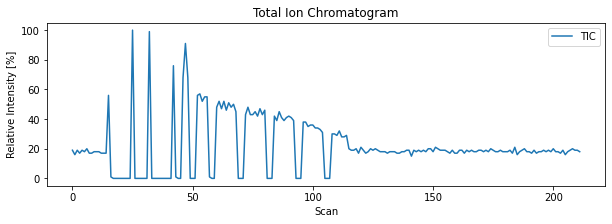

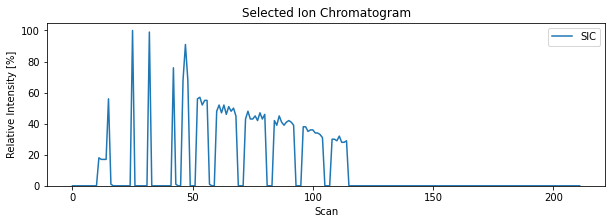

In [81]:
# Visualize the Total Ion Chromatogram (TIC) and the Selected Ion Chromatogram
# Plot the TIC over run
all_df.plot(figsize = (10, 3))
plt.xlabel('Scan')
plt.ylabel('Relative Intensity [%]')
plt.title('Total Ion Chromatogram');

# Plot the Selected Ion Chromatogram over run
cmp_comb_df.plot(figsize = (10, 3))
plt.xlabel('Scan')
plt.ylim(0,105)
plt.ylabel('Relative Intensity [%]')
plt.title('Selected Ion Chromatogram');

In [82]:
# Create dataframe with scans of selected ion (compound of interest)
my_df2 = pd.DataFrame(my_df['msdata:'][start_cmp:end_cmp])
my_df2.columns = ['msdata:']
display(my_df2.head())

,msdata:
579,cvParam: orbitrap
580,detector:
581,order: 3
582,cvParam: inductive detector
583,softwareRef: Xcalibur


In [83]:
# select only rows of interest from text file using key words from mylist using select SIC rows
my_sel_df2 = my_df2[my_df2['msdata:'].str.contains('|'.join(mylist), regex=True)]
my_sel_df2 = pd.DataFrame(my_sel_df2)
my_sel_df2.shape

(866, 1)

In [84]:
# view selected rows of data of interest
my_sel_df2[0:30]

,msdata:
594,binary: [409] 81.8053894043 82.80725...
597,binary: [409] 20000.109375 22330.505...
599,index: 11
606,"cvParam: base peak m/z, 679.3120727539..."
607,"cvParam: base peak intensity, 2.029105..."
611,"cvParam: spectrum title, 2AP.12.12. Fi..."
640,binary: [422] 83.3538360596 83.77066...
643,binary: [422] 18464.1816406 17548.73...
645,index: 12
652,"cvParam: base peak m/z, 679.3107910156..."


In [85]:
# Replace values in dataframe to make into user defined column names for metadata aquired from txt file
my_df_rep2 = my_sel_df2["msdata:"].replace("index: ", "Index:", regex=True).replace(
                                          "cvParam: base peak m/z, ", "Base_Peak_MZ:", regex=True).replace(
                                          "cvParam: base peak intensity, ", "Base_Peak_Intensity:", regex=True).replace(
                                          "cvParam: spectrum title, ", "Spectrum_Title:", regex=True).replace(
                                          "userParam: old charge state, ", "Charge:", regex=True).replace(
                                          "cvParam: possible charge state, 2", "Charge:2", regex=True).replace(
                                          "cvParam: possible charge state, 3", "Charge:3", regex=True).replace(
                                          "cvParam: selected ion m/z, ", "Selected_Ion_MZ:", regex=True).replace(
                                          "userParam: \[Thermo Trailer Extra]Monoisotopic M/Z:,", "Monoisotopic_MZ:", regex=True).replace(
                                          "cvParam: collision energy, ", "Collision_Energy:", regex=True).replace(
                                          "binary: ", "MZ_Intensity:", regex=True)

In [86]:
# view name changes
my_df_rep2 = pd.DataFrame(my_df_rep2)
my_df_rep2[0:20]

,msdata:
594,MZ_Intensity:[409] 81.8053894043 82....
597,MZ_Intensity:[409] 20000.109375 2233...
599,Index:11
606,"Base_Peak_MZ:679.312072753906, m/z"
607,"Base_Peak_Intensity:2.02910515625e05, ..."
611,"Spectrum_Title:2AP.12.12. File:""2AP.ra..."
640,MZ_Intensity:[422] 83.3538360596 83....
643,MZ_Intensity:[422] 18464.1816406 175...
645,Index:12
652,"Base_Peak_MZ:679.310791015625, m/z"


In [87]:
# Identifying the start of each scan
my_df_rep2['counts'] =1
my_df_rep2['counts'] = np.where(my_df_rep2['msdata:'].str.contains(r'Index:'), 1, 0)
my_df_rep2.head(20)

,msdata:,counts
594,MZ_Intensity:[409] 81.8053894043 82....,0
597,MZ_Intensity:[409] 20000.109375 2233...,0
599,Index:11,1
606,"Base_Peak_MZ:679.312072753906, m/z",0
607,"Base_Peak_Intensity:2.02910515625e05, ...",0
611,"Spectrum_Title:2AP.12.12. File:""2AP.ra...",0
640,MZ_Intensity:[422] 83.3538360596 83....,0
643,MZ_Intensity:[422] 18464.1816406 175...,0
645,Index:12,1
652,"Base_Peak_MZ:679.310791015625, m/z",0


In [88]:
# making spectrum column showing same spectrum number for each row associated with a single MS, MS/MS spectra and also chromotography data 
my_df_rep2['spectrum'] = my_df_rep2.counts.eq(1).cumsum()
my_df_rep2 = my_df_rep2.iloc[:-4 , :] # dropping chromotography data which is in last 4 rows
my_df_rep2 = my_df_rep2.drop(columns={'counts'})
my_df_rep2.reset_index(drop=True, inplace=True)
my_df_rep2 = my_df_rep2[my_df_rep2.spectrum != 0]
display(my_df_rep2[0:40])
display(my_df_rep2.shape)

,msdata:,spectrum
2,Index:11,1
3,"Base_Peak_MZ:679.312072753906, m/z",1
4,"Base_Peak_Intensity:2.02910515625e05, ...",1
5,"Spectrum_Title:2AP.12.12. File:""2AP.ra...",1
6,MZ_Intensity:[422] 83.3538360596 83....,1
7,MZ_Intensity:[422] 18464.1816406 175...,1
8,Index:12,2
9,"Base_Peak_MZ:679.310791015625, m/z",2
10,"Base_Peak_Intensity:2.10982953125e05, ...",2
11,"Spectrum_Title:2AP.13.13. File:""2AP.ra...",2


(860, 2)

In [89]:
# selecting only MS/MS data as these datasets that have 10, 11 or 12 rows of data
select_row_df2 = my_df_rep2[my_df_rep2['spectrum'].map(my_df_rep2['spectrum'].value_counts()) > 9]
display(select_row_df2.head(50))
display(select_row_df2.shape)

,msdata:,spectrum
32,Index:16,6
33,"Base_Peak_MZ:135.916137695313, m/z",6
34,"Base_Peak_Intensity:3.1315296875e05, n...",6
35,"Spectrum_Title:2AP.17.17.1 File:""2AP.r...",6
36,Monoisotopic_MZ: 136.0618438720703...,6
37,Selected_Ion_MZ:136.0618438720...,6
38,"cvParam: charge state, 1",6
39,Charge:1,6
40,"Collision_Energy:20.0, electronvolt",6
41,MZ_Intensity:[13] 81.7813186646 88.8...,6


(513, 2)

In [90]:
# reset index of select_row_df
select_row_df2.reset_index(drop=True, inplace=True)
display(select_row_df2.head(11))
display(select_row_df2.tail(11))

,msdata:,spectrum
0,Index:16,6
1,"Base_Peak_MZ:135.916137695313, m/z",6
2,"Base_Peak_Intensity:3.1315296875e05, n...",6
3,"Spectrum_Title:2AP.17.17.1 File:""2AP.r...",6
4,Monoisotopic_MZ: 136.0618438720703...,6
5,Selected_Ion_MZ:136.0618438720...,6
6,"cvParam: charge state, 1",6
7,Charge:1,6
8,"Collision_Energy:20.0, electronvolt",6
9,MZ_Intensity:[13] 81.7813186646 88.8...,6


,msdata:,spectrum
502,Index:107,97
503,"Base_Peak_MZ:108.90461730957, m/z",97
504,"Base_Peak_Intensity:1035.692993164063,...",97
505,"Spectrum_Title:2AP.108.108.1 File:""2AP...",97
506,Monoisotopic_MZ: 136.0618743896484...,97
507,Selected_Ion_MZ:136.0618743896...,97
508,"cvParam: charge state, 1",97
509,Charge:1,97
510,"Collision_Energy:60.0, electronvolt",97
511,MZ_Intensity:[8] 81.7897338867 90.80...,97


In [91]:
# count number of ms/ms spectra found in the subset of SIC data
spectrums2 = select_row_df2['spectrum'].nunique()
spectrums2

45

## Feature Engineering of MS/MS mz and intensity values to make them more ammenable to machine learning

In [92]:
select_row_df2.head()

,msdata:,spectrum
0,Index:16,6
1,"Base_Peak_MZ:135.916137695313, m/z",6
2,"Base_Peak_Intensity:3.1315296875e05, n...",6
3,"Spectrum_Title:2AP.17.17.1 File:""2AP.r...",6
4,Monoisotopic_MZ: 136.0618438720703...,6


In [93]:
# make MZ_Intensity dataframe
mz_int_df2 = pd.DataFrame(select_row_df2[select_row_df2['msdata:'].str.contains('MZ_Intensity:')])
mz_int_df2 = mz_int_df2.drop(columns={'spectrum'})
mz_int_df2 = mz_int_df2.rename(columns={'msdata:':'MZ_Intensity'})
mz_int_df2 = mz_int_df2.reset_index(drop=True)

# selecting just the MZ dataset
mz_df_2_2 = mz_int_df2[mz_int_df2.index.map(lambda x: x%2==0)]
mz_df_2_2 = mz_df_2_2.reset_index(drop=True)
display(mz_df_2_2) #shows the mz values of each of the the ms/ms scans

# selecting just the Intensity dataset
inten_df_2_2 = mz_int_df2[mz_int_df2.index.map(lambda x: x%2==1)]
inten_df_2_2 = inten_df_2_2.reset_index(drop=True)
display(inten_df_2_2) #shows the corresponding intensity values for each of the ms/ms scans

,MZ_Intensity
0,MZ_Intensity:[13] 81.7813186646 88.8...
1,MZ_Intensity:[19] 51.7802391052 72.9...
2,MZ_Intensity:[13] 72.7019805908 81.0...
3,MZ_Intensity:[21] 68.6550827026 71.8...
4,MZ_Intensity:[19] 68.6850662231 69.4...
5,MZ_Intensity:[19] 68.6803512573 69.4...
6,MZ_Intensity:[14] 56.785900116 60.81...
7,MZ_Intensity:[13] 60.8101806641 69.8...
8,MZ_Intensity:[10] 60.8434524536 69.8...
9,MZ_Intensity:[98] 84.8103027344 85.6...


,MZ_Intensity
0,MZ_Intensity:[13] 26.4172668457 19.2...
1,MZ_Intensity:[19] 14.9360151291 19.4...
2,MZ_Intensity:[13] 32.1487121582 26.3...
3,MZ_Intensity:[21] 238.41583252 11.67...
4,MZ_Intensity:[19] 144.729553223 2.08...
5,MZ_Intensity:[19] 103.778091431 1.99...
6,MZ_Intensity:[14] 1.33688855171 320....
7,MZ_Intensity:[13] 191.34413147 419.0...
8,MZ_Intensity:[10] 170.331344604 420....
9,MZ_Intensity:[98] 274.244110107 3.13...


In [94]:
# make MZ dataframe from select ions
mz_df_2_2['MZ_Intensity'] = mz_df_2_2['MZ_Intensity'].str.replace(r'MZ_Intensity:', '', regex=True)
mz_df_2_2['MZ_Intensity'] = mz_df_2_2['MZ_Intensity'].str.replace(r']', '[ ', regex=True)
mz_df2 = mz_df_2_2['MZ_Intensity'].str.split(pat='[', expand=True, n=3)
mz_df2.columns = ['Toss', 'Count', 'MZ']
mz_df2 = mz_df2.drop(columns={'Toss', 'Count'})
mz_df2.head()

,MZ
0,81.7813186646 88.8586730957 89.8440093994 90...
1,51.7802391052 72.9752960205 73.9758682251 83...
2,72.7019805908 81.0805740356 81.9738311768 90...
3,68.6550827026 71.8770370483 77.7178192139 78...
4,68.6850662231 69.4007492065 71.7964019775 77...


In [95]:
# transform MZ dataframe into machine learning compatible dataframe, convert string to numeric values, round to integer
# each row shows the mz values for each ms/ms scan
mz_df2 = mz_df2.astype({'MZ':'string'})
mz_split_df2 = mz_df2['MZ'].str.split(pat=' ', expand=True, n=-1)
mz_split_df2 = mz_split_df2.apply(pd.to_numeric, errors='coerce').round(0)
mz_split_df2 = mz_split_df2.fillna(0).astype(int)
mz_split_df2

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0,0,82,89,90,91,94,95,109,110,...,0,0,0,0,0,0,0,0,0,0
1,0,0,52,73,74,84,89,90,94,95,...,0,0,0,0,0,0,0,0,0,0
2,0,0,73,81,82,91,94,109,110,118,...,0,0,0,0,0,0,0,0,0,0
3,0,0,69,72,78,78,82,87,89,90,...,0,0,0,0,0,0,0,0,0,0
4,0,0,69,69,72,78,78,80,81,83,...,0,0,0,0,0,0,0,0,0,0
5,0,0,69,69,72,73,78,83,87,98,...,0,0,0,0,0,0,0,0,0,0
6,0,0,57,61,70,79,81,81,87,88,...,0,0,0,0,0,0,0,0,0,0
7,0,0,61,70,71,79,81,88,90,91,...,0,0,0,0,0,0,0,0,0,0
8,0,0,61,70,70,79,81,88,90,99,...,0,0,0,0,0,0,0,0,0,0
9,0,0,85,86,89,99,101,110,115,122,...,0,0,0,0,0,0,0,0,0,0


In [96]:
# transpose mz dataframe, each column shows the mz values for each ms/ms scan
mz_split_df_T2 = mz_split_df2.T
display(mz_split_df_T2.head(8))
display(mz_split_df_T2.shape)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,82,52,73,69,69,69,57,61,61,85,...,82,82,74,82,82,80,82,80,82,82
3,89,73,81,72,69,69,61,70,70,86,...,94,94,80,94,94,82,94,82,92,91
4,90,74,82,78,72,72,70,71,70,89,...,109,109,82,109,108,91,109,94,94,94
5,91,84,91,78,78,73,79,79,79,99,...,110,110,84,109,109,94,110,106,109,95
6,94,89,94,82,78,78,81,81,81,101,...,115,115,94,119,110,95,113,107,110,109
7,95,90,109,87,80,83,81,88,88,110,...,119,119,109,124,116,109,118,109,118,110


(113, 45)

In [97]:
# this code creates a true/false table which can be used in subsequent cells to remove duplicated mz and corresponding intensity values
# transposed again to show absence/presence of unique values of each ms/ms across rows
num_tf2 = mz_split_df_T2.shape[1]

out_list_tf2 = []
for i in range(num_tf2):
  test_col = (mz_split_df_T2[i].duplicated(keep='first'))*1
  test_col = test_col.values.tolist()
  out_list_tf2.append(test_col)
out_list_tf2

true_false_df2 = pd.DataFrame(out_list_tf2)
true_false_df_T2 = true_false_df2.T
true_false_df_T2 = true_false_df_T2.applymap(lambda x: 3 if x == 0 else x)
true_false_df_T2 = true_false_df_T2.applymap(lambda x: 0 if x == 1 else x)
true_false_df_T2 = true_false_df_T2.applymap(lambda x: 1 if x == 3 else x)
tf_final_df2 = true_false_df_T2.T
tf_final_df2.loc[tf_final_df2[0] == 1, 0] = 0
tf_final_df2.head(8)

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# remove duplicated values from mz dataframe 
mz_split_df2 = tf_final_df2 * mz_split_df2.values
mz_split_df2

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0,0,82,89,90,91,94,95,109,110,...,0,0,0,0,0,0,0,0,0,0
1,0,0,52,73,74,84,89,90,94,95,...,0,0,0,0,0,0,0,0,0,0
2,0,0,73,81,82,91,94,109,110,118,...,0,0,0,0,0,0,0,0,0,0
3,0,0,69,72,78,0,82,87,89,90,...,0,0,0,0,0,0,0,0,0,0
4,0,0,69,0,72,78,0,80,81,83,...,0,0,0,0,0,0,0,0,0,0
5,0,0,69,0,72,73,78,83,87,98,...,0,0,0,0,0,0,0,0,0,0
6,0,0,57,61,70,79,81,0,87,88,...,0,0,0,0,0,0,0,0,0,0
7,0,0,61,70,71,79,81,88,90,91,...,0,0,0,0,0,0,0,0,0,0
8,0,0,61,70,0,79,81,88,90,99,...,0,0,0,0,0,0,0,0,0,0
9,0,0,85,86,89,99,101,110,115,122,...,0,0,0,0,0,0,0,0,0,0


In [99]:
# make Intensity dataframe
inten_df_2_2['MZ_Intensity'] = inten_df_2_2['MZ_Intensity'].str.replace(r'MZ_Intensity:', '', regex=True)
inten_df_2_2['MZ_Intensity'] = inten_df_2_2['MZ_Intensity'].str.replace(r']', '[ ', regex=True)
inten_df2 = inten_df_2_2['MZ_Intensity'].str.split(pat='[', expand=True, n=3)
inten_df2.columns = ['Toss', 'Count', 'Intensity']
inten_df2 = inten_df2.drop(columns={'Toss', 'Count'})
inten_df2.head()

,Intensity
0,26.4172668457 19.2839775085 70.311668396 7.7...
1,14.9360151291 19.4330215454 29.1562919617 8....
2,32.1487121582 26.35014534 25.3258666992 13.7...
3,238.41583252 11.6775836945 116.865493774 1.9...
4,144.729553223 2.08865213394 15.2101011276 11...


In [100]:
# transform Intensity dataframe into machine learning compatible dataframe, convert string to numeric values, scale, round down
inten_df2 = inten_df2.astype({'Intensity':'string'})
inten_split_df2 = inten_df2['Intensity'].str.split(pat=' ', expand=True, n=-1)
inten_split_df2 = inten_split_df2.apply(pd.to_numeric, errors='coerce').round(0)
inten_split_df2 = inten_split_df2.fillna(0).astype(int)
display(inten_split_df2.head(8))
display(inten_split_df2.shape)

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0,0,26,19,70,8,211,10,1394,5,...,0,0,0,0,0,0,0,0,0,0
1,0,0,15,19,29,9,20,31,253,34,...,0,0,0,0,0,0,0,0,0,0
2,0,0,32,26,25,14,540,2082,40,39,...,0,0,0,0,0,0,0,0,0,0
3,0,0,238,12,117,2,6,99,192,12,...,0,0,0,0,0,0,0,0,0,0
4,0,0,145,2,15,115,1,4,4,4,...,0,0,0,0,0,0,0,0,0,0
5,0,0,104,2,5,1,72,15,29,580,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,320,465,221,262,32,4,17,...,0,0,0,0,0,0,0,0,0,0
7,0,0,191,419,3,147,18,11,180,5,...,0,0,0,0,0,0,0,0,0,0


(45, 113)

In [101]:
#calculation of number of columns in intensity dataframe
inten_len2 = inten_split_df2.shape[1] -1
mylist2=list(range(0, inten_len2+1))
mylength2 = len(mylist2)
mylength2

113

In [102]:
#calculation of maximum intensity of each ms/ms spectrum
max_inten2 = inten_split_df2.max(axis=1)
max_inten2 = pd.DataFrame(max_inten2, columns={"Max_Inten"})
display(max_inten2.head(10))
display(max_inten2.shape)

,Max_Inten
0,313153
1,1979
2,2082
3,923
4,664
5,580
6,465
7,419
8,420
9,15441


(45, 1)

In [103]:
# create a full dataframe with Max_Inten 
max_inten_t2 = max_inten2.T
max_inten_df2 = pd.DataFrame(np.repeat(max_inten_t2.values, mylength2, axis=0))
max_inten2 = max_inten_df2.T
display(max_inten2.head(10))
display(max_inten2.shape)

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,313153,313153,313153,313153,313153,313153,313153,313153,313153,313153,...,313153,313153,313153,313153,313153,313153,313153,313153,313153,313153
1,1979,1979,1979,1979,1979,1979,1979,1979,1979,1979,...,1979,1979,1979,1979,1979,1979,1979,1979,1979,1979
2,2082,2082,2082,2082,2082,2082,2082,2082,2082,2082,...,2082,2082,2082,2082,2082,2082,2082,2082,2082,2082
3,923,923,923,923,923,923,923,923,923,923,...,923,923,923,923,923,923,923,923,923,923
4,664,664,664,664,664,664,664,664,664,664,...,664,664,664,664,664,664,664,664,664,664
5,580,580,580,580,580,580,580,580,580,580,...,580,580,580,580,580,580,580,580,580,580
6,465,465,465,465,465,465,465,465,465,465,...,465,465,465,465,465,465,465,465,465,465
7,419,419,419,419,419,419,419,419,419,419,...,419,419,419,419,419,419,419,419,419,419
8,420,420,420,420,420,420,420,420,420,420,...,420,420,420,420,420,420,420,420,420,420
9,15441,15441,15441,15441,15441,15441,15441,15441,15441,15441,...,15441,15441,15441,15441,15441,15441,15441,15441,15441,15441


(45, 113)

In [104]:
#calculate the relative spectra intensities and calculate percent of max peak
inten_scale2 = ((inten_split_df2.div(max_inten2))*100).round(1)
display(inten_scale2.head())
display(inten_scale2.shape)

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.8,1.0,1.5,0.5,1.0,1.6,12.8,1.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.5,1.2,1.2,0.7,25.9,100.0,1.9,1.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,25.8,1.3,12.7,0.2,0.7,10.7,20.8,1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,21.8,0.3,2.3,17.3,0.2,0.6,0.6,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(45, 113)

In [105]:
# create function that converts values less than 1 to 0
def remove_low_peaks(x):
  if x <=1: # define here the filter, 1 = 1%
    return 0
  else:
    return x

In [106]:
# filter out peaks that are not at least 1% of max peak
inten_scale_df2 = inten_scale2.applymap(remove_low_peaks)
inten_scale_df2.head()

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0.0,0.0,1.5,0.0,0.0,1.6,12.8,1.7,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1.5,1.2,1.2,0.0,25.9,100.0,1.9,1.9,...,0,0,0,0,0,0,0,0,0,0
3,0,0,25.8,1.3,12.7,0.0,0.0,10.7,20.8,1.3,...,0,0,0,0,0,0,0,0,0,0
4,0,0,21.8,0.0,2.3,17.3,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# As intensities can possibly vary a bit from run to run, for machine learning, 
# we will engineerthe  features into broad intensity groups. Here we redefine the bins.
def inten_binning(x):
  if x >= 90:
    return 100
  elif x > 80:
    return 90
  elif x > 70:
    return 80
  elif x > 60:
    return 70
  elif x > 50:
    return 60
  elif x > 40:
    return 50
  elif x > 30:
    return 40
  elif x > 20:
    return 30
  elif x > 10:
    return 20
  elif x > 1:
    return 10
  else:
    return x

In [108]:
# put intensities into 10 bins
inten_bin_df2 = inten_scale_df2.applymap(inten_binning)
inten_bin_df2 = inten_bin_df2.fillna(0).astype(int)
inten_bin_df2.head(8)

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,10,0,0,10,20,10,...,0,0,0,0,0,0,0,0,0,0
2,0,0,10,10,10,0,30,100,10,10,...,0,0,0,0,0,0,0,0,0,0
3,0,0,30,10,20,0,0,20,30,10,...,0,0,0,0,0,0,0,0,0,0
4,0,0,30,0,10,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,20,0,0,0,20,10,10,100,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,70,100,50,60,10,0,10,...,0,0,0,0,0,0,0,0,0,0
7,0,0,50,100,0,40,10,10,50,10,...,0,0,0,0,0,0,0,0,0,0


In [109]:
# remove duplicated values from corresponding intensity dataframe. This uses the presence/absence dataframe made earlier
inten_bin_df2 = tf_final_df2 * inten_bin_df2.values
inten_bin_df2.head(10)

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,10,0,0,10,20,10,...,0,0,0,0,0,0,0,0,0,0
2,0,0,10,10,10,0,30,100,10,10,...,0,0,0,0,0,0,0,0,0,0
3,0,0,30,10,20,0,0,20,30,10,...,0,0,0,0,0,0,0,0,0,0
4,0,0,30,0,10,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,20,0,0,0,20,10,10,100,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,70,100,50,60,0,0,10,...,0,0,0,0,0,0,0,0,0,0
7,0,0,50,100,0,40,10,10,50,10,...,0,0,0,0,0,0,0,0,0,0
8,0,0,50,100,0,40,10,10,30,20,...,0,0,0,0,0,0,0,0,0,0
9,0,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# make mz - intensity column pairs for mz/intensity data. Here each mz column is aligned next to each corresponding
# intensity column
df_pair2 = pd.concat([mz_split_df2, inten_bin_df2], axis=1)
df_pair2 = df_pair2.sort_index(axis=1, level=None, ascending=True, inplace=False, kind='mergesort', na_position='last', sort_remaining=True)
df_pair2.head(8)

,0,0,1,1,2,2,3,3,4,4,...,108,108,109,109,110,110,111,111,112,112
0,0,0,0,0,82,0,89,0,90,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,52,0,73,0,74,10,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,73,10,81,10,82,10,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,69,30,72,10,78,20,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,69,30,0,0,72,10,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,69,20,0,0,72,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,57,0,61,70,70,100,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,61,50,70,100,71,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# transform each list into a list of coupled data using a user defined function make_couples
# each cell shows filtered mz with filtered and binned intensity
def make_couples(ls):
    return ['{}:{}'.format(*item) for item in zip(ls[::2], ls[1::2])]
col_names2 = list(range(0,(len(inten_bin_df2)),1))
df_concat2 = pd.DataFrame(data=map(make_couples, df_pair2.values))
df_concat2 = df_concat2.apply(lambda row: pd.Series(row).drop_duplicates(keep='first'),axis='columns')
df_concat2

,0,2,3,4,5,6,7,8,9,10,...,102,103,104,105,106,107,108,109,110,111
0,0:0,82:0,89:0,90:0,91:0,94:0,95:0,109:0,110:0,118:0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0:0,52:0,73:0,74:10,84:0,89:0,90:10,94:20,95:10,98:0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0:0,73:10,81:10,82:10,91:0,94:30,109:100,110:10,118:10,119:10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0:0,69:30,72:10,78:20,NaN,82:0,87:20,89:30,90:10,98:100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0:0,69:30,NaN,72:10,78:20,NaN,80:0,81:0,83:0,87:20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0:0,69:20,NaN,72:0,73:0,78:20,83:10,87:10,98:100,99:10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0:0,57:0,61:70,70:100,79:50,81:60,NaN,87:0,88:10,90:10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0:0,61:50,70:100,71:0,79:40,81:10,88:10,90:50,91:10,98:10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0:0,61:50,70:100,NaN,79:40,81:10,88:10,90:30,99:20,102:10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0:0,85:10,86:0,89:0,99:0,101:0,110:0,115:0,122:0,133:0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
#make dictionary of lists for df_concat dataframe
my_pair_dict2 = df_concat2.T.to_dict('list')

In [113]:
# clean up data dictionary to only show pairs of mz and intensity data
# this makes a dictionary showing each ms/ms spectra containing list of mz:intensities
my_list_df2 = pd.DataFrame(my_pair_dict2.items())
my_list_df2[1] = my_list_df2[1].map(str)
my_list_df2[1] = my_list_df2[1].str.replace(r", nan" , '', regex=True)
my_list_df2[1] = my_list_df2[1].str.replace(r"'0:0', " , '', regex=True)
my_list_df2[1] = my_list_df2[1].str.replace(r"'" , '', regex=True)
my_list_dict2 = my_list_df2[1].to_dict()
my_list_dict2[0]

'[82:0, 89:0, 90:0, 91:0, 94:0, 95:0, 109:0, 110:0, 118:0, 119:0, 124:0, 136:100, 137:0]'

In [114]:
#convert dictionary to list of tuples
list_of_tuples2 = []
for k, v in my_list_dict2.items():
  list_of_tuples2.append((k,v))
print(list_of_tuples2)

[(0, '[82:0, 89:0, 90:0, 91:0, 94:0, 95:0, 109:0, 110:0, 118:0, 119:0, 124:0, 136:100, 137:0]'), (1, '[52:0, 73:0, 74:10, 84:0, 89:0, 90:10, 94:20, 95:10, 98:0, 109:100, 110:10, 116:0, 118:10, 119:10, 124:10, 127:0, 133:10, 136:60, 137:0]'), (2, '[73:10, 81:10, 82:10, 91:0, 94:30, 109:100, 110:10, 118:10, 119:10, 120:0, 123:10, 124:10, 137:0]'), (3, '[69:30, 72:10, 78:20, 82:0, 87:20, 89:30, 90:10, 98:100, 99:10, 100:0, 106:0, 107:10, 110:20, 113:20, 114:80, 115:0, 130:0, 132:10, 155:0]'), (4, '[69:30, 72:10, 78:20, 80:0, 81:0, 83:0, 87:20, 89:10, 98:100, 99:10, 107:10, 110:10, 113:20, 114:80, 115:10, 132:10, 155:10]'), (5, '[69:20, 72:0, 73:0, 78:20, 83:10, 87:10, 98:100, 99:10, 107:0, 109:10, 110:10, 113:20, 114:70, 115:10, 132:10, 154:0, 155:0]'), (6, '[57:0, 61:70, 70:100, 79:50, 81:60, 87:0, 88:10, 90:10, 98:10, 99:20, 102:10, 111:10]'), (7, '[61:50, 70:100, 71:0, 79:40, 81:10, 88:10, 90:50, 91:10, 98:10, 99:20, 101:10, 102:10, 111:0]'), (8, '[61:50, 70:100, 79:40, 81:10, 88:10, 9

In [115]:
#convert list of tuples to list of lists
my_lists2 = [list(x) for x in list_of_tuples2]
print(my_lists2)

[[0, '[82:0, 89:0, 90:0, 91:0, 94:0, 95:0, 109:0, 110:0, 118:0, 119:0, 124:0, 136:100, 137:0]'], [1, '[52:0, 73:0, 74:10, 84:0, 89:0, 90:10, 94:20, 95:10, 98:0, 109:100, 110:10, 116:0, 118:10, 119:10, 124:10, 127:0, 133:10, 136:60, 137:0]'], [2, '[73:10, 81:10, 82:10, 91:0, 94:30, 109:100, 110:10, 118:10, 119:10, 120:0, 123:10, 124:10, 137:0]'], [3, '[69:30, 72:10, 78:20, 82:0, 87:20, 89:30, 90:10, 98:100, 99:10, 100:0, 106:0, 107:10, 110:20, 113:20, 114:80, 115:0, 130:0, 132:10, 155:0]'], [4, '[69:30, 72:10, 78:20, 80:0, 81:0, 83:0, 87:20, 89:10, 98:100, 99:10, 107:10, 110:10, 113:20, 114:80, 115:10, 132:10, 155:10]'], [5, '[69:20, 72:0, 73:0, 78:20, 83:10, 87:10, 98:100, 99:10, 107:0, 109:10, 110:10, 113:20, 114:70, 115:10, 132:10, 154:0, 155:0]'], [6, '[57:0, 61:70, 70:100, 79:50, 81:60, 87:0, 88:10, 90:10, 98:10, 99:20, 102:10, 111:10]'], [7, '[61:50, 70:100, 71:0, 79:40, 81:10, 88:10, 90:50, 91:10, 98:10, 99:20, 101:10, 102:10, 111:0]'], [8, '[61:50, 70:100, 79:40, 81:10, 88:10, 9

In [116]:
# create lists of mz:intensity pairs
df_lists2=pd.DataFrame(my_lists2[0:])
df_lists2.drop(0, axis=1, inplace=True)
df_lists2.head()

,1
0,"[82:0, 89:0, 90:0, 91:0, 94:0, 95:0, 109:0, 11..."
1,"[52:0, 73:0, 74:10, 84:0, 89:0, 90:10, 94:20, ..."
2,"[73:10, 81:10, 82:10, 91:0, 94:30, 109:100, 11..."
3,"[69:30, 72:10, 78:20, 82:0, 87:20, 89:30, 90:1..."
4,"[69:30, 72:10, 78:20, 80:0, 81:0, 83:0, 87:20,..."


In [117]:
#remove [] with () and replace : with period
df_lists2[1] = df_lists2[1].str.replace(r', ', '),(', regex=True)
df_lists2[1] = df_lists2[1].str.replace(r' ', '', regex=True)
df_lists2[1] = df_lists2[1].str.replace(r'[', '', regex=True)
df_lists2[1] = df_lists2[1].str.replace(r']', '', regex=True)
df_lists2[1] = df_lists2[1].str.replace(r'(', '', regex=True)
df_lists2[1] = df_lists2[1].str.replace(r')', '', regex=True)
df_lists2[1] = df_lists2[1].str.replace(r':','.', regex=True)

df_lists2.head()

,1
0,"82.0,89.0,90.0,91.0,94.0,95.0,109.0,110.0,118...."
1,"52.0,73.0,74.10,84.0,89.0,90.10,94.20,95.10,98..."
2,"73.10,81.10,82.10,91.0,94.30,109.100,110.10,11..."
3,"69.30,72.10,78.20,82.0,87.20,89.30,90.10,98.10..."
4,"69.30,72.10,78.20,80.0,81.0,83.0,87.20,89.10,9..."


In [118]:
# convert strings to numeric
df_split_2_2 = df_lists2[1].str.split(pat=',', expand=True, n=-1)
df_split_2_2

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,82.0,89.0,90.0,91.0,94.0,95.0,109.0,110.0,118.0,119.0,...,None,None,None,None,None,None,None,None,None,None
1,52.0,73.0,74.10,84.0,89.0,90.10,94.20,95.10,98.0,109.100,...,None,None,None,None,None,None,None,None,None,None
2,73.10,81.10,82.10,91.0,94.30,109.100,110.10,118.10,119.10,120.0,...,None,None,None,None,None,None,None,None,None,None
3,69.30,72.10,78.20,82.0,87.20,89.30,90.10,98.100,99.10,100.0,...,None,None,None,None,None,None,None,None,None,None
4,69.30,72.10,78.20,80.0,81.0,83.0,87.20,89.10,98.100,99.10,...,None,None,None,None,None,None,None,None,None,None
5,69.20,72.0,73.0,78.20,83.10,87.10,98.100,99.10,107.0,109.10,...,None,None,None,None,None,None,None,None,None,None
6,57.0,61.70,70.100,79.50,81.60,87.0,88.10,90.10,98.10,99.20,...,None,None,None,None,None,None,None,None,None,None
7,61.50,70.100,71.0,79.40,81.10,88.10,90.50,91.10,98.10,99.20,...,None,None,None,None,None,None,None,None,None,None
8,61.50,70.100,79.40,81.10,88.10,90.30,99.20,102.10,108.10,None,...,None,None,None,None,None,None,None,None,None,None
9,85.10,86.0,89.0,99.0,101.0,110.0,115.0,122.0,133.0,134.0,...,None,None,None,None,None,None,None,None,None,None


In [119]:
# replace None values with [0,0] and replace period with comma
df_split_2_2 = df_split_2_2.applymap(lambda x: x.rsplit('.', 1), na_action='ignore')
df_split_2_2 = df_split_2_2.applymap(lambda x: [0, 0] if x == None else x)
display(df_split_2_2.head(10))
display(df_split_2_2.shape)

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,"[82, 0]","[89, 0]","[90, 0]","[91, 0]","[94, 0]","[95, 0]","[109, 0]","[110, 0]","[118, 0]","[119, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
1,"[52, 0]","[73, 0]","[74, 10]","[84, 0]","[89, 0]","[90, 10]","[94, 20]","[95, 10]","[98, 0]","[109, 100]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2,"[73, 10]","[81, 10]","[82, 10]","[91, 0]","[94, 30]","[109, 100]","[110, 10]","[118, 10]","[119, 10]","[120, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
3,"[69, 30]","[72, 10]","[78, 20]","[82, 0]","[87, 20]","[89, 30]","[90, 10]","[98, 100]","[99, 10]","[100, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
4,"[69, 30]","[72, 10]","[78, 20]","[80, 0]","[81, 0]","[83, 0]","[87, 20]","[89, 10]","[98, 100]","[99, 10]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
5,"[69, 20]","[72, 0]","[73, 0]","[78, 20]","[83, 10]","[87, 10]","[98, 100]","[99, 10]","[107, 0]","[109, 10]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
6,"[57, 0]","[61, 70]","[70, 100]","[79, 50]","[81, 60]","[87, 0]","[88, 10]","[90, 10]","[98, 10]","[99, 20]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
7,"[61, 50]","[70, 100]","[71, 0]","[79, 40]","[81, 10]","[88, 10]","[90, 50]","[91, 10]","[98, 10]","[99, 20]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
8,"[61, 50]","[70, 100]","[79, 40]","[81, 10]","[88, 10]","[90, 30]","[99, 20]","[102, 10]","[108, 10]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
9,"[85, 10]","[86, 0]","[89, 0]","[99, 0]","[101, 0]","[110, 0]","[115, 0]","[122, 0]","[133, 0]","[134, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"


(45, 108)

In [120]:
# this cell creates a full dataframe where each column represents a single 1 dalton mz values from 50 to 3500
# then the rows are populated with the intensity value only corresponding to each mz value defined by column
# creating new dataframe which contains just the intensity depending on mz which is converted to columns
num2 = df_split_2_2.shape[0]
my_lab2 = list(range(50,3501,1))
my_lab_str2 = [str(x) for x in my_lab2]
df_split_3_2 = df_split_2_2.T

# Generator function to generate generator object
out_list2 = []
for i in range(num2):
  df_split_4_2 = pd.DataFrame(df_split_3_2[i].tolist())
  df_split_5_2 = df_split_4_2[~(df_split_4_2 == 0).all(axis=1)]
  df_split_6_2 = df_split_5_2.set_index(0)
  df_split_7_2 = df_split_6_2.reindex(labels=range(50,3501,1), index=my_lab_str2)
  df_split_8_2 = df_split_7_2.T
  list_item2_2 = df_split_8_2.values.tolist()
  list_item2_2 = list_item2_2[0]
  out_list2.append(list_item2_2)

# create dataframe from appended lists
mz_int_fin_df2 = pd.DataFrame(out_list2, columns=my_lab_str2)
mz_int_fin_df2 = mz_int_fin_df2.fillna(0)
mz_int_fin_df2 = mz_int_fin_df2.astype('int')
mz_int_fin_df2.iloc[0:10, 100:130]


,150,151,152,153,154,155,156,157,158,159,...,170,171,172,173,174,175,176,177,178,179
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
mz_int_fin_df2.shape

(45, 3451)

In [122]:
mz_int_fin_df2.rename(columns ={'50':'50mz_Inten','51':'51mz_Inten','52':'52mz_Inten','53':'53mz_Inten','54':'54mz_Inten','55':'55mz_Inten','56':'56mz_Inten','57':'57mz_Inten','58':'58mz_Inten','59':'59mz_Inten','60':'60mz_Inten','61':'61mz_Inten','62':'62mz_Inten','63':'63mz_Inten','64':'64mz_Inten','65':'65mz_Inten','66':'66mz_Inten','67':'67mz_Inten','68':'68mz_Inten','69':'69mz_Inten','70':'70mz_Inten','71':'71mz_Inten','72':'72mz_Inten','73':'73mz_Inten','74':'74mz_Inten','75':'75mz_Inten','76':'76mz_Inten','77':'77mz_Inten','78':'78mz_Inten','79':'79mz_Inten','80':'80mz_Inten','81':'81mz_Inten','82':'82mz_Inten','83':'83mz_Inten','84':'84mz_Inten','85':'85mz_Inten','86':'86mz_Inten','87':'87mz_Inten','88':'88mz_Inten','89':'89mz_Inten','90':'90mz_Inten','91':'91mz_Inten','92':'92mz_Inten','93':'93mz_Inten','94':'94mz_Inten','95':'95mz_Inten','96':'96mz_Inten','97':'97mz_Inten','98':'98mz_Inten','99':'99mz_Inten','100':'100mz_Inten','101':'101mz_Inten','102':'102mz_Inten','103':'103mz_Inten','104':'104mz_Inten','105':'105mz_Inten','106':'106mz_Inten','107':'107mz_Inten','108':'108mz_Inten','109':'109mz_Inten','110':'110mz_Inten','111':'111mz_Inten','112':'112mz_Inten','113':'113mz_Inten','114':'114mz_Inten','115':'115mz_Inten','116':'116mz_Inten','117':'117mz_Inten','118':'118mz_Inten','119':'119mz_Inten','120':'120mz_Inten','121':'121mz_Inten','122':'122mz_Inten','123':'123mz_Inten','124':'124mz_Inten','125':'125mz_Inten','126':'126mz_Inten','127':'127mz_Inten','128':'128mz_Inten','129':'129mz_Inten','130':'130mz_Inten','131':'131mz_Inten','132':'132mz_Inten','133':'133mz_Inten','134':'134mz_Inten','135':'135mz_Inten','136':'136mz_Inten','137':'137mz_Inten','138':'138mz_Inten','139':'139mz_Inten','140':'140mz_Inten','141':'141mz_Inten','142':'142mz_Inten','143':'143mz_Inten','144':'144mz_Inten','145':'145mz_Inten','146':'146mz_Inten','147':'147mz_Inten','148':'148mz_Inten','149':'149mz_Inten','150':'150mz_Inten','151':'151mz_Inten','152':'152mz_Inten','153':'153mz_Inten','154':'154mz_Inten','155':'155mz_Inten','156':'156mz_Inten','157':'157mz_Inten','158':'158mz_Inten','159':'159mz_Inten','160':'160mz_Inten','161':'161mz_Inten','162':'162mz_Inten','163':'163mz_Inten','164':'164mz_Inten','165':'165mz_Inten','166':'166mz_Inten','167':'167mz_Inten','168':'168mz_Inten','169':'169mz_Inten','170':'170mz_Inten','171':'171mz_Inten','172':'172mz_Inten','173':'173mz_Inten','174':'174mz_Inten','175':'175mz_Inten','176':'176mz_Inten','177':'177mz_Inten','178':'178mz_Inten','179':'179mz_Inten','180':'180mz_Inten','181':'181mz_Inten','182':'182mz_Inten','183':'183mz_Inten','184':'184mz_Inten','185':'185mz_Inten','186':'186mz_Inten','187':'187mz_Inten','188':'188mz_Inten','189':'189mz_Inten','190':'190mz_Inten','191':'191mz_Inten','192':'192mz_Inten','193':'193mz_Inten','194':'194mz_Inten','195':'195mz_Inten','196':'196mz_Inten','197':'197mz_Inten','198':'198mz_Inten','199':'199mz_Inten','200':'200mz_Inten','201':'201mz_Inten','202':'202mz_Inten','203':'203mz_Inten','204':'204mz_Inten','205':'205mz_Inten','206':'206mz_Inten','207':'207mz_Inten','208':'208mz_Inten','209':'209mz_Inten','210':'210mz_Inten','211':'211mz_Inten','212':'212mz_Inten','213':'213mz_Inten','214':'214mz_Inten','215':'215mz_Inten','216':'216mz_Inten','217':'217mz_Inten','218':'218mz_Inten','219':'219mz_Inten','220':'220mz_Inten','221':'221mz_Inten','222':'222mz_Inten','223':'223mz_Inten','224':'224mz_Inten','225':'225mz_Inten','226':'226mz_Inten','227':'227mz_Inten','228':'228mz_Inten','229':'229mz_Inten','230':'230mz_Inten','231':'231mz_Inten','232':'232mz_Inten','233':'233mz_Inten','234':'234mz_Inten','235':'235mz_Inten','236':'236mz_Inten','237':'237mz_Inten','238':'238mz_Inten','239':'239mz_Inten','240':'240mz_Inten','241':'241mz_Inten','242':'242mz_Inten','243':'243mz_Inten','244':'244mz_Inten','245':'245mz_Inten','246':'246mz_Inten','247':'247mz_Inten','248':'248mz_Inten','249':'249mz_Inten','250':'250mz_Inten','251':'251mz_Inten','252':'252mz_Inten','253':'253mz_Inten','254':'254mz_Inten','255':'255mz_Inten','256':'256mz_Inten','257':'257mz_Inten','258':'258mz_Inten','259':'259mz_Inten','260':'260mz_Inten','261':'261mz_Inten','262':'262mz_Inten','263':'263mz_Inten','264':'264mz_Inten','265':'265mz_Inten','266':'266mz_Inten','267':'267mz_Inten','268':'268mz_Inten','269':'269mz_Inten','270':'270mz_Inten','271':'271mz_Inten','272':'272mz_Inten','273':'273mz_Inten','274':'274mz_Inten','275':'275mz_Inten','276':'276mz_Inten','277':'277mz_Inten','278':'278mz_Inten','279':'279mz_Inten','280':'280mz_Inten','281':'281mz_Inten','282':'282mz_Inten','283':'283mz_Inten','284':'284mz_Inten','285':'285mz_Inten','286':'286mz_Inten','287':'287mz_Inten','288':'288mz_Inten','289':'289mz_Inten','290':'290mz_Inten','291':'291mz_Inten','292':'292mz_Inten','293':'293mz_Inten','294':'294mz_Inten','295':'295mz_Inten','296':'296mz_Inten','297':'297mz_Inten','298':'298mz_Inten','299':'299mz_Inten','300':'300mz_Inten','301':'301mz_Inten','302':'302mz_Inten','303':'303mz_Inten','304':'304mz_Inten','305':'305mz_Inten','306':'306mz_Inten','307':'307mz_Inten','308':'308mz_Inten','309':'309mz_Inten','310':'310mz_Inten','311':'311mz_Inten','312':'312mz_Inten','313':'313mz_Inten','314':'314mz_Inten','315':'315mz_Inten','316':'316mz_Inten','317':'317mz_Inten','318':'318mz_Inten','319':'319mz_Inten','320':'320mz_Inten','321':'321mz_Inten','322':'322mz_Inten','323':'323mz_Inten','324':'324mz_Inten','325':'325mz_Inten','326':'326mz_Inten','327':'327mz_Inten','328':'328mz_Inten','329':'329mz_Inten','330':'330mz_Inten','331':'331mz_Inten','332':'332mz_Inten','333':'333mz_Inten','334':'334mz_Inten','335':'335mz_Inten','336':'336mz_Inten','337':'337mz_Inten','338':'338mz_Inten','339':'339mz_Inten','340':'340mz_Inten','341':'341mz_Inten','342':'342mz_Inten','343':'343mz_Inten','344':'344mz_Inten','345':'345mz_Inten','346':'346mz_Inten','347':'347mz_Inten','348':'348mz_Inten','349':'349mz_Inten','350':'350mz_Inten','351':'351mz_Inten','352':'352mz_Inten','353':'353mz_Inten','354':'354mz_Inten','355':'355mz_Inten','356':'356mz_Inten','357':'357mz_Inten','358':'358mz_Inten','359':'359mz_Inten','360':'360mz_Inten','361':'361mz_Inten','362':'362mz_Inten','363':'363mz_Inten','364':'364mz_Inten','365':'365mz_Inten','366':'366mz_Inten','367':'367mz_Inten','368':'368mz_Inten','369':'369mz_Inten','370':'370mz_Inten','371':'371mz_Inten','372':'372mz_Inten','373':'373mz_Inten','374':'374mz_Inten','375':'375mz_Inten','376':'376mz_Inten','377':'377mz_Inten','378':'378mz_Inten','379':'379mz_Inten','380':'380mz_Inten','381':'381mz_Inten','382':'382mz_Inten','383':'383mz_Inten','384':'384mz_Inten','385':'385mz_Inten','386':'386mz_Inten','387':'387mz_Inten','388':'388mz_Inten','389':'389mz_Inten','390':'390mz_Inten','391':'391mz_Inten','392':'392mz_Inten','393':'393mz_Inten','394':'394mz_Inten','395':'395mz_Inten','396':'396mz_Inten','397':'397mz_Inten','398':'398mz_Inten','399':'399mz_Inten','400':'400mz_Inten','401':'401mz_Inten','402':'402mz_Inten','403':'403mz_Inten','404':'404mz_Inten','405':'405mz_Inten','406':'406mz_Inten','407':'407mz_Inten','408':'408mz_Inten','409':'409mz_Inten','410':'410mz_Inten','411':'411mz_Inten','412':'412mz_Inten','413':'413mz_Inten','414':'414mz_Inten','415':'415mz_Inten','416':'416mz_Inten','417':'417mz_Inten','418':'418mz_Inten','419':'419mz_Inten','420':'420mz_Inten','421':'421mz_Inten','422':'422mz_Inten','423':'423mz_Inten','424':'424mz_Inten','425':'425mz_Inten','426':'426mz_Inten','427':'427mz_Inten','428':'428mz_Inten','429':'429mz_Inten','430':'430mz_Inten','431':'431mz_Inten','432':'432mz_Inten','433':'433mz_Inten','434':'434mz_Inten','435':'435mz_Inten','436':'436mz_Inten','437':'437mz_Inten','438':'438mz_Inten','439':'439mz_Inten','440':'440mz_Inten','441':'441mz_Inten','442':'442mz_Inten','443':'443mz_Inten','444':'444mz_Inten','445':'445mz_Inten','446':'446mz_Inten','447':'447mz_Inten','448':'448mz_Inten','449':'449mz_Inten','450':'450mz_Inten','451':'451mz_Inten','452':'452mz_Inten','453':'453mz_Inten','454':'454mz_Inten','455':'455mz_Inten','456':'456mz_Inten','457':'457mz_Inten','458':'458mz_Inten','459':'459mz_Inten','460':'460mz_Inten','461':'461mz_Inten','462':'462mz_Inten','463':'463mz_Inten','464':'464mz_Inten','465':'465mz_Inten','466':'466mz_Inten','467':'467mz_Inten','468':'468mz_Inten','469':'469mz_Inten','470':'470mz_Inten','471':'471mz_Inten','472':'472mz_Inten','473':'473mz_Inten','474':'474mz_Inten','475':'475mz_Inten','476':'476mz_Inten','477':'477mz_Inten','478':'478mz_Inten','479':'479mz_Inten','480':'480mz_Inten','481':'481mz_Inten','482':'482mz_Inten','483':'483mz_Inten','484':'484mz_Inten','485':'485mz_Inten','486':'486mz_Inten','487':'487mz_Inten','488':'488mz_Inten','489':'489mz_Inten','490':'490mz_Inten','491':'491mz_Inten','492':'492mz_Inten','493':'493mz_Inten','494':'494mz_Inten','495':'495mz_Inten','496':'496mz_Inten','497':'497mz_Inten','498':'498mz_Inten','499':'499mz_Inten','500':'500mz_Inten','501':'501mz_Inten','502':'502mz_Inten','503':'503mz_Inten','504':'504mz_Inten','505':'505mz_Inten','506':'506mz_Inten','507':'507mz_Inten','508':'508mz_Inten','509':'509mz_Inten','510':'510mz_Inten','511':'511mz_Inten','512':'512mz_Inten','513':'513mz_Inten','514':'514mz_Inten','515':'515mz_Inten','516':'516mz_Inten','517':'517mz_Inten','518':'518mz_Inten','519':'519mz_Inten','520':'520mz_Inten','521':'521mz_Inten','522':'522mz_Inten','523':'523mz_Inten','524':'524mz_Inten','525':'525mz_Inten','526':'526mz_Inten','527':'527mz_Inten','528':'528mz_Inten','529':'529mz_Inten','530':'530mz_Inten','531':'531mz_Inten','532':'532mz_Inten','533':'533mz_Inten','534':'534mz_Inten','535':'535mz_Inten','536':'536mz_Inten','537':'537mz_Inten','538':'538mz_Inten','539':'539mz_Inten','540':'540mz_Inten','541':'541mz_Inten','542':'542mz_Inten','543':'543mz_Inten','544':'544mz_Inten','545':'545mz_Inten','546':'546mz_Inten','547':'547mz_Inten','548':'548mz_Inten','549':'549mz_Inten','550':'550mz_Inten','551':'551mz_Inten','552':'552mz_Inten','553':'553mz_Inten','554':'554mz_Inten','555':'555mz_Inten','556':'556mz_Inten','557':'557mz_Inten','558':'558mz_Inten','559':'559mz_Inten','560':'560mz_Inten','561':'561mz_Inten','562':'562mz_Inten','563':'563mz_Inten','564':'564mz_Inten','565':'565mz_Inten','566':'566mz_Inten','567':'567mz_Inten','568':'568mz_Inten','569':'569mz_Inten','570':'570mz_Inten','571':'571mz_Inten','572':'572mz_Inten','573':'573mz_Inten','574':'574mz_Inten','575':'575mz_Inten','576':'576mz_Inten','577':'577mz_Inten','578':'578mz_Inten','579':'579mz_Inten','580':'580mz_Inten','581':'581mz_Inten','582':'582mz_Inten','583':'583mz_Inten','584':'584mz_Inten','585':'585mz_Inten','586':'586mz_Inten','587':'587mz_Inten','588':'588mz_Inten','589':'589mz_Inten','590':'590mz_Inten','591':'591mz_Inten','592':'592mz_Inten','593':'593mz_Inten','594':'594mz_Inten','595':'595mz_Inten','596':'596mz_Inten','597':'597mz_Inten','598':'598mz_Inten','599':'599mz_Inten','600':'600mz_Inten','601':'601mz_Inten','602':'602mz_Inten','603':'603mz_Inten','604':'604mz_Inten','605':'605mz_Inten','606':'606mz_Inten','607':'607mz_Inten','608':'608mz_Inten','609':'609mz_Inten','610':'610mz_Inten','611':'611mz_Inten','612':'612mz_Inten','613':'613mz_Inten','614':'614mz_Inten','615':'615mz_Inten','616':'616mz_Inten','617':'617mz_Inten','618':'618mz_Inten','619':'619mz_Inten','620':'620mz_Inten','621':'621mz_Inten','622':'622mz_Inten','623':'623mz_Inten','624':'624mz_Inten','625':'625mz_Inten','626':'626mz_Inten','627':'627mz_Inten','628':'628mz_Inten','629':'629mz_Inten','630':'630mz_Inten','631':'631mz_Inten','632':'632mz_Inten','633':'633mz_Inten','634':'634mz_Inten','635':'635mz_Inten','636':'636mz_Inten','637':'637mz_Inten','638':'638mz_Inten','639':'639mz_Inten','640':'640mz_Inten','641':'641mz_Inten','642':'642mz_Inten','643':'643mz_Inten','644':'644mz_Inten','645':'645mz_Inten','646':'646mz_Inten','647':'647mz_Inten','648':'648mz_Inten','649':'649mz_Inten','650':'650mz_Inten','651':'651mz_Inten','652':'652mz_Inten','653':'653mz_Inten','654':'654mz_Inten','655':'655mz_Inten','656':'656mz_Inten','657':'657mz_Inten','658':'658mz_Inten','659':'659mz_Inten','660':'660mz_Inten','661':'661mz_Inten','662':'662mz_Inten','663':'663mz_Inten','664':'664mz_Inten','665':'665mz_Inten','666':'666mz_Inten','667':'667mz_Inten','668':'668mz_Inten','669':'669mz_Inten','670':'670mz_Inten','671':'671mz_Inten','672':'672mz_Inten','673':'673mz_Inten','674':'674mz_Inten','675':'675mz_Inten','676':'676mz_Inten','677':'677mz_Inten','678':'678mz_Inten','679':'679mz_Inten','680':'680mz_Inten','681':'681mz_Inten','682':'682mz_Inten','683':'683mz_Inten','684':'684mz_Inten','685':'685mz_Inten','686':'686mz_Inten','687':'687mz_Inten','688':'688mz_Inten','689':'689mz_Inten','690':'690mz_Inten','691':'691mz_Inten','692':'692mz_Inten','693':'693mz_Inten','694':'694mz_Inten','695':'695mz_Inten','696':'696mz_Inten','697':'697mz_Inten','698':'698mz_Inten','699':'699mz_Inten','700':'700mz_Inten','701':'701mz_Inten','702':'702mz_Inten','703':'703mz_Inten','704':'704mz_Inten','705':'705mz_Inten','706':'706mz_Inten','707':'707mz_Inten','708':'708mz_Inten','709':'709mz_Inten','710':'710mz_Inten','711':'711mz_Inten','712':'712mz_Inten','713':'713mz_Inten','714':'714mz_Inten','715':'715mz_Inten','716':'716mz_Inten','717':'717mz_Inten','718':'718mz_Inten','719':'719mz_Inten','720':'720mz_Inten','721':'721mz_Inten','722':'722mz_Inten','723':'723mz_Inten','724':'724mz_Inten','725':'725mz_Inten','726':'726mz_Inten','727':'727mz_Inten','728':'728mz_Inten','729':'729mz_Inten','730':'730mz_Inten','731':'731mz_Inten','732':'732mz_Inten','733':'733mz_Inten','734':'734mz_Inten','735':'735mz_Inten','736':'736mz_Inten','737':'737mz_Inten','738':'738mz_Inten','739':'739mz_Inten','740':'740mz_Inten','741':'741mz_Inten','742':'742mz_Inten','743':'743mz_Inten','744':'744mz_Inten','745':'745mz_Inten','746':'746mz_Inten','747':'747mz_Inten','748':'748mz_Inten','749':'749mz_Inten','750':'750mz_Inten','751':'751mz_Inten','752':'752mz_Inten','753':'753mz_Inten','754':'754mz_Inten','755':'755mz_Inten','756':'756mz_Inten','757':'757mz_Inten','758':'758mz_Inten','759':'759mz_Inten','760':'760mz_Inten','761':'761mz_Inten','762':'762mz_Inten','763':'763mz_Inten','764':'764mz_Inten','765':'765mz_Inten','766':'766mz_Inten','767':'767mz_Inten','768':'768mz_Inten','769':'769mz_Inten','770':'770mz_Inten','771':'771mz_Inten','772':'772mz_Inten','773':'773mz_Inten','774':'774mz_Inten','775':'775mz_Inten','776':'776mz_Inten','777':'777mz_Inten','778':'778mz_Inten','779':'779mz_Inten','780':'780mz_Inten','781':'781mz_Inten','782':'782mz_Inten','783':'783mz_Inten','784':'784mz_Inten','785':'785mz_Inten','786':'786mz_Inten','787':'787mz_Inten','788':'788mz_Inten','789':'789mz_Inten','790':'790mz_Inten','791':'791mz_Inten','792':'792mz_Inten','793':'793mz_Inten','794':'794mz_Inten','795':'795mz_Inten','796':'796mz_Inten','797':'797mz_Inten','798':'798mz_Inten','799':'799mz_Inten','800':'800mz_Inten','801':'801mz_Inten','802':'802mz_Inten','803':'803mz_Inten','804':'804mz_Inten','805':'805mz_Inten','806':'806mz_Inten','807':'807mz_Inten','808':'808mz_Inten','809':'809mz_Inten','810':'810mz_Inten','811':'811mz_Inten','812':'812mz_Inten','813':'813mz_Inten','814':'814mz_Inten','815':'815mz_Inten','816':'816mz_Inten','817':'817mz_Inten','818':'818mz_Inten','819':'819mz_Inten','820':'820mz_Inten','821':'821mz_Inten','822':'822mz_Inten','823':'823mz_Inten','824':'824mz_Inten','825':'825mz_Inten','826':'826mz_Inten','827':'827mz_Inten','828':'828mz_Inten','829':'829mz_Inten','830':'830mz_Inten','831':'831mz_Inten','832':'832mz_Inten','833':'833mz_Inten','834':'834mz_Inten','835':'835mz_Inten','836':'836mz_Inten','837':'837mz_Inten','838':'838mz_Inten','839':'839mz_Inten','840':'840mz_Inten','841':'841mz_Inten','842':'842mz_Inten','843':'843mz_Inten','844':'844mz_Inten','845':'845mz_Inten','846':'846mz_Inten','847':'847mz_Inten','848':'848mz_Inten','849':'849mz_Inten','850':'850mz_Inten','851':'851mz_Inten','852':'852mz_Inten','853':'853mz_Inten','854':'854mz_Inten','855':'855mz_Inten','856':'856mz_Inten','857':'857mz_Inten','858':'858mz_Inten','859':'859mz_Inten','860':'860mz_Inten','861':'861mz_Inten','862':'862mz_Inten','863':'863mz_Inten','864':'864mz_Inten','865':'865mz_Inten','866':'866mz_Inten','867':'867mz_Inten','868':'868mz_Inten','869':'869mz_Inten','870':'870mz_Inten','871':'871mz_Inten','872':'872mz_Inten','873':'873mz_Inten','874':'874mz_Inten','875':'875mz_Inten','876':'876mz_Inten','877':'877mz_Inten','878':'878mz_Inten','879':'879mz_Inten','880':'880mz_Inten','881':'881mz_Inten','882':'882mz_Inten','883':'883mz_Inten','884':'884mz_Inten','885':'885mz_Inten','886':'886mz_Inten','887':'887mz_Inten','888':'888mz_Inten','889':'889mz_Inten','890':'890mz_Inten','891':'891mz_Inten','892':'892mz_Inten','893':'893mz_Inten','894':'894mz_Inten','895':'895mz_Inten','896':'896mz_Inten','897':'897mz_Inten','898':'898mz_Inten','899':'899mz_Inten','900':'900mz_Inten','901':'901mz_Inten','902':'902mz_Inten','903':'903mz_Inten','904':'904mz_Inten','905':'905mz_Inten','906':'906mz_Inten','907':'907mz_Inten','908':'908mz_Inten','909':'909mz_Inten','910':'910mz_Inten','911':'911mz_Inten','912':'912mz_Inten','913':'913mz_Inten','914':'914mz_Inten','915':'915mz_Inten','916':'916mz_Inten','917':'917mz_Inten','918':'918mz_Inten','919':'919mz_Inten','920':'920mz_Inten','921':'921mz_Inten','922':'922mz_Inten','923':'923mz_Inten','924':'924mz_Inten','925':'925mz_Inten','926':'926mz_Inten','927':'927mz_Inten','928':'928mz_Inten','929':'929mz_Inten','930':'930mz_Inten','931':'931mz_Inten','932':'932mz_Inten','933':'933mz_Inten','934':'934mz_Inten','935':'935mz_Inten','936':'936mz_Inten','937':'937mz_Inten','938':'938mz_Inten','939':'939mz_Inten','940':'940mz_Inten','941':'941mz_Inten','942':'942mz_Inten','943':'943mz_Inten','944':'944mz_Inten','945':'945mz_Inten','946':'946mz_Inten','947':'947mz_Inten','948':'948mz_Inten','949':'949mz_Inten','950':'950mz_Inten','951':'951mz_Inten','952':'952mz_Inten','953':'953mz_Inten','954':'954mz_Inten','955':'955mz_Inten','956':'956mz_Inten','957':'957mz_Inten','958':'958mz_Inten','959':'959mz_Inten','960':'960mz_Inten','961':'961mz_Inten','962':'962mz_Inten','963':'963mz_Inten','964':'964mz_Inten','965':'965mz_Inten','966':'966mz_Inten','967':'967mz_Inten','968':'968mz_Inten','969':'969mz_Inten','970':'970mz_Inten','971':'971mz_Inten','972':'972mz_Inten','973':'973mz_Inten','974':'974mz_Inten','975':'975mz_Inten','976':'976mz_Inten','977':'977mz_Inten','978':'978mz_Inten','979':'979mz_Inten','980':'980mz_Inten','981':'981mz_Inten','982':'982mz_Inten','983':'983mz_Inten','984':'984mz_Inten','985':'985mz_Inten','986':'986mz_Inten','987':'987mz_Inten','988':'988mz_Inten','989':'989mz_Inten','990':'990mz_Inten','991':'991mz_Inten','992':'992mz_Inten','993':'993mz_Inten','994':'994mz_Inten','995':'995mz_Inten','996':'996mz_Inten','997':'997mz_Inten','998':'998mz_Inten','999':'999mz_Inten','1000':'1000mz_Inten','1001':'1001mz_Inten','1002':'1002mz_Inten','1003':'1003mz_Inten','1004':'1004mz_Inten','1005':'1005mz_Inten','1006':'1006mz_Inten','1007':'1007mz_Inten','1008':'1008mz_Inten','1009':'1009mz_Inten','1010':'1010mz_Inten','1011':'1011mz_Inten','1012':'1012mz_Inten','1013':'1013mz_Inten','1014':'1014mz_Inten','1015':'1015mz_Inten','1016':'1016mz_Inten','1017':'1017mz_Inten','1018':'1018mz_Inten','1019':'1019mz_Inten','1020':'1020mz_Inten','1021':'1021mz_Inten','1022':'1022mz_Inten','1023':'1023mz_Inten','1024':'1024mz_Inten','1025':'1025mz_Inten','1026':'1026mz_Inten','1027':'1027mz_Inten','1028':'1028mz_Inten','1029':'1029mz_Inten','1030':'1030mz_Inten','1031':'1031mz_Inten','1032':'1032mz_Inten','1033':'1033mz_Inten','1034':'1034mz_Inten','1035':'1035mz_Inten','1036':'1036mz_Inten','1037':'1037mz_Inten','1038':'1038mz_Inten','1039':'1039mz_Inten','1040':'1040mz_Inten','1041':'1041mz_Inten','1042':'1042mz_Inten','1043':'1043mz_Inten','1044':'1044mz_Inten','1045':'1045mz_Inten','1046':'1046mz_Inten','1047':'1047mz_Inten','1048':'1048mz_Inten','1049':'1049mz_Inten','1050':'1050mz_Inten','1051':'1051mz_Inten','1052':'1052mz_Inten','1053':'1053mz_Inten','1054':'1054mz_Inten','1055':'1055mz_Inten','1056':'1056mz_Inten','1057':'1057mz_Inten','1058':'1058mz_Inten','1059':'1059mz_Inten','1060':'1060mz_Inten','1061':'1061mz_Inten','1062':'1062mz_Inten','1063':'1063mz_Inten','1064':'1064mz_Inten','1065':'1065mz_Inten','1066':'1066mz_Inten','1067':'1067mz_Inten','1068':'1068mz_Inten','1069':'1069mz_Inten','1070':'1070mz_Inten','1071':'1071mz_Inten','1072':'1072mz_Inten','1073':'1073mz_Inten','1074':'1074mz_Inten','1075':'1075mz_Inten','1076':'1076mz_Inten','1077':'1077mz_Inten','1078':'1078mz_Inten','1079':'1079mz_Inten','1080':'1080mz_Inten','1081':'1081mz_Inten','1082':'1082mz_Inten','1083':'1083mz_Inten','1084':'1084mz_Inten','1085':'1085mz_Inten','1086':'1086mz_Inten','1087':'1087mz_Inten','1088':'1088mz_Inten','1089':'1089mz_Inten','1090':'1090mz_Inten','1091':'1091mz_Inten','1092':'1092mz_Inten','1093':'1093mz_Inten','1094':'1094mz_Inten','1095':'1095mz_Inten','1096':'1096mz_Inten','1097':'1097mz_Inten','1098':'1098mz_Inten','1099':'1099mz_Inten','1100':'1100mz_Inten','1101':'1101mz_Inten','1102':'1102mz_Inten','1103':'1103mz_Inten','1104':'1104mz_Inten','1105':'1105mz_Inten','1106':'1106mz_Inten','1107':'1107mz_Inten','1108':'1108mz_Inten','1109':'1109mz_Inten','1110':'1110mz_Inten','1111':'1111mz_Inten','1112':'1112mz_Inten','1113':'1113mz_Inten','1114':'1114mz_Inten','1115':'1115mz_Inten','1116':'1116mz_Inten','1117':'1117mz_Inten','1118':'1118mz_Inten','1119':'1119mz_Inten','1120':'1120mz_Inten','1121':'1121mz_Inten','1122':'1122mz_Inten','1123':'1123mz_Inten','1124':'1124mz_Inten','1125':'1125mz_Inten','1126':'1126mz_Inten','1127':'1127mz_Inten','1128':'1128mz_Inten','1129':'1129mz_Inten','1130':'1130mz_Inten','1131':'1131mz_Inten','1132':'1132mz_Inten','1133':'1133mz_Inten','1134':'1134mz_Inten','1135':'1135mz_Inten','1136':'1136mz_Inten','1137':'1137mz_Inten','1138':'1138mz_Inten','1139':'1139mz_Inten','1140':'1140mz_Inten','1141':'1141mz_Inten','1142':'1142mz_Inten','1143':'1143mz_Inten','1144':'1144mz_Inten','1145':'1145mz_Inten','1146':'1146mz_Inten','1147':'1147mz_Inten','1148':'1148mz_Inten','1149':'1149mz_Inten','1150':'1150mz_Inten','1151':'1151mz_Inten','1152':'1152mz_Inten','1153':'1153mz_Inten','1154':'1154mz_Inten','1155':'1155mz_Inten','1156':'1156mz_Inten','1157':'1157mz_Inten','1158':'1158mz_Inten','1159':'1159mz_Inten','1160':'1160mz_Inten','1161':'1161mz_Inten','1162':'1162mz_Inten','1163':'1163mz_Inten','1164':'1164mz_Inten','1165':'1165mz_Inten','1166':'1166mz_Inten','1167':'1167mz_Inten','1168':'1168mz_Inten','1169':'1169mz_Inten','1170':'1170mz_Inten','1171':'1171mz_Inten','1172':'1172mz_Inten','1173':'1173mz_Inten','1174':'1174mz_Inten','1175':'1175mz_Inten','1176':'1176mz_Inten','1177':'1177mz_Inten','1178':'1178mz_Inten','1179':'1179mz_Inten','1180':'1180mz_Inten','1181':'1181mz_Inten','1182':'1182mz_Inten','1183':'1183mz_Inten','1184':'1184mz_Inten','1185':'1185mz_Inten','1186':'1186mz_Inten','1187':'1187mz_Inten','1188':'1188mz_Inten','1189':'1189mz_Inten','1190':'1190mz_Inten','1191':'1191mz_Inten','1192':'1192mz_Inten','1193':'1193mz_Inten','1194':'1194mz_Inten','1195':'1195mz_Inten','1196':'1196mz_Inten','1197':'1197mz_Inten','1198':'1198mz_Inten','1199':'1199mz_Inten','1200':'1200mz_Inten','1201':'1201mz_Inten','1202':'1202mz_Inten','1203':'1203mz_Inten','1204':'1204mz_Inten','1205':'1205mz_Inten','1206':'1206mz_Inten','1207':'1207mz_Inten','1208':'1208mz_Inten','1209':'1209mz_Inten','1210':'1210mz_Inten','1211':'1211mz_Inten','1212':'1212mz_Inten','1213':'1213mz_Inten','1214':'1214mz_Inten','1215':'1215mz_Inten','1216':'1216mz_Inten','1217':'1217mz_Inten','1218':'1218mz_Inten','1219':'1219mz_Inten','1220':'1220mz_Inten','1221':'1221mz_Inten','1222':'1222mz_Inten','1223':'1223mz_Inten','1224':'1224mz_Inten','1225':'1225mz_Inten','1226':'1226mz_Inten','1227':'1227mz_Inten','1228':'1228mz_Inten','1229':'1229mz_Inten','1230':'1230mz_Inten','1231':'1231mz_Inten','1232':'1232mz_Inten','1233':'1233mz_Inten','1234':'1234mz_Inten','1235':'1235mz_Inten','1236':'1236mz_Inten','1237':'1237mz_Inten','1238':'1238mz_Inten','1239':'1239mz_Inten','1240':'1240mz_Inten','1241':'1241mz_Inten','1242':'1242mz_Inten','1243':'1243mz_Inten','1244':'1244mz_Inten','1245':'1245mz_Inten','1246':'1246mz_Inten','1247':'1247mz_Inten','1248':'1248mz_Inten','1249':'1249mz_Inten','1250':'1250mz_Inten','1251':'1251mz_Inten','1252':'1252mz_Inten','1253':'1253mz_Inten','1254':'1254mz_Inten','1255':'1255mz_Inten','1256':'1256mz_Inten','1257':'1257mz_Inten','1258':'1258mz_Inten','1259':'1259mz_Inten','1260':'1260mz_Inten','1261':'1261mz_Inten','1262':'1262mz_Inten','1263':'1263mz_Inten','1264':'1264mz_Inten','1265':'1265mz_Inten','1266':'1266mz_Inten','1267':'1267mz_Inten','1268':'1268mz_Inten','1269':'1269mz_Inten','1270':'1270mz_Inten','1271':'1271mz_Inten','1272':'1272mz_Inten','1273':'1273mz_Inten','1274':'1274mz_Inten','1275':'1275mz_Inten','1276':'1276mz_Inten','1277':'1277mz_Inten','1278':'1278mz_Inten','1279':'1279mz_Inten','1280':'1280mz_Inten','1281':'1281mz_Inten','1282':'1282mz_Inten','1283':'1283mz_Inten','1284':'1284mz_Inten','1285':'1285mz_Inten','1286':'1286mz_Inten','1287':'1287mz_Inten','1288':'1288mz_Inten','1289':'1289mz_Inten','1290':'1290mz_Inten','1291':'1291mz_Inten','1292':'1292mz_Inten','1293':'1293mz_Inten','1294':'1294mz_Inten','1295':'1295mz_Inten','1296':'1296mz_Inten','1297':'1297mz_Inten','1298':'1298mz_Inten','1299':'1299mz_Inten','1300':'1300mz_Inten','1301':'1301mz_Inten','1302':'1302mz_Inten','1303':'1303mz_Inten','1304':'1304mz_Inten','1305':'1305mz_Inten','1306':'1306mz_Inten','1307':'1307mz_Inten','1308':'1308mz_Inten','1309':'1309mz_Inten','1310':'1310mz_Inten','1311':'1311mz_Inten','1312':'1312mz_Inten','1313':'1313mz_Inten','1314':'1314mz_Inten','1315':'1315mz_Inten','1316':'1316mz_Inten','1317':'1317mz_Inten','1318':'1318mz_Inten','1319':'1319mz_Inten','1320':'1320mz_Inten','1321':'1321mz_Inten','1322':'1322mz_Inten','1323':'1323mz_Inten','1324':'1324mz_Inten','1325':'1325mz_Inten','1326':'1326mz_Inten','1327':'1327mz_Inten','1328':'1328mz_Inten','1329':'1329mz_Inten','1330':'1330mz_Inten','1331':'1331mz_Inten','1332':'1332mz_Inten','1333':'1333mz_Inten','1334':'1334mz_Inten','1335':'1335mz_Inten','1336':'1336mz_Inten','1337':'1337mz_Inten','1338':'1338mz_Inten','1339':'1339mz_Inten','1340':'1340mz_Inten','1341':'1341mz_Inten','1342':'1342mz_Inten','1343':'1343mz_Inten','1344':'1344mz_Inten','1345':'1345mz_Inten','1346':'1346mz_Inten','1347':'1347mz_Inten','1348':'1348mz_Inten','1349':'1349mz_Inten','1350':'1350mz_Inten','1351':'1351mz_Inten','1352':'1352mz_Inten','1353':'1353mz_Inten','1354':'1354mz_Inten','1355':'1355mz_Inten','1356':'1356mz_Inten','1357':'1357mz_Inten','1358':'1358mz_Inten','1359':'1359mz_Inten','1360':'1360mz_Inten','1361':'1361mz_Inten','1362':'1362mz_Inten','1363':'1363mz_Inten','1364':'1364mz_Inten','1365':'1365mz_Inten','1366':'1366mz_Inten','1367':'1367mz_Inten','1368':'1368mz_Inten','1369':'1369mz_Inten','1370':'1370mz_Inten','1371':'1371mz_Inten','1372':'1372mz_Inten','1373':'1373mz_Inten','1374':'1374mz_Inten','1375':'1375mz_Inten','1376':'1376mz_Inten','1377':'1377mz_Inten','1378':'1378mz_Inten','1379':'1379mz_Inten','1380':'1380mz_Inten','1381':'1381mz_Inten','1382':'1382mz_Inten','1383':'1383mz_Inten','1384':'1384mz_Inten','1385':'1385mz_Inten','1386':'1386mz_Inten','1387':'1387mz_Inten','1388':'1388mz_Inten','1389':'1389mz_Inten','1390':'1390mz_Inten','1391':'1391mz_Inten','1392':'1392mz_Inten','1393':'1393mz_Inten','1394':'1394mz_Inten','1395':'1395mz_Inten','1396':'1396mz_Inten','1397':'1397mz_Inten','1398':'1398mz_Inten','1399':'1399mz_Inten','1400':'1400mz_Inten','1401':'1401mz_Inten','1402':'1402mz_Inten','1403':'1403mz_Inten','1404':'1404mz_Inten','1405':'1405mz_Inten','1406':'1406mz_Inten','1407':'1407mz_Inten','1408':'1408mz_Inten','1409':'1409mz_Inten','1410':'1410mz_Inten','1411':'1411mz_Inten','1412':'1412mz_Inten','1413':'1413mz_Inten','1414':'1414mz_Inten','1415':'1415mz_Inten','1416':'1416mz_Inten','1417':'1417mz_Inten','1418':'1418mz_Inten','1419':'1419mz_Inten','1420':'1420mz_Inten','1421':'1421mz_Inten','1422':'1422mz_Inten','1423':'1423mz_Inten','1424':'1424mz_Inten','1425':'1425mz_Inten','1426':'1426mz_Inten','1427':'1427mz_Inten','1428':'1428mz_Inten','1429':'1429mz_Inten','1430':'1430mz_Inten','1431':'1431mz_Inten','1432':'1432mz_Inten','1433':'1433mz_Inten','1434':'1434mz_Inten','1435':'1435mz_Inten','1436':'1436mz_Inten','1437':'1437mz_Inten','1438':'1438mz_Inten','1439':'1439mz_Inten','1440':'1440mz_Inten','1441':'1441mz_Inten','1442':'1442mz_Inten','1443':'1443mz_Inten','1444':'1444mz_Inten','1445':'1445mz_Inten','1446':'1446mz_Inten','1447':'1447mz_Inten','1448':'1448mz_Inten','1449':'1449mz_Inten','1450':'1450mz_Inten','1451':'1451mz_Inten','1452':'1452mz_Inten','1453':'1453mz_Inten','1454':'1454mz_Inten','1455':'1455mz_Inten','1456':'1456mz_Inten','1457':'1457mz_Inten','1458':'1458mz_Inten','1459':'1459mz_Inten','1460':'1460mz_Inten','1461':'1461mz_Inten','1462':'1462mz_Inten','1463':'1463mz_Inten','1464':'1464mz_Inten','1465':'1465mz_Inten','1466':'1466mz_Inten','1467':'1467mz_Inten','1468':'1468mz_Inten','1469':'1469mz_Inten','1470':'1470mz_Inten','1471':'1471mz_Inten','1472':'1472mz_Inten','1473':'1473mz_Inten','1474':'1474mz_Inten','1475':'1475mz_Inten','1476':'1476mz_Inten','1477':'1477mz_Inten','1478':'1478mz_Inten','1479':'1479mz_Inten','1480':'1480mz_Inten','1481':'1481mz_Inten','1482':'1482mz_Inten','1483':'1483mz_Inten','1484':'1484mz_Inten','1485':'1485mz_Inten','1486':'1486mz_Inten','1487':'1487mz_Inten','1488':'1488mz_Inten','1489':'1489mz_Inten','1490':'1490mz_Inten','1491':'1491mz_Inten','1492':'1492mz_Inten','1493':'1493mz_Inten','1494':'1494mz_Inten','1495':'1495mz_Inten','1496':'1496mz_Inten','1497':'1497mz_Inten','1498':'1498mz_Inten','1499':'1499mz_Inten','1500':'1500mz_Inten','1501':'1501mz_Inten','1502':'1502mz_Inten','1503':'1503mz_Inten','1504':'1504mz_Inten','1505':'1505mz_Inten','1506':'1506mz_Inten','1507':'1507mz_Inten','1508':'1508mz_Inten','1509':'1509mz_Inten','1510':'1510mz_Inten','1511':'1511mz_Inten','1512':'1512mz_Inten','1513':'1513mz_Inten','1514':'1514mz_Inten','1515':'1515mz_Inten','1516':'1516mz_Inten','1517':'1517mz_Inten','1518':'1518mz_Inten','1519':'1519mz_Inten','1520':'1520mz_Inten','1521':'1521mz_Inten','1522':'1522mz_Inten','1523':'1523mz_Inten','1524':'1524mz_Inten','1525':'1525mz_Inten','1526':'1526mz_Inten','1527':'1527mz_Inten','1528':'1528mz_Inten','1529':'1529mz_Inten','1530':'1530mz_Inten','1531':'1531mz_Inten','1532':'1532mz_Inten','1533':'1533mz_Inten','1534':'1534mz_Inten','1535':'1535mz_Inten','1536':'1536mz_Inten','1537':'1537mz_Inten','1538':'1538mz_Inten','1539':'1539mz_Inten','1540':'1540mz_Inten','1541':'1541mz_Inten','1542':'1542mz_Inten','1543':'1543mz_Inten','1544':'1544mz_Inten','1545':'1545mz_Inten','1546':'1546mz_Inten','1547':'1547mz_Inten','1548':'1548mz_Inten','1549':'1549mz_Inten','1550':'1550mz_Inten','1551':'1551mz_Inten','1552':'1552mz_Inten','1553':'1553mz_Inten','1554':'1554mz_Inten','1555':'1555mz_Inten','1556':'1556mz_Inten','1557':'1557mz_Inten','1558':'1558mz_Inten','1559':'1559mz_Inten','1560':'1560mz_Inten','1561':'1561mz_Inten','1562':'1562mz_Inten','1563':'1563mz_Inten','1564':'1564mz_Inten','1565':'1565mz_Inten','1566':'1566mz_Inten','1567':'1567mz_Inten','1568':'1568mz_Inten','1569':'1569mz_Inten','1570':'1570mz_Inten','1571':'1571mz_Inten','1572':'1572mz_Inten','1573':'1573mz_Inten','1574':'1574mz_Inten','1575':'1575mz_Inten','1576':'1576mz_Inten','1577':'1577mz_Inten','1578':'1578mz_Inten','1579':'1579mz_Inten','1580':'1580mz_Inten','1581':'1581mz_Inten','1582':'1582mz_Inten','1583':'1583mz_Inten','1584':'1584mz_Inten','1585':'1585mz_Inten','1586':'1586mz_Inten','1587':'1587mz_Inten','1588':'1588mz_Inten','1589':'1589mz_Inten','1590':'1590mz_Inten','1591':'1591mz_Inten','1592':'1592mz_Inten','1593':'1593mz_Inten','1594':'1594mz_Inten','1595':'1595mz_Inten','1596':'1596mz_Inten','1597':'1597mz_Inten','1598':'1598mz_Inten','1599':'1599mz_Inten','1600':'1600mz_Inten','1601':'1601mz_Inten','1602':'1602mz_Inten','1603':'1603mz_Inten','1604':'1604mz_Inten','1605':'1605mz_Inten','1606':'1606mz_Inten','1607':'1607mz_Inten','1608':'1608mz_Inten','1609':'1609mz_Inten','1610':'1610mz_Inten','1611':'1611mz_Inten','1612':'1612mz_Inten','1613':'1613mz_Inten','1614':'1614mz_Inten','1615':'1615mz_Inten','1616':'1616mz_Inten','1617':'1617mz_Inten','1618':'1618mz_Inten','1619':'1619mz_Inten','1620':'1620mz_Inten','1621':'1621mz_Inten','1622':'1622mz_Inten','1623':'1623mz_Inten','1624':'1624mz_Inten','1625':'1625mz_Inten','1626':'1626mz_Inten','1627':'1627mz_Inten','1628':'1628mz_Inten','1629':'1629mz_Inten','1630':'1630mz_Inten','1631':'1631mz_Inten','1632':'1632mz_Inten','1633':'1633mz_Inten','1634':'1634mz_Inten','1635':'1635mz_Inten','1636':'1636mz_Inten','1637':'1637mz_Inten','1638':'1638mz_Inten','1639':'1639mz_Inten','1640':'1640mz_Inten','1641':'1641mz_Inten','1642':'1642mz_Inten','1643':'1643mz_Inten','1644':'1644mz_Inten','1645':'1645mz_Inten','1646':'1646mz_Inten','1647':'1647mz_Inten','1648':'1648mz_Inten','1649':'1649mz_Inten','1650':'1650mz_Inten','1651':'1651mz_Inten','1652':'1652mz_Inten','1653':'1653mz_Inten','1654':'1654mz_Inten','1655':'1655mz_Inten','1656':'1656mz_Inten','1657':'1657mz_Inten','1658':'1658mz_Inten','1659':'1659mz_Inten','1660':'1660mz_Inten','1661':'1661mz_Inten','1662':'1662mz_Inten','1663':'1663mz_Inten','1664':'1664mz_Inten','1665':'1665mz_Inten','1666':'1666mz_Inten','1667':'1667mz_Inten','1668':'1668mz_Inten','1669':'1669mz_Inten','1670':'1670mz_Inten','1671':'1671mz_Inten','1672':'1672mz_Inten','1673':'1673mz_Inten','1674':'1674mz_Inten','1675':'1675mz_Inten','1676':'1676mz_Inten','1677':'1677mz_Inten','1678':'1678mz_Inten','1679':'1679mz_Inten','1680':'1680mz_Inten','1681':'1681mz_Inten','1682':'1682mz_Inten','1683':'1683mz_Inten','1684':'1684mz_Inten','1685':'1685mz_Inten','1686':'1686mz_Inten','1687':'1687mz_Inten','1688':'1688mz_Inten','1689':'1689mz_Inten','1690':'1690mz_Inten','1691':'1691mz_Inten','1692':'1692mz_Inten','1693':'1693mz_Inten','1694':'1694mz_Inten','1695':'1695mz_Inten','1696':'1696mz_Inten','1697':'1697mz_Inten','1698':'1698mz_Inten','1699':'1699mz_Inten','1700':'1700mz_Inten','1701':'1701mz_Inten','1702':'1702mz_Inten','1703':'1703mz_Inten','1704':'1704mz_Inten','1705':'1705mz_Inten','1706':'1706mz_Inten','1707':'1707mz_Inten','1708':'1708mz_Inten','1709':'1709mz_Inten','1710':'1710mz_Inten','1711':'1711mz_Inten','1712':'1712mz_Inten','1713':'1713mz_Inten','1714':'1714mz_Inten','1715':'1715mz_Inten','1716':'1716mz_Inten','1717':'1717mz_Inten','1718':'1718mz_Inten','1719':'1719mz_Inten','1720':'1720mz_Inten','1721':'1721mz_Inten','1722':'1722mz_Inten','1723':'1723mz_Inten','1724':'1724mz_Inten','1725':'1725mz_Inten','1726':'1726mz_Inten','1727':'1727mz_Inten','1728':'1728mz_Inten','1729':'1729mz_Inten','1730':'1730mz_Inten','1731':'1731mz_Inten','1732':'1732mz_Inten','1733':'1733mz_Inten','1734':'1734mz_Inten','1735':'1735mz_Inten','1736':'1736mz_Inten','1737':'1737mz_Inten','1738':'1738mz_Inten','1739':'1739mz_Inten','1740':'1740mz_Inten','1741':'1741mz_Inten','1742':'1742mz_Inten','1743':'1743mz_Inten','1744':'1744mz_Inten','1745':'1745mz_Inten','1746':'1746mz_Inten','1747':'1747mz_Inten','1748':'1748mz_Inten','1749':'1749mz_Inten','1750':'1750mz_Inten','1751':'1751mz_Inten','1752':'1752mz_Inten','1753':'1753mz_Inten','1754':'1754mz_Inten','1755':'1755mz_Inten','1756':'1756mz_Inten','1757':'1757mz_Inten','1758':'1758mz_Inten','1759':'1759mz_Inten','1760':'1760mz_Inten','1761':'1761mz_Inten','1762':'1762mz_Inten','1763':'1763mz_Inten','1764':'1764mz_Inten','1765':'1765mz_Inten','1766':'1766mz_Inten','1767':'1767mz_Inten','1768':'1768mz_Inten','1769':'1769mz_Inten','1770':'1770mz_Inten','1771':'1771mz_Inten','1772':'1772mz_Inten','1773':'1773mz_Inten','1774':'1774mz_Inten','1775':'1775mz_Inten','1776':'1776mz_Inten','1777':'1777mz_Inten','1778':'1778mz_Inten','1779':'1779mz_Inten','1780':'1780mz_Inten','1781':'1781mz_Inten','1782':'1782mz_Inten','1783':'1783mz_Inten','1784':'1784mz_Inten','1785':'1785mz_Inten','1786':'1786mz_Inten','1787':'1787mz_Inten','1788':'1788mz_Inten','1789':'1789mz_Inten','1790':'1790mz_Inten','1791':'1791mz_Inten','1792':'1792mz_Inten','1793':'1793mz_Inten','1794':'1794mz_Inten','1795':'1795mz_Inten','1796':'1796mz_Inten','1797':'1797mz_Inten','1798':'1798mz_Inten','1799':'1799mz_Inten','1800':'1800mz_Inten','1801':'1801mz_Inten','1802':'1802mz_Inten','1803':'1803mz_Inten','1804':'1804mz_Inten','1805':'1805mz_Inten','1806':'1806mz_Inten','1807':'1807mz_Inten','1808':'1808mz_Inten','1809':'1809mz_Inten','1810':'1810mz_Inten','1811':'1811mz_Inten','1812':'1812mz_Inten','1813':'1813mz_Inten','1814':'1814mz_Inten','1815':'1815mz_Inten','1816':'1816mz_Inten','1817':'1817mz_Inten','1818':'1818mz_Inten','1819':'1819mz_Inten','1820':'1820mz_Inten','1821':'1821mz_Inten','1822':'1822mz_Inten','1823':'1823mz_Inten','1824':'1824mz_Inten','1825':'1825mz_Inten','1826':'1826mz_Inten','1827':'1827mz_Inten','1828':'1828mz_Inten','1829':'1829mz_Inten','1830':'1830mz_Inten','1831':'1831mz_Inten','1832':'1832mz_Inten','1833':'1833mz_Inten','1834':'1834mz_Inten','1835':'1835mz_Inten','1836':'1836mz_Inten','1837':'1837mz_Inten','1838':'1838mz_Inten','1839':'1839mz_Inten','1840':'1840mz_Inten','1841':'1841mz_Inten','1842':'1842mz_Inten','1843':'1843mz_Inten','1844':'1844mz_Inten','1845':'1845mz_Inten','1846':'1846mz_Inten','1847':'1847mz_Inten','1848':'1848mz_Inten','1849':'1849mz_Inten','1850':'1850mz_Inten','1851':'1851mz_Inten','1852':'1852mz_Inten','1853':'1853mz_Inten','1854':'1854mz_Inten','1855':'1855mz_Inten','1856':'1856mz_Inten','1857':'1857mz_Inten','1858':'1858mz_Inten','1859':'1859mz_Inten','1860':'1860mz_Inten','1861':'1861mz_Inten','1862':'1862mz_Inten','1863':'1863mz_Inten','1864':'1864mz_Inten','1865':'1865mz_Inten','1866':'1866mz_Inten','1867':'1867mz_Inten','1868':'1868mz_Inten','1869':'1869mz_Inten','1870':'1870mz_Inten','1871':'1871mz_Inten','1872':'1872mz_Inten','1873':'1873mz_Inten','1874':'1874mz_Inten','1875':'1875mz_Inten','1876':'1876mz_Inten','1877':'1877mz_Inten','1878':'1878mz_Inten','1879':'1879mz_Inten','1880':'1880mz_Inten','1881':'1881mz_Inten','1882':'1882mz_Inten','1883':'1883mz_Inten','1884':'1884mz_Inten','1885':'1885mz_Inten','1886':'1886mz_Inten','1887':'1887mz_Inten','1888':'1888mz_Inten','1889':'1889mz_Inten','1890':'1890mz_Inten','1891':'1891mz_Inten','1892':'1892mz_Inten','1893':'1893mz_Inten','1894':'1894mz_Inten','1895':'1895mz_Inten','1896':'1896mz_Inten','1897':'1897mz_Inten','1898':'1898mz_Inten','1899':'1899mz_Inten','1900':'1900mz_Inten','1901':'1901mz_Inten','1902':'1902mz_Inten','1903':'1903mz_Inten','1904':'1904mz_Inten','1905':'1905mz_Inten','1906':'1906mz_Inten','1907':'1907mz_Inten','1908':'1908mz_Inten','1909':'1909mz_Inten','1910':'1910mz_Inten','1911':'1911mz_Inten','1912':'1912mz_Inten','1913':'1913mz_Inten','1914':'1914mz_Inten','1915':'1915mz_Inten','1916':'1916mz_Inten','1917':'1917mz_Inten','1918':'1918mz_Inten','1919':'1919mz_Inten','1920':'1920mz_Inten','1921':'1921mz_Inten','1922':'1922mz_Inten','1923':'1923mz_Inten','1924':'1924mz_Inten','1925':'1925mz_Inten','1926':'1926mz_Inten','1927':'1927mz_Inten','1928':'1928mz_Inten','1929':'1929mz_Inten','1930':'1930mz_Inten','1931':'1931mz_Inten','1932':'1932mz_Inten','1933':'1933mz_Inten','1934':'1934mz_Inten','1935':'1935mz_Inten','1936':'1936mz_Inten','1937':'1937mz_Inten','1938':'1938mz_Inten','1939':'1939mz_Inten','1940':'1940mz_Inten','1941':'1941mz_Inten','1942':'1942mz_Inten','1943':'1943mz_Inten','1944':'1944mz_Inten','1945':'1945mz_Inten','1946':'1946mz_Inten','1947':'1947mz_Inten','1948':'1948mz_Inten','1949':'1949mz_Inten','1950':'1950mz_Inten','1951':'1951mz_Inten','1952':'1952mz_Inten','1953':'1953mz_Inten','1954':'1954mz_Inten','1955':'1955mz_Inten','1956':'1956mz_Inten','1957':'1957mz_Inten','1958':'1958mz_Inten','1959':'1959mz_Inten','1960':'1960mz_Inten','1961':'1961mz_Inten','1962':'1962mz_Inten','1963':'1963mz_Inten','1964':'1964mz_Inten','1965':'1965mz_Inten','1966':'1966mz_Inten','1967':'1967mz_Inten','1968':'1968mz_Inten','1969':'1969mz_Inten','1970':'1970mz_Inten','1971':'1971mz_Inten','1972':'1972mz_Inten','1973':'1973mz_Inten','1974':'1974mz_Inten','1975':'1975mz_Inten','1976':'1976mz_Inten','1977':'1977mz_Inten','1978':'1978mz_Inten','1979':'1979mz_Inten','1980':'1980mz_Inten','1981':'1981mz_Inten','1982':'1982mz_Inten','1983':'1983mz_Inten','1984':'1984mz_Inten','1985':'1985mz_Inten','1986':'1986mz_Inten','1987':'1987mz_Inten','1988':'1988mz_Inten','1989':'1989mz_Inten','1990':'1990mz_Inten','1991':'1991mz_Inten','1992':'1992mz_Inten','1993':'1993mz_Inten','1994':'1994mz_Inten','1995':'1995mz_Inten','1996':'1996mz_Inten','1997':'1997mz_Inten','1998':'1998mz_Inten','1999':'1999mz_Inten','2000':'2000mz_Inten','2001':'2001mz_Inten','2002':'2002mz_Inten','2003':'2003mz_Inten','2004':'2004mz_Inten','2005':'2005mz_Inten','2006':'2006mz_Inten','2007':'2007mz_Inten','2008':'2008mz_Inten','2009':'2009mz_Inten','2010':'2010mz_Inten','2011':'2011mz_Inten','2012':'2012mz_Inten','2013':'2013mz_Inten','2014':'2014mz_Inten','2015':'2015mz_Inten','2016':'2016mz_Inten','2017':'2017mz_Inten','2018':'2018mz_Inten','2019':'2019mz_Inten','2020':'2020mz_Inten','2021':'2021mz_Inten','2022':'2022mz_Inten','2023':'2023mz_Inten','2024':'2024mz_Inten','2025':'2025mz_Inten','2026':'2026mz_Inten','2027':'2027mz_Inten','2028':'2028mz_Inten','2029':'2029mz_Inten','2030':'2030mz_Inten','2031':'2031mz_Inten','2032':'2032mz_Inten','2033':'2033mz_Inten','2034':'2034mz_Inten','2035':'2035mz_Inten','2036':'2036mz_Inten','2037':'2037mz_Inten','2038':'2038mz_Inten','2039':'2039mz_Inten','2040':'2040mz_Inten','2041':'2041mz_Inten','2042':'2042mz_Inten','2043':'2043mz_Inten','2044':'2044mz_Inten','2045':'2045mz_Inten','2046':'2046mz_Inten','2047':'2047mz_Inten','2048':'2048mz_Inten','2049':'2049mz_Inten','2050':'2050mz_Inten','2051':'2051mz_Inten','2052':'2052mz_Inten','2053':'2053mz_Inten','2054':'2054mz_Inten','2055':'2055mz_Inten','2056':'2056mz_Inten','2057':'2057mz_Inten','2058':'2058mz_Inten','2059':'2059mz_Inten','2060':'2060mz_Inten','2061':'2061mz_Inten','2062':'2062mz_Inten','2063':'2063mz_Inten','2064':'2064mz_Inten','2065':'2065mz_Inten','2066':'2066mz_Inten','2067':'2067mz_Inten','2068':'2068mz_Inten','2069':'2069mz_Inten','2070':'2070mz_Inten','2071':'2071mz_Inten','2072':'2072mz_Inten','2073':'2073mz_Inten','2074':'2074mz_Inten','2075':'2075mz_Inten','2076':'2076mz_Inten','2077':'2077mz_Inten','2078':'2078mz_Inten','2079':'2079mz_Inten','2080':'2080mz_Inten','2081':'2081mz_Inten','2082':'2082mz_Inten','2083':'2083mz_Inten','2084':'2084mz_Inten','2085':'2085mz_Inten','2086':'2086mz_Inten','2087':'2087mz_Inten','2088':'2088mz_Inten','2089':'2089mz_Inten','2090':'2090mz_Inten','2091':'2091mz_Inten','2092':'2092mz_Inten','2093':'2093mz_Inten','2094':'2094mz_Inten','2095':'2095mz_Inten','2096':'2096mz_Inten','2097':'2097mz_Inten','2098':'2098mz_Inten','2099':'2099mz_Inten','2100':'2100mz_Inten','2101':'2101mz_Inten','2102':'2102mz_Inten','2103':'2103mz_Inten','2104':'2104mz_Inten','2105':'2105mz_Inten','2106':'2106mz_Inten','2107':'2107mz_Inten','2108':'2108mz_Inten','2109':'2109mz_Inten','2110':'2110mz_Inten','2111':'2111mz_Inten','2112':'2112mz_Inten','2113':'2113mz_Inten','2114':'2114mz_Inten','2115':'2115mz_Inten','2116':'2116mz_Inten','2117':'2117mz_Inten','2118':'2118mz_Inten','2119':'2119mz_Inten','2120':'2120mz_Inten','2121':'2121mz_Inten','2122':'2122mz_Inten','2123':'2123mz_Inten','2124':'2124mz_Inten','2125':'2125mz_Inten','2126':'2126mz_Inten','2127':'2127mz_Inten','2128':'2128mz_Inten','2129':'2129mz_Inten','2130':'2130mz_Inten','2131':'2131mz_Inten','2132':'2132mz_Inten','2133':'2133mz_Inten','2134':'2134mz_Inten','2135':'2135mz_Inten','2136':'2136mz_Inten','2137':'2137mz_Inten','2138':'2138mz_Inten','2139':'2139mz_Inten','2140':'2140mz_Inten','2141':'2141mz_Inten','2142':'2142mz_Inten','2143':'2143mz_Inten','2144':'2144mz_Inten','2145':'2145mz_Inten','2146':'2146mz_Inten','2147':'2147mz_Inten','2148':'2148mz_Inten','2149':'2149mz_Inten','2150':'2150mz_Inten','2151':'2151mz_Inten','2152':'2152mz_Inten','2153':'2153mz_Inten','2154':'2154mz_Inten','2155':'2155mz_Inten','2156':'2156mz_Inten','2157':'2157mz_Inten','2158':'2158mz_Inten','2159':'2159mz_Inten','2160':'2160mz_Inten','2161':'2161mz_Inten','2162':'2162mz_Inten','2163':'2163mz_Inten','2164':'2164mz_Inten','2165':'2165mz_Inten','2166':'2166mz_Inten','2167':'2167mz_Inten','2168':'2168mz_Inten','2169':'2169mz_Inten','2170':'2170mz_Inten','2171':'2171mz_Inten','2172':'2172mz_Inten','2173':'2173mz_Inten','2174':'2174mz_Inten','2175':'2175mz_Inten','2176':'2176mz_Inten','2177':'2177mz_Inten','2178':'2178mz_Inten','2179':'2179mz_Inten','2180':'2180mz_Inten','2181':'2181mz_Inten','2182':'2182mz_Inten','2183':'2183mz_Inten','2184':'2184mz_Inten','2185':'2185mz_Inten','2186':'2186mz_Inten','2187':'2187mz_Inten','2188':'2188mz_Inten','2189':'2189mz_Inten','2190':'2190mz_Inten','2191':'2191mz_Inten','2192':'2192mz_Inten','2193':'2193mz_Inten','2194':'2194mz_Inten','2195':'2195mz_Inten','2196':'2196mz_Inten','2197':'2197mz_Inten','2198':'2198mz_Inten','2199':'2199mz_Inten','2200':'2200mz_Inten','2201':'2201mz_Inten','2202':'2202mz_Inten','2203':'2203mz_Inten','2204':'2204mz_Inten','2205':'2205mz_Inten','2206':'2206mz_Inten','2207':'2207mz_Inten','2208':'2208mz_Inten','2209':'2209mz_Inten','2210':'2210mz_Inten','2211':'2211mz_Inten','2212':'2212mz_Inten','2213':'2213mz_Inten','2214':'2214mz_Inten','2215':'2215mz_Inten','2216':'2216mz_Inten','2217':'2217mz_Inten','2218':'2218mz_Inten','2219':'2219mz_Inten','2220':'2220mz_Inten','2221':'2221mz_Inten','2222':'2222mz_Inten','2223':'2223mz_Inten','2224':'2224mz_Inten','2225':'2225mz_Inten','2226':'2226mz_Inten','2227':'2227mz_Inten','2228':'2228mz_Inten','2229':'2229mz_Inten','2230':'2230mz_Inten','2231':'2231mz_Inten','2232':'2232mz_Inten','2233':'2233mz_Inten','2234':'2234mz_Inten','2235':'2235mz_Inten','2236':'2236mz_Inten','2237':'2237mz_Inten','2238':'2238mz_Inten','2239':'2239mz_Inten','2240':'2240mz_Inten','2241':'2241mz_Inten','2242':'2242mz_Inten','2243':'2243mz_Inten','2244':'2244mz_Inten','2245':'2245mz_Inten','2246':'2246mz_Inten','2247':'2247mz_Inten','2248':'2248mz_Inten','2249':'2249mz_Inten','2250':'2250mz_Inten','2251':'2251mz_Inten','2252':'2252mz_Inten','2253':'2253mz_Inten','2254':'2254mz_Inten','2255':'2255mz_Inten','2256':'2256mz_Inten','2257':'2257mz_Inten','2258':'2258mz_Inten','2259':'2259mz_Inten','2260':'2260mz_Inten','2261':'2261mz_Inten','2262':'2262mz_Inten','2263':'2263mz_Inten','2264':'2264mz_Inten','2265':'2265mz_Inten','2266':'2266mz_Inten','2267':'2267mz_Inten','2268':'2268mz_Inten','2269':'2269mz_Inten','2270':'2270mz_Inten','2271':'2271mz_Inten','2272':'2272mz_Inten','2273':'2273mz_Inten','2274':'2274mz_Inten','2275':'2275mz_Inten','2276':'2276mz_Inten','2277':'2277mz_Inten','2278':'2278mz_Inten','2279':'2279mz_Inten','2280':'2280mz_Inten','2281':'2281mz_Inten','2282':'2282mz_Inten','2283':'2283mz_Inten','2284':'2284mz_Inten','2285':'2285mz_Inten','2286':'2286mz_Inten','2287':'2287mz_Inten','2288':'2288mz_Inten','2289':'2289mz_Inten','2290':'2290mz_Inten','2291':'2291mz_Inten','2292':'2292mz_Inten','2293':'2293mz_Inten','2294':'2294mz_Inten','2295':'2295mz_Inten','2296':'2296mz_Inten','2297':'2297mz_Inten','2298':'2298mz_Inten','2299':'2299mz_Inten','2300':'2300mz_Inten','2301':'2301mz_Inten','2302':'2302mz_Inten','2303':'2303mz_Inten','2304':'2304mz_Inten','2305':'2305mz_Inten','2306':'2306mz_Inten','2307':'2307mz_Inten','2308':'2308mz_Inten','2309':'2309mz_Inten','2310':'2310mz_Inten','2311':'2311mz_Inten','2312':'2312mz_Inten','2313':'2313mz_Inten','2314':'2314mz_Inten','2315':'2315mz_Inten','2316':'2316mz_Inten','2317':'2317mz_Inten','2318':'2318mz_Inten','2319':'2319mz_Inten','2320':'2320mz_Inten','2321':'2321mz_Inten','2322':'2322mz_Inten','2323':'2323mz_Inten','2324':'2324mz_Inten','2325':'2325mz_Inten','2326':'2326mz_Inten','2327':'2327mz_Inten','2328':'2328mz_Inten','2329':'2329mz_Inten','2330':'2330mz_Inten','2331':'2331mz_Inten','2332':'2332mz_Inten','2333':'2333mz_Inten','2334':'2334mz_Inten','2335':'2335mz_Inten','2336':'2336mz_Inten','2337':'2337mz_Inten','2338':'2338mz_Inten','2339':'2339mz_Inten','2340':'2340mz_Inten','2341':'2341mz_Inten','2342':'2342mz_Inten','2343':'2343mz_Inten','2344':'2344mz_Inten','2345':'2345mz_Inten','2346':'2346mz_Inten','2347':'2347mz_Inten','2348':'2348mz_Inten','2349':'2349mz_Inten','2350':'2350mz_Inten','2351':'2351mz_Inten','2352':'2352mz_Inten','2353':'2353mz_Inten','2354':'2354mz_Inten','2355':'2355mz_Inten','2356':'2356mz_Inten','2357':'2357mz_Inten','2358':'2358mz_Inten','2359':'2359mz_Inten','2360':'2360mz_Inten','2361':'2361mz_Inten','2362':'2362mz_Inten','2363':'2363mz_Inten','2364':'2364mz_Inten','2365':'2365mz_Inten','2366':'2366mz_Inten','2367':'2367mz_Inten','2368':'2368mz_Inten','2369':'2369mz_Inten','2370':'2370mz_Inten','2371':'2371mz_Inten','2372':'2372mz_Inten','2373':'2373mz_Inten','2374':'2374mz_Inten','2375':'2375mz_Inten','2376':'2376mz_Inten','2377':'2377mz_Inten','2378':'2378mz_Inten','2379':'2379mz_Inten','2380':'2380mz_Inten','2381':'2381mz_Inten','2382':'2382mz_Inten','2383':'2383mz_Inten','2384':'2384mz_Inten','2385':'2385mz_Inten','2386':'2386mz_Inten','2387':'2387mz_Inten','2388':'2388mz_Inten','2389':'2389mz_Inten','2390':'2390mz_Inten','2391':'2391mz_Inten','2392':'2392mz_Inten','2393':'2393mz_Inten','2394':'2394mz_Inten','2395':'2395mz_Inten','2396':'2396mz_Inten','2397':'2397mz_Inten','2398':'2398mz_Inten','2399':'2399mz_Inten','2400':'2400mz_Inten','2401':'2401mz_Inten','2402':'2402mz_Inten','2403':'2403mz_Inten','2404':'2404mz_Inten','2405':'2405mz_Inten','2406':'2406mz_Inten','2407':'2407mz_Inten','2408':'2408mz_Inten','2409':'2409mz_Inten','2410':'2410mz_Inten','2411':'2411mz_Inten','2412':'2412mz_Inten','2413':'2413mz_Inten','2414':'2414mz_Inten','2415':'2415mz_Inten','2416':'2416mz_Inten','2417':'2417mz_Inten','2418':'2418mz_Inten','2419':'2419mz_Inten','2420':'2420mz_Inten','2421':'2421mz_Inten','2422':'2422mz_Inten','2423':'2423mz_Inten','2424':'2424mz_Inten','2425':'2425mz_Inten','2426':'2426mz_Inten','2427':'2427mz_Inten','2428':'2428mz_Inten','2429':'2429mz_Inten','2430':'2430mz_Inten','2431':'2431mz_Inten','2432':'2432mz_Inten','2433':'2433mz_Inten','2434':'2434mz_Inten','2435':'2435mz_Inten','2436':'2436mz_Inten','2437':'2437mz_Inten','2438':'2438mz_Inten','2439':'2439mz_Inten','2440':'2440mz_Inten','2441':'2441mz_Inten','2442':'2442mz_Inten','2443':'2443mz_Inten','2444':'2444mz_Inten','2445':'2445mz_Inten','2446':'2446mz_Inten','2447':'2447mz_Inten','2448':'2448mz_Inten','2449':'2449mz_Inten','2450':'2450mz_Inten','2451':'2451mz_Inten','2452':'2452mz_Inten','2453':'2453mz_Inten','2454':'2454mz_Inten','2455':'2455mz_Inten','2456':'2456mz_Inten','2457':'2457mz_Inten','2458':'2458mz_Inten','2459':'2459mz_Inten','2460':'2460mz_Inten','2461':'2461mz_Inten','2462':'2462mz_Inten','2463':'2463mz_Inten','2464':'2464mz_Inten','2465':'2465mz_Inten','2466':'2466mz_Inten','2467':'2467mz_Inten','2468':'2468mz_Inten','2469':'2469mz_Inten','2470':'2470mz_Inten','2471':'2471mz_Inten','2472':'2472mz_Inten','2473':'2473mz_Inten','2474':'2474mz_Inten','2475':'2475mz_Inten','2476':'2476mz_Inten','2477':'2477mz_Inten','2478':'2478mz_Inten','2479':'2479mz_Inten','2480':'2480mz_Inten','2481':'2481mz_Inten','2482':'2482mz_Inten','2483':'2483mz_Inten','2484':'2484mz_Inten','2485':'2485mz_Inten','2486':'2486mz_Inten','2487':'2487mz_Inten','2488':'2488mz_Inten','2489':'2489mz_Inten','2490':'2490mz_Inten','2491':'2491mz_Inten','2492':'2492mz_Inten','2493':'2493mz_Inten','2494':'2494mz_Inten','2495':'2495mz_Inten','2496':'2496mz_Inten','2497':'2497mz_Inten','2498':'2498mz_Inten','2499':'2499mz_Inten','2500':'2500mz_Inten','2501':'2501mz_Inten','2502':'2502mz_Inten','2503':'2503mz_Inten','2504':'2504mz_Inten','2505':'2505mz_Inten','2506':'2506mz_Inten','2507':'2507mz_Inten','2508':'2508mz_Inten','2509':'2509mz_Inten','2510':'2510mz_Inten','2511':'2511mz_Inten','2512':'2512mz_Inten','2513':'2513mz_Inten','2514':'2514mz_Inten','2515':'2515mz_Inten','2516':'2516mz_Inten','2517':'2517mz_Inten','2518':'2518mz_Inten','2519':'2519mz_Inten','2520':'2520mz_Inten','2521':'2521mz_Inten','2522':'2522mz_Inten','2523':'2523mz_Inten','2524':'2524mz_Inten','2525':'2525mz_Inten','2526':'2526mz_Inten','2527':'2527mz_Inten','2528':'2528mz_Inten','2529':'2529mz_Inten','2530':'2530mz_Inten','2531':'2531mz_Inten','2532':'2532mz_Inten','2533':'2533mz_Inten','2534':'2534mz_Inten','2535':'2535mz_Inten','2536':'2536mz_Inten','2537':'2537mz_Inten','2538':'2538mz_Inten','2539':'2539mz_Inten','2540':'2540mz_Inten','2541':'2541mz_Inten','2542':'2542mz_Inten','2543':'2543mz_Inten','2544':'2544mz_Inten','2545':'2545mz_Inten','2546':'2546mz_Inten','2547':'2547mz_Inten','2548':'2548mz_Inten','2549':'2549mz_Inten','2550':'2550mz_Inten','2551':'2551mz_Inten','2552':'2552mz_Inten','2553':'2553mz_Inten','2554':'2554mz_Inten','2555':'2555mz_Inten','2556':'2556mz_Inten','2557':'2557mz_Inten','2558':'2558mz_Inten','2559':'2559mz_Inten','2560':'2560mz_Inten','2561':'2561mz_Inten','2562':'2562mz_Inten','2563':'2563mz_Inten','2564':'2564mz_Inten','2565':'2565mz_Inten','2566':'2566mz_Inten','2567':'2567mz_Inten','2568':'2568mz_Inten','2569':'2569mz_Inten','2570':'2570mz_Inten','2571':'2571mz_Inten','2572':'2572mz_Inten','2573':'2573mz_Inten','2574':'2574mz_Inten','2575':'2575mz_Inten','2576':'2576mz_Inten','2577':'2577mz_Inten','2578':'2578mz_Inten','2579':'2579mz_Inten','2580':'2580mz_Inten','2581':'2581mz_Inten','2582':'2582mz_Inten','2583':'2583mz_Inten','2584':'2584mz_Inten','2585':'2585mz_Inten','2586':'2586mz_Inten','2587':'2587mz_Inten','2588':'2588mz_Inten','2589':'2589mz_Inten','2590':'2590mz_Inten','2591':'2591mz_Inten','2592':'2592mz_Inten','2593':'2593mz_Inten','2594':'2594mz_Inten','2595':'2595mz_Inten','2596':'2596mz_Inten','2597':'2597mz_Inten','2598':'2598mz_Inten','2599':'2599mz_Inten','2600':'2600mz_Inten','2601':'2601mz_Inten','2602':'2602mz_Inten','2603':'2603mz_Inten','2604':'2604mz_Inten','2605':'2605mz_Inten','2606':'2606mz_Inten','2607':'2607mz_Inten','2608':'2608mz_Inten','2609':'2609mz_Inten','2610':'2610mz_Inten','2611':'2611mz_Inten','2612':'2612mz_Inten','2613':'2613mz_Inten','2614':'2614mz_Inten','2615':'2615mz_Inten','2616':'2616mz_Inten','2617':'2617mz_Inten','2618':'2618mz_Inten','2619':'2619mz_Inten','2620':'2620mz_Inten','2621':'2621mz_Inten','2622':'2622mz_Inten','2623':'2623mz_Inten','2624':'2624mz_Inten','2625':'2625mz_Inten','2626':'2626mz_Inten','2627':'2627mz_Inten','2628':'2628mz_Inten','2629':'2629mz_Inten','2630':'2630mz_Inten','2631':'2631mz_Inten','2632':'2632mz_Inten','2633':'2633mz_Inten','2634':'2634mz_Inten','2635':'2635mz_Inten','2636':'2636mz_Inten','2637':'2637mz_Inten','2638':'2638mz_Inten','2639':'2639mz_Inten','2640':'2640mz_Inten','2641':'2641mz_Inten','2642':'2642mz_Inten','2643':'2643mz_Inten','2644':'2644mz_Inten','2645':'2645mz_Inten','2646':'2646mz_Inten','2647':'2647mz_Inten','2648':'2648mz_Inten','2649':'2649mz_Inten','2650':'2650mz_Inten','2651':'2651mz_Inten','2652':'2652mz_Inten','2653':'2653mz_Inten','2654':'2654mz_Inten','2655':'2655mz_Inten','2656':'2656mz_Inten','2657':'2657mz_Inten','2658':'2658mz_Inten','2659':'2659mz_Inten','2660':'2660mz_Inten','2661':'2661mz_Inten','2662':'2662mz_Inten','2663':'2663mz_Inten','2664':'2664mz_Inten','2665':'2665mz_Inten','2666':'2666mz_Inten','2667':'2667mz_Inten','2668':'2668mz_Inten','2669':'2669mz_Inten','2670':'2670mz_Inten','2671':'2671mz_Inten','2672':'2672mz_Inten','2673':'2673mz_Inten','2674':'2674mz_Inten','2675':'2675mz_Inten','2676':'2676mz_Inten','2677':'2677mz_Inten','2678':'2678mz_Inten','2679':'2679mz_Inten','2680':'2680mz_Inten','2681':'2681mz_Inten','2682':'2682mz_Inten','2683':'2683mz_Inten','2684':'2684mz_Inten','2685':'2685mz_Inten','2686':'2686mz_Inten','2687':'2687mz_Inten','2688':'2688mz_Inten','2689':'2689mz_Inten','2690':'2690mz_Inten','2691':'2691mz_Inten','2692':'2692mz_Inten','2693':'2693mz_Inten','2694':'2694mz_Inten','2695':'2695mz_Inten','2696':'2696mz_Inten','2697':'2697mz_Inten','2698':'2698mz_Inten','2699':'2699mz_Inten','2700':'2700mz_Inten','2701':'2701mz_Inten','2702':'2702mz_Inten','2703':'2703mz_Inten','2704':'2704mz_Inten','2705':'2705mz_Inten','2706':'2706mz_Inten','2707':'2707mz_Inten','2708':'2708mz_Inten','2709':'2709mz_Inten','2710':'2710mz_Inten','2711':'2711mz_Inten','2712':'2712mz_Inten','2713':'2713mz_Inten','2714':'2714mz_Inten','2715':'2715mz_Inten','2716':'2716mz_Inten','2717':'2717mz_Inten','2718':'2718mz_Inten','2719':'2719mz_Inten','2720':'2720mz_Inten','2721':'2721mz_Inten','2722':'2722mz_Inten','2723':'2723mz_Inten','2724':'2724mz_Inten','2725':'2725mz_Inten','2726':'2726mz_Inten','2727':'2727mz_Inten','2728':'2728mz_Inten','2729':'2729mz_Inten','2730':'2730mz_Inten','2731':'2731mz_Inten','2732':'2732mz_Inten','2733':'2733mz_Inten','2734':'2734mz_Inten','2735':'2735mz_Inten','2736':'2736mz_Inten','2737':'2737mz_Inten','2738':'2738mz_Inten','2739':'2739mz_Inten','2740':'2740mz_Inten','2741':'2741mz_Inten','2742':'2742mz_Inten','2743':'2743mz_Inten','2744':'2744mz_Inten','2745':'2745mz_Inten','2746':'2746mz_Inten','2747':'2747mz_Inten','2748':'2748mz_Inten','2749':'2749mz_Inten','2750':'2750mz_Inten','2751':'2751mz_Inten','2752':'2752mz_Inten','2753':'2753mz_Inten','2754':'2754mz_Inten','2755':'2755mz_Inten','2756':'2756mz_Inten','2757':'2757mz_Inten','2758':'2758mz_Inten','2759':'2759mz_Inten','2760':'2760mz_Inten','2761':'2761mz_Inten','2762':'2762mz_Inten','2763':'2763mz_Inten','2764':'2764mz_Inten','2765':'2765mz_Inten','2766':'2766mz_Inten','2767':'2767mz_Inten','2768':'2768mz_Inten','2769':'2769mz_Inten','2770':'2770mz_Inten','2771':'2771mz_Inten','2772':'2772mz_Inten','2773':'2773mz_Inten','2774':'2774mz_Inten','2775':'2775mz_Inten','2776':'2776mz_Inten','2777':'2777mz_Inten','2778':'2778mz_Inten','2779':'2779mz_Inten','2780':'2780mz_Inten','2781':'2781mz_Inten','2782':'2782mz_Inten','2783':'2783mz_Inten','2784':'2784mz_Inten','2785':'2785mz_Inten','2786':'2786mz_Inten','2787':'2787mz_Inten','2788':'2788mz_Inten','2789':'2789mz_Inten','2790':'2790mz_Inten','2791':'2791mz_Inten','2792':'2792mz_Inten','2793':'2793mz_Inten','2794':'2794mz_Inten','2795':'2795mz_Inten','2796':'2796mz_Inten','2797':'2797mz_Inten','2798':'2798mz_Inten','2799':'2799mz_Inten','2800':'2800mz_Inten','2801':'2801mz_Inten','2802':'2802mz_Inten','2803':'2803mz_Inten','2804':'2804mz_Inten','2805':'2805mz_Inten','2806':'2806mz_Inten','2807':'2807mz_Inten','2808':'2808mz_Inten','2809':'2809mz_Inten','2810':'2810mz_Inten','2811':'2811mz_Inten','2812':'2812mz_Inten','2813':'2813mz_Inten','2814':'2814mz_Inten','2815':'2815mz_Inten','2816':'2816mz_Inten','2817':'2817mz_Inten','2818':'2818mz_Inten','2819':'2819mz_Inten','2820':'2820mz_Inten','2821':'2821mz_Inten','2822':'2822mz_Inten','2823':'2823mz_Inten','2824':'2824mz_Inten','2825':'2825mz_Inten','2826':'2826mz_Inten','2827':'2827mz_Inten','2828':'2828mz_Inten','2829':'2829mz_Inten','2830':'2830mz_Inten','2831':'2831mz_Inten','2832':'2832mz_Inten','2833':'2833mz_Inten','2834':'2834mz_Inten','2835':'2835mz_Inten','2836':'2836mz_Inten','2837':'2837mz_Inten','2838':'2838mz_Inten','2839':'2839mz_Inten','2840':'2840mz_Inten','2841':'2841mz_Inten','2842':'2842mz_Inten','2843':'2843mz_Inten','2844':'2844mz_Inten','2845':'2845mz_Inten','2846':'2846mz_Inten','2847':'2847mz_Inten','2848':'2848mz_Inten','2849':'2849mz_Inten','2850':'2850mz_Inten','2851':'2851mz_Inten','2852':'2852mz_Inten','2853':'2853mz_Inten','2854':'2854mz_Inten','2855':'2855mz_Inten','2856':'2856mz_Inten','2857':'2857mz_Inten','2858':'2858mz_Inten','2859':'2859mz_Inten','2860':'2860mz_Inten','2861':'2861mz_Inten','2862':'2862mz_Inten','2863':'2863mz_Inten','2864':'2864mz_Inten','2865':'2865mz_Inten','2866':'2866mz_Inten','2867':'2867mz_Inten','2868':'2868mz_Inten','2869':'2869mz_Inten','2870':'2870mz_Inten','2871':'2871mz_Inten','2872':'2872mz_Inten','2873':'2873mz_Inten','2874':'2874mz_Inten','2875':'2875mz_Inten','2876':'2876mz_Inten','2877':'2877mz_Inten','2878':'2878mz_Inten','2879':'2879mz_Inten','2880':'2880mz_Inten','2881':'2881mz_Inten','2882':'2882mz_Inten','2883':'2883mz_Inten','2884':'2884mz_Inten','2885':'2885mz_Inten','2886':'2886mz_Inten','2887':'2887mz_Inten','2888':'2888mz_Inten','2889':'2889mz_Inten','2890':'2890mz_Inten','2891':'2891mz_Inten','2892':'2892mz_Inten','2893':'2893mz_Inten','2894':'2894mz_Inten','2895':'2895mz_Inten','2896':'2896mz_Inten','2897':'2897mz_Inten','2898':'2898mz_Inten','2899':'2899mz_Inten','2900':'2900mz_Inten','2901':'2901mz_Inten','2902':'2902mz_Inten','2903':'2903mz_Inten','2904':'2904mz_Inten','2905':'2905mz_Inten','2906':'2906mz_Inten','2907':'2907mz_Inten','2908':'2908mz_Inten','2909':'2909mz_Inten','2910':'2910mz_Inten','2911':'2911mz_Inten','2912':'2912mz_Inten','2913':'2913mz_Inten','2914':'2914mz_Inten','2915':'2915mz_Inten','2916':'2916mz_Inten','2917':'2917mz_Inten','2918':'2918mz_Inten','2919':'2919mz_Inten','2920':'2920mz_Inten','2921':'2921mz_Inten','2922':'2922mz_Inten','2923':'2923mz_Inten','2924':'2924mz_Inten','2925':'2925mz_Inten','2926':'2926mz_Inten','2927':'2927mz_Inten','2928':'2928mz_Inten','2929':'2929mz_Inten','2930':'2930mz_Inten','2931':'2931mz_Inten','2932':'2932mz_Inten','2933':'2933mz_Inten','2934':'2934mz_Inten','2935':'2935mz_Inten','2936':'2936mz_Inten','2937':'2937mz_Inten','2938':'2938mz_Inten','2939':'2939mz_Inten','2940':'2940mz_Inten','2941':'2941mz_Inten','2942':'2942mz_Inten','2943':'2943mz_Inten','2944':'2944mz_Inten','2945':'2945mz_Inten','2946':'2946mz_Inten','2947':'2947mz_Inten','2948':'2948mz_Inten','2949':'2949mz_Inten','2950':'2950mz_Inten','2951':'2951mz_Inten','2952':'2952mz_Inten','2953':'2953mz_Inten','2954':'2954mz_Inten','2955':'2955mz_Inten','2956':'2956mz_Inten','2957':'2957mz_Inten','2958':'2958mz_Inten','2959':'2959mz_Inten','2960':'2960mz_Inten','2961':'2961mz_Inten','2962':'2962mz_Inten','2963':'2963mz_Inten','2964':'2964mz_Inten','2965':'2965mz_Inten','2966':'2966mz_Inten','2967':'2967mz_Inten','2968':'2968mz_Inten','2969':'2969mz_Inten','2970':'2970mz_Inten','2971':'2971mz_Inten','2972':'2972mz_Inten','2973':'2973mz_Inten','2974':'2974mz_Inten','2975':'2975mz_Inten','2976':'2976mz_Inten','2977':'2977mz_Inten','2978':'2978mz_Inten','2979':'2979mz_Inten','2980':'2980mz_Inten','2981':'2981mz_Inten','2982':'2982mz_Inten','2983':'2983mz_Inten','2984':'2984mz_Inten','2985':'2985mz_Inten','2986':'2986mz_Inten','2987':'2987mz_Inten','2988':'2988mz_Inten','2989':'2989mz_Inten','2990':'2990mz_Inten','2991':'2991mz_Inten','2992':'2992mz_Inten','2993':'2993mz_Inten','2994':'2994mz_Inten','2995':'2995mz_Inten','2996':'2996mz_Inten','2997':'2997mz_Inten','2998':'2998mz_Inten','2999':'2999mz_Inten','3000':'3000mz_Inten','3001':'3001mz_Inten','3002':'3002mz_Inten','3003':'3003mz_Inten','3004':'3004mz_Inten','3005':'3005mz_Inten','3006':'3006mz_Inten','3007':'3007mz_Inten','3008':'3008mz_Inten','3009':'3009mz_Inten','3010':'3010mz_Inten','3011':'3011mz_Inten','3012':'3012mz_Inten','3013':'3013mz_Inten','3014':'3014mz_Inten','3015':'3015mz_Inten','3016':'3016mz_Inten','3017':'3017mz_Inten','3018':'3018mz_Inten','3019':'3019mz_Inten','3020':'3020mz_Inten','3021':'3021mz_Inten','3022':'3022mz_Inten','3023':'3023mz_Inten','3024':'3024mz_Inten','3025':'3025mz_Inten','3026':'3026mz_Inten','3027':'3027mz_Inten','3028':'3028mz_Inten','3029':'3029mz_Inten','3030':'3030mz_Inten','3031':'3031mz_Inten','3032':'3032mz_Inten','3033':'3033mz_Inten','3034':'3034mz_Inten','3035':'3035mz_Inten','3036':'3036mz_Inten','3037':'3037mz_Inten','3038':'3038mz_Inten','3039':'3039mz_Inten','3040':'3040mz_Inten','3041':'3041mz_Inten','3042':'3042mz_Inten','3043':'3043mz_Inten','3044':'3044mz_Inten','3045':'3045mz_Inten','3046':'3046mz_Inten','3047':'3047mz_Inten','3048':'3048mz_Inten','3049':'3049mz_Inten','3050':'3050mz_Inten','3051':'3051mz_Inten','3052':'3052mz_Inten','3053':'3053mz_Inten','3054':'3054mz_Inten','3055':'3055mz_Inten','3056':'3056mz_Inten','3057':'3057mz_Inten','3058':'3058mz_Inten','3059':'3059mz_Inten','3060':'3060mz_Inten','3061':'3061mz_Inten','3062':'3062mz_Inten','3063':'3063mz_Inten','3064':'3064mz_Inten','3065':'3065mz_Inten','3066':'3066mz_Inten','3067':'3067mz_Inten','3068':'3068mz_Inten','3069':'3069mz_Inten','3070':'3070mz_Inten','3071':'3071mz_Inten','3072':'3072mz_Inten','3073':'3073mz_Inten','3074':'3074mz_Inten','3075':'3075mz_Inten','3076':'3076mz_Inten','3077':'3077mz_Inten','3078':'3078mz_Inten','3079':'3079mz_Inten','3080':'3080mz_Inten','3081':'3081mz_Inten','3082':'3082mz_Inten','3083':'3083mz_Inten','3084':'3084mz_Inten','3085':'3085mz_Inten','3086':'3086mz_Inten','3087':'3087mz_Inten','3088':'3088mz_Inten','3089':'3089mz_Inten','3090':'3090mz_Inten','3091':'3091mz_Inten','3092':'3092mz_Inten','3093':'3093mz_Inten','3094':'3094mz_Inten','3095':'3095mz_Inten','3096':'3096mz_Inten','3097':'3097mz_Inten','3098':'3098mz_Inten','3099':'3099mz_Inten','3100':'3100mz_Inten','3101':'3101mz_Inten','3102':'3102mz_Inten','3103':'3103mz_Inten','3104':'3104mz_Inten','3105':'3105mz_Inten','3106':'3106mz_Inten','3107':'3107mz_Inten','3108':'3108mz_Inten','3109':'3109mz_Inten','3110':'3110mz_Inten','3111':'3111mz_Inten','3112':'3112mz_Inten','3113':'3113mz_Inten','3114':'3114mz_Inten','3115':'3115mz_Inten','3116':'3116mz_Inten','3117':'3117mz_Inten','3118':'3118mz_Inten','3119':'3119mz_Inten','3120':'3120mz_Inten','3121':'3121mz_Inten','3122':'3122mz_Inten','3123':'3123mz_Inten','3124':'3124mz_Inten','3125':'3125mz_Inten','3126':'3126mz_Inten','3127':'3127mz_Inten','3128':'3128mz_Inten','3129':'3129mz_Inten','3130':'3130mz_Inten','3131':'3131mz_Inten','3132':'3132mz_Inten','3133':'3133mz_Inten','3134':'3134mz_Inten','3135':'3135mz_Inten','3136':'3136mz_Inten','3137':'3137mz_Inten','3138':'3138mz_Inten','3139':'3139mz_Inten','3140':'3140mz_Inten','3141':'3141mz_Inten','3142':'3142mz_Inten','3143':'3143mz_Inten','3144':'3144mz_Inten','3145':'3145mz_Inten','3146':'3146mz_Inten','3147':'3147mz_Inten','3148':'3148mz_Inten','3149':'3149mz_Inten','3150':'3150mz_Inten','3151':'3151mz_Inten','3152':'3152mz_Inten','3153':'3153mz_Inten','3154':'3154mz_Inten','3155':'3155mz_Inten','3156':'3156mz_Inten','3157':'3157mz_Inten','3158':'3158mz_Inten','3159':'3159mz_Inten','3160':'3160mz_Inten','3161':'3161mz_Inten','3162':'3162mz_Inten','3163':'3163mz_Inten','3164':'3164mz_Inten','3165':'3165mz_Inten','3166':'3166mz_Inten','3167':'3167mz_Inten','3168':'3168mz_Inten','3169':'3169mz_Inten','3170':'3170mz_Inten','3171':'3171mz_Inten','3172':'3172mz_Inten','3173':'3173mz_Inten','3174':'3174mz_Inten','3175':'3175mz_Inten','3176':'3176mz_Inten','3177':'3177mz_Inten','3178':'3178mz_Inten','3179':'3179mz_Inten','3180':'3180mz_Inten','3181':'3181mz_Inten','3182':'3182mz_Inten','3183':'3183mz_Inten','3184':'3184mz_Inten','3185':'3185mz_Inten','3186':'3186mz_Inten','3187':'3187mz_Inten','3188':'3188mz_Inten','3189':'3189mz_Inten','3190':'3190mz_Inten','3191':'3191mz_Inten','3192':'3192mz_Inten','3193':'3193mz_Inten','3194':'3194mz_Inten','3195':'3195mz_Inten','3196':'3196mz_Inten','3197':'3197mz_Inten','3198':'3198mz_Inten','3199':'3199mz_Inten','3200':'3200mz_Inten','3201':'3201mz_Inten','3202':'3202mz_Inten','3203':'3203mz_Inten','3204':'3204mz_Inten','3205':'3205mz_Inten','3206':'3206mz_Inten','3207':'3207mz_Inten','3208':'3208mz_Inten','3209':'3209mz_Inten','3210':'3210mz_Inten','3211':'3211mz_Inten','3212':'3212mz_Inten','3213':'3213mz_Inten','3214':'3214mz_Inten','3215':'3215mz_Inten','3216':'3216mz_Inten','3217':'3217mz_Inten','3218':'3218mz_Inten','3219':'3219mz_Inten','3220':'3220mz_Inten','3221':'3221mz_Inten','3222':'3222mz_Inten','3223':'3223mz_Inten','3224':'3224mz_Inten','3225':'3225mz_Inten','3226':'3226mz_Inten','3227':'3227mz_Inten','3228':'3228mz_Inten','3229':'3229mz_Inten','3230':'3230mz_Inten','3231':'3231mz_Inten','3232':'3232mz_Inten','3233':'3233mz_Inten','3234':'3234mz_Inten','3235':'3235mz_Inten','3236':'3236mz_Inten','3237':'3237mz_Inten','3238':'3238mz_Inten','3239':'3239mz_Inten','3240':'3240mz_Inten','3241':'3241mz_Inten','3242':'3242mz_Inten','3243':'3243mz_Inten','3244':'3244mz_Inten','3245':'3245mz_Inten','3246':'3246mz_Inten','3247':'3247mz_Inten','3248':'3248mz_Inten','3249':'3249mz_Inten','3250':'3250mz_Inten','3251':'3251mz_Inten','3252':'3252mz_Inten','3253':'3253mz_Inten','3254':'3254mz_Inten','3255':'3255mz_Inten','3256':'3256mz_Inten','3257':'3257mz_Inten','3258':'3258mz_Inten','3259':'3259mz_Inten','3260':'3260mz_Inten','3261':'3261mz_Inten','3262':'3262mz_Inten','3263':'3263mz_Inten','3264':'3264mz_Inten','3265':'3265mz_Inten','3266':'3266mz_Inten','3267':'3267mz_Inten','3268':'3268mz_Inten','3269':'3269mz_Inten','3270':'3270mz_Inten','3271':'3271mz_Inten','3272':'3272mz_Inten','3273':'3273mz_Inten','3274':'3274mz_Inten','3275':'3275mz_Inten','3276':'3276mz_Inten','3277':'3277mz_Inten','3278':'3278mz_Inten','3279':'3279mz_Inten','3280':'3280mz_Inten','3281':'3281mz_Inten','3282':'3282mz_Inten','3283':'3283mz_Inten','3284':'3284mz_Inten','3285':'3285mz_Inten','3286':'3286mz_Inten','3287':'3287mz_Inten','3288':'3288mz_Inten','3289':'3289mz_Inten','3290':'3290mz_Inten','3291':'3291mz_Inten','3292':'3292mz_Inten','3293':'3293mz_Inten','3294':'3294mz_Inten','3295':'3295mz_Inten','3296':'3296mz_Inten','3297':'3297mz_Inten','3298':'3298mz_Inten','3299':'3299mz_Inten','3300':'3300mz_Inten','3301':'3301mz_Inten','3302':'3302mz_Inten','3303':'3303mz_Inten','3304':'3304mz_Inten','3305':'3305mz_Inten','3306':'3306mz_Inten','3307':'3307mz_Inten','3308':'3308mz_Inten','3309':'3309mz_Inten','3310':'3310mz_Inten','3311':'3311mz_Inten','3312':'3312mz_Inten','3313':'3313mz_Inten','3314':'3314mz_Inten','3315':'3315mz_Inten','3316':'3316mz_Inten','3317':'3317mz_Inten','3318':'3318mz_Inten','3319':'3319mz_Inten','3320':'3320mz_Inten','3321':'3321mz_Inten','3322':'3322mz_Inten','3323':'3323mz_Inten','3324':'3324mz_Inten','3325':'3325mz_Inten','3326':'3326mz_Inten','3327':'3327mz_Inten','3328':'3328mz_Inten','3329':'3329mz_Inten','3330':'3330mz_Inten','3331':'3331mz_Inten','3332':'3332mz_Inten','3333':'3333mz_Inten','3334':'3334mz_Inten','3335':'3335mz_Inten','3336':'3336mz_Inten','3337':'3337mz_Inten','3338':'3338mz_Inten','3339':'3339mz_Inten','3340':'3340mz_Inten','3341':'3341mz_Inten','3342':'3342mz_Inten','3343':'3343mz_Inten','3344':'3344mz_Inten','3345':'3345mz_Inten','3346':'3346mz_Inten','3347':'3347mz_Inten','3348':'3348mz_Inten','3349':'3349mz_Inten','3350':'3350mz_Inten','3351':'3351mz_Inten','3352':'3352mz_Inten','3353':'3353mz_Inten','3354':'3354mz_Inten','3355':'3355mz_Inten','3356':'3356mz_Inten','3357':'3357mz_Inten','3358':'3358mz_Inten','3359':'3359mz_Inten','3360':'3360mz_Inten','3361':'3361mz_Inten','3362':'3362mz_Inten','3363':'3363mz_Inten','3364':'3364mz_Inten','3365':'3365mz_Inten','3366':'3366mz_Inten','3367':'3367mz_Inten','3368':'3368mz_Inten','3369':'3369mz_Inten','3370':'3370mz_Inten','3371':'3371mz_Inten','3372':'3372mz_Inten','3373':'3373mz_Inten','3374':'3374mz_Inten','3375':'3375mz_Inten','3376':'3376mz_Inten','3377':'3377mz_Inten','3378':'3378mz_Inten','3379':'3379mz_Inten','3380':'3380mz_Inten','3381':'3381mz_Inten','3382':'3382mz_Inten','3383':'3383mz_Inten','3384':'3384mz_Inten','3385':'3385mz_Inten','3386':'3386mz_Inten','3387':'3387mz_Inten','3388':'3388mz_Inten','3389':'3389mz_Inten','3390':'3390mz_Inten','3391':'3391mz_Inten','3392':'3392mz_Inten','3393':'3393mz_Inten','3394':'3394mz_Inten','3395':'3395mz_Inten','3396':'3396mz_Inten','3397':'3397mz_Inten','3398':'3398mz_Inten','3399':'3399mz_Inten','3400':'3400mz_Inten','3401':'3401mz_Inten','3402':'3402mz_Inten','3403':'3403mz_Inten','3404':'3404mz_Inten','3405':'3405mz_Inten','3406':'3406mz_Inten','3407':'3407mz_Inten','3408':'3408mz_Inten','3409':'3409mz_Inten','3410':'3410mz_Inten','3411':'3411mz_Inten','3412':'3412mz_Inten','3413':'3413mz_Inten','3414':'3414mz_Inten','3415':'3415mz_Inten','3416':'3416mz_Inten','3417':'3417mz_Inten','3418':'3418mz_Inten','3419':'3419mz_Inten','3420':'3420mz_Inten','3421':'3421mz_Inten','3422':'3422mz_Inten','3423':'3423mz_Inten','3424':'3424mz_Inten','3425':'3425mz_Inten','3426':'3426mz_Inten','3427':'3427mz_Inten','3428':'3428mz_Inten','3429':'3429mz_Inten','3430':'3430mz_Inten','3431':'3431mz_Inten','3432':'3432mz_Inten','3433':'3433mz_Inten','3434':'3434mz_Inten','3435':'3435mz_Inten','3436':'3436mz_Inten','3437':'3437mz_Inten','3438':'3438mz_Inten','3439':'3439mz_Inten','3440':'3440mz_Inten','3441':'3441mz_Inten','3442':'3442mz_Inten','3443':'3443mz_Inten','3444':'3444mz_Inten','3445':'3445mz_Inten','3446':'3446mz_Inten','3447':'3447mz_Inten','3448':'3448mz_Inten','3449':'3449mz_Inten','3450':'3450mz_Inten','3451':'3451mz_Inten','3452':'3452mz_Inten','3453':'3453mz_Inten','3454':'3454mz_Inten','3455':'3455mz_Inten','3456':'3456mz_Inten','3457':'3457mz_Inten','3458':'3458mz_Inten','3459':'3459mz_Inten','3460':'3460mz_Inten','3461':'3461mz_Inten','3462':'3462mz_Inten','3463':'3463mz_Inten','3464':'3464mz_Inten','3465':'3465mz_Inten','3466':'3466mz_Inten','3467':'3467mz_Inten','3468':'3468mz_Inten','3469':'3469mz_Inten','3470':'3470mz_Inten','3471':'3471mz_Inten','3472':'3472mz_Inten','3473':'3473mz_Inten','3474':'3474mz_Inten','3475':'3475mz_Inten','3476':'3476mz_Inten','3477':'3477mz_Inten','3478':'3478mz_Inten','3479':'3479mz_Inten','3480':'3480mz_Inten','3481':'3481mz_Inten','3482':'3482mz_Inten','3483':'3483mz_Inten','3484':'3484mz_Inten','3485':'3485mz_Inten','3486':'3486mz_Inten','3487':'3487mz_Inten','3488':'3488mz_Inten','3489':'3489mz_Inten','3490':'3490mz_Inten','3491':'3491mz_Inten','3492':'3492mz_Inten','3493':'3493mz_Inten','3494':'3494mz_Inten','3495':'3495mz_Inten','3496':'3496mz_Inten','3497':'3497mz_Inten','3498':'3498mz_Inten','3499':'3499mz_Inten','3500':'3500mz_Inten'}, inplace = True)

## Calculation of Adducts from Selected Ion m/z

In [123]:
# Define start and end scans
scan_start = select_row_df2.iloc[0,0]
scan_start2 = scan_start.replace('        Index:', '')
scan_start2 = int(scan_start2) + 1
display(scan_start2)

for i in range(-15,-1):
  scan_start = select_row_df2
  my_string = scan_start.iloc[i,0]
  if 'Index' in my_string:
    scan_end2 = my_string.replace('        Index:', '')
    scan_end2 = int(scan_end2) +1

display(scan_end2)

17

108

In [124]:
# Select Dataset Containing only SIC range
txt_meta_df_sort = txt_meta_df.sort_values('MS_Scan')
txt_meta_df2 = txt_meta_df_sort[txt_meta_df_sort['MS_Scan'].between(scan_start2, scan_end2)]
txt_meta_df2.reset_index(inplace=True, drop=True)
txt_meta_df2 = txt_meta_df2.sort_values(by=['MS_Scan','Selected_Ion_MZ','MS_Charge_State'])
txt_meta_df3 = txt_meta_df2.reset_index(drop=True)
display(txt_meta_df3.head(40))
display(txt_meta_df3.shape)

,File,Spectrum_Title,MS_Scan,Base_Peak_MZ,Rel_Base_Peak_Inten,Collision_Energy,MS_Charge_State,Selected_Ion_MZ
0,2AP.raw,2AP.17.17.1,17,136,70,20.0,1,136.06
1,2AP.raw,2AP.18.18.1,18,109,1,40.0,1,136.06
2,2AP.raw,2AP.19.19.1,19,109,1,60.0,1,136.06
3,2AP.raw,2AP.20.20.2,20,98,1,20.0,2,89.51
4,2AP.raw,2AP.20.20.2,20,98,1,20.0,3,89.51
5,2AP.raw,2AP.21.21.2,21,98,1,40.0,2,89.51
6,2AP.raw,2AP.21.21.2,21,98,1,40.0,3,89.51
7,2AP.raw,2AP.22.22.2,22,98,1,60.0,2,89.51
8,2AP.raw,2AP.22.22.2,22,98,1,60.0,3,89.51
9,2AP.raw,2AP.23.23.2,23,70,1,20.0,2,81.52


(57, 8)

In [125]:
# Pulling out only charge state +1 metadata 
txt_meta_chrg1_df = txt_meta_df2[txt_meta_df2['MS_Charge_State'] == 1]
txt_meta_chrg1_df

,File,Spectrum_Title,MS_Scan,Base_Peak_MZ,Rel_Base_Peak_Inten,Collision_Energy,MS_Charge_State,Selected_Ion_MZ
0,2AP.raw,2AP.17.17.1,17,136,70,20.0,1,136.06
1,2AP.raw,2AP.18.18.1,18,109,1,40.0,1,136.06
2,2AP.raw,2AP.19.19.1,19,109,1,60.0,1,136.06
15,2AP.raw,2AP.27.27.1,27,142,10,20.0,1,278.05
16,2AP.raw,2AP.28.28.1,28,142,10,40.0,1,278.05
17,2AP.raw,2AP.29.29.1,29,142,10,60.0,1,278.05
18,2AP.raw,2AP.30.30.2,30,102,1,20.0,1,102.03
20,2AP.raw,2AP.31.31.2,31,90,1,40.0,1,102.03
22,2AP.raw,2AP.32.32.2,32,90,1,60.0,1,102.03
24,2AP.raw,2AP.34.34.1,34,154,20,20.0,1,154.07


In [126]:
# Pulling out only charge state +2 metadata 
txt_meta_chrg2_df = txt_meta_df2[txt_meta_df2['MS_Charge_State'] == 2]
txt_meta_chrg2_df.shape

(12, 8)

In [127]:
# Pulling out only charge state +3 metadata 
txt_meta_chrg3_df = txt_meta_df2[txt_meta_df2['MS_Charge_State'] == 3]
txt_meta_chrg3_df.shape

(9, 8)

In [128]:
# define variables used in adduct options list (for search in next step) and convert to lists

# Charge state 1 data lists
chg1_col_0 = txt_meta_chrg1_df['MS_Scan']
chg1_col_0 = pd.Series(chg1_col_0)
chg1_my_scan = list(chg1_col_0)    
chg1_col_1 = round(txt_meta_chrg1_df['Selected_Ion_MZ'], 2)
chg1_col_1 = pd.Series(chg1_col_1).astype(float)
chg1_my_mz = list(chg1_col_1)
chg1_col_2 = txt_meta_chrg1_df['MS_Charge_State']
chg1_col_2 = pd.Series(chg1_col_2).astype(int)
chg1_my_charge = list(chg1_col_2)
chg1_col_3 = pd.Series(Pos_Chrg1_Adduct_df['Adduct_MZ'].round(2))
chg1_adduct = list(chg1_col_3)
chg1_col_4 = pd.Series(Pos_Chrg1_Adduct_df['Adduct_MZ_Tol_down'].round(2))
chg1_adduct_down = list(chg1_col_4)
chg1_col_5 = pd.Series(Pos_Chrg1_Adduct_df['Adduct_MZ_Tol_up'].round(2))
chg1_adduct_up = list(chg1_col_5)
chg1_ionization = my_dict['Ion_Mode']
chg1_col_6 = pd.Series(Pos_Chrg1_Adduct_df['Adduct_Charge'])
chg1_charge = list(chg1_col_6)

# Charge state 2 data lists
chg2_col_0 = txt_meta_chrg2_df['MS_Scan']
chg2_col_0 = pd.Series(chg2_col_0)
chg2_my_scan = list(chg2_col_0)   
chg2_col_1 = round(txt_meta_chrg2_df['Selected_Ion_MZ'], 2)
chg2_col_1 = pd.Series(chg2_col_1).astype(float)
chg2_my_mz = list(chg2_col_1)
chg2_col_2 = txt_meta_chrg2_df['MS_Charge_State']
chg2_col_2 = pd.Series(chg2_col_2).astype(int)
chg2_my_charge = list(chg2_col_2)
chg2_col_3 = pd.Series(Pos_Chrg2_Adduct_df['Adduct_MZ'].round(2))
chg2_adduct = list(chg2_col_3)
chg2_col_4 = pd.Series(Pos_Chrg2_Adduct_df['Adduct_MZ_Tol_down'].round(2))
chg2_adduct_down = list(chg2_col_4)
chg2_col_5 = pd.Series(Pos_Chrg2_Adduct_df['Adduct_MZ_Tol_up'].round(2))
chg2_adduct_up = list(chg2_col_5)
chg2_ionization = my_dict['Ion_Mode']
chg2_col_6 = pd.Series(Pos_Chrg2_Adduct_df['Adduct_Charge'])
chg2_charge = list(chg2_col_6)

# Charge state 3 data lists
chg3_col_0 = txt_meta_chrg3_df['MS_Scan']
chg3_col_0 = pd.Series(chg3_col_0)
chg3_my_scan = list(chg3_col_0)   
chg3_col_1 = round(txt_meta_chrg3_df['Selected_Ion_MZ'], 2)
chg3_col_1 = pd.Series(chg3_col_1).astype(float)
chg3_my_mz = list(chg3_col_1)
chg3_col_2 = txt_meta_chrg3_df['MS_Charge_State']
chg3_col_2 = pd.Series(chg3_col_2).astype(int)
chg3_my_charge = list(chg3_col_2)
chg3_col_3 = pd.Series(Pos_Chrg3_Adduct_df['Adduct_MZ'].round(2))
chg3_adduct = list(chg3_col_3)
chg3_col_4 = pd.Series(Pos_Chrg3_Adduct_df['Adduct_MZ_Tol_down'].round(2))
chg3_adduct_down = list(chg3_col_4)
chg3_col_5 = pd.Series(Pos_Chrg3_Adduct_df['Adduct_MZ_Tol_up'].round(2))
chg3_adduct_up = list(chg3_col_5)
chg3_ionization = my_dict['Ion_Mode']
chg3_col_6 = pd.Series(Pos_Chrg3_Adduct_df['Adduct_Charge'])
chg3_charge = list(chg3_col_6)

display("Charge State 1 lists")
display(chg1_my_scan[0:9])
display(len(chg1_my_scan))
display(chg1_my_mz[0:9])
display(len(chg1_my_mz))
display(chg1_my_charge[0:9])
display(len(chg1_my_charge))
display(chg1_adduct[0:8])
display(len(chg1_adduct))
display(chg1_adduct_up[0:8])
display(len(chg1_adduct_up))
display(chg1_adduct_down[0:8])
display(len(chg1_adduct_down))
display(chg1_charge[0:8])
display(len(chg1_charge))

display("Charge State 2 lists")
display(chg2_my_scan[0:9])
display(len(chg2_my_scan))
display(chg2_my_mz[0:9])
display(len(chg2_my_mz))
display(chg2_my_charge[0:9])
display(len(chg2_my_charge))
display(chg2_adduct[0:8])
display(len(chg2_adduct))
display(chg2_adduct_up[0:8])
display(len(chg2_adduct_up))
display(chg2_adduct_down[0:8])
display(len(chg2_adduct_down))
display(chg2_charge[0:8])
display(len(chg2_charge))

display("Charge State 3 lists")
display(chg3_my_scan[0:9])
display(len(chg3_my_scan))
display(chg3_my_mz[0:9])
display(len(chg3_my_mz))
display(chg3_my_charge[0:9])
display(len(chg3_my_charge))
display(chg3_adduct[0:8])
display(len(chg3_adduct))
display(chg3_adduct_up[0:8])
display(len(chg3_adduct_up))
display(chg3_adduct_down[0:8])
display(len(chg3_adduct_down))
display(chg3_charge[0:8])
display(len(chg3_charge))

'Charge State 1 lists'

[17, 18, 19, 27, 28, 29, 30, 31, 32]

36

[136.06, 136.06, 136.06, 278.05, 278.05, 278.05, 102.03, 102.03, 102.03]

36

[1, 1, 1, 1, 1, 1, 1, 1, 1]

36

[136.06, 174.02, 158.04, 271.11, 309.07, 406.17, 444.12, 135.05]

1224

[136.07, 174.03, 158.05, 271.12, 309.08, 406.18, 444.13, 135.06]

1224

[136.05, 174.01, 158.03, 271.1, 309.06, 406.16, 444.11, 135.04]

1224

[1, 1, 1, 1, 1, 1, 1, 1]

1224

'Charge State 2 lists'

[20, 21, 22, 23, 24, 25, 30, 31, 32]

12

[89.51, 89.51, 89.51, 81.52, 81.52, 81.52, 102.03, 102.03, 102.03]

12

[2, 2, 2, 2, 2, 2, 2, 2, 2]

12

[68.53, 106.49, 88.02, 90.52, 136.06, 174.02, 203.59, 241.54]

2142

[68.54, 106.5, 88.03, 90.53, 136.07, 174.03, 203.6, 241.55]

2142

[68.52, 106.48, 88.01, 90.51, 136.05, 174.01, 203.58, 241.53]

2142

[2, 2, 2, 2, 2, 2, 2, 2]

2142

'Charge State 3 lists'

[20, 21, 22, 23, 24, 25, 37, 38, 39]

9

[89.51, 89.51, 89.51, 81.52, 81.52, 81.52, 89.51, 89.51, 89.51]

9

[3, 3, 3, 3, 3, 3, 3, 3, 3]

9

[46.02, 83.98, 68.01, 91.04, 129.0, 136.06, 174.02, 45.69]

2754

[46.03, 83.99, 68.02, 91.05, 129.01, 136.07, 174.03, 45.7]

2754

[46.01, 83.97, 68.0, 91.03, 128.99, 136.05, 174.01, 45.68]

2754

[3, 3, 3, 3, 3, 3, 3, 3]

2754

In [129]:
#Determining how each selected ion matches to any predicted mass losses and adducts for charge state 1+
return_list = []
for i in range(0, len(chg1_my_mz)):
  for j in range(0,len(chg1_adduct)):
    if chg1_my_mz[i] == chg1_adduct[j] or chg1_my_mz[i] == chg1_adduct_up[j] or chg1_my_mz[i] == chg1_adduct_down[j]:
      val = pd.DataFrame(Pos_Chrg1_Adduct_df.iloc[j])
      val = val.T
      val['Scan'] = chg1_my_scan[i]
      val = val.iloc[0,]
      return_list.append(val)
    else:
      val = pd.DataFrame(dummy_val_df.iloc[0])
      val = val.T
      val['Scan'] = chg1_my_scan[i]
      val = val.iloc[0,]
      return_list.append(val)

In [130]:
#Identifying Charge State 1+ matches for each scan
rtrn_list1_df1 = pd.DataFrame(columns = ['Adduct_Charge', 'Adduct_MZ',	'Adduct_MZ_Tol_up',	'Adduct_MZ_Tol_down',	'Adduct',	'Multimer',	'Adduct_Length', 'Scan'])
rtrn_list1_df2 = pd.DataFrame(return_list)
rtrn_list1_df = pd.concat([rtrn_list1_df1, rtrn_list1_df2],axis=0)
rtrn_list1_df = rtrn_list1_df.drop_duplicates()
rtrn_list1_df2 = rtrn_list1_df.copy()
rtrn_list1_df2['Adduct_Length'].replace({'unknown': 100}, inplace=True)
rtrn_list1_df = rtrn_list1_df2.copy()
rtrn_list1_df = rtrn_list1_df.sort_values(by=['Scan','Adduct_Length'])
rtrn_list1_df = rtrn_list1_df.drop_duplicates(subset=['Scan'], keep='first')
rtrn_list1_df.set_index('Scan', inplace=True)
display(rtrn_list1_df.head(10))
display(rtrn_list1_df.shape)

,Adduct_Charge,Adduct_MZ,Adduct_MZ_Tol_up,Adduct_MZ_Tol_down,Adduct,Multimer,Adduct_Length
Scan,,,,,,,
17,1,136.06,136.07,136.05,[M+H]+,monomer,6
18,1,136.06,136.07,136.05,[M+H]+,monomer,6
19,1,136.06,136.07,136.05,[M+H]+,monomer,6
27,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
28,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
29,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
30,1,102.03,102.04,102.02,[M-NH3OH+H]+,monomer,12
31,1,102.03,102.04,102.02,[M-NH3OH+H]+,monomer,12
32,1,102.03,102.04,102.02,[M-NH3OH+H]+,monomer,12


(36, 7)

In [131]:
#Determining how each selected ion matches to any predicted mass losses and adducts for charge state 2+
return_list2 = []
for i in range(0, len(chg2_my_mz)):
  for j in range(0,len(chg2_adduct)):
    if chg2_my_mz[i] == chg2_adduct[j] or chg2_my_mz[i] == chg2_adduct_up[j] or chg2_my_mz[i] == chg2_adduct_down[j]:
      val = pd.DataFrame(Pos_Chrg2_Adduct_df.iloc[j])
      val = val.T
      val['Scan'] = chg2_my_scan[i]
      val = val.iloc[0,]
      return_list2.append(val)
    else:
      val = pd.DataFrame(dummy_val_df.iloc[0])
      val = val.T
      val['Scan'] = chg2_my_scan[i]
      val = val.iloc[0,]
      return_list2.append(val)

In [132]:
#Identifying Charge State 2+ matches for each scan
rtrn_list2_df1 = pd.DataFrame(columns = ['Adduct_Charge', 'Adduct_MZ',	'Adduct_MZ_Tol_up',	'Adduct_MZ_Tol_down',	'Adduct',	'Multimer',	'Adduct_Length', 'Scan'])
rtrn_list2_df2 = pd.DataFrame(return_list2)
rtrn_list2_df = pd.concat([rtrn_list2_df1, rtrn_list2_df2],axis=0)
rtrn_list2_df = rtrn_list2_df.drop_duplicates()
rtrn_list2_df2 = rtrn_list2_df.copy()
rtrn_list2_df2['Adduct_Length'].replace({'unknown': 100}, inplace=True)
rtrn_list2_df = rtrn_list2_df2.copy()
rtrn_list2_df = rtrn_list2_df.sort_values(by=['Scan','Adduct_Length'])
rtrn_list2_df = rtrn_list2_df.drop_duplicates(subset=['Scan'], keep='first')
rtrn_list2_df.set_index('Scan', inplace=True)
display(rtrn_list2_df.head(20))
display(rtrn_list2_df.shape)

,Adduct_Charge,Adduct_MZ,Adduct_MZ_Tol_up,Adduct_MZ_Tol_down,Adduct,Multimer,Adduct_Length
Scan,,,,,,,
20,2,89.5,89.51,89.49,[M-H2S+2K]2+,monomer,12
21,2,89.5,89.51,89.49,[M-H2S+2K]2+,monomer,12
22,2,89.5,89.51,89.49,[M-H2S+2K]2+,monomer,12
23,2,81.51,81.52,81.5,[M-H2O+2Na]2+,monomer,13
24,2,81.51,81.52,81.5,[M-H2O+2Na]2+,monomer,13
25,2,81.51,81.52,81.5,[M-H2O+2Na]2+,monomer,13
30,2,102.03,102.04,102.02,[2M-2NH3OH+2H]2+,dimer,16
31,2,102.03,102.04,102.02,[2M-2NH3OH+2H]2+,dimer,16
32,2,102.03,102.04,102.02,[2M-2NH3OH+2H]2+,dimer,16


(12, 7)

In [133]:
#Determining how each selected ion matches to any predicted mass losses and adducts for charge state 3+
return_list3 = []
for i in range(0, len(chg3_my_mz)):
  for j in range(0,len(chg3_adduct)):
    if chg3_my_mz[i] == chg3_adduct[j] or chg3_my_mz[i] == chg3_adduct_up[j] or chg3_my_mz[i] == chg3_adduct_down[j]:
      val = pd.DataFrame(Pos_Chrg3_Adduct_df.iloc[j])
      val = val.T
      val['Scan'] = chg3_my_scan[i]
      val = val.iloc[0,]
      return_list3.append(val)
    else:
      val = pd.DataFrame(dummy_val_df.iloc[0])
      val = val.T
      val['Scan'] = chg3_my_scan[i]
      val = val.iloc[0,]
      return_list3.append(val)

In [134]:
#Identifying Charge State 3+ matches for each scan
rtrn_list3_df1 = pd.DataFrame(columns = ['Adduct_Charge', 'Adduct_MZ',	'Adduct_MZ_Tol_up',	'Adduct_MZ_Tol_down',	'Adduct',	'Multimer',	'Adduct_Length', 'Scan'])
rtrn_list3_df2 = pd.DataFrame(return_list3)
rtrn_list3_df = pd.concat([rtrn_list3_df1, rtrn_list3_df2],axis=0)
rtrn_list3_df = rtrn_list3_df.drop_duplicates()
rtrn_list3_df2 = rtrn_list3_df.copy()
rtrn_list3_df2['Adduct_Length'].replace({'unknown': 100}, inplace=True)
rtrn_list3_df = rtrn_list3_df2.copy()
rtrn_list3_df = rtrn_list3_df.sort_values(by=['Scan','Adduct_Length'])
rtrn_list3_df = rtrn_list3_df.drop_duplicates(subset=['Scan'], keep='first')
rtrn_list3_df.set_index('Scan', inplace=True)
display(rtrn_list3_df.head(10))
display(rtrn_list3_df.shape)

,Adduct_Charge,Adduct_MZ,Adduct_MZ_Tol_up,Adduct_MZ_Tol_down,Adduct,Multimer,Adduct_Length
Scan,,,,,,,
20,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
21,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
22,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
23,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
24,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
25,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
37,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
38,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100
39,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100


(9, 7)

In [135]:
# Combine 1+, 2+ and 3+ charge state dataframes into one
adduct_df = pd.concat([rtrn_list1_df, rtrn_list2_df, rtrn_list3_df], axis=0)
adduct_df = pd.DataFrame(adduct_df)
adduct_df2 = adduct_df.reset_index()
adduct_df2 = adduct_df2.sort_values(by=['Scan', 'Adduct_Length','Adduct_Charge'])
adduct_df3 = adduct_df2.reset_index(drop=True)
adduct_df4 = adduct_df3.drop_duplicates(subset=['Scan'], keep='first')
adduct_df = adduct_df4.reset_index(drop=True)
adduct_df

,Scan,Adduct_Charge,Adduct_MZ,Adduct_MZ_Tol_up,Adduct_MZ_Tol_down,Adduct,Multimer,Adduct_Length
0,17,1,136.06,136.07,136.05,[M+H]+,monomer,6
1,18,1,136.06,136.07,136.05,[M+H]+,monomer,6
2,19,1,136.06,136.07,136.05,[M+H]+,monomer,6
3,20,2,89.5,89.51,89.49,[M-H2S+2K]2+,monomer,12
4,21,2,89.5,89.51,89.49,[M-H2S+2K]2+,monomer,12
5,22,2,89.5,89.51,89.49,[M-H2S+2K]2+,monomer,12
6,23,2,81.51,81.52,81.5,[M-H2O+2Na]2+,monomer,13
7,24,2,81.51,81.52,81.5,[M-H2O+2Na]2+,monomer,13
8,25,2,81.51,81.52,81.5,[M-H2O+2Na]2+,monomer,13
9,27,unknown,no_match,no_match,no_match,2-aminopurine_unknown,unknown,100


In [136]:
# remove unneeded columns
adduct_df.drop(columns={'Adduct_MZ_Tol_up', 'Adduct_MZ_Tol_down', 'Adduct_Length'}, inplace=True)
adduct_df = adduct_df[['Adduct_Charge','Adduct_MZ','Adduct','Multimer']]
adduct_df = adduct_df
display(adduct_df.head())
display(adduct_df.shape)

,Adduct_Charge,Adduct_MZ,Adduct,Multimer
0,1,136.06,[M+H]+,monomer
1,1,136.06,[M+H]+,monomer
2,1,136.06,[M+H]+,monomer
3,2,89.5,[M-H2S+2K]2+,monomer
4,2,89.5,[M-H2S+2K]2+,monomer


(45, 4)

In [137]:
# Ordering and listing unique selected ions for
txt_meta_select_df = txt_meta_df3.drop_duplicates('MS_Scan', keep='first')
txt_meta_select_df2 = txt_meta_select_df.drop_duplicates()
txt_meta_select_df2 = txt_meta_select_df2.reset_index(drop=True)
display(txt_meta_select_df2.shape)
display(txt_meta_select_df2.head(8))

(45, 8)

,File,Spectrum_Title,MS_Scan,Base_Peak_MZ,Rel_Base_Peak_Inten,Collision_Energy,MS_Charge_State,Selected_Ion_MZ
0,2AP.raw,2AP.17.17.1,17,136,70,20.0,1,136.06
1,2AP.raw,2AP.18.18.1,18,109,1,40.0,1,136.06
2,2AP.raw,2AP.19.19.1,19,109,1,60.0,1,136.06
3,2AP.raw,2AP.20.20.2,20,98,1,20.0,2,89.51
4,2AP.raw,2AP.21.21.2,21,98,1,40.0,2,89.51
5,2AP.raw,2AP.22.22.2,22,98,1,60.0,2,89.51
6,2AP.raw,2AP.23.23.2,23,70,1,20.0,2,81.52
7,2AP.raw,2AP.24.24.2,24,70,1,40.0,2,81.52


##Filters for Confident MS/MS Assignment to Reference Standard

In [138]:
# calculate and rank most freqent m/z peaks in all data
df_sum = mz_int_fin_df2.apply(lambda x: sum(x))
df_sum_sort = df_sum.sort_values(ascending=False)
df_sum_sort = pd.DataFrame(df_sum_sort)
df_sum_sort = df_sum_sort.reset_index()
df_sum_sort.rename(columns={'index':'mz', 0:'count'}, inplace = True)
df_sum_sort = df_sum_sort[0:100]
df_sum_sort.head(15)

,mz,count
0,109mz_Inten,1410
1,136mz_Inten,1080
2,98mz_Inten,620
3,142mz_Inten,600
4,114mz_Inten,430
5,90mz_Inten,420
6,94mz_Inten,340
7,70mz_Inten,300
8,81mz_Inten,250
9,126mz_Inten,240


In [139]:
# Determine prominant peak count that contains prominant m/z for given compound and plot on elbow plot
count_list = df_sum_sort['count']
my_max = count_list.max()
count_list_norm = [(x/my_max)*100 for x in count_list]
scan_list = list(range(1, 110, 3))

# Determine slope by calculating normalized rise versus run
rise_list = []
i=0
while i < 37:
  x =  abs(count_list_norm[i+3] - count_list_norm[i])
  rise_list.append(x)
  i = i + 1

slope_list = np.divide(rise_list,scan_list)
slope_list = [round(x,2) for x in slope_list]
slope_list_sel = [item for item in slope_list if item > 5]

# Determine the scan at which the slope begins to flatten out
my_num = len(slope_list_sel)
my_index = my_num*3

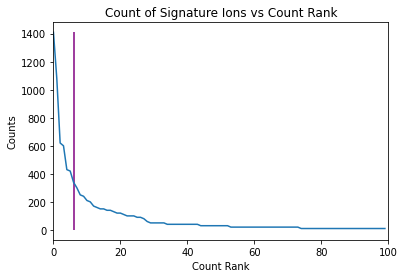

In [140]:
#plot showing the frequency of mz versus
plt.plot(df_sum_sort['count'])
plt.vlines(x = my_index, ymin = 0, ymax = my_max,
           colors = 'purple',
           label = 'vline_multiple - full height')
plt.xlim([0, 100])
plt.title('Count of Signature Ions vs Count Rank')
plt.xlabel('Count Rank')
plt.ylabel('Counts');

In [141]:
# naming top signature ions and selecting ion indecies
sig_ion1 = df_sum_sort.iloc[0,0]
display(sig_ion1)
sig_ion2 = df_sum_sort.iloc[1,0]
display(sig_ion2)
sig_ion3 = df_sum_sort.iloc[2,0]
display(sig_ion3)
sig_ion4 = df_sum_sort.iloc[3,0]
display(sig_ion4)
sig_ion5 = df_sum_sort.iloc[4,0]
display(sig_ion5)
sig_ion6 = df_sum_sort.iloc[5,0]
display(sig_ion6)
sig_ion7 = df_sum_sort.iloc[6,0]
display(sig_ion7)
sig_ion8 = df_sum_sort.iloc[7,0]
display(sig_ion8)
sig_ion9 = df_sum_sort.iloc[8,0]
display(sig_ion9)
sig_ion10 = df_sum_sort.iloc[9,0]
display(sig_ion10)
sig_ion11 = df_sum_sort.iloc[10,0]
display(sig_ion11)
sig_ion12 = df_sum_sort.iloc[11,0]
display(sig_ion12)
sig_ion13 = df_sum_sort.iloc[12,0]
display(sig_ion13)
sig_ion14 = df_sum_sort.iloc[13,0]
display(sig_ion14)
sig_ion15 = df_sum_sort.iloc[14,0]
display(sig_ion15)
col_sel1 = [sig_ion1, sig_ion2, sig_ion3]
col_sel2 = [sig_ion1, sig_ion2, sig_ion3, sig_ion4, sig_ion5, sig_ion6]
col_sel3 = [sig_ion1, sig_ion2, sig_ion3, sig_ion4, sig_ion5, sig_ion6, sig_ion7, sig_ion8, sig_ion9]
col_sel4 = [sig_ion1, sig_ion2, sig_ion3, sig_ion4, sig_ion5, sig_ion6, sig_ion7, sig_ion8, sig_ion9, sig_ion10, sig_ion11, sig_ion12]
col_sel5 = [sig_ion1, sig_ion2, sig_ion3, sig_ion4, sig_ion5, sig_ion6, sig_ion7, sig_ion8, sig_ion9, sig_ion10, sig_ion11, sig_ion12, sig_ion13, sig_ion14, sig_ion15]

'109mz_Inten'

'136mz_Inten'

'98mz_Inten'

'142mz_Inten'

'114mz_Inten'

'90mz_Inten'

'94mz_Inten'

'70mz_Inten'

'81mz_Inten'

'126mz_Inten'

'100mz_Inten'

'110mz_Inten'

'61mz_Inten'

'69mz_Inten'

'99mz_Inten'

In [142]:
# extracting only columns with signature ions based on selected ion
if my_num == 1:
  df_signatures = pd.DataFrame(mz_int_fin_df2[mz_int_fin_df2.columns[mz_int_fin_df2.columns.isin(col_sel1)]])
  df_signatures['Select'] = (df_signatures.sum(axis=1) > 0)
  df_select = pd.DataFrame(df_signatures['Select'])
  df_select
elif my_num == 2:
  df_signatures = pd.DataFrame(mz_int_fin_df2[mz_int_fin_df2.columns[mz_int_fin_df2.columns.isin(col_sel2)]])
  df_signatures['Select'] = (df_signatures.sum(axis=1) > 0)
  df_select = pd.DataFrame(df_signatures['Select'])
  df_select
elif my_num == 3:
  df_signatures = pd.DataFrame(mz_int_fin_df2[mz_int_fin_df2.columns[mz_int_fin_df2.columns.isin(col_sel3)]])
  df_signatures['Select'] = (df_signatures.sum(axis=1) > 0)
  df_select = pd.DataFrame(df_signatures['Select'])
  df_select
elif my_num == 4:
  df_signatures = pd.DataFrame(mz_int_fin_df2[mz_int_fin_df2.columns[mz_int_fin_df2.columns.isin(col_sel4)]])
  df_signatures['Select'] = (df_signatures.sum(axis=1) > 0)
  df_select = pd.DataFrame(df_signatures['Select'])
  df_select
else:
  df_signatures = pd.DataFrame(mz_int_fin_df2[mz_int_fin_df2.columns[mz_int_fin_df2.columns.isin(col_sel5)]])
  df_signatures['Select'] = (df_signatures.sum(axis=1) > 0)
  df_select = pd.DataFrame(df_signatures['Select'])
  df_select

display(df_select.head())
display(df_select.shape)

,Select
0,True
1,True
2,True
3,True
4,True


(45, 1)

In [143]:
# Filtering out minimum ion masses
min_mz = M/4

txt_meta_df_sel2 = pd.DataFrame(txt_meta_select_df2['Selected_Ion_MZ'])
txt_meta_df_sel2 = txt_meta_df_sel2.astype(float)
txt_meta_df_sel3 = list(txt_meta_df_sel2['Selected_Ion_MZ'])
txt_meta_df_sel3 = [float(x) for x in txt_meta_df_sel3]
test_l = []
for i in txt_meta_df_sel3:
  if i > min_mz:
    x = True
    test_l.append(x)
  else:
    x = False
    test_l.append(x)

df_select2 = pd.DataFrame(test_l)
df_select2.columns = {'Select2'}
df_select2.reset_index(inplace=True, drop=True)
display(df_select2.head())
display(df_select2.shape)

,Select2
0,True
1,True
2,True
3,True
4,True


(45, 1)

In [144]:
# filter out unknown adducts
adduct_df_sel = pd.DataFrame(adduct_df['Multimer'])
df_select3 = adduct_df_sel != 'unknown'
df_select3.columns = {'Select3'}

#calculate the sum of df_sel3_sum if True values are converted to 1
df_sel3_sum = (df_select3*1).sum()
df_sel3_sum = int(df_sel3_sum)

#if there are no select ions that match the calculated adducts, then it will return all columns that pass Select1 and Select2 filters
if df_sel3_sum == 0:
  df_select3 = pd.DataFrame(df_select3 + 1)
  df_select3 = df_select3.where(df_select3 == 1).astype(bool)
else:
  df_select3 = pd.DataFrame(df_select3)

display(df_select3.head(10))
display(df_select3.shape)

,Select3
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True
9,False


(45, 1)

In [145]:
# Identify atoms in chemical formula
import re
my_str = my_dict['Formula']
my_nums = r'[0,1,2,3,4,5,6,7,8,9]'
filtered_string = re.sub(my_nums,'', my_str)

# Create function to split atoms in formula into list of atoms
def formula_split(my_form):
    return [char for char in my_form]

formula_chars = formula_split(filtered_string)
formula_chars

['C', 'H', 'N']

In [146]:
# Identifying substring in 'Adduct' to determine atom content
my_adducts = adduct_df['Adduct']
test_ls = []
for j in my_adducts:
  char1 = '-'
  char2 = '+'
  if '[' in j and '-' in j:
    my_chars = j[j.find(char1)+1 : j.find(char2)]
    adduct_chars = my_chars.replace("-","")
    adduct_chars = re.sub(my_nums,'', adduct_chars)
    adduct_chars = formula_split(adduct_chars)
    x = adduct_chars
    test_ls.append(x)
  else:
    x = ['X']
    test_ls.append(x)

In [147]:
# Comparing atom content between adduct and chemical formula to formulate True False list
TF_list = []
for i in test_ls:
  List1 = formula_chars
  List2 = i
  if List2 == ['X']:
    x = True
    TF_list.append(x)
  elif all(item in List1 for item in List2):
    x = True
    TF_list.append(x)
  else:
    x = False
    TF_list.append(x)

In [148]:
# Applied filter for True/False list of atom comparisons between chemical formula and adducts
df_select4 = pd.DataFrame(TF_list)
df_select4.columns=(['Select4'])
df_select4.head()

,Select4
0,True
1,True
2,True
3,False
4,False


## Create user defined metadata dataframe with same length as filtered MS/MS data

In [149]:
# Create dataframe from dictionary and make keys, index in dataframe
full_df = pd.DataFrame.from_dict(my_dict, orient='index')

In [150]:
# Transpose the full_df dataframe to make index the columns
full_df_t = full_df.transpose()
display(full_df_t.head())
display(full_df_t.shape)

,Compound_Name,Synonyms,Sequence,Pubchem,CAS,Canonical_SMILES,Isomeric_SMILES,INCHI,INCHIKEY,Institution,...,MS_Level,Organism,Natural_Product,Type,Class,Activity,Formula,MW,Exact_Mass,ML_Target
0,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,2,NaN,False,Antimetabolite,Purine,Fluorescent,C5H5N5,135.13,135.054495,False


(1, 26)

In [151]:
classyfire_id_list = ['CHEMONTID:0000000','CHEMONTID:0000001','CHEMONTID:0000002','CHEMONTID:0000004','CHEMONTID:0000012','CHEMONTID:0000016','CHEMONTID:0002448','CHEMONTID:0000261','CHEMONTID:0000264','CHEMONTID:0000279','CHEMONTID:0003865','CHEMONTID:0000267','CHEMONTID:0000462','CHEMONTID:0004707','CHEMONTID:0000289','CHEMONTID:0004603','CHEMONTID:0000400','CHEMONTID:0000422','CHEMONTID:0000423','CHEMONTID:0000424','CHEMONTID:0001568','CHEMONTID:0001392','CHEMONTID:0003297','CHEMONTID:0004150','CHEMONTID:0002837','CHEMONTID:0003608','CHEMONTID:0003609','CHEMONTID:0003610','CHEMONTID:0003629','CHEMONTID:0003630','CHEMONTID:0003866','CHEMONTID:0004469','CHEMONTID:0004557','CHEMONTID:0000003','CHEMONTID:0000006','CHEMONTID:0000278','CHEMONTID:0001198','CHEMONTID:0000323','CHEMONTID:0000265','CHEMONTID:0002279','CHEMONTID:0000301','CHEMONTID:0000018','CHEMONTID:0000019','CHEMONTID:0000020','CHEMONTID:0000021','CHEMONTID:0000022','CHEMONTID:0000023','CHEMONTID:0000024','CHEMONTID:0000025','CHEMONTID:0000027','CHEMONTID:0000029','CHEMONTID:0000039','CHEMONTID:0001510','CHEMONTID:0000048','CHEMONTID:0000050','CHEMONTID:0001253','CHEMONTID:0002566','CHEMONTID:0000317','CHEMONTID:0000058','CHEMONTID:0000488','CHEMONTID:0000064','CHEMONTID:0002052','CHEMONTID:0000066','CHEMONTID:0001346','CHEMONTID:0000068','CHEMONTID:0000069','CHEMONTID:0000070','CHEMONTID:0000071','CHEMONTID:0000295','CHEMONTID:0000073','CHEMONTID:0000076','CHEMONTID:0000436','CHEMONTID:0002490','CHEMONTID:0001629','CHEMONTID:0000082','CHEMONTID:0000086','CHEMONTID:0000089','CHEMONTID:0000090','CHEMONTID:0000091','CHEMONTID:0000092','CHEMONTID:0000094','CHEMONTID:0000096','CHEMONTID:0000097','CHEMONTID:0000098','CHEMONTID:0000102','CHEMONTID:0000103','CHEMONTID:0000104','CHEMONTID:0000105','CHEMONTID:0000106','CHEMONTID:0000107','CHEMONTID:0002491','CHEMONTID:0000109','CHEMONTID:0000123','CHEMONTID:0000126','CHEMONTID:0001819','CHEMONTID:0000130','CHEMONTID:0000134','CHEMONTID:0002341','CHEMONTID:0000253','CHEMONTID:0000145','CHEMONTID:0000147','CHEMONTID:0000319','CHEMONTID:0000154','CHEMONTID:0000159','CHEMONTID:0000160','CHEMONTID:0000166','CHEMONTID:0000175','CHEMONTID:0000328','CHEMONTID:0000181','CHEMONTID:0000211','CHEMONTID:0002389','CHEMONTID:0000191','CHEMONTID:0000343','CHEMONTID:0000193','CHEMONTID:0000195','CHEMONTID:0001455','CHEMONTID:0000213','CHEMONTID:0000218','CHEMONTID:0000219','CHEMONTID:0000220','CHEMONTID:0000221','CHEMONTID:0000222','CHEMONTID:0000224','CHEMONTID:0000463','CHEMONTID:0000231','CHEMONTID:0000233','CHEMONTID:0000236','CHEMONTID:0000238','CHEMONTID:0000240','CHEMONTID:0000243','CHEMONTID:0000244','CHEMONTID:0001797','CHEMONTID:0000251','CHEMONTID:0000252','CHEMONTID:0000256','CHEMONTID:0000257','CHEMONTID:0000258','CHEMONTID:0000259','CHEMONTID:0003909','CHEMONTID:0000472','CHEMONTID:0000268','CHEMONTID:0000269','CHEMONTID:0004434','CHEMONTID:0000277','CHEMONTID:0000293','CHEMONTID:0000294','CHEMONTID:0000296','CHEMONTID:0000302','CHEMONTID:0000304','CHEMONTID:0000305','CHEMONTID:0000307','CHEMONTID:0000309','CHEMONTID:0000311','CHEMONTID:0000312','CHEMONTID:0000313','CHEMONTID:0000314','CHEMONTID:0000315','CHEMONTID:0001851','CHEMONTID:0001435','CHEMONTID:0000419','CHEMONTID:0000334','CHEMONTID:0000344','CHEMONTID:0001370','CHEMONTID:0002506','CHEMONTID:0000359','CHEMONTID:0000360','CHEMONTID:0000364','CHEMONTID:0000368','CHEMONTID:0000377','CHEMONTID:0000378','CHEMONTID:0000381','CHEMONTID:0000389','CHEMONTID:0000401','CHEMONTID:0000402','CHEMONTID:0000403','CHEMONTID:0001372','CHEMONTID:0001371','CHEMONTID:0000412','CHEMONTID:0003940','CHEMONTID:0000498','CHEMONTID:0000425','CHEMONTID:0000426','CHEMONTID:0000427','CHEMONTID:0000428','CHEMONTID:0000429','CHEMONTID:0000430','CHEMONTID:0000431','CHEMONTID:0000432','CHEMONTID:0000433','CHEMONTID:0000434','CHEMONTID:0000435','CHEMONTID:0000437','CHEMONTID:0000438','CHEMONTID:0000439','CHEMONTID:0000440','CHEMONTID:0000441','CHEMONTID:0000442','CHEMONTID:0000443','CHEMONTID:0000444','CHEMONTID:0000445','CHEMONTID:0000446','CHEMONTID:0000447','CHEMONTID:0000448','CHEMONTID:0000449','CHEMONTID:0000450','CHEMONTID:0000451','CHEMONTID:0000453','CHEMONTID:0000454','CHEMONTID:0000455','CHEMONTID:0000456','CHEMONTID:0000457','CHEMONTID:0000458','CHEMONTID:0000459','CHEMONTID:0000460','CHEMONTID:0000461','CHEMONTID:0000464','CHEMONTID:0000476','CHEMONTID:0000479','CHEMONTID:0000480','CHEMONTID:0000482','CHEMONTID:0000484','CHEMONTID:0000491','CHEMONTID:0000492','CHEMONTID:0000493','CHEMONTID:0002285','CHEMONTID:0001157','CHEMONTID:0000506','CHEMONTID:0000508','CHEMONTID:0000509','CHEMONTID:0000510','CHEMONTID:0000663','CHEMONTID:0000756','CHEMONTID:0000782','CHEMONTID:0000796','CHEMONTID:0000822','CHEMONTID:0001008','CHEMONTID:0001014','CHEMONTID:0004474','CHEMONTID:0002865','CHEMONTID:0002867','CHEMONTID:0002866','CHEMONTID:0002870','CHEMONTID:0002869','CHEMONTID:0001442','CHEMONTID:0001094','CHEMONTID:0001103','CHEMONTID:0001112','CHEMONTID:0001132','CHEMONTID:0003737','CHEMONTID:0001140','CHEMONTID:0003631','CHEMONTID:0001161','CHEMONTID:0001163','CHEMONTID:0001187','CHEMONTID:0001201','CHEMONTID:0001202','CHEMONTID:0001209','CHEMONTID:0002485','CHEMONTID:0001214','CHEMONTID:0001303','CHEMONTID:0001232','CHEMONTID:0001234','CHEMONTID:0001236','CHEMONTID:0001247','CHEMONTID:0003130','CHEMONTID:0001297','CHEMONTID:0001270','CHEMONTID:0001506','CHEMONTID:0001509','CHEMONTID:0001304','CHEMONTID:0001308','CHEMONTID:0001329','CHEMONTID:0001333','CHEMONTID:0001360','CHEMONTID:0002100','CHEMONTID:0001384','CHEMONTID:0001387','CHEMONTID:0001614','CHEMONTID:0001390','CHEMONTID:0001396','CHEMONTID:0001997','CHEMONTID:0001438','CHEMONTID:0001443','CHEMONTID:0001446','CHEMONTID:0001449','CHEMONTID:0001450','CHEMONTID:0001451','CHEMONTID:0001452','CHEMONTID:0001453','CHEMONTID:0001454','CHEMONTID:0001465','CHEMONTID:0001493','CHEMONTID:0001507','CHEMONTID:0001508','CHEMONTID:0001511','CHEMONTID:0001514','CHEMONTID:0001515','CHEMONTID:0001516','CHEMONTID:0001517','CHEMONTID:0001518','CHEMONTID:0003918','CHEMONTID:0001523','CHEMONTID:0001539','CHEMONTID:0004475','CHEMONTID:0001567','CHEMONTID:0001569','CHEMONTID:0001579','CHEMONTID:0003686','CHEMONTID:0001610','CHEMONTID:0001623','CHEMONTID:0001969','CHEMONTID:0003425','CHEMONTID:0001626','CHEMONTID:0003467','CHEMONTID:0001631','CHEMONTID:0002507','CHEMONTID:0001634','CHEMONTID:0001640','CHEMONTID:0001645','CHEMONTID:0001649','CHEMONTID:0001650','CHEMONTID:0001666','CHEMONTID:0001678','CHEMONTID:0001679','CHEMONTID:0001729','CHEMONTID:0001730','CHEMONTID:0001761','CHEMONTID:0001775','CHEMONTID:0001782','CHEMONTID:0001783','CHEMONTID:0001784','CHEMONTID:0001785','CHEMONTID:0001786','CHEMONTID:0001787','CHEMONTID:0001793','CHEMONTID:0001794','CHEMONTID:0002719','CHEMONTID:0001796','CHEMONTID:0001798','CHEMONTID:0001799','CHEMONTID:0001800','CHEMONTID:0001802','CHEMONTID:0001808','CHEMONTID:0001816','CHEMONTID:0001817','CHEMONTID:0001818','CHEMONTID:0001821','CHEMONTID:0001833','CHEMONTID:0001834','CHEMONTID:0001844','CHEMONTID:0001850','CHEMONTID:0001853','CHEMONTID:0001854','CHEMONTID:0004788','CHEMONTID:0001859','CHEMONTID:0001862','CHEMONTID:0001863','CHEMONTID:0001867','CHEMONTID:0001868','CHEMONTID:0001869','CHEMONTID:0001875','CHEMONTID:0001881','CHEMONTID:0001884','CHEMONTID:0001886','CHEMONTID:0001889','CHEMONTID:0001890','CHEMONTID:0001894','CHEMONTID:0001895','CHEMONTID:0001900','CHEMONTID:0001909','CHEMONTID:0001910','CHEMONTID:0001918','CHEMONTID:0001928','CHEMONTID:0001929','CHEMONTID:0001930','CHEMONTID:0001965','CHEMONTID:0001967','CHEMONTID:0001979','CHEMONTID:0001980','CHEMONTID:0001981','CHEMONTID:0001983','CHEMONTID:0001985','CHEMONTID:0001990','CHEMONTID:0002000','CHEMONTID:0002001','CHEMONTID:0002005','CHEMONTID:0002011','CHEMONTID:0002012','CHEMONTID:0002020','CHEMONTID:0002021','CHEMONTID:0002027','CHEMONTID:0002035','CHEMONTID:0002050','CHEMONTID:0002055','CHEMONTID:0002058','CHEMONTID:0002059','CHEMONTID:0002061','CHEMONTID:0002062','CHEMONTID:0002063','CHEMONTID:0002064','CHEMONTID:0002090','CHEMONTID:0002091','CHEMONTID:0002106','CHEMONTID:0002109','CHEMONTID:0002111','CHEMONTID:0002114','CHEMONTID:0002117','CHEMONTID:0002118','CHEMONTID:0002124','CHEMONTID:0002127','CHEMONTID:0002128','CHEMONTID:0002129','CHEMONTID:0002164','CHEMONTID:0002174','CHEMONTID:0002185','CHEMONTID:0002188','CHEMONTID:0002955','CHEMONTID:0002192','CHEMONTID:0002197','CHEMONTID:0002225','CHEMONTID:0002226','CHEMONTID:0002246','CHEMONTID:0002261','CHEMONTID:0002306','CHEMONTID:0002313','CHEMONTID:0002319','CHEMONTID:0002322','CHEMONTID:0002323','CHEMONTID:0002330','CHEMONTID:0002331','CHEMONTID:0002332','CHEMONTID:0002338','CHEMONTID:0002342','CHEMONTID:0002351','CHEMONTID:0002353','CHEMONTID:0002359','CHEMONTID:0002360','CHEMONTID:0002377','CHEMONTID:0002401','CHEMONTID:0002427','CHEMONTID:0003633','CHEMONTID:0002462','CHEMONTID:0002466','CHEMONTID:0002475','CHEMONTID:0002480','CHEMONTID:0002486','CHEMONTID:0002488','CHEMONTID:0002489','CHEMONTID:0002498','CHEMONTID:0002499','CHEMONTID:0002528','CHEMONTID:0002530','CHEMONTID:0002531','CHEMONTID:0002532','CHEMONTID:0002533','CHEMONTID:0002534','CHEMONTID:0002535','CHEMONTID:0002538','CHEMONTID:0002540','CHEMONTID:0002541','CHEMONTID:0002543','CHEMONTID:0002544','CHEMONTID:0002545','CHEMONTID:0002546','CHEMONTID:0002551','CHEMONTID:0002561','CHEMONTID:0002578','CHEMONTID:0002612','CHEMONTID:0002627','CHEMONTID:0002642','CHEMONTID:0002648','CHEMONTID:0002649','CHEMONTID:0002650','CHEMONTID:0002653','CHEMONTID:0002655','CHEMONTID:0002656','CHEMONTID:0002657','CHEMONTID:0002658','CHEMONTID:0002659','CHEMONTID:0002660','CHEMONTID:0002661','CHEMONTID:0002662','CHEMONTID:0002663','CHEMONTID:0002665','CHEMONTID:0002671','CHEMONTID:0002672','CHEMONTID:0002675','CHEMONTID:0002679','CHEMONTID:0002681','CHEMONTID:0002691','CHEMONTID:0002692','CHEMONTID:0002693','CHEMONTID:0002699','CHEMONTID:0002743','CHEMONTID:0002744','CHEMONTID:0002748','CHEMONTID:0002749','CHEMONTID:0002750','CHEMONTID:0002751','CHEMONTID:0002752','CHEMONTID:0002754','CHEMONTID:0002755','CHEMONTID:0002756','CHEMONTID:0002757','CHEMONTID:0002758','CHEMONTID:0002759','CHEMONTID:0002782','CHEMONTID:0002783','CHEMONTID:0002791','CHEMONTID:0002792','CHEMONTID:0002793','CHEMONTID:0002794','CHEMONTID:0002799','CHEMONTID:0002800','CHEMONTID:0002804','CHEMONTID:0002824','CHEMONTID:0002834','CHEMONTID:0002835','CHEMONTID:0002854','CHEMONTID:0002855','CHEMONTID:0002868','CHEMONTID:0002899','CHEMONTID:0002900','CHEMONTID:0002903','CHEMONTID:0002920','CHEMONTID:0002929','CHEMONTID:0002936','CHEMONTID:0002937','CHEMONTID:0002939','CHEMONTID:0002943','CHEMONTID:0002958','CHEMONTID:0003014','CHEMONTID:0003016','CHEMONTID:0003018','CHEMONTID:0003019','CHEMONTID:0003020','CHEMONTID:0003092','CHEMONTID:0003094','CHEMONTID:0003107','CHEMONTID:0003108','CHEMONTID:0003110','CHEMONTID:0003111','CHEMONTID:0003112','CHEMONTID:0003113','CHEMONTID:0003114','CHEMONTID:0003115','CHEMONTID:0003116','CHEMONTID:0003117','CHEMONTID:0003118','CHEMONTID:0003128','CHEMONTID:0003135','CHEMONTID:0003139','CHEMONTID:0003141','CHEMONTID:0003142','CHEMONTID:0003144','CHEMONTID:0003145','CHEMONTID:0003146','CHEMONTID:0003147','CHEMONTID:0003148','CHEMONTID:0003149','CHEMONTID:0003150','CHEMONTID:0003151','CHEMONTID:0003154','CHEMONTID:0003155','CHEMONTID:0003156','CHEMONTID:0003159','CHEMONTID:0003164','CHEMONTID:0003165','CHEMONTID:0003166','CHEMONTID:0003167','CHEMONTID:0003168','CHEMONTID:0003169','CHEMONTID:0003219','CHEMONTID:0003222','CHEMONTID:0003260','CHEMONTID:0003284','CHEMONTID:0003298','CHEMONTID:0003299','CHEMONTID:0003300','CHEMONTID:0003301','CHEMONTID:0003302','CHEMONTID:0003332','CHEMONTID:0003337','CHEMONTID:0003352','CHEMONTID:0003370','CHEMONTID:0003385','CHEMONTID:0003393','CHEMONTID:0003796','CHEMONTID:0003405','CHEMONTID:0003408','CHEMONTID:0004191','CHEMONTID:0003412','CHEMONTID:0003415','CHEMONTID:0003418','CHEMONTID:0003419','CHEMONTID:0003427','CHEMONTID:0003431','CHEMONTID:0003440','CHEMONTID:0003468','CHEMONTID:0003477','CHEMONTID:0003495','CHEMONTID:0003589','CHEMONTID:0003607','CHEMONTID:0003611','CHEMONTID:0003612','CHEMONTID:0003613','CHEMONTID:0003616','CHEMONTID:0003632','CHEMONTID:0003654','CHEMONTID:0003656','CHEMONTID:0003667','CHEMONTID:0003690','CHEMONTID:0003691','CHEMONTID:0003696','CHEMONTID:0003697','CHEMONTID:0003700','CHEMONTID:0003707','CHEMONTID:0003745','CHEMONTID:0003747','CHEMONTID:0003748','CHEMONTID:0003749','CHEMONTID:0003750','CHEMONTID:0003751','CHEMONTID:0003754','CHEMONTID:0003755','CHEMONTID:0003756','CHEMONTID:0003757','CHEMONTID:0003758','CHEMONTID:0003759','CHEMONTID:0003760','CHEMONTID:0003761','CHEMONTID:0003762','CHEMONTID:0003763','CHEMONTID:0003764','CHEMONTID:0003765','CHEMONTID:0003770','CHEMONTID:0003772','CHEMONTID:0003773','CHEMONTID:0003774','CHEMONTID:0003775','CHEMONTID:0003776','CHEMONTID:0003777','CHEMONTID:0003778','CHEMONTID:0003787','CHEMONTID:0003791','CHEMONTID:0003799','CHEMONTID:0003805','CHEMONTID:0003872','CHEMONTID:0003873','CHEMONTID:0003874','CHEMONTID:0003875','CHEMONTID:0003876','CHEMONTID:0003877','CHEMONTID:0003878','CHEMONTID:0003886','CHEMONTID:0003889','CHEMONTID:0003890','CHEMONTID:0003891','CHEMONTID:0003903','CHEMONTID:0003920','CHEMONTID:0003921','CHEMONTID:0003929','CHEMONTID:0003930','CHEMONTID:0003931','CHEMONTID:0003932','CHEMONTID:0003933','CHEMONTID:0003934','CHEMONTID:0003939','CHEMONTID:0004057','CHEMONTID:0003942','CHEMONTID:0003943','CHEMONTID:0003944','CHEMONTID:0003945','CHEMONTID:0003946','CHEMONTID:0003948','CHEMONTID:0003949','CHEMONTID:0003950','CHEMONTID:0003985','CHEMONTID:0003991','CHEMONTID:0003996','CHEMONTID:0004036','CHEMONTID:0004019','CHEMONTID:0004020','CHEMONTID:0004026','CHEMONTID:0004039','CHEMONTID:0004052','CHEMONTID:0004060','CHEMONTID:0004061','CHEMONTID:0004062','CHEMONTID:0004074','CHEMONTID:0004076','CHEMONTID:0004077','CHEMONTID:0004086','CHEMONTID:0004102','CHEMONTID:0004103','CHEMONTID:0004104','CHEMONTID:0004131','CHEMONTID:0004136','CHEMONTID:0004139','CHEMONTID:0004140','CHEMONTID:0004141','CHEMONTID:0004144','CHEMONTID:0004149','CHEMONTID:0004163','CHEMONTID:0004166','CHEMONTID:0004169','CHEMONTID:0004170','CHEMONTID:0004174','CHEMONTID:0004186','CHEMONTID:0004189','CHEMONTID:0004193','CHEMONTID:0004195','CHEMONTID:0004232','CHEMONTID:0004236','CHEMONTID:0004246','CHEMONTID:0004247','CHEMONTID:0004248','CHEMONTID:0004324','CHEMONTID:0004326','CHEMONTID:0004327','CHEMONTID:0004328','CHEMONTID:0004345','CHEMONTID:0004350','CHEMONTID:0004353','CHEMONTID:0004357','CHEMONTID:0004370','CHEMONTID:0004371','CHEMONTID:0004372','CHEMONTID:0004373','CHEMONTID:0004375','CHEMONTID:0004376','CHEMONTID:0004377','CHEMONTID:0004378','CHEMONTID:0004379','CHEMONTID:0004380','CHEMONTID:0004381','CHEMONTID:0004382','CHEMONTID:0004388','CHEMONTID:0004396','CHEMONTID:0004401','CHEMONTID:0004404','CHEMONTID:0004405','CHEMONTID:0004407','CHEMONTID:0004416','CHEMONTID:0004432','CHEMONTID:0004433','CHEMONTID:0004436','CHEMONTID:0004440','CHEMONTID:0004441','CHEMONTID:0004442','CHEMONTID:0004455','CHEMONTID:0004457','CHEMONTID:0004458','CHEMONTID:0004459','CHEMONTID:0004460','CHEMONTID:0004462','CHEMONTID:0004463','CHEMONTID:0004464','CHEMONTID:0004468','CHEMONTID:0004470','CHEMONTID:0004471','CHEMONTID:0004477','CHEMONTID:0004478','CHEMONTID:0004483','CHEMONTID:0004484','CHEMONTID:0004487','CHEMONTID:0004490','CHEMONTID:0004494','CHEMONTID:0004498','CHEMONTID:0004499','CHEMONTID:0004500','CHEMONTID:0004501','CHEMONTID:0004502','CHEMONTID:0004507','CHEMONTID:0004524','CHEMONTID:0004540','CHEMONTID:0004558','CHEMONTID:0004563','CHEMONTID:0004565','CHEMONTID:0004572','CHEMONTID:0004614','CHEMONTID:0004648','CHEMONTID:0004649','CHEMONTID:0004650','CHEMONTID:0004651','CHEMONTID:0004659','CHEMONTID:0004703','CHEMONTID:0004736','CHEMONTID:0004799','CHEMONTID:0004812','CHEMONTID:0004819','CHEMONTID:0004826','CHEMONTID:0001734','CHEMONTID:0000007','CHEMONTID:0001551','CHEMONTID:0000009','CHEMONTID:0000010','CHEMONTID:0000011','CHEMONTID:0000013','CHEMONTID:0000014','CHEMONTID:0000015','CHEMONTID:0001544','CHEMONTID:0002212','CHEMONTID:0000513','CHEMONTID:0000031','CHEMONTID:0000032','CHEMONTID:0000033','CHEMONTID:0000035','CHEMONTID:0000036','CHEMONTID:0000037','CHEMONTID:0000038','CHEMONTID:0001151','CHEMONTID:0000041','CHEMONTID:0000042','CHEMONTID:0000330','CHEMONTID:0000045','CHEMONTID:0000047','CHEMONTID:0000049','CHEMONTID:0001549','CHEMONTID:0000053','CHEMONTID:0000054','CHEMONTID:0000055','CHEMONTID:0000056','CHEMONTID:0000057','CHEMONTID:0001391','CHEMONTID:0000061','CHEMONTID:0000063','CHEMONTID:0000065','CHEMONTID:0000067','CHEMONTID:0000072','CHEMONTID:0000074','CHEMONTID:0000075','CHEMONTID:0000078','CHEMONTID:0000079','CHEMONTID:0000080','CHEMONTID:0000081','CHEMONTID:0000083','CHEMONTID:0000084','CHEMONTID:0000085','CHEMONTID:0000087','CHEMONTID:0000088','CHEMONTID:0000093','CHEMONTID:0000095','CHEMONTID:0000099','CHEMONTID:0001908','CHEMONTID:0001550','CHEMONTID:0000108','CHEMONTID:0000110','CHEMONTID:0000111','CHEMONTID:0000112','CHEMONTID:0000113','CHEMONTID:0000117','CHEMONTID:0001831','CHEMONTID:0000119','CHEMONTID:0000120','CHEMONTID:0000121','CHEMONTID:0000127','CHEMONTID:0000254','CHEMONTID:0000129','CHEMONTID:0000131','CHEMONTID:0000132','CHEMONTID:0001286','CHEMONTID:0000138','CHEMONTID:0000139','CHEMONTID:0000140','CHEMONTID:0000141','CHEMONTID:0000142','CHEMONTID:0000369','CHEMONTID:0003410','CHEMONTID:0000148','CHEMONTID:0000150','CHEMONTID:0000151','CHEMONTID:0000153','CHEMONTID:0000155','CHEMONTID:0000157','CHEMONTID:0000158','CHEMONTID:0000161','CHEMONTID:0000162','CHEMONTID:0000163','CHEMONTID:0000164','CHEMONTID:0000165','CHEMONTID:0000176','CHEMONTID:0000177','CHEMONTID:0001553','CHEMONTID:0000183','CHEMONTID:0000184','CHEMONTID:0000185','CHEMONTID:0000186','CHEMONTID:0000187','CHEMONTID:0000189','CHEMONTID:0000190','CHEMONTID:0000192','CHEMONTID:0000194','CHEMONTID:0003413','CHEMONTID:0004789','CHEMONTID:0000210','CHEMONTID:0000212','CHEMONTID:0000216','CHEMONTID:0000217','CHEMONTID:0000223','CHEMONTID:0000226','CHEMONTID:0000229','CHEMONTID:0000230','CHEMONTID:0000232','CHEMONTID:0000235','CHEMONTID:0000239','CHEMONTID:0000245','CHEMONTID:0000248','CHEMONTID:0000250','CHEMONTID:0000262','CHEMONTID:0002049','CHEMONTID:0000266','CHEMONTID:0000270','CHEMONTID:0000272','CHEMONTID:0001470','CHEMONTID:0000275','CHEMONTID:0000283','CHEMONTID:0000284','CHEMONTID:0000285','CHEMONTID:0000287','CHEMONTID:0000288','CHEMONTID:0002216','CHEMONTID:0000298','CHEMONTID:0000299','CHEMONTID:0000300','CHEMONTID:0000303','CHEMONTID:0000308','CHEMONTID:0000310','CHEMONTID:0000316','CHEMONTID:0000320','CHEMONTID:0000321','CHEMONTID:0000322','CHEMONTID:0000324','CHEMONTID:0000325','CHEMONTID:0000326','CHEMONTID:0000327','CHEMONTID:0000329','CHEMONTID:0000331','CHEMONTID:0002217','CHEMONTID:0000335','CHEMONTID:0000336','CHEMONTID:0000337','CHEMONTID:0000345','CHEMONTID:0000346','CHEMONTID:0000349','CHEMONTID:0000350','CHEMONTID:0000353','CHEMONTID:0000354','CHEMONTID:0000355','CHEMONTID:0002651','CHEMONTID:0000357','CHEMONTID:0000358','CHEMONTID:0000361','CHEMONTID:0004504','CHEMONTID:0000363','CHEMONTID:0000365','CHEMONTID:0002224','CHEMONTID:0000392','CHEMONTID:0000372','CHEMONTID:0000375','CHEMONTID:0000379','CHEMONTID:0001310','CHEMONTID:0000384','CHEMONTID:0002724','CHEMONTID:0000388','CHEMONTID:0000390','CHEMONTID:0000395','CHEMONTID:0000396','CHEMONTID:0000398','CHEMONTID:0000399','CHEMONTID:0000405','CHEMONTID:0000406','CHEMONTID:0000407','CHEMONTID:0000408','CHEMONTID:0000410','CHEMONTID:0000411','CHEMONTID:0000414','CHEMONTID:0000415','CHEMONTID:0000417','CHEMONTID:0000418','CHEMONTID:0001926','CHEMONTID:0000466','CHEMONTID:0000467','CHEMONTID:0002449','CHEMONTID:0000473','CHEMONTID:0001093','CHEMONTID:0001535','CHEMONTID:0000481','CHEMONTID:0000490','CHEMONTID:0002901','CHEMONTID:0000497','CHEMONTID:0000499','CHEMONTID:0000501','CHEMONTID:0000503','CHEMONTID:0000504','CHEMONTID:0000505','CHEMONTID:0000507','CHEMONTID:0000517','CHEMONTID:0000518','CHEMONTID:0000520','CHEMONTID:0000521','CHEMONTID:0000522','CHEMONTID:0000523','CHEMONTID:0000524','CHEMONTID:0000525','CHEMONTID:0000526','CHEMONTID:0000527','CHEMONTID:0000528','CHEMONTID:0000529','CHEMONTID:0000530','CHEMONTID:0000531','CHEMONTID:0000532','CHEMONTID:0000533','CHEMONTID:0000534','CHEMONTID:0000535','CHEMONTID:0000536','CHEMONTID:0000537','CHEMONTID:0000538','CHEMONTID:0000539','CHEMONTID:0000540','CHEMONTID:0000541','CHEMONTID:0000542','CHEMONTID:0000543','CHEMONTID:0000544','CHEMONTID:0000545','CHEMONTID:0000546','CHEMONTID:0000547','CHEMONTID:0000548','CHEMONTID:0000549','CHEMONTID:0000550','CHEMONTID:0000551','CHEMONTID:0000552','CHEMONTID:0000553','CHEMONTID:0000554','CHEMONTID:0000555','CHEMONTID:0000556','CHEMONTID:0000557','CHEMONTID:0000558','CHEMONTID:0000559','CHEMONTID:0000560','CHEMONTID:0000561','CHEMONTID:0000562','CHEMONTID:0000563','CHEMONTID:0000564','CHEMONTID:0000565','CHEMONTID:0000566','CHEMONTID:0000567','CHEMONTID:0000568','CHEMONTID:0000569','CHEMONTID:0000570','CHEMONTID:0000571','CHEMONTID:0000572','CHEMONTID:0000573','CHEMONTID:0000574','CHEMONTID:0000575','CHEMONTID:0000576','CHEMONTID:0000577','CHEMONTID:0000578','CHEMONTID:0000579','CHEMONTID:0000580','CHEMONTID:0000581','CHEMONTID:0000582','CHEMONTID:0000583','CHEMONTID:0000584','CHEMONTID:0000585','CHEMONTID:0000586','CHEMONTID:0000587','CHEMONTID:0000588','CHEMONTID:0000589','CHEMONTID:0000590','CHEMONTID:0000591','CHEMONTID:0000592','CHEMONTID:0000593','CHEMONTID:0000594','CHEMONTID:0000595','CHEMONTID:0000596','CHEMONTID:0000598','CHEMONTID:0000599','CHEMONTID:0000600','CHEMONTID:0000601','CHEMONTID:0000602','CHEMONTID:0000603','CHEMONTID:0000604','CHEMONTID:0000605','CHEMONTID:0000606','CHEMONTID:0000607','CHEMONTID:0000608','CHEMONTID:0000609','CHEMONTID:0000610','CHEMONTID:0000611','CHEMONTID:0000612','CHEMONTID:0000613','CHEMONTID:0000614','CHEMONTID:0000615','CHEMONTID:0000616','CHEMONTID:0000617','CHEMONTID:0000618','CHEMONTID:0000619','CHEMONTID:0000620','CHEMONTID:0000621','CHEMONTID:0000622','CHEMONTID:0000624','CHEMONTID:0000625','CHEMONTID:0000626','CHEMONTID:0000627','CHEMONTID:0000628','CHEMONTID:0000629','CHEMONTID:0000630','CHEMONTID:0000631','CHEMONTID:0000632','CHEMONTID:0000633','CHEMONTID:0000634','CHEMONTID:0000635','CHEMONTID:0000636','CHEMONTID:0000637','CHEMONTID:0000638','CHEMONTID:0000639','CHEMONTID:0000640','CHEMONTID:0000641','CHEMONTID:0000642','CHEMONTID:0000643','CHEMONTID:0000644','CHEMONTID:0000645','CHEMONTID:0000646','CHEMONTID:0000647','CHEMONTID:0000648','CHEMONTID:0000649','CHEMONTID:0000650','CHEMONTID:0000651','CHEMONTID:0000652','CHEMONTID:0000653','CHEMONTID:0000654','CHEMONTID:0000655','CHEMONTID:0000656','CHEMONTID:0000657','CHEMONTID:0000658','CHEMONTID:0000659','CHEMONTID:0000660','CHEMONTID:0000661','CHEMONTID:0000662','CHEMONTID:0000664','CHEMONTID:0000665','CHEMONTID:0000666','CHEMONTID:0000667','CHEMONTID:0000668','CHEMONTID:0000669','CHEMONTID:0000670','CHEMONTID:0000671','CHEMONTID:0000672','CHEMONTID:0000673','CHEMONTID:0000674','CHEMONTID:0000675','CHEMONTID:0000677','CHEMONTID:0000678','CHEMONTID:0000679','CHEMONTID:0000680','CHEMONTID:0000681','CHEMONTID:0000682','CHEMONTID:0000683','CHEMONTID:0000684','CHEMONTID:0000685','CHEMONTID:0000686','CHEMONTID:0000687','CHEMONTID:0000688','CHEMONTID:0000689','CHEMONTID:0000690','CHEMONTID:0000691','CHEMONTID:0000692','CHEMONTID:0000693','CHEMONTID:0000694','CHEMONTID:0000695','CHEMONTID:0000696','CHEMONTID:0000697','CHEMONTID:0000698','CHEMONTID:0000699','CHEMONTID:0000700','CHEMONTID:0000701','CHEMONTID:0001283','CHEMONTID:0000703','CHEMONTID:0000704','CHEMONTID:0000705','CHEMONTID:0000706','CHEMONTID:0000707','CHEMONTID:0000708','CHEMONTID:0000709','CHEMONTID:0000710','CHEMONTID:0000711','CHEMONTID:0000712','CHEMONTID:0000713','CHEMONTID:0000714','CHEMONTID:0000715','CHEMONTID:0000716','CHEMONTID:0000717','CHEMONTID:0000718','CHEMONTID:0000719','CHEMONTID:0000720','CHEMONTID:0000721','CHEMONTID:0000722','CHEMONTID:0000723','CHEMONTID:0000724','CHEMONTID:0000725','CHEMONTID:0000726','CHEMONTID:0000727','CHEMONTID:0000728','CHEMONTID:0000729','CHEMONTID:0000730','CHEMONTID:0000731','CHEMONTID:0000732','CHEMONTID:0000733','CHEMONTID:0000734','CHEMONTID:0000735','CHEMONTID:0000736','CHEMONTID:0000737','CHEMONTID:0000738','CHEMONTID:0000739','CHEMONTID:0000740','CHEMONTID:0000741','CHEMONTID:0000742','CHEMONTID:0000743','CHEMONTID:0000744','CHEMONTID:0000745','CHEMONTID:0000746','CHEMONTID:0000747','CHEMONTID:0000748','CHEMONTID:0000749','CHEMONTID:0000750','CHEMONTID:0000751','CHEMONTID:0000752','CHEMONTID:0000753','CHEMONTID:0000754','CHEMONTID:0000755','CHEMONTID:0000757','CHEMONTID:0000758','CHEMONTID:0000759','CHEMONTID:0000760','CHEMONTID:0000761','CHEMONTID:0000762','CHEMONTID:0000763','CHEMONTID:0000764','CHEMONTID:0000765','CHEMONTID:0000766','CHEMONTID:0000767','CHEMONTID:0000768','CHEMONTID:0000769','CHEMONTID:0000770','CHEMONTID:0000771','CHEMONTID:0000772','CHEMONTID:0000773','CHEMONTID:0000774','CHEMONTID:0000775','CHEMONTID:0000776','CHEMONTID:0000777','CHEMONTID:0000778','CHEMONTID:0000779','CHEMONTID:0000780','CHEMONTID:0000781','CHEMONTID:0000783','CHEMONTID:0000784','CHEMONTID:0000785','CHEMONTID:0000786','CHEMONTID:0000787','CHEMONTID:0000788','CHEMONTID:0000789','CHEMONTID:0000790','CHEMONTID:0000791','CHEMONTID:0000792','CHEMONTID:0000793','CHEMONTID:0000794','CHEMONTID:0000795','CHEMONTID:0000797','CHEMONTID:0000798','CHEMONTID:0000799','CHEMONTID:0000800','CHEMONTID:0000801','CHEMONTID:0000802','CHEMONTID:0000803','CHEMONTID:0000804','CHEMONTID:0000805','CHEMONTID:0000806','CHEMONTID:0000807','CHEMONTID:0000808','CHEMONTID:0000809','CHEMONTID:0000810','CHEMONTID:0000811','CHEMONTID:0000812','CHEMONTID:0000813','CHEMONTID:0000814','CHEMONTID:0000815','CHEMONTID:0000816','CHEMONTID:0000817','CHEMONTID:0000818','CHEMONTID:0000819','CHEMONTID:0000820','CHEMONTID:0000821','CHEMONTID:0000823','CHEMONTID:0000824','CHEMONTID:0000825','CHEMONTID:0000826','CHEMONTID:0000827','CHEMONTID:0000828','CHEMONTID:0000829','CHEMONTID:0000830','CHEMONTID:0000831','CHEMONTID:0000832','CHEMONTID:0000833','CHEMONTID:0000834','CHEMONTID:0000835','CHEMONTID:0000836','CHEMONTID:0000837','CHEMONTID:0000838','CHEMONTID:0000839','CHEMONTID:0000840','CHEMONTID:0000841','CHEMONTID:0000842','CHEMONTID:0000843','CHEMONTID:0000844','CHEMONTID:0000845','CHEMONTID:0000846','CHEMONTID:0000847','CHEMONTID:0000848','CHEMONTID:0000849','CHEMONTID:0000850','CHEMONTID:0000851','CHEMONTID:0000852','CHEMONTID:0000853','CHEMONTID:0000854','CHEMONTID:0000855','CHEMONTID:0000856','CHEMONTID:0000857','CHEMONTID:0000858','CHEMONTID:0000859','CHEMONTID:0000860','CHEMONTID:0000861','CHEMONTID:0000862','CHEMONTID:0000863','CHEMONTID:0000864','CHEMONTID:0000865','CHEMONTID:0000866','CHEMONTID:0000867','CHEMONTID:0000868','CHEMONTID:0000869','CHEMONTID:0000870','CHEMONTID:0000871','CHEMONTID:0000872','CHEMONTID:0000873','CHEMONTID:0000874','CHEMONTID:0000875','CHEMONTID:0000876','CHEMONTID:0000877','CHEMONTID:0000878','CHEMONTID:0000879','CHEMONTID:0000880','CHEMONTID:0000881','CHEMONTID:0000882','CHEMONTID:0000883','CHEMONTID:0000884','CHEMONTID:0000885','CHEMONTID:0000886','CHEMONTID:0000887','CHEMONTID:0000888','CHEMONTID:0000889','CHEMONTID:0000890','CHEMONTID:0000891','CHEMONTID:0000892','CHEMONTID:0000893','CHEMONTID:0000894','CHEMONTID:0000895','CHEMONTID:0000896','CHEMONTID:0000897','CHEMONTID:0000898','CHEMONTID:0000899','CHEMONTID:0000900','CHEMONTID:0000901','CHEMONTID:0000902','CHEMONTID:0000903','CHEMONTID:0000904','CHEMONTID:0000905','CHEMONTID:0000906','CHEMONTID:0000907','CHEMONTID:0000908','CHEMONTID:0000909','CHEMONTID:0000910','CHEMONTID:0000911','CHEMONTID:0000912','CHEMONTID:0000913','CHEMONTID:0000914','CHEMONTID:0000915','CHEMONTID:0000916','CHEMONTID:0000917','CHEMONTID:0000918','CHEMONTID:0000919','CHEMONTID:0000920','CHEMONTID:0000921','CHEMONTID:0000922','CHEMONTID:0000923','CHEMONTID:0000924','CHEMONTID:0000925','CHEMONTID:0000926','CHEMONTID:0000927','CHEMONTID:0000928','CHEMONTID:0000929','CHEMONTID:0000930','CHEMONTID:0000931','CHEMONTID:0000932','CHEMONTID:0000933','CHEMONTID:0000934','CHEMONTID:0000935','CHEMONTID:0000936','CHEMONTID:0000937','CHEMONTID:0000938','CHEMONTID:0000939','CHEMONTID:0000940','CHEMONTID:0000941','CHEMONTID:0000942','CHEMONTID:0000943','CHEMONTID:0000944','CHEMONTID:0000945','CHEMONTID:0000946','CHEMONTID:0000947','CHEMONTID:0000948','CHEMONTID:0000949','CHEMONTID:0000950','CHEMONTID:0000951','CHEMONTID:0000952','CHEMONTID:0000953','CHEMONTID:0000954','CHEMONTID:0000955','CHEMONTID:0000956','CHEMONTID:0000957','CHEMONTID:0000958','CHEMONTID:0000959','CHEMONTID:0000960','CHEMONTID:0000961','CHEMONTID:0000962','CHEMONTID:0000963','CHEMONTID:0000964','CHEMONTID:0000965','CHEMONTID:0000966','CHEMONTID:0000967','CHEMONTID:0000968','CHEMONTID:0000969','CHEMONTID:0000970','CHEMONTID:0000971','CHEMONTID:0000972','CHEMONTID:0000973','CHEMONTID:0000974','CHEMONTID:0000975','CHEMONTID:0000976','CHEMONTID:0000977','CHEMONTID:0000978','CHEMONTID:0000979','CHEMONTID:0000980','CHEMONTID:0000981','CHEMONTID:0000982','CHEMONTID:0000983','CHEMONTID:0000984','CHEMONTID:0000985','CHEMONTID:0000986','CHEMONTID:0000987','CHEMONTID:0000988','CHEMONTID:0000989','CHEMONTID:0000990','CHEMONTID:0000991','CHEMONTID:0000992','CHEMONTID:0000993','CHEMONTID:0000994','CHEMONTID:0000995','CHEMONTID:0000996','CHEMONTID:0000997','CHEMONTID:0000998','CHEMONTID:0000999','CHEMONTID:0001000','CHEMONTID:0001001','CHEMONTID:0001002','CHEMONTID:0001003','CHEMONTID:0001004','CHEMONTID:0001005','CHEMONTID:0001006','CHEMONTID:0001013','CHEMONTID:0001016','CHEMONTID:0001017','CHEMONTID:0001022','CHEMONTID:0001023','CHEMONTID:0001024','CHEMONTID:0001025','CHEMONTID:0001026','CHEMONTID:0001027','CHEMONTID:0001028','CHEMONTID:0001029','CHEMONTID:0001030','CHEMONTID:0001031','CHEMONTID:0001032','CHEMONTID:0001033','CHEMONTID:0001034','CHEMONTID:0001035','CHEMONTID:0001036','CHEMONTID:0001037','CHEMONTID:0001038','CHEMONTID:0001039','CHEMONTID:0001040','CHEMONTID:0001041','CHEMONTID:0001042','CHEMONTID:0001043','CHEMONTID:0001044','CHEMONTID:0001048','CHEMONTID:0001049','CHEMONTID:0001050','CHEMONTID:0001051','CHEMONTID:0001052','CHEMONTID:0001053','CHEMONTID:0001055','CHEMONTID:0001056','CHEMONTID:0001057','CHEMONTID:0001058','CHEMONTID:0001059','CHEMONTID:0001060','CHEMONTID:0001061','CHEMONTID:0001062','CHEMONTID:0001063','CHEMONTID:0001064','CHEMONTID:0001065','CHEMONTID:0001066','CHEMONTID:0001067','CHEMONTID:0001068','CHEMONTID:0001069','CHEMONTID:0001070','CHEMONTID:0001071','CHEMONTID:0001072','CHEMONTID:0001073','CHEMONTID:0001074','CHEMONTID:0001075','CHEMONTID:0001076','CHEMONTID:0001077','CHEMONTID:0001078','CHEMONTID:0001079','CHEMONTID:0001080','CHEMONTID:0001081','CHEMONTID:0001082','CHEMONTID:0001083','CHEMONTID:0001084','CHEMONTID:0001085','CHEMONTID:0001086','CHEMONTID:0001087','CHEMONTID:0003327','CHEMONTID:0001091','CHEMONTID:0001097','CHEMONTID:0001578','CHEMONTID:0001111','CHEMONTID:0001113','CHEMONTID:0001114','CHEMONTID:0001115','CHEMONTID:0001116','CHEMONTID:0001123','CHEMONTID:0001445','CHEMONTID:0001125','CHEMONTID:0003491','CHEMONTID:0003809','CHEMONTID:0003392','CHEMONTID:0003808','CHEMONTID:0001134','CHEMONTID:0003815','CHEMONTID:0001615','CHEMONTID:0001137','CHEMONTID:0002220','CHEMONTID:0001142','CHEMONTID:0001146','CHEMONTID:0001152','CHEMONTID:0001153','CHEMONTID:0001154','CHEMONTID:0001155','CHEMONTID:0001156','CHEMONTID:0001158','CHEMONTID:0001168','CHEMONTID:0001169','CHEMONTID:0001172','CHEMONTID:0001173','CHEMONTID:0001174','CHEMONTID:0001175','CHEMONTID:0001176','CHEMONTID:0001177','CHEMONTID:0001180','CHEMONTID:0001181','CHEMONTID:0001182','CHEMONTID:0001183','CHEMONTID:0003455','CHEMONTID:0001186','CHEMONTID:0001188','CHEMONTID:0001368','CHEMONTID:0001672','CHEMONTID:0001194','CHEMONTID:0001199','CHEMONTID:0001200','CHEMONTID:0001204','CHEMONTID:0001205','CHEMONTID:0001206','CHEMONTID:0001212','CHEMONTID:0001213','CHEMONTID:0001219','CHEMONTID:0001220','CHEMONTID:0001222','CHEMONTID:0001230','CHEMONTID:0002484','CHEMONTID:0003389','CHEMONTID:0001235','CHEMONTID:0001237','CHEMONTID:0001241','CHEMONTID:0001243','CHEMONTID:0001244','CHEMONTID:0001245','CHEMONTID:0001246','CHEMONTID:0001290','CHEMONTID:0002214','CHEMONTID:0001263','CHEMONTID:0001257','CHEMONTID:0001259','CHEMONTID:0001260','CHEMONTID:0001261','CHEMONTID:0001265','CHEMONTID:0001268','CHEMONTID:0001269','CHEMONTID:0001272','CHEMONTID:0001276','CHEMONTID:0001554','CHEMONTID:0001278','CHEMONTID:0001279','CHEMONTID:0002213','CHEMONTID:0001293','CHEMONTID:0001295','CHEMONTID:0001296','CHEMONTID:0001300','CHEMONTID:0001302','CHEMONTID:0001306','CHEMONTID:0001307','CHEMONTID:0001309','CHEMONTID:0001311','CHEMONTID:0001312','CHEMONTID:0001313','CHEMONTID:0001314','CHEMONTID:0001315','CHEMONTID:0001316','CHEMONTID:0001317','CHEMONTID:0001322','CHEMONTID:0001323','CHEMONTID:0001325','CHEMONTID:0001331','CHEMONTID:0001332','CHEMONTID:0001334','CHEMONTID:0001335','CHEMONTID:0001336','CHEMONTID:0001337','CHEMONTID:0001338','CHEMONTID:0001339','CHEMONTID:0001340','CHEMONTID:0001341','CHEMONTID:0001342','CHEMONTID:0001343','CHEMONTID:0002219','CHEMONTID:0001347','CHEMONTID:0001348','CHEMONTID:0001349','CHEMONTID:0001352','CHEMONTID:0001353','CHEMONTID:0001354','CHEMONTID:0001359','CHEMONTID:0001364','CHEMONTID:0001365','CHEMONTID:0002218','CHEMONTID:0001369','CHEMONTID:0001379','CHEMONTID:0001382','CHEMONTID:0001383','CHEMONTID:0001385','CHEMONTID:0001386','CHEMONTID:0003258','CHEMONTID:0001389','CHEMONTID:0002215','CHEMONTID:0001398','CHEMONTID:0003567','CHEMONTID:0001412','CHEMONTID:0001415','CHEMONTID:0001416','CHEMONTID:0001420','CHEMONTID:0001418','CHEMONTID:0001424','CHEMONTID:0003807','CHEMONTID:0001434','CHEMONTID:0001437','CHEMONTID:0001444','CHEMONTID:0004758','CHEMONTID:0001459','CHEMONTID:0001460','CHEMONTID:0001766','CHEMONTID:0001464','CHEMONTID:0001466','CHEMONTID:0003568','CHEMONTID:0003569','CHEMONTID:0003566','CHEMONTID:0001691','CHEMONTID:0001491','CHEMONTID:0001492','CHEMONTID:0001512','CHEMONTID:0001513','CHEMONTID:0001519','CHEMONTID:0001520','CHEMONTID:0001521','CHEMONTID:0001522','CHEMONTID:0001524','CHEMONTID:0001526','CHEMONTID:0001527','CHEMONTID:0001529','CHEMONTID:0001530','CHEMONTID:0001534','CHEMONTID:0001536','CHEMONTID:0001548','CHEMONTID:0001552','CHEMONTID:0001566','CHEMONTID:0001570','CHEMONTID:0001571','CHEMONTID:0001572','CHEMONTID:0001573','CHEMONTID:0001574','CHEMONTID:0001606','CHEMONTID:0001577','CHEMONTID:0001581','CHEMONTID:0001586','CHEMONTID:0001589','CHEMONTID:0001590','CHEMONTID:0001591','CHEMONTID:0001592','CHEMONTID:0001593','CHEMONTID:0001602','CHEMONTID:0001604','CHEMONTID:0001607','CHEMONTID:0002617','CHEMONTID:0001611','CHEMONTID:0001612','CHEMONTID:0001616','CHEMONTID:0002147','CHEMONTID:0001624','CHEMONTID:0001625','CHEMONTID:0001630','CHEMONTID:0001633','CHEMONTID:0001636','CHEMONTID:0001641','CHEMONTID:0001642','CHEMONTID:0001652','CHEMONTID:0001655','CHEMONTID:0001665','CHEMONTID:0001667','CHEMONTID:0001668','CHEMONTID:0001671','CHEMONTID:0001674','CHEMONTID:0001686','CHEMONTID:0001690','CHEMONTID:0001692','CHEMONTID:0001693','CHEMONTID:0001700','CHEMONTID:0001701','CHEMONTID:0001702','CHEMONTID:0001710','CHEMONTID:0001711','CHEMONTID:0001712','CHEMONTID:0001713','CHEMONTID:0001715','CHEMONTID:0001717','CHEMONTID:0001721','CHEMONTID:0001722','CHEMONTID:0001733','CHEMONTID:0001740','CHEMONTID:0001742','CHEMONTID:0001743','CHEMONTID:0001749','CHEMONTID:0001750','CHEMONTID:0001751','CHEMONTID:0001753','CHEMONTID:0001758','CHEMONTID:0001764','CHEMONTID:0001778','CHEMONTID:0001780','CHEMONTID:0001788','CHEMONTID:0001792','CHEMONTID:0001795','CHEMONTID:0001803','CHEMONTID:0001804','CHEMONTID:0001805','CHEMONTID:0001806','CHEMONTID:0001814','CHEMONTID:0002496','CHEMONTID:0001822','CHEMONTID:0001823','CHEMONTID:0001825','CHEMONTID:0002042','CHEMONTID:0001830','CHEMONTID:0001832','CHEMONTID:0001835','CHEMONTID:0001837','CHEMONTID:0001838','CHEMONTID:0001839','CHEMONTID:0001840','CHEMONTID:0001841','CHEMONTID:0001842','CHEMONTID:0004155','CHEMONTID:0001855','CHEMONTID:0001857','CHEMONTID:0001860','CHEMONTID:0001861','CHEMONTID:0001864','CHEMONTID:0001870','CHEMONTID:0001871','CHEMONTID:0001872','CHEMONTID:0003409','CHEMONTID:0001874','CHEMONTID:0001876','CHEMONTID:0001877','CHEMONTID:0001882','CHEMONTID:0001885','CHEMONTID:0001887','CHEMONTID:0001888','CHEMONTID:0001891','CHEMONTID:0001898','CHEMONTID:0001899','CHEMONTID:0001903','CHEMONTID:0001905','CHEMONTID:0001906','CHEMONTID:0001907','CHEMONTID:0001911','CHEMONTID:0001912','CHEMONTID:0001919','CHEMONTID:0001920','CHEMONTID:0001922','CHEMONTID:0001931','CHEMONTID:0001932','CHEMONTID:0001933','CHEMONTID:0001935','CHEMONTID:0001936','CHEMONTID:0001948','CHEMONTID:0001966','CHEMONTID:0001970','CHEMONTID:0001971','CHEMONTID:0001973','CHEMONTID:0001974','CHEMONTID:0001975','CHEMONTID:0001982','CHEMONTID:0001986','CHEMONTID:0001987','CHEMONTID:0001988','CHEMONTID:0001991','CHEMONTID:0002006','CHEMONTID:0002013','CHEMONTID:0002015','CHEMONTID:0002016','CHEMONTID:0002017','CHEMONTID:0002026','CHEMONTID:0002257','CHEMONTID:0002680','CHEMONTID:0002031','CHEMONTID:0002468','CHEMONTID:0003701','CHEMONTID:0002036','CHEMONTID:0002037','CHEMONTID:0002039','CHEMONTID:0002043','CHEMONTID:0002044','CHEMONTID:0003194','CHEMONTID:0002054','CHEMONTID:0002060','CHEMONTID:0002065','CHEMONTID:0002066','CHEMONTID:0002067','CHEMONTID:0002068','CHEMONTID:0002069','CHEMONTID:0002070','CHEMONTID:0002071','CHEMONTID:0002072','CHEMONTID:0002073','CHEMONTID:0004456','CHEMONTID:0002076','CHEMONTID:0002077','CHEMONTID:0002078','CHEMONTID:0002079','CHEMONTID:0002080','CHEMONTID:0002081','CHEMONTID:0002082','CHEMONTID:0002083','CHEMONTID:0002096','CHEMONTID:0002097','CHEMONTID:0002098','CHEMONTID:0002099','CHEMONTID:0002102','CHEMONTID:0002103','CHEMONTID:0002112','CHEMONTID:0002113','CHEMONTID:0002131','CHEMONTID:0002132','CHEMONTID:0002134','CHEMONTID:0002148','CHEMONTID:0002177','CHEMONTID:0002178','CHEMONTID:0002179','CHEMONTID:0002180','CHEMONTID:0002181','CHEMONTID:0002182','CHEMONTID:0002189','CHEMONTID:0002195','CHEMONTID:0002348','CHEMONTID:0002200','CHEMONTID:0002211','CHEMONTID:0002221','CHEMONTID:0002227','CHEMONTID:0002234','CHEMONTID:0002236','CHEMONTID:0002238','CHEMONTID:0002241','CHEMONTID:0002243','CHEMONTID:0002247','CHEMONTID:0002553','CHEMONTID:0002266','CHEMONTID:0002267','CHEMONTID:0002268','CHEMONTID:0002269','CHEMONTID:0002270','CHEMONTID:0002271','CHEMONTID:0002272','CHEMONTID:0002275','CHEMONTID:0002277','CHEMONTID:0002284','CHEMONTID:0002287','CHEMONTID:0002288','CHEMONTID:0002290','CHEMONTID:0002291','CHEMONTID:0002292','CHEMONTID:0002293','CHEMONTID:0002294','CHEMONTID:0002295','CHEMONTID:0002296','CHEMONTID:0002297','CHEMONTID:0002298','CHEMONTID:0002299','CHEMONTID:0002300','CHEMONTID:0002301','CHEMONTID:0002302','CHEMONTID:0002303','CHEMONTID:0002304','CHEMONTID:0002305','CHEMONTID:0002317','CHEMONTID:0002320','CHEMONTID:0002321','CHEMONTID:0002333','CHEMONTID:0002335','CHEMONTID:0002336','CHEMONTID:0002340','CHEMONTID:0002352','CHEMONTID:0002355','CHEMONTID:0002357','CHEMONTID:0002361','CHEMONTID:0002363','CHEMONTID:0002366','CHEMONTID:0002367','CHEMONTID:0002368','CHEMONTID:0002369','CHEMONTID:0002370','CHEMONTID:0002371','CHEMONTID:0002372','CHEMONTID:0002373','CHEMONTID:0002374','CHEMONTID:0002381','CHEMONTID:0002382','CHEMONTID:0002383','CHEMONTID:0002391','CHEMONTID:0002396','CHEMONTID:0002397','CHEMONTID:0002398','CHEMONTID:0002399','CHEMONTID:0002469','CHEMONTID:0002428','CHEMONTID:0002441','CHEMONTID:0002442','CHEMONTID:0002445','CHEMONTID:0002461','CHEMONTID:0002465','CHEMONTID:0002474','CHEMONTID:0002481','CHEMONTID:0002487','CHEMONTID:0002497','CHEMONTID:0002500','CHEMONTID:0002504','CHEMONTID:0002508','CHEMONTID:0002520','CHEMONTID:0002523','CHEMONTID:0002524','CHEMONTID:0002536','CHEMONTID:0002537','CHEMONTID:0002542','CHEMONTID:0002552','CHEMONTID:0002554','CHEMONTID:0002567','CHEMONTID:0002570','CHEMONTID:0002571','CHEMONTID:0002572','CHEMONTID:0002573','CHEMONTID:0002576','CHEMONTID:0002579','CHEMONTID:0002581','CHEMONTID:0002582','CHEMONTID:0002583','CHEMONTID:0002584','CHEMONTID:0002585','CHEMONTID:0002586','CHEMONTID:0002607','CHEMONTID:0002608','CHEMONTID:0002609','CHEMONTID:0002610','CHEMONTID:0002614','CHEMONTID:0003087','CHEMONTID:0002623','CHEMONTID:0004258','CHEMONTID:0002908','CHEMONTID:0002645','CHEMONTID:0002652','CHEMONTID:0002654','CHEMONTID:0002664','CHEMONTID:0002666','CHEMONTID:0002667','CHEMONTID:0002668','CHEMONTID:0002669','CHEMONTID:0002670','CHEMONTID:0002673','CHEMONTID:0002674','CHEMONTID:0002676','CHEMONTID:0002677','CHEMONTID:0002700','CHEMONTID:0002701','CHEMONTID:0002702','CHEMONTID:0002703','CHEMONTID:0002704','CHEMONTID:0002717','CHEMONTID:0002718','CHEMONTID:0002720','CHEMONTID:0002721','CHEMONTID:0002722','CHEMONTID:0002723','CHEMONTID:0002740','CHEMONTID:0002747','CHEMONTID:0002780','CHEMONTID:0002781','CHEMONTID:0002790','CHEMONTID:0002795','CHEMONTID:0002796','CHEMONTID:0002797','CHEMONTID:0002798','CHEMONTID:0002807','CHEMONTID:0002805','CHEMONTID:0002806','CHEMONTID:0002808','CHEMONTID:0002810','CHEMONTID:0002811','CHEMONTID:0002818','CHEMONTID:0002819','CHEMONTID:0002822','CHEMONTID:0002823','CHEMONTID:0002838','CHEMONTID:0002843','CHEMONTID:0002852','CHEMONTID:0002853','CHEMONTID:0002858','CHEMONTID:0002860','CHEMONTID:0002861','CHEMONTID:0002862','CHEMONTID:0002863','CHEMONTID:0002864','CHEMONTID:0002891','CHEMONTID:0002892','CHEMONTID:0002896','CHEMONTID:0002897','CHEMONTID:0002902','CHEMONTID:0002904','CHEMONTID:0003624','CHEMONTID:0002910','CHEMONTID:0002991','CHEMONTID:0002919','CHEMONTID:0002921','CHEMONTID:0002922','CHEMONTID:0002923','CHEMONTID:0002926','CHEMONTID:0002927','CHEMONTID:0002928','CHEMONTID:0002932','CHEMONTID:0002933','CHEMONTID:0002935','CHEMONTID:0002940','CHEMONTID:0002941','CHEMONTID:0002942','CHEMONTID:0002944','CHEMONTID:0002945','CHEMONTID:0002946','CHEMONTID:0002953','CHEMONTID:0002956','CHEMONTID:0002957','CHEMONTID:0002966','CHEMONTID:0002967','CHEMONTID:0002976','CHEMONTID:0002977','CHEMONTID:0002978','CHEMONTID:0002979','CHEMONTID:0002980','CHEMONTID:0002984','CHEMONTID:0002995','CHEMONTID:0003005','CHEMONTID:0003007','CHEMONTID:0003015','CHEMONTID:0003021','CHEMONTID:0003022','CHEMONTID:0003023','CHEMONTID:0004776','CHEMONTID:0003061','CHEMONTID:0003065','CHEMONTID:0003076','CHEMONTID:0003077','CHEMONTID:0003093','CHEMONTID:0003109','CHEMONTID:0003125','CHEMONTID:0003126','CHEMONTID:0003127','CHEMONTID:0003129','CHEMONTID:0003132','CHEMONTID:0003137','CHEMONTID:0003138','CHEMONTID:0003143','CHEMONTID:0003152','CHEMONTID:0003153','CHEMONTID:0003157','CHEMONTID:0003158','CHEMONTID:0003190','CHEMONTID:0003191','CHEMONTID:0003193','CHEMONTID:0003199','CHEMONTID:0003209','CHEMONTID:0003215','CHEMONTID:0003216','CHEMONTID:0003218','CHEMONTID:0003220','CHEMONTID:0003221','CHEMONTID:0003250','CHEMONTID:0003261','CHEMONTID:0003262','CHEMONTID:0003264','CHEMONTID:0003272','CHEMONTID:0003274','CHEMONTID:0003275','CHEMONTID:0003279','CHEMONTID:0003282','CHEMONTID:0003285','CHEMONTID:0003290','CHEMONTID:0003291','CHEMONTID:0003292','CHEMONTID:0003293','CHEMONTID:0003294','CHEMONTID:0003309','CHEMONTID:0003597','CHEMONTID:0003317','CHEMONTID:0003853','CHEMONTID:0003326','CHEMONTID:0003353','CHEMONTID:0003354','CHEMONTID:0003361','CHEMONTID:0003364','CHEMONTID:0003371','CHEMONTID:0003372','CHEMONTID:0003373','CHEMONTID:0003378','CHEMONTID:0003387','CHEMONTID:0003391','CHEMONTID:0003394','CHEMONTID:0003395','CHEMONTID:0003404','CHEMONTID:0003406','CHEMONTID:0003407','CHEMONTID:0003411','CHEMONTID:0003414','CHEMONTID:0003426','CHEMONTID:0003916','CHEMONTID:0003914','CHEMONTID:0003436','CHEMONTID:0003443','CHEMONTID:0003449','CHEMONTID:0003456','CHEMONTID:0003461','CHEMONTID:0003463','CHEMONTID:0003464','CHEMONTID:0003465','CHEMONTID:0003466','CHEMONTID:0003470','CHEMONTID:0003471','CHEMONTID:0003480','CHEMONTID:0003481','CHEMONTID:0003482','CHEMONTID:0003484','CHEMONTID:0003496','CHEMONTID:0003511','CHEMONTID:0003515','CHEMONTID:0003516','CHEMONTID:0003520','CHEMONTID:0003530','CHEMONTID:0003536','CHEMONTID:0003590','CHEMONTID:0003591','CHEMONTID:0003592','CHEMONTID:0003594','CHEMONTID:0003615','CHEMONTID:0003620','CHEMONTID:0003621','CHEMONTID:0003625','CHEMONTID:0003634','CHEMONTID:0003635','CHEMONTID:0003636','CHEMONTID:0003637','CHEMONTID:0003649','CHEMONTID:0003650','CHEMONTID:0003652','CHEMONTID:0003653','CHEMONTID:0003668','CHEMONTID:0003669','CHEMONTID:0003676','CHEMONTID:0003683','CHEMONTID:0003687','CHEMONTID:0003688','CHEMONTID:0003689','CHEMONTID:0003692','CHEMONTID:0003693','CHEMONTID:0003694','CHEMONTID:0003695','CHEMONTID:0003699','CHEMONTID:0003703','CHEMONTID:0003704','CHEMONTID:0003705','CHEMONTID:0003706','CHEMONTID:0003708','CHEMONTID:0003709','CHEMONTID:0003710','CHEMONTID:0003711','CHEMONTID:0003712','CHEMONTID:0003713','CHEMONTID:0003714','CHEMONTID:0003715','CHEMONTID:0003716','CHEMONTID:0003741','CHEMONTID:0003723','CHEMONTID:0003724','CHEMONTID:0003725','CHEMONTID:0003726','CHEMONTID:0003744','CHEMONTID:0003733','CHEMONTID:0003734','CHEMONTID:0003735','CHEMONTID:0003736','CHEMONTID:0003738','CHEMONTID:0003746','CHEMONTID:0003766','CHEMONTID:0003767','CHEMONTID:0003768','CHEMONTID:0003769','CHEMONTID:0003771','CHEMONTID:0003785','CHEMONTID:0003786','CHEMONTID:0003792','CHEMONTID:0003797','CHEMONTID:0003798','CHEMONTID:0003800','CHEMONTID:0003801','CHEMONTID:0003802','CHEMONTID:0003803','CHEMONTID:0003804','CHEMONTID:0003835','CHEMONTID:0003862','CHEMONTID:0004631','CHEMONTID:0003883','CHEMONTID:0003885','CHEMONTID:0003887','CHEMONTID:0003888','CHEMONTID:0003892','CHEMONTID:0003893','CHEMONTID:0003894','CHEMONTID:0003904','CHEMONTID:0003905','CHEMONTID:0003906','CHEMONTID:0003907','CHEMONTID:0003910','CHEMONTID:0003912','CHEMONTID:0003913','CHEMONTID:0003915','CHEMONTID:0003917','CHEMONTID:0004099','CHEMONTID:0003935','CHEMONTID:0003936','CHEMONTID:0003937','CHEMONTID:0003938','CHEMONTID:0003941','CHEMONTID:0003953','CHEMONTID:0003970','CHEMONTID:0003972','CHEMONTID:0003973','CHEMONTID:0003976','CHEMONTID:0003981','CHEMONTID:0003992','CHEMONTID:0003993','CHEMONTID:0003994','CHEMONTID:0003997','CHEMONTID:0003998','CHEMONTID:0004007','CHEMONTID:0004403','CHEMONTID:0004017','CHEMONTID:0004024','CHEMONTID:0004025','CHEMONTID:0004037','CHEMONTID:0004040','CHEMONTID:0004053','CHEMONTID:0004054','CHEMONTID:0004073','CHEMONTID:0004079','CHEMONTID:0004083','CHEMONTID:0004089','CHEMONTID:0004095','CHEMONTID:0004097','CHEMONTID:0004105','CHEMONTID:0004106','CHEMONTID:0004107','CHEMONTID:0004113','CHEMONTID:0004112','CHEMONTID:0004132','CHEMONTID:0004116','CHEMONTID:0004118','CHEMONTID:0004120','CHEMONTID:0004121','CHEMONTID:0004122','CHEMONTID:0004123','CHEMONTID:0004124','CHEMONTID:0004125','CHEMONTID:0004126','CHEMONTID:0004127','CHEMONTID:0004128','CHEMONTID:0004129','CHEMONTID:0004130','CHEMONTID:0004134','CHEMONTID:0004137','CHEMONTID:0004151','CHEMONTID:0004152','CHEMONTID:0004154','CHEMONTID:0004157','CHEMONTID:0004162','CHEMONTID:0004164','CHEMONTID:0004168','CHEMONTID:0004182','CHEMONTID:0004187','CHEMONTID:0004188','CHEMONTID:0004190','CHEMONTID:0004192','CHEMONTID:0004194','CHEMONTID:0004197','CHEMONTID:0004198','CHEMONTID:0004201','CHEMONTID:0004203','CHEMONTID:0004208','CHEMONTID:0004217','CHEMONTID:0004229','CHEMONTID:0004233','CHEMONTID:0004269','CHEMONTID:0004270','CHEMONTID:0004293','CHEMONTID:0004294','CHEMONTID:0004306','CHEMONTID:0004331','CHEMONTID:0004332','CHEMONTID:0004336','CHEMONTID:0004346','CHEMONTID:0004349','CHEMONTID:0004351','CHEMONTID:0004356','CHEMONTID:0004358','CHEMONTID:0004359','CHEMONTID:0004360','CHEMONTID:0004362','CHEMONTID:0004363','CHEMONTID:0004364','CHEMONTID:0004366','CHEMONTID:0004367','CHEMONTID:0004368','CHEMONTID:0004383','CHEMONTID:0004385','CHEMONTID:0004387','CHEMONTID:0004390','CHEMONTID:0004402','CHEMONTID:0004408','CHEMONTID:0004409','CHEMONTID:0004415','CHEMONTID:0004417','CHEMONTID:0004418','CHEMONTID:0004419','CHEMONTID:0004422','CHEMONTID:0004429','CHEMONTID:0004430','CHEMONTID:0004435','CHEMONTID:0004437','CHEMONTID:0004438','CHEMONTID:0004439','CHEMONTID:0004443','CHEMONTID:0004447','CHEMONTID:0004450','CHEMONTID:0004461','CHEMONTID:0004467','CHEMONTID:0004476','CHEMONTID:0004485','CHEMONTID:0004489','CHEMONTID:0004491','CHEMONTID:0004492','CHEMONTID:0004493','CHEMONTID:0004496','CHEMONTID:0004497','CHEMONTID:0004503','CHEMONTID:0004510','CHEMONTID:0004515','CHEMONTID:0004516','CHEMONTID:0004538','CHEMONTID:0004539','CHEMONTID:0004545','CHEMONTID:0004548','CHEMONTID:0004549','CHEMONTID:0004551','CHEMONTID:0004553','CHEMONTID:0004566','CHEMONTID:0004567','CHEMONTID:0004582','CHEMONTID:0004585','CHEMONTID:0004586','CHEMONTID:0004588','CHEMONTID:0004589','CHEMONTID:0004590','CHEMONTID:0004592','CHEMONTID:0004599','CHEMONTID:0004601','CHEMONTID:0004604','CHEMONTID:0004606','CHEMONTID:0004611','CHEMONTID:0004615','CHEMONTID:0004622','CHEMONTID:0004628','CHEMONTID:0004629','CHEMONTID:0004632','CHEMONTID:0004640','CHEMONTID:0004643','CHEMONTID:0004646','CHEMONTID:0004647','CHEMONTID:0004652','CHEMONTID:0004653','CHEMONTID:0004660','CHEMONTID:0004663','CHEMONTID:0004664','CHEMONTID:0004665','CHEMONTID:0004670','CHEMONTID:0004672','CHEMONTID:0004676','CHEMONTID:0004677','CHEMONTID:0004681','CHEMONTID:0004693','CHEMONTID:0004695','CHEMONTID:0004708','CHEMONTID:0004710','CHEMONTID:0004711','CHEMONTID:0004714','CHEMONTID:0004730','CHEMONTID:0004737','CHEMONTID:0004738','CHEMONTID:0004739','CHEMONTID:0004740','CHEMONTID:0004741','CHEMONTID:0004742','CHEMONTID:0004743','CHEMONTID:0004752','CHEMONTID:0004764','CHEMONTID:0004765','CHEMONTID:0004766','CHEMONTID:0004785','CHEMONTID:0004792','CHEMONTID:0004793','CHEMONTID:0004794','CHEMONTID:0004801','CHEMONTID:0004803','CHEMONTID:0004806','CHEMONTID:0004813','CHEMONTID:0004820','CHEMONTID:0004821','CHEMONTID:0004822','CHEMONTID:0004823','CHEMONTID:0004825','CHEMONTID:0000005','CHEMONTID:0000008','CHEMONTID:0002840','CHEMONTID:0000026','CHEMONTID:0000028','CHEMONTID:0000030','CHEMONTID:0000034','CHEMONTID:0000040','CHEMONTID:0000043','CHEMONTID:0000306','CHEMONTID:0000046','CHEMONTID:0000051','CHEMONTID:0000052','CHEMONTID:0000059','CHEMONTID:0000347','CHEMONTID:0002086','CHEMONTID:0000100','CHEMONTID:0000101','CHEMONTID:0000114','CHEMONTID:0000116','CHEMONTID:0000118','CHEMONTID:0000124','CHEMONTID:0000128','CHEMONTID:0000133','CHEMONTID:0000135','CHEMONTID:0000136','CHEMONTID:0000137','CHEMONTID:0000143','CHEMONTID:0000144','CHEMONTID:0002568','CHEMONTID:0000167','CHEMONTID:0000168','CHEMONTID:0000169','CHEMONTID:0000170','CHEMONTID:0000171','CHEMONTID:0000172','CHEMONTID:0000178','CHEMONTID:0000180','CHEMONTID:0000188','CHEMONTID:0000196','CHEMONTID:0000198','CHEMONTID:0000199','CHEMONTID:0002817','CHEMONTID:0001546','CHEMONTID:0002569','CHEMONTID:0000205','CHEMONTID:0000206','CHEMONTID:0000207','CHEMONTID:0000208','CHEMONTID:0000214','CHEMONTID:0000215','CHEMONTID:0000225','CHEMONTID:0000227','CHEMONTID:0000234','CHEMONTID:0004781','CHEMONTID:0000241','CHEMONTID:0002310','CHEMONTID:0000597','CHEMONTID:0000247','CHEMONTID:0000249','CHEMONTID:0001228','CHEMONTID:0002194','CHEMONTID:0000263','CHEMONTID:0000273','CHEMONTID:0000274','CHEMONTID:0000281','CHEMONTID:0003305','CHEMONTID:0000286','CHEMONTID:0000291','CHEMONTID:0000297','CHEMONTID:0000332','CHEMONTID:0000333','CHEMONTID:0000338','CHEMONTID:0000339','CHEMONTID:0000340','CHEMONTID:0000341','CHEMONTID:0000342','CHEMONTID:0000348','CHEMONTID:0000351','CHEMONTID:0000352','CHEMONTID:0000356','CHEMONTID:0000362','CHEMONTID:0004777','CHEMONTID:0000367','CHEMONTID:0000370','CHEMONTID:0002030','CHEMONTID:0000380','CHEMONTID:0000382','CHEMONTID:0000383','CHEMONTID:0000385','CHEMONTID:0001012','CHEMONTID:0000387','CHEMONTID:0004096','CHEMONTID:0000393','CHEMONTID:0000397','CHEMONTID:0000404','CHEMONTID:0000409','CHEMONTID:0000486','CHEMONTID:0001381','CHEMONTID:0000421','CHEMONTID:0000452','CHEMONTID:0003002','CHEMONTID:0001240','CHEMONTID:0002450','CHEMONTID:0000470','CHEMONTID:0000471','CHEMONTID:0000474','CHEMONTID:0000475','CHEMONTID:0000477','CHEMONTID:0000478','CHEMONTID:0000483','CHEMONTID:0000485','CHEMONTID:0001248','CHEMONTID:0000489','CHEMONTID:0000494','CHEMONTID:0000495','CHEMONTID:0000496','CHEMONTID:0000500','CHEMONTID:0001543','CHEMONTID:0000511','CHEMONTID:0000512','CHEMONTID:0000514','CHEMONTID:0000515','CHEMONTID:0000519','CHEMONTID:0000623','CHEMONTID:0000676','CHEMONTID:0000702','CHEMONTID:0001009','CHEMONTID:0001010','CHEMONTID:0001011','CHEMONTID:0001015','CHEMONTID:0002839','CHEMONTID:0001020','CHEMONTID:0001021','CHEMONTID:0001045','CHEMONTID:0001046','CHEMONTID:0001047','CHEMONTID:0001128','CHEMONTID:0002460','CHEMONTID:0001419','CHEMONTID:0001090','CHEMONTID:0001092','CHEMONTID:0001095','CHEMONTID:0001096','CHEMONTID:0001098','CHEMONTID:0001099','CHEMONTID:0001100','CHEMONTID:0001101','CHEMONTID:0001102','CHEMONTID:0001105','CHEMONTID:0001109','CHEMONTID:0001117','CHEMONTID:0001119','CHEMONTID:0001120','CHEMONTID:0001124','CHEMONTID:0001126','CHEMONTID:0001127','CHEMONTID:0001129','CHEMONTID:0001131','CHEMONTID:0001133','CHEMONTID:0001135','CHEMONTID:0001136','CHEMONTID:0001138','CHEMONTID:0001139','CHEMONTID:0001141','CHEMONTID:0001144','CHEMONTID:0001147','CHEMONTID:0001149','CHEMONTID:0001159','CHEMONTID:0001160','CHEMONTID:0001165','CHEMONTID:0001166','CHEMONTID:0001167','CHEMONTID:0001178','CHEMONTID:0001179','CHEMONTID:0001184','CHEMONTID:0001185','CHEMONTID:0001190','CHEMONTID:0001191','CHEMONTID:0001193','CHEMONTID:0001195','CHEMONTID:0001196','CHEMONTID:0001197','CHEMONTID:0001207','CHEMONTID:0001210','CHEMONTID:0001211','CHEMONTID:0002463','CHEMONTID:0001221','CHEMONTID:0001229','CHEMONTID:0001231','CHEMONTID:0001233','CHEMONTID:0001238','CHEMONTID:0001239','CHEMONTID:0001242','CHEMONTID:0001249','CHEMONTID:0001252','CHEMONTID:0001254','CHEMONTID:0001256','CHEMONTID:0001262','CHEMONTID:0001264','CHEMONTID:0001266','CHEMONTID:0001267','CHEMONTID:0001271','CHEMONTID:0001273','CHEMONTID:0001274','CHEMONTID:0001275','CHEMONTID:0001277','CHEMONTID:0001281','CHEMONTID:0001282','CHEMONTID:0001284','CHEMONTID:0001285','CHEMONTID:0001288','CHEMONTID:0001289','CHEMONTID:0001291','CHEMONTID:0001292','CHEMONTID:0002802','CHEMONTID:0001298','CHEMONTID:0001504','CHEMONTID:0002847','CHEMONTID:0001319','CHEMONTID:0001683','CHEMONTID:0001326','CHEMONTID:0001327','CHEMONTID:0001330','CHEMONTID:0001344','CHEMONTID:0001350','CHEMONTID:0001351','CHEMONTID:0001355','CHEMONTID:0001540','CHEMONTID:0001357','CHEMONTID:0001358','CHEMONTID:0001583','CHEMONTID:0001632','CHEMONTID:0001367','CHEMONTID:0001374','CHEMONTID:0001377','CHEMONTID:0001378','CHEMONTID:0001388','CHEMONTID:0001393','CHEMONTID:0001427','CHEMONTID:0001395','CHEMONTID:0001397','CHEMONTID:0001401','CHEMONTID:0001402','CHEMONTID:0001403','CHEMONTID:0001404','CHEMONTID:0001405','CHEMONTID:0001406','CHEMONTID:0001407','CHEMONTID:0001408','CHEMONTID:0001409','CHEMONTID:0001413','CHEMONTID:0001414','CHEMONTID:0001417','CHEMONTID:0001421','CHEMONTID:0001422','CHEMONTID:0001423','CHEMONTID:0001425','CHEMONTID:0001426','CHEMONTID:0001439','CHEMONTID:0001440','CHEMONTID:0001447','CHEMONTID:0001448','CHEMONTID:0001456','CHEMONTID:0001457','CHEMONTID:0001461','CHEMONTID:0001462','CHEMONTID:0001463','CHEMONTID:0001467','CHEMONTID:0001468','CHEMONTID:0001469','CHEMONTID:0001471','CHEMONTID:0001472','CHEMONTID:0001473','CHEMONTID:0001474','CHEMONTID:0001475','CHEMONTID:0001476','CHEMONTID:0001477','CHEMONTID:0001478','CHEMONTID:0001479','CHEMONTID:0001480','CHEMONTID:0001481','CHEMONTID:0001482','CHEMONTID:0001483','CHEMONTID:0001484','CHEMONTID:0001485','CHEMONTID:0001486','CHEMONTID:0001487','CHEMONTID:0001488','CHEMONTID:0001489','CHEMONTID:0001490','CHEMONTID:0001494','CHEMONTID:0001495','CHEMONTID:0001502','CHEMONTID:0001503','CHEMONTID:0001525','CHEMONTID:0001989','CHEMONTID:0001538','CHEMONTID:0001542','CHEMONTID:0001547','CHEMONTID:0001555','CHEMONTID:0001557','CHEMONTID:0001560','CHEMONTID:0001563','CHEMONTID:0001564','CHEMONTID:0001565','CHEMONTID:0001575','CHEMONTID:0001576','CHEMONTID:0001580','CHEMONTID:0001582','CHEMONTID:0003012','CHEMONTID:0001585','CHEMONTID:0001595','CHEMONTID:0001596','CHEMONTID:0001598','CHEMONTID:0001600','CHEMONTID:0001605','CHEMONTID:0001608','CHEMONTID:0001609','CHEMONTID:0003424','CHEMONTID:0001617','CHEMONTID:0001618','CHEMONTID:0001619','CHEMONTID:0001620','CHEMONTID:0001621','CHEMONTID:0001622','CHEMONTID:0001627','CHEMONTID:0001628','CHEMONTID:0001637','CHEMONTID:0001646','CHEMONTID:0001648','CHEMONTID:0001651','CHEMONTID:0001654','CHEMONTID:0001656','CHEMONTID:0001657','CHEMONTID:0001661','CHEMONTID:0001669','CHEMONTID:0001670','CHEMONTID:0001673','CHEMONTID:0002364','CHEMONTID:0001694','CHEMONTID:0001703','CHEMONTID:0001704','CHEMONTID:0001705','CHEMONTID:0001706','CHEMONTID:0001707','CHEMONTID:0001708','CHEMONTID:0001709','CHEMONTID:0001714','CHEMONTID:0001716','CHEMONTID:0001718','CHEMONTID:0001719','CHEMONTID:0001720','CHEMONTID:0001723','CHEMONTID:0001725','CHEMONTID:0001727','CHEMONTID:0001731','CHEMONTID:0001737','CHEMONTID:0001744','CHEMONTID:0001752','CHEMONTID:0002125','CHEMONTID:0001755','CHEMONTID:0001757','CHEMONTID:0001759','CHEMONTID:0001760','CHEMONTID:0001765','CHEMONTID:0001767','CHEMONTID:0001769','CHEMONTID:0003819','CHEMONTID:0001774','CHEMONTID:0001777','CHEMONTID:0001781','CHEMONTID:0001789','CHEMONTID:0001807','CHEMONTID:0001813','CHEMONTID:0001820','CHEMONTID:0001824','CHEMONTID:0001826','CHEMONTID:0001827','CHEMONTID:0001828','CHEMONTID:0001829','CHEMONTID:0001836','CHEMONTID:0001843','CHEMONTID:0001845','CHEMONTID:0001846','CHEMONTID:0003823','CHEMONTID:0001848','CHEMONTID:0001849','CHEMONTID:0001856','CHEMONTID:0001858','CHEMONTID:0001865','CHEMONTID:0001873','CHEMONTID:0001892','CHEMONTID:0001893','CHEMONTID:0001896','CHEMONTID:0001904','CHEMONTID:0001913','CHEMONTID:0001914','CHEMONTID:0001915','CHEMONTID:0001916','CHEMONTID:0001921','CHEMONTID:0001923','CHEMONTID:0001924','CHEMONTID:0001925','CHEMONTID:0001927','CHEMONTID:0001934','CHEMONTID:0002801','CHEMONTID:0001972','CHEMONTID:0001976','CHEMONTID:0001977','CHEMONTID:0001978','CHEMONTID:0001984','CHEMONTID:0001992','CHEMONTID:0001993','CHEMONTID:0001998','CHEMONTID:0001999','CHEMONTID:0002930','CHEMONTID:0002004','CHEMONTID:0002007','CHEMONTID:0002014','CHEMONTID:0002018','CHEMONTID:0002019','CHEMONTID:0002022','CHEMONTID:0002025','CHEMONTID:0002028','CHEMONTID:0002029','CHEMONTID:0002032','CHEMONTID:0002033','CHEMONTID:0002034','CHEMONTID:0002038','CHEMONTID:0002040','CHEMONTID:0002041','CHEMONTID:0002051','CHEMONTID:0002053','CHEMONTID:0002056','CHEMONTID:0002074','CHEMONTID:0002084','CHEMONTID:0002265','CHEMONTID:0002088','CHEMONTID:0002089','CHEMONTID:0003136','CHEMONTID:0002104','CHEMONTID:0002105','CHEMONTID:0002107','CHEMONTID:0002108','CHEMONTID:0002110','CHEMONTID:0002115','CHEMONTID:0002116','CHEMONTID:0002119','CHEMONTID:0002121','CHEMONTID:0002126','CHEMONTID:0002130','CHEMONTID:0002133','CHEMONTID:0002135','CHEMONTID:0002136','CHEMONTID:0002137','CHEMONTID:0002138','CHEMONTID:0002149','CHEMONTID:0002150','CHEMONTID:0002151','CHEMONTID:0002152','CHEMONTID:0002153','CHEMONTID:0002173','CHEMONTID:0002183','CHEMONTID:0002184','CHEMONTID:0002190','CHEMONTID:0002193','CHEMONTID:0002196','CHEMONTID:0002201','CHEMONTID:0002202','CHEMONTID:0002210','CHEMONTID:0002223','CHEMONTID:0002451','CHEMONTID:0002232','CHEMONTID:0002392','CHEMONTID:0002237','CHEMONTID:0002452','CHEMONTID:0002240','CHEMONTID:0002244','CHEMONTID:0002245','CHEMONTID:0002251','CHEMONTID:0002252','CHEMONTID:0002256','CHEMONTID:0002258','CHEMONTID:0002263','CHEMONTID:0002280','CHEMONTID:0002283','CHEMONTID:0002286','CHEMONTID:0002289','CHEMONTID:0002307','CHEMONTID:0002308','CHEMONTID:0002312','CHEMONTID:0002315','CHEMONTID:0002318','CHEMONTID:0002324','CHEMONTID:0002326','CHEMONTID:0002329','CHEMONTID:0002334','CHEMONTID:0002337','CHEMONTID:0002339','CHEMONTID:0002343','CHEMONTID:0002344','CHEMONTID:0002349','CHEMONTID:0002350','CHEMONTID:0002376','CHEMONTID:0002380','CHEMONTID:0002393','CHEMONTID:0002400','CHEMONTID:0002406','CHEMONTID:0002409','CHEMONTID:0002411','CHEMONTID:0002412','CHEMONTID:0002414','CHEMONTID:0002416','CHEMONTID:0002417','CHEMONTID:0002419','CHEMONTID:0002421','CHEMONTID:0002422','CHEMONTID:0002423','CHEMONTID:0002424','CHEMONTID:0002425','CHEMONTID:0002426','CHEMONTID:0002429','CHEMONTID:0002430','CHEMONTID:0002431','CHEMONTID:0003131','CHEMONTID:0002440','CHEMONTID:0004779','CHEMONTID:0002446','CHEMONTID:0002447','CHEMONTID:0002456','CHEMONTID:0002459','CHEMONTID:0002464','CHEMONTID:0002470','CHEMONTID:0002471','CHEMONTID:0002472','CHEMONTID:0002473','CHEMONTID:0002476','CHEMONTID:0002477','CHEMONTID:0002478','CHEMONTID:0002479','CHEMONTID:0002482','CHEMONTID:0002483','CHEMONTID:0002503','CHEMONTID:0002516','CHEMONTID:0002517','CHEMONTID:0002518','CHEMONTID:0002521','CHEMONTID:0002525','CHEMONTID:0002526','CHEMONTID:0002547','CHEMONTID:0002548','CHEMONTID:0002549','CHEMONTID:0002550','CHEMONTID:0002555','CHEMONTID:0002556','CHEMONTID:0002558','CHEMONTID:0002562','CHEMONTID:0002563','CHEMONTID:0002565','CHEMONTID:0002574','CHEMONTID:0002575','CHEMONTID:0002577','CHEMONTID:0002587','CHEMONTID:0002588','CHEMONTID:0002589','CHEMONTID:0002590','CHEMONTID:0002591','CHEMONTID:0002592','CHEMONTID:0002593','CHEMONTID:0002594','CHEMONTID:0002595','CHEMONTID:0002596','CHEMONTID:0002597','CHEMONTID:0002598','CHEMONTID:0002599','CHEMONTID:0002600','CHEMONTID:0002601','CHEMONTID:0002602','CHEMONTID:0002603','CHEMONTID:0002604','CHEMONTID:0002605','CHEMONTID:0002606','CHEMONTID:0002613','CHEMONTID:0002615','CHEMONTID:0002616','CHEMONTID:0003042','CHEMONTID:0003041','CHEMONTID:0002621','CHEMONTID:0002622','CHEMONTID:0002626','CHEMONTID:0002634','CHEMONTID:0002635','CHEMONTID:0002636','CHEMONTID:0002637','CHEMONTID:0002638','CHEMONTID:0002639','CHEMONTID:0002640','CHEMONTID:0002641','CHEMONTID:0002643','CHEMONTID:0002644','CHEMONTID:0002678','CHEMONTID:0002694','CHEMONTID:0002705','CHEMONTID:0002706','CHEMONTID:0002707','CHEMONTID:0002725','CHEMONTID:0002726','CHEMONTID:0002727','CHEMONTID:0002728','CHEMONTID:0002729','CHEMONTID:0002730','CHEMONTID:0002731','CHEMONTID:0002732','CHEMONTID:0002733','CHEMONTID:0002737','CHEMONTID:0003401','CHEMONTID:0002741','CHEMONTID:0002742','CHEMONTID:0002745','CHEMONTID:0002746','CHEMONTID:0002753','CHEMONTID:0002760','CHEMONTID:0002763','CHEMONTID:0002764','CHEMONTID:0002765','CHEMONTID:0002766','CHEMONTID:0002779','CHEMONTID:0002803','CHEMONTID:0002820','CHEMONTID:0002825','CHEMONTID:0002829','CHEMONTID:0002836','CHEMONTID:0002846','CHEMONTID:0002857','CHEMONTID:0002859','CHEMONTID:0002871','CHEMONTID:0002872','CHEMONTID:0002873','CHEMONTID:0002874','CHEMONTID:0002875','CHEMONTID:0002876','CHEMONTID:0002877','CHEMONTID:0002879','CHEMONTID:0002880','CHEMONTID:0002881','CHEMONTID:0002882','CHEMONTID:0002883','CHEMONTID:0002884','CHEMONTID:0002885','CHEMONTID:0002886','CHEMONTID:0002887','CHEMONTID:0002888','CHEMONTID:0002889','CHEMONTID:0002890','CHEMONTID:0002893','CHEMONTID:0002894','CHEMONTID:0002895','CHEMONTID:0002898','CHEMONTID:0002905','CHEMONTID:0002907','CHEMONTID:0002909','CHEMONTID:0002911','CHEMONTID:0002914','CHEMONTID:0002915','CHEMONTID:0002916','CHEMONTID:0002917','CHEMONTID:0002918','CHEMONTID:0002924','CHEMONTID:0002925','CHEMONTID:0002931','CHEMONTID:0002949','CHEMONTID:0002950','CHEMONTID:0002951','CHEMONTID:0002952','CHEMONTID:0002959','CHEMONTID:0002961','CHEMONTID:0002962','CHEMONTID:0002963','CHEMONTID:0003027','CHEMONTID:0003026','CHEMONTID:0002981','CHEMONTID:0002982','CHEMONTID:0002983','CHEMONTID:0002987','CHEMONTID:0002988','CHEMONTID:0002989','CHEMONTID:0002990','CHEMONTID:0002992','CHEMONTID:0002993','CHEMONTID:0002994','CHEMONTID:0003000','CHEMONTID:0003001','CHEMONTID:0003006','CHEMONTID:0003013','CHEMONTID:0003028','CHEMONTID:0003031','CHEMONTID:0003032','CHEMONTID:0003034','CHEMONTID:0003053','CHEMONTID:0003054','CHEMONTID:0003055','CHEMONTID:0003056','CHEMONTID:0003057','CHEMONTID:0003058','CHEMONTID:0003059','CHEMONTID:0003060','CHEMONTID:0003066','CHEMONTID:0003822','CHEMONTID:0003071','CHEMONTID:0003072','CHEMONTID:0003073','CHEMONTID:0003078','CHEMONTID:0003079','CHEMONTID:0003080','CHEMONTID:0003081','CHEMONTID:0003083','CHEMONTID:0003085','CHEMONTID:0003086','CHEMONTID:0003088','CHEMONTID:0003089','CHEMONTID:0003090','CHEMONTID:0003091','CHEMONTID:0003095','CHEMONTID:0003096','CHEMONTID:0003119','CHEMONTID:0003120','CHEMONTID:0003121','CHEMONTID:0003122','CHEMONTID:0003123','CHEMONTID:0003124','CHEMONTID:0003133','CHEMONTID:0003134','CHEMONTID:0003265','CHEMONTID:0003174','CHEMONTID:0003180','CHEMONTID:0003187','CHEMONTID:0003188','CHEMONTID:0003192','CHEMONTID:0003195','CHEMONTID:0003196','CHEMONTID:0003197','CHEMONTID:0003198','CHEMONTID:0003200','CHEMONTID:0003201','CHEMONTID:0003203','CHEMONTID:0003204','CHEMONTID:0004446','CHEMONTID:0003214','CHEMONTID:0003217','CHEMONTID:0003228','CHEMONTID:0003229','CHEMONTID:0003236','CHEMONTID:0003238','CHEMONTID:0003241','CHEMONTID:0003244','CHEMONTID:0003249','CHEMONTID:0003253','CHEMONTID:0003254','CHEMONTID:0003345','CHEMONTID:0003263','CHEMONTID:0003273','CHEMONTID:0003276','CHEMONTID:0003277','CHEMONTID:0003278','CHEMONTID:0003280','CHEMONTID:0003289','CHEMONTID:0003310','CHEMONTID:0003318','CHEMONTID:0003319','CHEMONTID:0003321','CHEMONTID:0003328','CHEMONTID:0003344','CHEMONTID:0003351','CHEMONTID:0003355','CHEMONTID:0003356','CHEMONTID:0003357','CHEMONTID:0003359','CHEMONTID:0003360','CHEMONTID:0003362','CHEMONTID:0003363','CHEMONTID:0003368','CHEMONTID:0003369','CHEMONTID:0003379','CHEMONTID:0003380','CHEMONTID:0003381','CHEMONTID:0003382','CHEMONTID:0003383','CHEMONTID:0003384','CHEMONTID:0003388','CHEMONTID:0003396','CHEMONTID:0003397','CHEMONTID:0003398','CHEMONTID:0003399','CHEMONTID:0003417','CHEMONTID:0003677','CHEMONTID:0003421','CHEMONTID:0003422','CHEMONTID:0003423','CHEMONTID:0003428','CHEMONTID:0003429','CHEMONTID:0003430','CHEMONTID:0003437','CHEMONTID:0003438','CHEMONTID:0003439','CHEMONTID:0003453','CHEMONTID:0003457','CHEMONTID:0003462','CHEMONTID:0003472','CHEMONTID:0003473','CHEMONTID:0003474','CHEMONTID:0003475','CHEMONTID:0003476','CHEMONTID:0003478','CHEMONTID:0003479','CHEMONTID:0003485','CHEMONTID:0003486','CHEMONTID:0003488','CHEMONTID:0003489','CHEMONTID:0003490','CHEMONTID:0003492','CHEMONTID:0003543','CHEMONTID:0003494','CHEMONTID:0003501','CHEMONTID:0003502','CHEMONTID:0003503','CHEMONTID:0003504','CHEMONTID:0003639','CHEMONTID:0003643','CHEMONTID:0003646','CHEMONTID:0003642','CHEMONTID:0003509','CHEMONTID:0003510','CHEMONTID:0003522','CHEMONTID:0003523','CHEMONTID:0003524','CHEMONTID:0003528','CHEMONTID:0003537','CHEMONTID:0003542','CHEMONTID:0003545','CHEMONTID:0003546','CHEMONTID:0003547','CHEMONTID:0003548','CHEMONTID:0003549','CHEMONTID:0003550','CHEMONTID:0003557','CHEMONTID:0003558','CHEMONTID:0003559','CHEMONTID:0003560','CHEMONTID:0003561','CHEMONTID:0003563','CHEMONTID:0003565','CHEMONTID:0003570','CHEMONTID:0003578','CHEMONTID:0003584','CHEMONTID:0003587','CHEMONTID:0003645','CHEMONTID:0003593','CHEMONTID:0003598','CHEMONTID:0003599','CHEMONTID:0003602','CHEMONTID:0003664','CHEMONTID:0003604','CHEMONTID:0003605','CHEMONTID:0003606','CHEMONTID:0003618','CHEMONTID:0003617','CHEMONTID:0003622','CHEMONTID:0003623','CHEMONTID:0003638','CHEMONTID:0003640','CHEMONTID:0003641','CHEMONTID:0003644','CHEMONTID:0003655','CHEMONTID:0003662','CHEMONTID:0003665','CHEMONTID:0003666','CHEMONTID:0003682','CHEMONTID:0003698','CHEMONTID:0003739','CHEMONTID:0003740','CHEMONTID:0003721','CHEMONTID:0003722','CHEMONTID:0003727','CHEMONTID:0003728','CHEMONTID:0003742','CHEMONTID:0003743','CHEMONTID:0003752','CHEMONTID:0003782','CHEMONTID:0003788','CHEMONTID:0003789','CHEMONTID:0003790','CHEMONTID:0003793','CHEMONTID:0003794','CHEMONTID:0003795','CHEMONTID:0003806','CHEMONTID:0003810','CHEMONTID:0003811','CHEMONTID:0003812','CHEMONTID:0003813','CHEMONTID:0003814','CHEMONTID:0003816','CHEMONTID:0003817','CHEMONTID:0003824','CHEMONTID:0003826','CHEMONTID:0003827','CHEMONTID:0003828','CHEMONTID:0003829','CHEMONTID:0003830','CHEMONTID:0003831','CHEMONTID:0003832','CHEMONTID:0003833','CHEMONTID:0003834','CHEMONTID:0003836','CHEMONTID:0003837','CHEMONTID:0003838','CHEMONTID:0003839','CHEMONTID:0003840','CHEMONTID:0003841','CHEMONTID:0003842','CHEMONTID:0003843','CHEMONTID:0003844','CHEMONTID:0003845','CHEMONTID:0003846','CHEMONTID:0003847','CHEMONTID:0003848','CHEMONTID:0003849','CHEMONTID:0003850','CHEMONTID:0003851','CHEMONTID:0003852','CHEMONTID:0003854','CHEMONTID:0003858','CHEMONTID:0003861','CHEMONTID:0003863','CHEMONTID:0003864','CHEMONTID:0003869','CHEMONTID:0003871','CHEMONTID:0003879','CHEMONTID:0003880','CHEMONTID:0003881','CHEMONTID:0003882','CHEMONTID:0003884','CHEMONTID:0003895','CHEMONTID:0003896','CHEMONTID:0003897','CHEMONTID:0003898','CHEMONTID:0003899','CHEMONTID:0003900','CHEMONTID:0003911','CHEMONTID:0003927','CHEMONTID:0003928','CHEMONTID:0003951','CHEMONTID:0003952','CHEMONTID:0003955','CHEMONTID:0003962','CHEMONTID:0003963','CHEMONTID:0003961','CHEMONTID:0003964','CHEMONTID:0003967','CHEMONTID:0003968','CHEMONTID:0004108','CHEMONTID:0003971','CHEMONTID:0003974','CHEMONTID:0003975','CHEMONTID:0003977','CHEMONTID:0003979','CHEMONTID:0003980','CHEMONTID:0003982','CHEMONTID:0003983','CHEMONTID:0003984','CHEMONTID:0004280','CHEMONTID:0003987','CHEMONTID:0003988','CHEMONTID:0003990','CHEMONTID:0003995','CHEMONTID:0003999','CHEMONTID:0004004','CHEMONTID:0004008','CHEMONTID:0004018','CHEMONTID:0004027','CHEMONTID:0004038','CHEMONTID:0004041','CHEMONTID:0004042','CHEMONTID:0004043','CHEMONTID:0004050','CHEMONTID:0004051','CHEMONTID:0004055','CHEMONTID:0004056','CHEMONTID:0004063','CHEMONTID:0004064','CHEMONTID:0004065','CHEMONTID:0004066','CHEMONTID:0004069','CHEMONTID:0004070','CHEMONTID:0004071','CHEMONTID:0004075','CHEMONTID:0004078','CHEMONTID:0004080','CHEMONTID:0004081','CHEMONTID:0004087','CHEMONTID:0004088','CHEMONTID:0004091','CHEMONTID:0004092','CHEMONTID:0004093','CHEMONTID:0004094','CHEMONTID:0004098','CHEMONTID:0004110','CHEMONTID:0004111','CHEMONTID:0004114','CHEMONTID:0004117','CHEMONTID:0004133','CHEMONTID:0004138','CHEMONTID:0004147','CHEMONTID:0004153','CHEMONTID:0004156','CHEMONTID:0004158','CHEMONTID:0004159','CHEMONTID:0004160','CHEMONTID:0004161','CHEMONTID:0004173','CHEMONTID:0004175','CHEMONTID:0004177','CHEMONTID:0004178','CHEMONTID:0004181','CHEMONTID:0004183','CHEMONTID:0004184','CHEMONTID:0004196','CHEMONTID:0004199','CHEMONTID:0004200','CHEMONTID:0004202','CHEMONTID:0004204','CHEMONTID:0004205','CHEMONTID:0004209','CHEMONTID:0004210','CHEMONTID:0004211','CHEMONTID:0004212','CHEMONTID:0004216','CHEMONTID:0004218','CHEMONTID:0004219','CHEMONTID:0004225','CHEMONTID:0004226','CHEMONTID:0004227','CHEMONTID:0004228','CHEMONTID:0004230','CHEMONTID:0004308','CHEMONTID:0004235','CHEMONTID:0004238','CHEMONTID:0004240','CHEMONTID:0004243','CHEMONTID:0004249','CHEMONTID:0004259','CHEMONTID:0004268','CHEMONTID:0004281','CHEMONTID:0004282','CHEMONTID:0004285','CHEMONTID:0004286','CHEMONTID:0004287','CHEMONTID:0004288','CHEMONTID:0004289','CHEMONTID:0004290','CHEMONTID:0004291','CHEMONTID:0004292','CHEMONTID:0004303','CHEMONTID:0004309','CHEMONTID:0004337','CHEMONTID:0004338','CHEMONTID:0004339','CHEMONTID:0004342','CHEMONTID:0004348','CHEMONTID:0004352','CHEMONTID:0004355','CHEMONTID:0004361','CHEMONTID:0004369','CHEMONTID:0004386','CHEMONTID:0004389','CHEMONTID:0004391','CHEMONTID:0004393','CHEMONTID:0004406','CHEMONTID:0004704','CHEMONTID:0004420','CHEMONTID:0004423','CHEMONTID:0004424','CHEMONTID:0004428','CHEMONTID:0004431','CHEMONTID:0004445','CHEMONTID:0004449','CHEMONTID:0004451','CHEMONTID:0004452','CHEMONTID:0004465','CHEMONTID:0004466','CHEMONTID:0004473','CHEMONTID:0004481','CHEMONTID:0004482','CHEMONTID:0004486','CHEMONTID:0004488','CHEMONTID:0004495','CHEMONTID:0004505','CHEMONTID:0004506','CHEMONTID:0004509','CHEMONTID:0004511','CHEMONTID:0004514','CHEMONTID:0004520','CHEMONTID:0004521','CHEMONTID:0004522','CHEMONTID:0004525','CHEMONTID:0004526','CHEMONTID:0004528','CHEMONTID:0004532','CHEMONTID:0004537','CHEMONTID:0004541','CHEMONTID:0004543','CHEMONTID:0004552','CHEMONTID:0004554','CHEMONTID:0004560','CHEMONTID:0004561','CHEMONTID:0004562','CHEMONTID:0004564','CHEMONTID:0004568','CHEMONTID:0004570','CHEMONTID:0004579','CHEMONTID:0004583','CHEMONTID:0004587','CHEMONTID:0004593','CHEMONTID:0004594','CHEMONTID:0004597','CHEMONTID:0004600','CHEMONTID:0004602','CHEMONTID:0004605','CHEMONTID:0004608','CHEMONTID:0004610','CHEMONTID:0004613','CHEMONTID:0004616','CHEMONTID:0004620','CHEMONTID:0004621','CHEMONTID:0004623','CHEMONTID:0004630','CHEMONTID:0004633','CHEMONTID:0004634','CHEMONTID:0004635','CHEMONTID:0004636','CHEMONTID:0004637','CHEMONTID:0004638','CHEMONTID:0004639','CHEMONTID:0004644','CHEMONTID:0004645','CHEMONTID:0004654','CHEMONTID:0004655','CHEMONTID:0004656','CHEMONTID:0004658','CHEMONTID:0004661','CHEMONTID:0004662','CHEMONTID:0004667','CHEMONTID:0004671','CHEMONTID:0004674','CHEMONTID:0004675','CHEMONTID:0004678','CHEMONTID:0004679','CHEMONTID:0004680','CHEMONTID:0004682','CHEMONTID:0004691','CHEMONTID:0004692','CHEMONTID:0004694','CHEMONTID:0004697','CHEMONTID:0004698','CHEMONTID:0004705','CHEMONTID:0004706','CHEMONTID:0004709','CHEMONTID:0004712','CHEMONTID:0004715','CHEMONTID:0004720','CHEMONTID:0004722','CHEMONTID:0004723','CHEMONTID:0004724','CHEMONTID:0004729','CHEMONTID:0004732','CHEMONTID:0004734','CHEMONTID:0004735','CHEMONTID:0004744','CHEMONTID:0004753','CHEMONTID:0004754','CHEMONTID:0004759','CHEMONTID:0004767','CHEMONTID:0004769','CHEMONTID:0004770','CHEMONTID:0004778','CHEMONTID:0004782','CHEMONTID:0004783','CHEMONTID:0004790','CHEMONTID:0004798','CHEMONTID:0004800','CHEMONTID:0004802','CHEMONTID:0004804','CHEMONTID:0004805','CHEMONTID:0004807','CHEMONTID:0004811','CHEMONTID:0004818','CHEMONTID:0004828','CHEMONTID:0004829','CHEMONTID:0000017','CHEMONTID:0000044','CHEMONTID:0000060','CHEMONTID:0000062','CHEMONTID:0000077','CHEMONTID:0000115','CHEMONTID:0000122','CHEMONTID:0003487','CHEMONTID:0001148','CHEMONTID:0000149','CHEMONTID:0000173','CHEMONTID:0000174','CHEMONTID:0000179','CHEMONTID:0000182','CHEMONTID:0000197','CHEMONTID:0000200','CHEMONTID:0000201','CHEMONTID:0000202','CHEMONTID:0000203','CHEMONTID:0000209','CHEMONTID:0000228','CHEMONTID:0000237','CHEMONTID:0000242','CHEMONTID:0000246','CHEMONTID:0000255','CHEMONTID:0000260','CHEMONTID:0000318','CHEMONTID:0000280','CHEMONTID:0000282','CHEMONTID:0000290','CHEMONTID:0000292','CHEMONTID:0000366','CHEMONTID:0000371','CHEMONTID:0001498','CHEMONTID:0002094','CHEMONTID:0001662','CHEMONTID:0000386','CHEMONTID:0000391','CHEMONTID:0000413','CHEMONTID:0000416','CHEMONTID:0000420','CHEMONTID:0000465','CHEMONTID:0000468','CHEMONTID:0000469','CHEMONTID:0000487','CHEMONTID:0000502','CHEMONTID:0000516','CHEMONTID:0001007','CHEMONTID:0001019','CHEMONTID:0001054','CHEMONTID:0001088','CHEMONTID:0001089','CHEMONTID:0001104','CHEMONTID:0001106','CHEMONTID:0001107','CHEMONTID:0001108','CHEMONTID:0001110','CHEMONTID:0001118','CHEMONTID:0001121','CHEMONTID:0001122','CHEMONTID:0001130','CHEMONTID:0002209','CHEMONTID:0001897','CHEMONTID:0001150','CHEMONTID:0001164','CHEMONTID:0001366','CHEMONTID:0001171','CHEMONTID:0001208','CHEMONTID:0001215','CHEMONTID:0001216','CHEMONTID:0001217','CHEMONTID:0001223','CHEMONTID:0001225','CHEMONTID:0001226','CHEMONTID:0001227','CHEMONTID:0001250','CHEMONTID:0001251','CHEMONTID:0001280','CHEMONTID:0001287','CHEMONTID:0001294','CHEMONTID:0001299','CHEMONTID:0001301','CHEMONTID:0001320','CHEMONTID:0001321','CHEMONTID:0001324','CHEMONTID:0001328','CHEMONTID:0003213','CHEMONTID:0001356','CHEMONTID:0001361','CHEMONTID:0001362','CHEMONTID:0003672','CHEMONTID:0001375','CHEMONTID:0001376','CHEMONTID:0002276','CHEMONTID:0001394','CHEMONTID:0001399','CHEMONTID:0001400','CHEMONTID:0001410','CHEMONTID:0001411','CHEMONTID:0001428','CHEMONTID:0001429','CHEMONTID:0001430','CHEMONTID:0001431','CHEMONTID:0001432','CHEMONTID:0001433','CHEMONTID:0001436','CHEMONTID:0001496','CHEMONTID:0001497','CHEMONTID:0001499','CHEMONTID:0001500','CHEMONTID:0001501','CHEMONTID:0001505','CHEMONTID:0001528','CHEMONTID:0001537','CHEMONTID:0001541','CHEMONTID:0001545','CHEMONTID:0001556','CHEMONTID:0001558','CHEMONTID:0001559','CHEMONTID:0001561','CHEMONTID:0001562','CHEMONTID:0001584','CHEMONTID:0001597','CHEMONTID:0001599','CHEMONTID:0001939','CHEMONTID:0001603','CHEMONTID:0001613','CHEMONTID:0001635','CHEMONTID:0001638','CHEMONTID:0001639','CHEMONTID:0001643','CHEMONTID:0001644','CHEMONTID:0001647','CHEMONTID:0001653','CHEMONTID:0001658','CHEMONTID:0001659','CHEMONTID:0001660','CHEMONTID:0001663','CHEMONTID:0001664','CHEMONTID:0001676','CHEMONTID:0001677','CHEMONTID:0001680','CHEMONTID:0001681','CHEMONTID:0001682','CHEMONTID:0001684','CHEMONTID:0001687','CHEMONTID:0001699','CHEMONTID:0001724','CHEMONTID:0001726','CHEMONTID:0001728','CHEMONTID:0003684','CHEMONTID:0001735','CHEMONTID:0001736','CHEMONTID:0001738','CHEMONTID:0001739','CHEMONTID:0001741','CHEMONTID:0001745','CHEMONTID:0001746','CHEMONTID:0001747','CHEMONTID:0001748','CHEMONTID:0001754','CHEMONTID:0001756','CHEMONTID:0001762','CHEMONTID:0001763','CHEMONTID:0001768','CHEMONTID:0001770','CHEMONTID:0001771','CHEMONTID:0001772','CHEMONTID:0001773','CHEMONTID:0001776','CHEMONTID:0001779','CHEMONTID:0001801','CHEMONTID:0001811','CHEMONTID:0001812','CHEMONTID:0001815','CHEMONTID:0001847','CHEMONTID:0001852','CHEMONTID:0001866','CHEMONTID:0001878','CHEMONTID:0001879','CHEMONTID:0001880','CHEMONTID:0001901','CHEMONTID:0001902','CHEMONTID:0001917','CHEMONTID:0001937','CHEMONTID:0001938','CHEMONTID:0001940','CHEMONTID:0001941','CHEMONTID:0001942','CHEMONTID:0001943','CHEMONTID:0001944','CHEMONTID:0001945','CHEMONTID:0001946','CHEMONTID:0001947','CHEMONTID:0001949','CHEMONTID:0001950','CHEMONTID:0001951','CHEMONTID:0001952','CHEMONTID:0001953','CHEMONTID:0001954','CHEMONTID:0001955','CHEMONTID:0001956','CHEMONTID:0001957','CHEMONTID:0001958','CHEMONTID:0001959','CHEMONTID:0001960','CHEMONTID:0001961','CHEMONTID:0001962','CHEMONTID:0001963','CHEMONTID:0001968','CHEMONTID:0001995','CHEMONTID:0002002','CHEMONTID:0002008','CHEMONTID:0002010','CHEMONTID:0002023','CHEMONTID:0002024','CHEMONTID:0002045','CHEMONTID:0002046','CHEMONTID:0002047','CHEMONTID:0002048','CHEMONTID:0002057','CHEMONTID:0002085','CHEMONTID:0002087','CHEMONTID:0002092','CHEMONTID:0002093','CHEMONTID:0002095','CHEMONTID:0002101','CHEMONTID:0002120','CHEMONTID:0002139','CHEMONTID:0002140','CHEMONTID:0002141','CHEMONTID:0002142','CHEMONTID:0002143','CHEMONTID:0002144','CHEMONTID:0002145','CHEMONTID:0002146','CHEMONTID:0002154','CHEMONTID:0002155','CHEMONTID:0002156','CHEMONTID:0002157','CHEMONTID:0002158','CHEMONTID:0002159','CHEMONTID:0002160','CHEMONTID:0002161','CHEMONTID:0002162','CHEMONTID:0002163','CHEMONTID:0002165','CHEMONTID:0002166','CHEMONTID:0002167','CHEMONTID:0002168','CHEMONTID:0002169','CHEMONTID:0002170','CHEMONTID:0002171','CHEMONTID:0002172','CHEMONTID:0002175','CHEMONTID:0002176','CHEMONTID:0002187','CHEMONTID:0002191','CHEMONTID:0002198','CHEMONTID:0002199','CHEMONTID:0002203','CHEMONTID:0002204','CHEMONTID:0002205','CHEMONTID:0002206','CHEMONTID:0002207','CHEMONTID:0002208','CHEMONTID:0002222','CHEMONTID:0002228','CHEMONTID:0002229','CHEMONTID:0002230','CHEMONTID:0002231','CHEMONTID:0002233','CHEMONTID:0002235','CHEMONTID:0002239','CHEMONTID:0002242','CHEMONTID:0002248','CHEMONTID:0002249','CHEMONTID:0002253','CHEMONTID:0003067','CHEMONTID:0002509','CHEMONTID:0002311','CHEMONTID:0002314','CHEMONTID:0002316','CHEMONTID:0002325','CHEMONTID:0002327','CHEMONTID:0002328','CHEMONTID:0002345','CHEMONTID:0002346','CHEMONTID:0002347','CHEMONTID:0002354','CHEMONTID:0002358','CHEMONTID:0002362','CHEMONTID:0002365','CHEMONTID:0002375','CHEMONTID:0002378','CHEMONTID:0002379','CHEMONTID:0002394','CHEMONTID:0002395','CHEMONTID:0002407','CHEMONTID:0002408','CHEMONTID:0002410','CHEMONTID:0002413','CHEMONTID:0002415','CHEMONTID:0002418','CHEMONTID:0002420','CHEMONTID:0002432','CHEMONTID:0002433','CHEMONTID:0002434','CHEMONTID:0002435','CHEMONTID:0002443','CHEMONTID:0002444','CHEMONTID:0002453','CHEMONTID:0002454','CHEMONTID:0002455','CHEMONTID:0002457','CHEMONTID:0002458','CHEMONTID:0002467','CHEMONTID:0002501','CHEMONTID:0002502','CHEMONTID:0002505','CHEMONTID:0002519','CHEMONTID:0002527','CHEMONTID:0002529','CHEMONTID:0002539','CHEMONTID:0002557','CHEMONTID:0002564','CHEMONTID:0002580','CHEMONTID:0002611','CHEMONTID:0002618','CHEMONTID:0002619','CHEMONTID:0002624','CHEMONTID:0002628','CHEMONTID:0002632','CHEMONTID:0002647','CHEMONTID:0003003','CHEMONTID:0002686','CHEMONTID:0002687','CHEMONTID:0002688','CHEMONTID:0002689','CHEMONTID:0002690','CHEMONTID:0002695','CHEMONTID:0002696','CHEMONTID:0003678','CHEMONTID:0003681','CHEMONTID:0003679','CHEMONTID:0002734','CHEMONTID:0002735','CHEMONTID:0002736','CHEMONTID:0002738','CHEMONTID:0002761','CHEMONTID:0002762','CHEMONTID:0002767','CHEMONTID:0002768','CHEMONTID:0002769','CHEMONTID:0002770','CHEMONTID:0002771','CHEMONTID:0002772','CHEMONTID:0002773','CHEMONTID:0002774','CHEMONTID:0002775','CHEMONTID:0002776','CHEMONTID:0002777','CHEMONTID:0002778','CHEMONTID:0002784','CHEMONTID:0002786','CHEMONTID:0002787','CHEMONTID:0002809','CHEMONTID:0002821','CHEMONTID:0002841','CHEMONTID:0002842','CHEMONTID:0002844','CHEMONTID:0002845','CHEMONTID:0002848','CHEMONTID:0002849','CHEMONTID:0002856','CHEMONTID:0002878','CHEMONTID:0002906','CHEMONTID:0002912','CHEMONTID:0002913','CHEMONTID:0002934','CHEMONTID:0002938','CHEMONTID:0002948','CHEMONTID:0002960','CHEMONTID:0002968','CHEMONTID:0002969','CHEMONTID:0002970','CHEMONTID:0002971','CHEMONTID:0002972','CHEMONTID:0002973','CHEMONTID:0002974','CHEMONTID:0002975','CHEMONTID:0002985','CHEMONTID:0002986','CHEMONTID:0002998','CHEMONTID:0002999','CHEMONTID:0003004','CHEMONTID:0003017','CHEMONTID:0003024','CHEMONTID:0003025','CHEMONTID:0003029','CHEMONTID:0003030','CHEMONTID:0003033','CHEMONTID:0003040','CHEMONTID:0003045','CHEMONTID:0003047','CHEMONTID:0003051','CHEMONTID:0003052','CHEMONTID:0003068','CHEMONTID:0003069','CHEMONTID:0003070','CHEMONTID:0003074','CHEMONTID:0003082','CHEMONTID:0003084','CHEMONTID:0003097','CHEMONTID:0003098','CHEMONTID:0003099','CHEMONTID:0003100','CHEMONTID:0003104','CHEMONTID:0003105','CHEMONTID:0003140','CHEMONTID:0003160','CHEMONTID:0003161','CHEMONTID:0003162','CHEMONTID:0003163','CHEMONTID:0003175','CHEMONTID:0003181','CHEMONTID:0003182','CHEMONTID:0003183','CHEMONTID:0003186','CHEMONTID:0003189','CHEMONTID:0003202','CHEMONTID:0003205','CHEMONTID:0003206','CHEMONTID:0003207','CHEMONTID:0003208','CHEMONTID:0003227','CHEMONTID:0003230','CHEMONTID:0003231','CHEMONTID:0003232','CHEMONTID:0003233','CHEMONTID:0003234','CHEMONTID:0003235','CHEMONTID:0003237','CHEMONTID:0003239','CHEMONTID:0003240','CHEMONTID:0003242','CHEMONTID:0003243','CHEMONTID:0003245','CHEMONTID:0003247','CHEMONTID:0003248','CHEMONTID:0003252','CHEMONTID:0003255','CHEMONTID:0003256','CHEMONTID:0003257','CHEMONTID:0003259','CHEMONTID:0003266','CHEMONTID:0003267','CHEMONTID:0003268','CHEMONTID:0003269','CHEMONTID:0003270','CHEMONTID:0003271','CHEMONTID:0003281','CHEMONTID:0003287','CHEMONTID:0003288','CHEMONTID:0003295','CHEMONTID:0003296','CHEMONTID:0003303','CHEMONTID:0003306','CHEMONTID:0003307','CHEMONTID:0003308','CHEMONTID:0003311','CHEMONTID:0003313','CHEMONTID:0003314','CHEMONTID:0003315','CHEMONTID:0003322','CHEMONTID:0003325','CHEMONTID:0003329','CHEMONTID:0003330','CHEMONTID:0003331','CHEMONTID:0003338','CHEMONTID:0003339','CHEMONTID:0003340','CHEMONTID:0003341','CHEMONTID:0003342','CHEMONTID:0003343','CHEMONTID:0003346','CHEMONTID:0003347','CHEMONTID:0003348','CHEMONTID:0003349','CHEMONTID:0003358','CHEMONTID:0003365','CHEMONTID:0003366','CHEMONTID:0003367','CHEMONTID:0003374','CHEMONTID:0003375','CHEMONTID:0003376','CHEMONTID:0003377','CHEMONTID:0003390','CHEMONTID:0003400','CHEMONTID:0003402','CHEMONTID:0003403','CHEMONTID:0003416','CHEMONTID:0003420','CHEMONTID:0003432','CHEMONTID:0003433','CHEMONTID:0003434','CHEMONTID:0003435','CHEMONTID:0003444','CHEMONTID:0003450','CHEMONTID:0003451','CHEMONTID:0003452','CHEMONTID:0003454','CHEMONTID:0003458','CHEMONTID:0003459','CHEMONTID:0003460','CHEMONTID:0003469','CHEMONTID:0003493','CHEMONTID:0003505','CHEMONTID:0003506','CHEMONTID:0003507','CHEMONTID:0003508','CHEMONTID:0003512','CHEMONTID:0003513','CHEMONTID:0003514','CHEMONTID:0003525','CHEMONTID:0003526','CHEMONTID:0003527','CHEMONTID:0003531','CHEMONTID:0003533','CHEMONTID:0003535','CHEMONTID:0003540','CHEMONTID:0003544','CHEMONTID:0003680','CHEMONTID:0003562','CHEMONTID:0003564','CHEMONTID:0003571','CHEMONTID:0003572','CHEMONTID:0003577','CHEMONTID:0003579','CHEMONTID:0003580','CHEMONTID:0003583','CHEMONTID:0003582','CHEMONTID:0003585','CHEMONTID:0003588','CHEMONTID:0003595','CHEMONTID:0003596','CHEMONTID:0003600','CHEMONTID:0003601','CHEMONTID:0003603','CHEMONTID:0003614','CHEMONTID:0003619','CHEMONTID:0003628','CHEMONTID:0003647','CHEMONTID:0003648','CHEMONTID:0003651','CHEMONTID:0003657','CHEMONTID:0003660','CHEMONTID:0003661','CHEMONTID:0003670','CHEMONTID:0003675','CHEMONTID:0003685','CHEMONTID:0003717','CHEMONTID:0003718','CHEMONTID:0003719','CHEMONTID:0003720','CHEMONTID:0003729','CHEMONTID:0003730','CHEMONTID:0003731','CHEMONTID:0003732','CHEMONTID:0003783','CHEMONTID:0003784','CHEMONTID:0003818','CHEMONTID:0003820','CHEMONTID:0003821','CHEMONTID:0003825','CHEMONTID:0003855','CHEMONTID:0003856','CHEMONTID:0003857','CHEMONTID:0003859','CHEMONTID:0003860','CHEMONTID:0003867','CHEMONTID:0003868','CHEMONTID:0003870','CHEMONTID:0003908','CHEMONTID:0003919','CHEMONTID:0003922','CHEMONTID:0003924','CHEMONTID:0003926','CHEMONTID:0003947','CHEMONTID:0003954','CHEMONTID:0003956','CHEMONTID:0003958','CHEMONTID:0003959','CHEMONTID:0003960','CHEMONTID:0003965','CHEMONTID:0003966','CHEMONTID:0003969','CHEMONTID:0003986','CHEMONTID:0003989','CHEMONTID:0004001','CHEMONTID:0004003','CHEMONTID:0004005','CHEMONTID:0004006','CHEMONTID:0004009','CHEMONTID:0004021','CHEMONTID:0004029','CHEMONTID:0004046','CHEMONTID:0004047','CHEMONTID:0004048','CHEMONTID:0004049','CHEMONTID:0004058','CHEMONTID:0004237','CHEMONTID:0004067','CHEMONTID:0004068','CHEMONTID:0004072','CHEMONTID:0004084','CHEMONTID:0004085','CHEMONTID:0004090','CHEMONTID:0004100','CHEMONTID:0004101','CHEMONTID:0004109','CHEMONTID:0004115','CHEMONTID:0004142','CHEMONTID:0004165','CHEMONTID:0004167','CHEMONTID:0004171','CHEMONTID:0004172','CHEMONTID:0004176','CHEMONTID:0004185','CHEMONTID:0004206','CHEMONTID:0004207','CHEMONTID:0004213','CHEMONTID:0004214','CHEMONTID:0004215','CHEMONTID:0004220','CHEMONTID:0004221','CHEMONTID:0004222','CHEMONTID:0004231','CHEMONTID:0004234','CHEMONTID:0004239','CHEMONTID:0004241','CHEMONTID:0004242','CHEMONTID:0004244','CHEMONTID:0004245','CHEMONTID:0004251','CHEMONTID:0004253','CHEMONTID:0004254','CHEMONTID:0004255','CHEMONTID:0004256','CHEMONTID:0004257','CHEMONTID:0004262','CHEMONTID:0004265','CHEMONTID:0004266','CHEMONTID:0004271','CHEMONTID:0004274','CHEMONTID:0004276','CHEMONTID:0004277','CHEMONTID:0004283','CHEMONTID:0004284','CHEMONTID:0004295','CHEMONTID:0004333','CHEMONTID:0004334','CHEMONTID:0004335','CHEMONTID:0004340','CHEMONTID:0004341','CHEMONTID:0004347','CHEMONTID:0004354','CHEMONTID:0004365','CHEMONTID:0004374','CHEMONTID:0004384','CHEMONTID:0004392','CHEMONTID:0004394','CHEMONTID:0004395','CHEMONTID:0004397','CHEMONTID:0004398','CHEMONTID:0004399','CHEMONTID:0004400','CHEMONTID:0004413','CHEMONTID:0004414','CHEMONTID:0004421','CHEMONTID:0004425','CHEMONTID:0004426','CHEMONTID:0004444','CHEMONTID:0004448','CHEMONTID:0004453','CHEMONTID:0004454','CHEMONTID:0004472','CHEMONTID:0004479','CHEMONTID:0004508','CHEMONTID:0004513','CHEMONTID:0004517','CHEMONTID:0004519','CHEMONTID:0004527','CHEMONTID:0004529','CHEMONTID:0004530','CHEMONTID:0004531','CHEMONTID:0004533','CHEMONTID:0004534','CHEMONTID:0004542','CHEMONTID:0004544','CHEMONTID:0004547','CHEMONTID:0004550','CHEMONTID:0004559','CHEMONTID:0004569','CHEMONTID:0004571','CHEMONTID:0004573','CHEMONTID:0004574','CHEMONTID:0004575','CHEMONTID:0004580','CHEMONTID:0004591','CHEMONTID:0004595','CHEMONTID:0004596','CHEMONTID:0004598','CHEMONTID:0004607','CHEMONTID:0004609','CHEMONTID:0004612','CHEMONTID:0004617','CHEMONTID:0004618','CHEMONTID:0004619','CHEMONTID:0004624','CHEMONTID:0004625','CHEMONTID:0004657','CHEMONTID:0004666','CHEMONTID:0004669','CHEMONTID:0004683','CHEMONTID:0004684','CHEMONTID:0004686','CHEMONTID:0004687','CHEMONTID:0004699','CHEMONTID:0004700','CHEMONTID:0004701','CHEMONTID:0004713','CHEMONTID:0004716','CHEMONTID:0004721','CHEMONTID:0004725','CHEMONTID:0004726','CHEMONTID:0004727','CHEMONTID:0004731','CHEMONTID:0004733','CHEMONTID:0004745','CHEMONTID:0004746','CHEMONTID:0004747','CHEMONTID:0004748','CHEMONTID:0004749','CHEMONTID:0004750','CHEMONTID:0004751','CHEMONTID:0004755','CHEMONTID:0004760','CHEMONTID:0004761','CHEMONTID:0004762','CHEMONTID:0004763','CHEMONTID:0004771','CHEMONTID:0004772','CHEMONTID:0004773','CHEMONTID:0004774','CHEMONTID:0004775','CHEMONTID:0004780','CHEMONTID:0004784','CHEMONTID:0004791','CHEMONTID:0004795','CHEMONTID:0004808','CHEMONTID:0004810','CHEMONTID:0004814','CHEMONTID:0004815','CHEMONTID:0004817','CHEMONTID:0004824','CHEMONTID:0004827','CHEMONTID:0000125','CHEMONTID:0000146','CHEMONTID:0000156','CHEMONTID:0000204','CHEMONTID:0000271','CHEMONTID:0000373','CHEMONTID:0000374','CHEMONTID:0000376','CHEMONTID:0000394','CHEMONTID:0001143','CHEMONTID:0001145','CHEMONTID:0001162','CHEMONTID:0001170','CHEMONTID:0001189','CHEMONTID:0001192','CHEMONTID:0001203','CHEMONTID:0001255','CHEMONTID:0001697','CHEMONTID:0001318','CHEMONTID:0001345','CHEMONTID:0001363','CHEMONTID:0001373','CHEMONTID:0001380','CHEMONTID:0001458','CHEMONTID:0001531','CHEMONTID:0001532','CHEMONTID:0001533','CHEMONTID:0001587','CHEMONTID:0002404','CHEMONTID:0001594','CHEMONTID:0001601','CHEMONTID:0001675','CHEMONTID:0001685','CHEMONTID:0001688','CHEMONTID:0001695','CHEMONTID:0001696','CHEMONTID:0001698','CHEMONTID:0001732','CHEMONTID:0001809','CHEMONTID:0001810','CHEMONTID:0001883','CHEMONTID:0001964','CHEMONTID:0001994','CHEMONTID:0001996','CHEMONTID:0002003','CHEMONTID:0002009','CHEMONTID:0002186','CHEMONTID:0002254','CHEMONTID:0002255','CHEMONTID:0002259','CHEMONTID:0002260','CHEMONTID:0002262','CHEMONTID:0002264','CHEMONTID:0002273','CHEMONTID:0002278','CHEMONTID:0002281','CHEMONTID:0002309','CHEMONTID:0002356','CHEMONTID:0002495','CHEMONTID:0002405','CHEMONTID:0002436','CHEMONTID:0002437','CHEMONTID:0002438','CHEMONTID:0002439','CHEMONTID:0002510','CHEMONTID:0002511','CHEMONTID:0002512','CHEMONTID:0002514','CHEMONTID:0002515','CHEMONTID:0002559','CHEMONTID:0002629','CHEMONTID:0002630','CHEMONTID:0002631','CHEMONTID:0002633','CHEMONTID:0002646','CHEMONTID:0002682','CHEMONTID:0002697','CHEMONTID:0002698','CHEMONTID:0002708','CHEMONTID:0002709','CHEMONTID:0002710','CHEMONTID:0002739','CHEMONTID:0002785','CHEMONTID:0002788','CHEMONTID:0002789','CHEMONTID:0002827','CHEMONTID:0002828','CHEMONTID:0002830','CHEMONTID:0002831','CHEMONTID:0002832','CHEMONTID:0002833','CHEMONTID:0002850','CHEMONTID:0002947','CHEMONTID:0002954','CHEMONTID:0002965','CHEMONTID:0002996','CHEMONTID:0002997','CHEMONTID:0003008','CHEMONTID:0003039','CHEMONTID:0003044','CHEMONTID:0003046','CHEMONTID:0003062','CHEMONTID:0003075','CHEMONTID:0003101','CHEMONTID:0003102','CHEMONTID:0003103','CHEMONTID:0003106','CHEMONTID:0003170','CHEMONTID:0003171','CHEMONTID:0003172','CHEMONTID:0003173','CHEMONTID:0003176','CHEMONTID:0003177','CHEMONTID:0003178','CHEMONTID:0003179','CHEMONTID:0003184','CHEMONTID:0003185','CHEMONTID:0003224','CHEMONTID:0003225','CHEMONTID:0003226','CHEMONTID:0003246','CHEMONTID:0003251','CHEMONTID:0003304','CHEMONTID:0003312','CHEMONTID:0003323','CHEMONTID:0003324','CHEMONTID:0003334','CHEMONTID:0003335','CHEMONTID:0003350','CHEMONTID:0003445','CHEMONTID:0003446','CHEMONTID:0003483','CHEMONTID:0003497','CHEMONTID:0003498','CHEMONTID:0003499','CHEMONTID:0003500','CHEMONTID:0003529','CHEMONTID:0003532','CHEMONTID:0003534','CHEMONTID:0003538','CHEMONTID:0003539','CHEMONTID:0003541','CHEMONTID:0003551','CHEMONTID:0003552','CHEMONTID:0003556','CHEMONTID:0003555','CHEMONTID:0003581','CHEMONTID:0003586','CHEMONTID:0003626','CHEMONTID:0003627','CHEMONTID:0003658','CHEMONTID:0003659','CHEMONTID:0003663','CHEMONTID:0003671','CHEMONTID:0003673','CHEMONTID:0003674','CHEMONTID:0003702','CHEMONTID:0003753','CHEMONTID:0003779','CHEMONTID:0003780','CHEMONTID:0003781','CHEMONTID:0003901','CHEMONTID:0003902','CHEMONTID:0003957','CHEMONTID:0004000','CHEMONTID:0004002','CHEMONTID:0004010','CHEMONTID:0004011','CHEMONTID:0004012','CHEMONTID:0004013','CHEMONTID:0004014','CHEMONTID:0004015','CHEMONTID:0004016','CHEMONTID:0004022','CHEMONTID:0004023','CHEMONTID:0004028','CHEMONTID:0004033','CHEMONTID:0004034','CHEMONTID:0004035','CHEMONTID:0004044','CHEMONTID:0004045','CHEMONTID:0004059','CHEMONTID:0004082','CHEMONTID:0004119','CHEMONTID:0004135','CHEMONTID:0004143','CHEMONTID:0004223','CHEMONTID:0004224','CHEMONTID:0004250','CHEMONTID:0004252','CHEMONTID:0004263','CHEMONTID:0004264','CHEMONTID:0004272','CHEMONTID:0004273','CHEMONTID:0004275','CHEMONTID:0004296','CHEMONTID:0004299','CHEMONTID:0004301','CHEMONTID:0004305','CHEMONTID:0004307','CHEMONTID:0004310','CHEMONTID:0004311','CHEMONTID:0004312','CHEMONTID:0004313','CHEMONTID:0004314','CHEMONTID:0004315','CHEMONTID:0004316','CHEMONTID:0004317','CHEMONTID:0004318','CHEMONTID:0004319','CHEMONTID:0004320','CHEMONTID:0004321','CHEMONTID:0004322','CHEMONTID:0004323','CHEMONTID:0004325','CHEMONTID:0004329','CHEMONTID:0004330','CHEMONTID:0004344','CHEMONTID:0004410','CHEMONTID:0004411','CHEMONTID:0004412','CHEMONTID:0004427','CHEMONTID:0004480','CHEMONTID:0004816','CHEMONTID:0004518','CHEMONTID:0004535','CHEMONTID:0004536','CHEMONTID:0004546','CHEMONTID:0004576','CHEMONTID:0004581','CHEMONTID:0004626','CHEMONTID:0004627','CHEMONTID:0004641','CHEMONTID:0004668','CHEMONTID:0004685','CHEMONTID:0004688','CHEMONTID:0004689','CHEMONTID:0004690','CHEMONTID:0004696','CHEMONTID:0004702','CHEMONTID:0004717','CHEMONTID:0004718','CHEMONTID:0004719','CHEMONTID:0004728','CHEMONTID:0004756','CHEMONTID:0004757','CHEMONTID:0004786','CHEMONTID:0004796','CHEMONTID:0004809','CHEMONTID:0002851','CHEMONTID:0002402','CHEMONTID:0001224','CHEMONTID:0001258','CHEMONTID:0001441','CHEMONTID:0001588','CHEMONTID:0001689','CHEMONTID:0001790','CHEMONTID:0002075','CHEMONTID:0002122','CHEMONTID:0002123','CHEMONTID:0002250','CHEMONTID:0002274','CHEMONTID:0002282','CHEMONTID:0002384','CHEMONTID:0002385','CHEMONTID:0002386','CHEMONTID:0002387','CHEMONTID:0002513','CHEMONTID:0002560','CHEMONTID:0002683','CHEMONTID:0002684','CHEMONTID:0002685','CHEMONTID:0002711','CHEMONTID:0002712','CHEMONTID:0002713','CHEMONTID:0002714','CHEMONTID:0002715','CHEMONTID:0002716','CHEMONTID:0002812','CHEMONTID:0002813','CHEMONTID:0002814','CHEMONTID:0002815','CHEMONTID:0002816','CHEMONTID:0002826','CHEMONTID:0002964','CHEMONTID:0003009','CHEMONTID:0003037','CHEMONTID:0003038','CHEMONTID:0003043','CHEMONTID:0003063','CHEMONTID:0003064','CHEMONTID:0003210','CHEMONTID:0003223','CHEMONTID:0003283','CHEMONTID:0003286','CHEMONTID:0003333','CHEMONTID:0003336','CHEMONTID:0004146','CHEMONTID:0003447','CHEMONTID:0003448','CHEMONTID:0003517','CHEMONTID:0003518','CHEMONTID:0003519','CHEMONTID:0003521','CHEMONTID:0003553','CHEMONTID:0003554','CHEMONTID:0003575','CHEMONTID:0003576','CHEMONTID:0003925','CHEMONTID:0003978','CHEMONTID:0004030','CHEMONTID:0004031','CHEMONTID:0004032','CHEMONTID:0004145','CHEMONTID:0004179','CHEMONTID:0004180','CHEMONTID:0004297','CHEMONTID:0004298','CHEMONTID:0004300','CHEMONTID:0004302','CHEMONTID:0004304','CHEMONTID:0004343','CHEMONTID:0004512','CHEMONTID:0004523','CHEMONTID:0004555','CHEMONTID:0004577','CHEMONTID:0004578','CHEMONTID:0004584','CHEMONTID:0004642','CHEMONTID:0004768','CHEMONTID:0004787','CHEMONTID:0004797','CHEMONTID:0000152','CHEMONTID:0000276','CHEMONTID:0001791','CHEMONTID:0002388','CHEMONTID:0002390','CHEMONTID:0002403','CHEMONTID:0002492','CHEMONTID:0002493','CHEMONTID:0002494','CHEMONTID:0002620','CHEMONTID:0003010','CHEMONTID:0003011','CHEMONTID:0003049','CHEMONTID:0003050','CHEMONTID:0003211','CHEMONTID:0003212','CHEMONTID:0003441','CHEMONTID:0003573','CHEMONTID:0003574','CHEMONTID:0004148','CHEMONTID:0004556','CHEMONTID:0004673','CHEMONTID:0002522','CHEMONTID:0003048','CHEMONTID:0003442','CHEMONTID:0004260','CHEMONTID:0004267','CHEMONTID:0004278','CHEMONTID:0004279','CHEMONTID:0004261','CHEMONTID:0004830','CHEMONTID:0004831','CHEMONTID:0001018','CHEMONTID:0001218']

In [152]:
classyfire_names_list = ["Organic compounds:0000000","Inorganic compounds:0000001","Organoheterocyclic compounds:0000002","Organosulfur compounds:0000004","Lipids and lipid-like molecules:0000012","Allenes:0000016","Benzenoids:0002448","Phenylpropanoids and polyketides:0000261","Organic acids and derivatives:0000264","Alkaloids and derivatives:0000279","Organic salts:0003865","Organohalogen compounds:0000267","Organometallic compounds:0000462","Organic nitrogen compounds:0004707","Nucleosides, nucleotides, and analogues:0000289","Organic oxygen compounds:0004603","Organophosphorus compounds:0000400","Homogeneous metal compounds:0000422","Homogeneous non-metal compounds:0000423","Mixed metal/non-metal compounds:0000424","Miscellaneous inorganic compounds:0001568","Lignans, neolignans and related compounds:0001392","Organic Polymers:0003297","Hydrocarbon derivatives:0004150","Hydrocarbons:0002837","Organic anions:0003608","Organic cations:0003609","Organic zwitterions:0003610","Carbenes:0003629","Organic 1,3-dipolar compounds:0003630","Inorganic salts:0003866","Carbides:0004469","Organopnictogen compounds:0004557","Thiepanes:0000003","Benzoxazolines:0000006","Organonitrogen compounds:0000278","Thiocarbonyl compounds:0001198","Organooxygen compounds:0000323","Carboxylic acids and derivatives:0000265","Benzene and substituted derivatives:0002279","Benzofurans:0000301","Anthracenes:0000018","Dibenzocycloheptenes:0000019","Fluorenes:0000020","Indenes and isoindenes:0000021","Naphthacenes:0000022","Naphthalenes:0000023","Pentacenes:0000024","Phenanthrenes and derivatives:0000025","Indanes:0000027","Cinnamaldehydes:0000029","Sulfamic acid derivatives:0000039","Lignan lactones:0001510","Tetralins:0000048","Lactones:0000050","Quinolines and derivatives:0001253","Isoquinolines and derivatives:0002566","Benzothiazepines:0000317","Morphinans:0000058","Organic nitric acids and derivatives:0000488","Macrolactams:0000064","Metalloheterocyclic compounds:0002052","Oxazepines:0000066","Diazines:0001346","Thiazepines:0000068","Azepines:0000069","Oxetanes:0000070","Diazepines:0000071","Benzodiazepines:0000295","Oxetenes:0000073","Furans:0000076","Azoles:0000436","Azolines:0002490","Benzopyrazoles:0001629","Oxazines:0000082","Pyrans:0000086","Pyridines and derivatives:0000089","Pyrroles:0000090","Pyrrolines:0000091","Tetrazines:0000092","Thiazines:0000094","Thiepins:0000096","Thiophenes:0000097","Triazines:0000098","Azetidines:0000102","Aziridines:0000103","Azirines:0000104","Dioxolanes:0000105","Oxathiolanes:0000106","Oxazinanes:0000107","Azolidines:0002491","Pteridines and derivatives:0000109","Benzopyrans:0000123","Organic azides:0000126","Isoindoles and derivatives:0001819","Azaspirodecane derivatives:0000130","Phenols:0000134","Phenol ethers:0002341","Stilbenes:0000253","Coumarins and derivatives:0000145","Macrolides and analogues:0000147","Benzoxazepines:0000319","Pentacenequinones:0000154","Epoxides:0000159","Lactams:0000160","Thiolactams:0000166","Glycerolipids:0000175","Imidazopyridines:0000328","Tetracyclines:0000181","Indoles and derivatives:0000211","Diazinanes:0002389","Diazaspirononane derivatives:0000191","Pyrrolopyrazines:0000343","Dioxoles:0000193","Piperidines:0000195","Tetrapyrroles and derivatives:0001455","Pyrrolopyridines:0000213","Pyrrolidines:0000218","Pyrrolizines:0000219","Pyrrolizidines:0000220","Quinolizidines:0000221","Quinolizines:0000222","Thiadiazines:0000224","Organic oxoanionic compounds:0000463","Benzothiepins:0000231","Thiolanes:0000233","Ellagic acids and derivatives:0000236","Tannins:0000238","Camptothecins:0000240","Thienoimidazoles:0000243","Biotin and derivatives:0000244","Imidazopyrimidines:0001797","Indolizidines:0000251","Quinuclidines:0000252","Glycerophospholipids:0000256","Sphingolipids:0000257","Steroids and steroid derivatives:0000258","Prenol lipids:0000259","Fatty Acyls:0003909","Hydroxy acids and derivatives:0000472","Organosulfenic acids and derivatives:0000268","Sulfinic acids and derivatives:0000269","Organic sulfonic acids and derivatives:0004434","Organoalkaline-earth metal compounds:0000277","Benzazepines:0000293","Benzimidazoles:0000294","Benzodioxoles:0000296","Benzoxazoles:0000302","Pyrazolopyridines:0000304","Pyrazolopyrimidines:0000305","Azepanes:0000307","Benzothiazines:0000309","Benzothiazoles:0000311","Benzothiophenes:0000312","Triazolopyrazines:0000313","Triazolopyridines:0000314","Benzotriazoles:0000315","Pyrenes:0001851","Betalains:0001435","Organic phosphonic acids and derivatives:0000419","Flavonoids:0000334","Thienopyridines:0000344","Organometalloid compounds:0001370","Isoflavonoids:0002506","Thietanes:0000359","Thietes:0000360","Organic carbonic acids and derivatives:0000364","Dioxanes:0000368","Thiiranes:0000377","Dithietanes:0000378","Aporphines:0000381","Keto acids and derivatives:0000389","Organic phosphines and derivatives:0000401","Organic phosphoric acids and derivatives:0000402","Organic sulfuric acids and derivatives:0000403","Organo-alkali-metal compounds:0001372","Organotransition metal compounds:0001371","Dioxetanes:0000412","Organic oxides:0003940","Boronic acid derivatives:0000498","Homogeneous alkali metal compounds:0000425","Homogeneous transition metal compounds:0000426","Homogeneous post-transition metal compounds:0000427","Homogeneous alkaline earth metal compounds:0000428","Homogeneous lanthanide compounds:0000429","Homogeneous actinide compounds:0000430","Homogeneous metalloid compounds:0000431","Homogeneous halogens:0000432","Homogeneous noble gases:0000433","Homogeneous other non-metal compounds:0000434","Non-metal oxoanionic compounds:0000435","Other non-metal halides:0000437","Alkali metal salts:0000438","Alkaline earth metal salts:0000439","Lanthanide salts:0000440","Actinide salts:0000441","Metalloid salts:0000442","Transition metal salts:0000443","Post-transition metal salts:0000444","Alkali metal oxoanionic compounds:0000445","Alkaline earth metal oxoanionic compounds:0000446","Lanthanide oxoanionic compounds:0000447","Actinide oxoanionic compounds:0000448","Metalloid oxoanionic compounds:0000449","Transition metal oxoanionic compounds:0000450","Post-transition metal oxoanionic compounds:0000451","Other non-metal organides:0000453","Halogen organides:0000454","Actinide organides:0000455","Alkali metal organides:0000456","Alkaline earth metal organides:0000457","Post-transition metal organides:0000458","Lanthanide organides:0000459","Metalloid organides:0000460","Transition metal organides:0000461","Acetylenedicarboxylates:0000464","Cinnamic acids and derivatives:0000476","Purine nucleosides:0000479","Pyrimidine nucleosides:0000480","Trithiolanes:0000482","Dithiolanes:0000484","Sulfoxides:0000491","Tropane alkaloids:0000492","Thiaziridines:0000493","Carboximidic acids and derivatives:0002285","Sulfonyls:0001157","Sulfonyl halides:0000506","Organic sulfonium compounds:0000508","Sultams:0000509","Thioamides:0000510","Benzimidazole ribonucleosides and ribonucleotides:0000663","Imidazothiazoles:0000756","Oxaphospholanes:0000782","Imidazodithiazoles:0000796","Dioxaphospholanes:0000822","Dibenzazecins:0001008","Glycinamide ribonucleotides:0001014","Saturated hydrocarbons:0004474","Acyl halides:0002865","Alkyl halides:0002867","Aryl halides:0002866","Imidoyl halides:0002870","Organic sulfuryl halides:0002869","Other mixed metal/non-metal oxoanionic compounds:0001442","Imidothioesters:0001094","Endocannabinoids:0001103","Thiocarboxylic acids and derivatives:0001112","Pyrimidodiazepines:0001132","Nucleoside and nucleotide analogues:0003737","Harmala alkaloids:0001140","Allyl-type 1,3-dipolar organic compounds:0003631","Thiosulfinic acid esters:0001161","Organic thiophosphonic acid derivatives:0001163","Thioacetals:0001187","Thiocyanates:0001201","Thioethers:0001202","Thioureas:0001209","Thiols:0002485","Thiolactones:0001214","Organic thiophosphoric acids and derivatives:0001303","Isothioureas:0001232","Isothiocyanates:0001234","Orthocarboxylic acid derivatives:0001236","Organic fluorophosphonic acids and derivatives:0001247","Sulfinyl compounds:0003130","Pyridine nucleotides:0001297","Miscellaneous mixed metal/non-metals:0001270","Purine nucleotides:0001506","Pyrimidine nucleotides:0001509","Brevetoxins and derivatives:0001304","Organic hydroperoxides:0001308","Flavin nucleotides:0001329","Inorganic sulfuryl halides:0001333","Intermetallic alkali metal compounds:0001360","Benzodioxins:0002100","Dioxins:0001384","Sultims:0001387","Neoflavonoids:0001614","Colchicines:0001390","Benzoxazines:0001396","Imidazole ribonucleosides and ribonucleotides:0001997","Organothiophosphorus compounds:0001438","Triazolopyrimidines:0001443","Thienoimidazolidines:0001446","Intermetallic alkaline earth metal compounds:0001449","Intermetallic lanthanide compounds:0001450","Intermetallic actinide compounds:0001451","Intermetallic metalloid compounds:0001452","Intermetallic transition metal compounds:0001453","Intermetallic post-transition metal compounds:0001454","Anatoxins:0001465","Epibatidine analogues:0001493","Thiocarbamic acids:0001507","Organic oxoazanium compounds:0001508","Lignan glycosides:0001511","Organoastatides:0001514","Organobromides:0001515","Organochlorides:0001516","Organofluorides:0001517","Organoiodides:0001518","Saccharolipids:0003918","Organo-post-transition metal compounds:0001523","Polysaccharides:0001539","Unsaturated hydrocarbons:0004475","Pumiliotoxins, homopumiliotoxins, and allopumiliotoxins:0001567","Inorganic phosphorotrithioic acids and derivatives:0001569","Quinodimethanes:0001579","Furanoid lignans:0003686","Arylnaphthalene lignans:0001610","Dibenzocyclooctadiene lignans:0001623","Dibenzylbutane lignans:0001969","Aryltetralin lignans:0003425","Phenanthrolines:0001626","Linear 1,3-diarylpropanoids:0003467","Aurone flavonoids:0001631","Homoisoflavonoids:0002507","Naphthofurans:0001634","Naphthopyrans:0001640","Depsides and depsidones:0001645","Isochromanequinones:0001649","Tropones:0001650","Thiohemiaminal derivatives:0001666","Acyclic allenes:0001678","Cyclic allenes:0001679","Oxepanes:0001729","Piperidinylpyridines:0001730","Kavalactones:0001761","Amaryllidaceae alkaloids:0001775","Erythrina alkaloids:0001782","Curan alkaloids:0001783","Thiaergolines:0001784","Oxamorphinans:0001785","Yohimbine alkaloids:0001786","Ochratoxins and related substances:0001787","Ellipticine alkaloids:0001793","Ajmaline-sarpagine alkaloids:0001794","Lupin alkaloids:0002719","Oxocins:0001796","Pyrrolotriazines:0001798","Pyrrolopyrimidines:0001799","Saxitoxins, gonyautoxins, and derivatives:0001800","Okadaic acids and derivatives:0001802","Ciguatera toxins:0001808","Furofurans:0001816","Sterigmatocystins:0001817","Furopyrans:0001818","Cytochalasans:0001821","Thienopyrroles:0001833","Pyrrolothiazoles:0001834","Flavonolignans:0001844","Thiophenols:0001850","Trioxanes:0001853","Trioxolanes:0001854","Diazanaphthalenes:0004788","Pyridopyrimidines:0001859","Trithianes:0001862","Dithianes:0001863","Benzotriazole ribonucleosides and ribonucleotides:0001867","Indazole ribonucleosides and ribonucleotides:0001868","Indole ribonucleosides and ribonucleotides:0001869","Benzoxathioles:0001875","Thiazetidines:0001881","Thiazinanes:0001884","Oxathietanes:0001886","Oxathianes:0001889","Isocoumarins and derivatives:0001890","Thianes:0001894","Thiopyrans:0001895","Macrolide lactams:0001900","Protoberberine alkaloids and derivatives:0001909","Benzoxepines:0001910","Furopyrroles:0001918","Thienothiazines:0001928","Thienothiazoles:0001929","Benzoxadiazoles:0001930","Thienopyrans:0001965","Oxolanes:0001967","Imidazodiazepines:0001979","Glycero-3-dithiophosphocholines:0001980","Glycero-3-thiophosphocholines:0001981","Dihydrofurans:0001983","Dioxolopyrans:0001985","Pyrroloazepines:0001990","Piperazinoazepines:0002000","Imidazotetrazines:0002001","Pyrazolotriazines:0002005","Pyranodioxins:0002011","Oxanes:0002012","Thienopyrimidines:0002020","Bi- and oligothiophenes:0002021","Seleninic acids and derivatives:0002027","Organic thiosulfuric acids and derivatives:0002035","Tetrathianes:0002050","Dithiins:0002055","Oxathiins:0002058","Benzoxathiins:0002059","Diazaphospholanes:0002061","Diazaphospholines:0002062","Diazaphospholes:0002063","Histrionicotoxins:0002064","Dithioles:0002090","Dihydrothiophenes:0002091","Anthracyclines:0002106","Dioxiranes:0002109","Pyranopyridines:0002111","Naphthothiazoles:0002114","Triazolopyridazines:0002117","Oxazolopyridines:0002118","Triazolothiazoles:0002124","Pyrazolopyrazoles:0002127","Pyrrolopyrazoles:0002128","Pyranopyrimidines:0002129","10,11-secoergolines:0002164","Pyrazole ribonucleosides and ribonucleotides:0002174","Pyrazolopyrimidine ribonucleosides and ribonucleotides:0002185","Phthalide isoquinolines:0002188","Tetrahydroisoquinolines:0002955","6,7-secoergolines:0002192","Oxazolopyrazines:0002197","Dioxaborolanes:0002225","Dioxaboroles:0002226","Cinchona alkaloids:0002246","Oxathioles:0002261","Pyrrolopyrimidine nucleosides and nucleotides:0002306","Thienodiazepines:0002313","Phenol esters:0002319","Triazolodiazepines:0002322","Benzothiadiazoles:0002323","Isoxazolopyridines:0002330","Isoxazolopyrazines:0002331","Benzisoxazoles:0002332","Cycloheptathiophenes:0002338","Triazole ribonucleosides and ribonucleotides:0002342","Benzocycloheptapyridines:0002351","Thioenols:0002353","Thiophenol ethers:0002359","Thiophenol esters:0002360","Piperazinopiperidines:0002377","Thiophthalic anhydrides:0002401","Carboselenoic acids and derivatives:0002427","Propargyl-type 1,3-dipolar organic compounds:0003633","Imidothioic acids and derivatives:0002462","Oxazaphosphinanes:0002466","Perselenic acids and derivatives:0002475","Telluric acids and derivatives:0002480","Dioxathiolanes:0002486","Oligophosphenes:0002488","Diphosphenes:0002489","Isothiochromenes:0002498","Thiochromenes:0002499","Halohydrins:0002528","Epoxypiperidines:0002530","Thiosulfonimidic o-acids:0002531","Thiosulfonimidic s-acids:0002532","Trithiosulfonic acids:0002533","Sulfinohydroximic acids:0002534","Sulfinohydrazonic acids:0002535","Nitronic acids:0002538","Dihydroxyphosphanes:0002540","Carbodithioic acids:0002541","Dithiosulfonic O-acids:0002543","Dithiosulfonic S-acids:0002544","Coumarinolignans:0002545","Diazetidines:0002546","Phenylpropanoic acids:0002551","Thiatriazoles:0002561","Oxathiazolidines:0002578","Alpha-methyldeoxybenzoin flavonoids:0002612","Imidazopiperidines:0002627","3,4-dihydrocoumarins:0002642","Tetrahydrofurans:0002648","Oxathiaphospholanes:0002649","Diarylheptanoids:0002650","Phenalenes:0002653","Phenalanes:0002655","Loline alkaloids and derivatives:0002656","Cularin alkaloids and derivatives:0002657","Rhoeadine alkaloids:0002658","Emetine alkaloids:0002659","Proaporphines:0002660","Homoaporphines:0002661","Homoproaporphines:0002662","Aristolactams:0002663","Benzophenanthridine alkaloids:0002665","Eburnan-type alkaloids:0002671","Plumeran-type alkaloids:0002672","Thiirenes:0002675","Ergoline and derivatives:0002679","Oxaergolines:0002681","Diazirines:0002691","Triazirines:0002692","Triazinanes:0002693","Benzodioxanes:0002699","Protopine alkaloids:0002743","Vobasan alkaloids:0002744","Ibogan-type alkaloids:0002748","Strychnos alkaloids:0002749","Corynanthean-type alkaloids:0002750","Vallesiachotaman alkaloids:0002751","Vincosan alkaloids:0002752","Cinnamyl alcohols:0002754","Aspidospermatan-type alkaloids:0002755","Vinca alkaloids:0002756","Quebrachamine alkaloids:0002757","Rhazinilam alkaloids:0002758","Tacaman alkaloids:0002759","Pyridodiazepines:0002782","Akuammilan and related alkaloids:0002783","Acutumine and related alkaloids:0002791","Hasubanan alkaloids:0002792","Pavine alkaloids:0002793","Isopavine alkaloids:0002794","Organic trisulfides:0002799","Organic disulfides:0002800","Benzodithiins:0002804","9b-azaphenalenes:0002824","Thiochromanes:0002834","Isothiochromanes:0002835","Lactims:0002854","Phosphorus mustard compounds:0002855","Vinyl halides:0002868","Sulfinohydrazonoperoxoic acids:0002899","1,2-diaryl-2-propen-1-ols:0002900","Perylenequinones:0002903","Diazepanes:0002920","Sulfimides:0002929","Cycloheptafurans:0002936","Cycloheptapyrans:0002937","Dioxepines:0002939","Dioxepanes:0002943","Dihydroisoquinolines:0002958","Organophosphinic acids and derivatives:0003014","Tropoloisoquinolines:0003016","Isoaporphines:0003018","1-azaoxoaporphines:0003019","Azahomoaporphines:0003020","Oxaziridines:0003092","Thiadiazinanes:0003094","Carbothioic S-acids:0003107","Carbothioic O-acids:0003108","Hydroxylamine O-sulfonic acids:0003110","Hydrazinesulfinic acids:0003111","Sulfonohydrazonic acids:0003112","Sulfonimidic acids:0003113","Sulfonodihydrazonic acids:0003114","Tellurinohydrazonic acids:0003115","Selenodiimidic acids:0003116","Selenimidic acids:0003117","Sulfonohydrazonimidic acids:0003118","Carbotelluroic acids and derivatives:0003128","Organic thioperoxides:0003135","Aminosulfonodithioyl compounds:0003139","S-hydrazinosulfonimidoyl compounds:0003141","S-aminosulfonimidothioyl compounds:0003142","Sulfonohydrazonothioic o-acids:0003144","Sulfonohydrazonothioic s-acids:0003145","Sulfonimidodithioic acids:0003146","Sulfonimidoselenoic acids:0003147","Sulfonohydrazonamides:0003148","Hydrazineselenoamides:0003149","Sulfonodiimidoperoxoic acids:0003150","Sulfonodiimidic acids:0003151","Sulfonimidamides:0003154","Sulfonodiimidamides:0003155","Sulfinoimidoperoxoic acids:0003156","Thioperoxols:0003159","Carboperoxoic acids:0003164","Carboperoxoselenoic acids:0003165","Carboperoxothioic OO-acids:0003166","Carboselenothioic S-acids:0003167","Carboselenothioic Se-acids:0003168","Carbodiselenoic acids:0003169","Borinic acid derivatives:0003219","Organoboroxines:0003222","Sulfenyl compounds:0003260","Thiosulfonic acids:0003284","Polypeptides:0003298","Polystyrenes:0003299","Polyureas:0003300","Polynucleotides:0003301","Polycarbamates:0003302","6,6a-secoaporphines:0003332","Organoarsonous acids:0003337","Thienopyridazines:0003352","Azobenzenes:0003370","Organic dithiophosphoric acids and derivatives:0003385","(2->5)-dinucleotides:0003393","(3->5)-dinucleotides and analogues:0003796","2-arylbenzofuran flavonoids:0003405","Isobenzofurans:0003408","Isocoumarans:0004191","Benzothiopyrans:0003412","Angucyclines:0003415","Dihydrobenzofuran and benzofuran lignans:0003418","Cyclobutane lignans:0003419","Stemona alkaloids:0003427","Vallesaman alkaloids:0003431","S-alkyl-CoAs:0003440","(5->5)-dinucleotides:0003468","Azaphilones:0003477","Stilbenolignans:0003495","Imidazopyrazines:0003589","1-azafluoranthenes:0003607","Inorganic anions:0003611","Inorganic cations:0003612","Inorganic zwitterions:0003613","Glycerophosphonolipids:0003616","Carbene-type 1,3-dipolar compounds:0003632","Molybdopterin dinucleotides:0003654","Alkyl-CoA disulfides:0003656","Inorganic 1,3-dipolar compounds:0003667","Pyrido[3,4-c]pyridazines:0003690","Diselenins:0003691","Selenanthrenes:0003696","Pyrano[3,4-c]pyridazines:0003697","Inorganic thionylimides:0003700","Furo[3,2-d]pyrimidine glycosides:0003707","Pyrano[3,2-d]pyrimidine glycosides:0003745","Furo[3,4-d]pyrimidine glycosides:0003747","Thieno[2,3-d]pyrimidine glycosides:0003748","v-triazolo[4,5-d]pyrimidine glycosides:0003749","Pyrazolo[3,4-d]pyrimidine glycosides:0003750","Pteridine nucleosides and nucleotides:0003751","Akageran and related alkaloids:0003754","Aspidofractine alkaloids:0003755","Condylocarpan alkaloids:0003756","Ervatamia alkaloids:0003757","Gelsemium alkaloids:0003758","Macroline alkaloids:0003759","Pandoline alkaloids:0003760","Melodinus alkaloids:0003761","Pleiocarpaman alkaloids:0003762","Schizozygine alkaloids:0003763","Correantan alkaloids:0003764","Kopsane alkaloids:0003765","Pyrrolo[3,4-d]pyridazines:0003770","4a-homomorphinans:0003772","Androcymbine alkaloids:0003773","4,5-epoxy-10-normorphinans:0003774","Phenethylisoquinoline alkaloids:0003775","Allocolchicine alkaloids:0003776","Lumicolchicine alkaloids:0003777","Cephalotaxus alkaloids:0003778","Quinolidines:0003787","Strictosidine alkaloids:0003791","Phosphorothioate polynucleotides:0003799","Indolonaphthyridine alkaloids:0003805","Carbothioic S-esters:0003872","Carbothioic S-lactones:0003873","Carbothioic O-esters:0003874","Carbothioic O-lactones:0003875","Carbothioic halides:0003876","Carbodithioic acid esters:0003877","Carbodithiolactones:0003878","Imidolactams:0003886","Vinylogous acids:0003889","Vinylogous amides:0003890","Vinylogous esters:0003891","Haloalkenes:0003903","Hydrobromides:0003920","Hydrochlorides:0003921","Organic sulfate salts:0003929","Organic bromide salts:0003930","Organic chloride salts:0003931","Organic iodide salts:0003932","Organic perchlorate salts:0003933","Dithiocarbamic acids and derivatives:0003934","Phosphine imides:0003939","Inorganic arsenic compounds:0004057","Inorganic sulfides:0003942","Inorganic phosphides:0003943","Inorganic oxides:0003944","Inorganic hydrides:0003945","Inorganic selenides:0003946","Inorganic nitrosamines:0003948","Inorganic hydroxylamines:0003949","Isporenylated bicyclo [2.2.2] alkaloids:0003950","Diarsolanes:0003985","Sulfonediimides:0003991","Inorganic cobalt salts:0003996","Organic metal salts:0004036","Inorganic copper salts:0004019","Vinylogous thioesters:0004020","Cyanide salts:0004026","Inorganic tin salts:0004039","Inorganic lead salts:0004052","Inorganic mercury compounds:0004060","Inorganic nickel compounds:0004061","Inorganic silver salts:0004062","Inorganic chromium (VI) compounds:0004074","Inorganic cadmium salts:0004076","Inorganic antimony salts:0004077","Thiodisulfinates:0004086","Inorganic sodium salts:0004102","Inorganic chloride salts:0004103","1,3,5-triazine ribonucleosides and ribonucleotides:0004104","6,7-benzomorphans:0004131","Thiohydroximic acids and derivatives:0004136","Azacyclic compounds:0004139","Oxacyclic compounds:0004140","Phosphacyclic compounds:0004141","Heteroaromatic compounds:0004144","Polycyclic hydrocarbons:0004149","Thioselenides:0004163","Phenoselenazines:0004166","Selenophenes:0004169","Oxirenes:0004170","Pyridine nucleosides:0004174","Trialkylphosphanes:0004186","Coumarans:0004189","Thienothiophenes:0004193","Allyl sulfur compounds:0004195","5-O-tritylated nucleosides and derivatives:0004232","6-Thiathiophenes:0004236","Arsonous acid esters:0004246","Organoarsinous acid esters:0004247","Organoarsinous acids:0004248","Daphniphylline-type alkaloids:0004324","Yuzurimine-type alkaloids:0004326","Tetraalkylphosphonium compounds:0004327","Tetraalkylphosphonium halides:0004328","Indeno[1,2-c]pyrazoles:0004345","Deoxyribo- and ribonucleoside phosphonates:0004350","Imidazole[4,5-c]pyridine ribonucleosides and ribonucleotides:0004353","Sulfonothioic O-acids:0004357","Pyrazolo[3,4-b]pyrazines:0004370","Pyrazolo[1,5-b]pyridazines:0004371","Pyrazolo[1,5-a][1,3,5]triazines:0004372","Pyrazolo[1,5-d][1,2,4]triazines:0004373","Pyrazolo[4,3-e]pyrrolo[1,2-a]pyrazines:0004375","Imidazo[1,2-a]pyrazin-8-ones:0004376","Imidazo[1,2-a]pyrimidines:0004377","Imidazo[1,2-a][1,2,4]triazines:0004378","Imidazo[1,2-d][1,2,4]triazines:0004379","Imidazo[2,1-c][1,2,4]triazines:0004380","Imidazo[4,3-c][1,2,4]triazines:0004381","Pyrazolo[1,5:1,6]pyrimido[4,5-d]pyridazines:0004382","Imidazo[1,5-a]pyrazines:0004388","Imidazo[1,2-a]pyridines:0004396","1,3-thiazolo[5,4-d]pyrimidines:0004401","Ribonucleoside 3-phosphates:0004404","Pyridopyrazines:0004405","Furopyridines:0004407","Furo[2,3-d]pyrimidines:0004416","Inorganic silicides:0004432","Borate esters:0004433","Metal alkyls:0004436","Metal aryls:0004440","Metal allyls:0004441","Metal alkyl halides:0004442","Organic sulfite salts:0004455","Organic thiosulfate salts:0004457","Organic bromate salts:0004458","Organic selenite salts:0004459","Organic iodate salts:0004460","Organic chlorite salts:0004462","Organic phosphite salts:0004463","Inorganic azides:0004464","Salt-like carbides:0004468","Inorganic nitrides:0004470","Inorganic nitrites:0004471","Aromatic hydrocarbons:0004477","Acetylides:0004478","Alkylphosphonofluoridic acids and esters:0004483","Trialkylphosphites:0004484","Inorganic lithium salts:0004487","Inorganic beryllium salts:0004490","Inorganic calcium salts:0004494","2,3-dideoxy-3-thionucleosides:0004498","2,3-dideoxy-3-thionucleoside triphosphates:0004499","2,3-dideoxy-3-thionucleoside diphosphates:0004500","2,3-dideoxy-3-thionucleoside monophosphates:0004501","5-deoxyribonucleosides:0004502","Phosphiranes:0004507","Triphenyl compounds:0004524","Inorganic thalium compounds:0004540","Inorganic pnictogen compounds:0004558","Inorganic 3-nitrosotriazenes:0004563","Haloacetylenes and derivatives:0004565","Alkylhalophosphines:0004572","Organometallic peroxides:0004614","1-hydroxylamino, 2-unsubstituted benzenoids:0004648","1-hydroxylamino, 4-unsubstituted benzenoids:0004649","N-phenylhydroxylamines:0004650","O-phenylhydroxylamines:0004651","Benzo-1,2,3-triazines:0004659","Organic thiosulfinic acids:0004703","Oxadiazines:0004736","2,5-dideoxyribonucleosides:0004799","Acenaphthylenes:0004812","Inorganic chromium trioxides:0004819","Selenenic acids:0004826","Pyrroloquinolines:0001734","Amidines:0000007","Diterpenoids:0001551","Sulfines:0000009","Sulfenes:0000010","Carbohydrates and carbohydrate conjugates:0000011","Amino acids, peptides, and analogues:0000013","Phenylbutylamines:0000014","Dibenzofurans:0000015","Purine ribonucleotides:0001544","Pyridine carboxaldehydes:0002212","Eicosanoids:0000513","Benzenesulfonamides:0000031","Benzenesulfonic acids and derivatives:0000032","Benzyl alcohols:0000033","Halobenzenes:0000035","Nitrobenzenes:0000036","Styrenes:0000037","Sulfanilides:0000038","Indanones:0001151","Biphenyls and derivatives:0000041","Diphenhydramines:0000042","Phenylbenzimidazoles:0000330","Phenylpropenes:0000045","Podophyllotoxins:0000047","Tametralines:0000049","Monoterpenoids:0001549","Aminoquinolines and derivatives:0000053","Benzylisoquinolines:0000054","Dibenzothiazepines:0000055","Quinolones and derivatives:0000056","Hydroxyquinolines:0000057","Hydroxycinnamic acids and derivatives:0001391","Indoloquinolines:0000061","Nitrate esters:0000063","Arsoles:0000065","Pyrazines:0000067","Dibenzodiazepines:0000072","Pyridazines and derivatives:0000074","Pyrimidines and pyrimidine derivatives:0000075","Imidazoles:0000078","Imidazolines:0000079","Indazoles:0000080","Isoxazoles:0000081","Oxazoles:0000083","Oxazolines:0000084","Phosphinines:0000085","Pyrazoles:0000087","Pyrazolines:0000088","Thiadiazoles:0000093","Thiazoles:0000095","Triazoles:0000099","Benzoquinolines:0001908","Sesquiterpenoids:0001550","Oxazolidines:0000108","Pterins and derivatives:0000110","Tetrazoles:0000111","Hydrazines and derivatives:0000112","Phenylhydrazines:0000113","Imines:0000117","Carbonyl compounds:0001831","Acetophenones:0000119","Benzophenones:0000120","Thioketones:0000121","Isoindoles:0000127","Ethers:0000254","Alcohols and polyols:0000129","Enediols:0000131","Enols:0000132","Benzenediols:0001286","Anisoles:0000138","Tyrosols and derivatives:0000139","Aminophenols:0000140","Nitrophenols:0000141","Stilbene glycosides:0000142","Diphenylmethanes:0000369","1-benzopyrans:0003410","Dithiazoles:0000148","Dibenzoxazepines:0000150","Anthraquinones:0000151","Naphthoquinones:0000153","Tetracenequinones:0000155","Carbodiimides:0000157","N-organohydroxylamines:0000158","Epothilones and analogues:0000161","Beta lactams:0000162","Caprolactams:0000163","Delta lactams:0000164","Gamma lactams:0000165","Benzoic acids and derivatives:0000176","Imidazopyridinones:0000177","Triterpenoids:0001553","Tryptamines and derivatives:0000183","Pheniramines:0000184","Phenylmethylamines:0000185","Phenethylamines:0000186","Phenylpropylamines:0000187","Piperazines:0000189","Methoxyphenols:0000190","Cyclopyrrolones:0000192","Nitrofurans:0000194","1-benzothiopyrans:0003413","Benzodiazines:0004789","Carbazoles:0000210","Porphyrins:0000212","Indolizines:0000216","Pyrazolidines:0000217","Hydrophenanthrenes:0000223","Thiazolidines:0000226","Thiazolines:0000229","Organic superoxides:0000230","Dibenzothiepins:0000232","Triazolidines:0000235","Indolizinoquinolines:0000239","Purines and purine derivatives:0000245","1,2-dioxoles:0000248","Imidazolidines:0000250","Fatty acids and conjugates:0000262","Terpene glycosides:0002049","Short-chain hydroxy acids and derivatives:0000266","Organosulfonic acids and derivatives:0000270","1,3-dioxoles:0000272","Miscellaneous metallic oxoanionic compounds:0001470","Acryloyl compounds:0000275","Aminopyridines and derivatives:0000283","Aniline and substituted anilines:0000284","Anilides:0000285","Organomagnesium compounds:0000287","Thioanisoles:0000288","Glycerophosphoglycerols:0002216","Fatty aldehydes:0000298","Medium-chain hydroxy acids and derivatives:0000299","Benzarsoles:0000300","Phenylpiperidines:0000303","Benzothiadiazines:0000308","Phenothiazines:0000310","Benzopyrenes:0000316","Dibenzazepines:0000320","Benzoyl derivatives:0000321","Betaxanthins and derivatives:0000322","Fatty acid esters:0000324","Biphenols:0000325","Bipyridines and oligopyridines:0000326","Bisphosphonates:0000327","Phenylazirines:0000329","Fatty amides:0000331","Glycerophosphoglycerophosphates:0002217","N-acylpiperidines:0000335","Anthocyanidins:0000336","Flavans:0000337","Azaborinanes:0000345","Dicarboxylic acids and derivatives:0000346","Organoantimony compounds:0000349","Butyrophenones:0000350","Corrinoids:0000353","Coumestans:0000354","Cumenes:0000355","Linear diarylheptanoids:0002651","Sesquaterpenoids:0000357","Furanocoumarins:0000358","Organic cyanamides:0000361","Organic cyanides:0004504","Cyanates:0000363","Cyclamates:0000365","Hydropyridines:0002224","Morpholines:0000392","Fentanyls:0000372","Guanidines:0000375","Proanthocyanidins:0000379","Benzenetriols and derivatives:0001310","Alloxazines and isoalloxazines:0000384","Steroidal alkaloids:0002724","Ketenes:0000388","Indolequinones:0000390","Organic nitrates:0000395","Organic nitrites:0000396","Nitrogen mustard compounds:0000398","Phenylazides:0000399","Organoarsenic compounds:0000405","Organolithium compounds:0000406","Organomercurial compounds:0000407","Phosphate esters:0000408","Azo compounds:0000410","Oximes:0000411","Organic peroxides:0000414","Boronic acids:0000415","Phenoxyacetic acid derivatives:0000417","Phenylacetic acids:0000418","Metallotetrapyrroles:0001926","Fulminates:0000466","Phenylcarbamic acids:0000467","Amines:0002449","Organogold compounds:0000473","Carboxylic acid derivatives:0001093","Polyprenols:0001535","Pyranones and derivatives:0000481","Sulfonylureas:0000490","Isoflav-2-enes:0002901","Aminals:0000497","Imidoesters:0000499","Isocyanates:0000501","Quaternary ammonium salts:0000503","Lineolic acids and derivatives:0000504","Sulfones:0000505","Isoflavonoid O-glycosides:0000507","Ureas:0000517","Triphenylenes:0000518","Actinide hydrides:0000520","Actinide nitrides:0000521","Actinide oxides:0000522","Actinide sulfides:0000523","Alkali metal hydrides:0000524","Alkali metal nitrides:0000525","Alkali metal oxides:0000526","Alkali metal sulfides:0000527","Post-transition metal hydrides:0000528","Post-transition metal nitrides:0000529","Post-transition metal oxides:0000530","Post-transition metal sulfides:0000531","Metalloid hydrides:0000532","Metalloid nitrides:0000533","Metalloid oxides:0000534","Metalloid sulfides:0000535","Transition metal hydrides:0000536","Transition metal nitrides:0000537","Transition metal oxides:0000538","Transition metal sulfides:0000539","Lanthanide hydrides:0000540","Lanthanide nitrides:0000541","Lanthanide oxides:0000542","Lanthanide sulfides:0000543","Alkaline earth metal hydrides:0000544","Alkaline earth metal nitrides:0000545","Alkaline earth metal oxides:0000546","Alkaline earth metal sulfides:0000547","Halogen hydrides:0000548","Halogen nitrides:0000549","Halogen oxides:0000550","Halogen sulfides:0000551","Other non-metal hydrides:0000552","Other non-metal nitrides:0000553","Other non-metal oxides:0000554","Other non-metal sulfides:0000555","Actinide astatides:0000556","Actinide bromides:0000557","Actinide chlorides:0000558","Actinide fluorides:0000559","Actinide iodides:0000560","Alkali metal astatides:0000561","Alkali metal bromides:0000562","Alkali metal chlorides:0000563","Alkali metal fluorides:0000564","Alkali metal iodides:0000565","Alkaline earth metal astatides:0000566","Alkaline earth metal bromides:0000567","Alkaline earth metal chlorides:0000568","Alkaline earth metal fluorides:0000569","Alkaline earth metal iodides:0000570","Post-transition metal astatides:0000571","Post-transition metal bromides:0000572","Post-transition metal chlorides:0000573","Post-transition metal fluorides:0000574","Post-transition metal iodides:0000575","Lanthanide astatides:0000576","Lanthanide bromides:0000577","Lanthanide chlorides:0000578","Lanthanide fluorides:0000579","Lanthanide iodides:0000580","Metalloid astatides:0000581","Metalloid bromides:0000582","Metalloid chlorides:0000583","Metalloid fluorides:0000584","Metalloid iodides:0000585","Transition metal astatides:0000586","Transition metal bromides:0000587","Transition metal chlorides:0000588","Transition metal fluorides:0000589","Transition metal iodides:0000590","Actinide bromates:0000591","Actinide chlorates:0000592","Actinide chlorites:0000593","Actinide chromates:0000594","Actinide chromites:0000595","Actinide cyanates:0000596","Actinide hydroxides:0000598","Actinide hypobromites:0000599","Actinide hypochlorites:0000600","Actinide hyponitrites:0000601","Actinide hypophosphites:0000602","Actinide iodates:0000603","Actinide nitrites:0000604","Actinide nitrates:0000605","Actinide orthonitrates:0000606","Actinide perbromates:0000607","Actinide perchlorates:0000608","Actinide periodates:0000609","Actinide permanganates:0000610","Actinide peroxynitrates:0000611","Actinide peroxynitrites:0000612","Actinide perrhenates:0000613","Actinide pertechnetates:0000614","Actinide phosphites:0000615","Actinide phosphates:0000616","Actinide pyrophosphates:0000617","Actinide selenates:0000618","Actinide selenites:0000619","Actinide sulfates:0000620","Actinide sulfites:0000621","Actinide superoxides:0000622","Actinide peroxomonosulfates:0000624","Actinide peroxodisulfates:0000625","Actinide pyrosulfates:0000626","Actinide tetrathionates:0000627","Actinide thiosulfates:0000628","Actinide dithionites:0000629","Actinide hyposulfites:0000630","Alkali metal bromates:0000631","Alkali metal chlorates:0000632","Alkali metal chlorites:0000633","Alkali metal chromates:0000634","Alkali metal chromites:0000635","Alkali metal cyanates:0000636","Glycosylglycerols:0000637","Alkali metal hydroxides:0000638","Alkali metal hypobromites:0000639","Alkali metal hypochlorites:0000640","Alkali metal hyponitrites:0000641","Alkali metal hypophosphites:0000642","Alkali metal iodates:0000643","Alkali metal nitrites:0000644","Alkali metal nitrates:0000645","Alkali metal orthonitrates:0000646","Alkali metal perbromates:0000647","Alkali metal perchlorates:0000648","Alkali metal periodates:0000649","Alkali metal permanganates:0000650","Alkali metal peroxynitrates:0000651","Alkali metal peroxynitrites:0000652","Alkali metal perrhenates:0000653","Alkali metal pertechnetates:0000654","Alkali metal phosphites:0000655","Alkali metal phosphates:0000656","Alkali metal pyrophosphates:0000657","Alkali metal selenates:0000658","Alkali metal selenites:0000659","Alkali metal sulfates:0000660","Alkali metal sulfites:0000661","Alkali metal superoxides:0000662","Alkali metal peroxomonosulfates:0000664","Alkali metal peroxodisulfates:0000665","Alkali metal pyrosulfates:0000666","Alkali metal tetrathionates:0000667","Alkali metal thiosulfates:0000668","Alkali metal dithionites:0000669","Alkali metal hyposulfites:0000670","Alkaline earth metal bromates:0000671","Alkaline earth metal chlorates:0000672","Alkaline earth metal chlorites:0000673","Alkaline earth metal chromates:0000674","Alkaline earth metal cyanates:0000675","Alkaline earth metal hydroxides:0000677","Alkaline earth metal hypobromites:0000678","Alkaline earth metal hypochlorites:0000679","Alkaline earth metal hyponitrites:0000680","Alkaline earth metal hypophosphites:0000681","Alkaline earth metal iodates:0000682","Alkaline earth metal nitrites:0000683","Alkaline earth metal nitrates:0000684","Alkaline earth metal orthonitrates:0000685","Alkaline earth metal perbromates:0000686","Alkaline earth metal perchlorates:0000687","Alkaline earth metal periodates:0000688","Alkaline earth metal permanganates:0000689","Alkaline earth metal peroxynitrates:0000690","Alkaline earth metal peroxynitrites:0000691","Alkaline earth metal perrhenates:0000692","Alkaline earth metal pertechnetates:0000693","Alkaline earth metal phosphites:0000694","Alkaline earth metal phosphates:0000695","Alkaline earth metal pyrophosphates:0000696","Alkaline earth metal selenates:0000697","Alkaline earth metal selenites:0000698","Alkaline earth metal sulfates:0000699","Alkaline earth metal sulfites:0000700","Alkaline earth metal superoxides:0000701","Terpene lactones:0001283","Alkaline earth metal peroxomonosulfates:0000703","Alkaline earth metal peroxodisulfates:0000704","Alkaline earth metal pyrosulfates:0000705","Alkaline earth metal tetrathionates:0000706","Alkaline earth metal thiosulfates:0000707","Alkaline earth metal dithionites:0000708","Alkaline earth metal hyposulfites:0000709","Post-transition metal bromates:0000710","Post-transition metal chlorates:0000711","Post-transition metal chlorites:0000712","Post-transition metal chromates:0000713","Post-transition metal chromites:0000714","Post-transition metal cyanates:0000715","Chlorins:0000716","Post-transition metal hydroxides:0000717","Post-transition metal hypobromites:0000718","Post-transition metal hypochlorites:0000719","Post-transition metal hyponitrites:0000720","Post-transition metal hypophosphites:0000721","Post-transition metal iodates:0000722","Post-transition metal nitrites:0000723","Post-transition metal nitrates:0000724","Post-transition metal orthonitrates:0000725","Post-transition metal perbromates:0000726","Post-transition metal perchlorates:0000727","Post-transition metal periodates:0000728","Post-transition metal permanganates:0000729","Post-transition metal peroxynitrates:0000730","Post-transition metal peroxynitrites:0000731","Post-transition metal perrhenates:0000732","Post-transition metal pertechnetates:0000733","Post-transition metal phosphites:0000734","Post-transition metal phosphates:0000735","Post-transition metal pyrophosphates:0000736","Post-transition metal selenates:0000737","Post-transition metal selenites:0000738","Post-transition metal sulfates:0000739","Post-transition metal sulfites:0000740","Post-transition metal superoxides:0000741","Phospholanes:0000742","Post-transition metal peroxomonosulfates:0000743","Post-transition metal peroxodisulfates:0000744","Post-transition metal pyrosulfates:0000745","Post-transition metal tetrathionates:0000746","Post-transition metal thiosulfates:0000747","Post-transition metal dithionites:0000748","Post-transition metal hyposulfites:0000749","Lanthanide bromates:0000750","Lanthanide chlorates:0000751","Lanthanide chlorites:0000752","Lanthanide chromates:0000753","Lanthanide chromites:0000754","Lanthanide cyanates:0000755","Lanthanide hydroxides:0000757","Lanthanide hypobromites:0000758","Lanthanide hypochlorites:0000759","Lanthanide hyponitrites:0000760","Lanthanide hypophosphites:0000761","Lanthanide iodates:0000762","Lanthanide nitrites:0000763","Lanthanide nitrates:0000764","Lanthanide orthonitrates:0000765","Lanthanide perbromates:0000766","Lanthanide perchlorates:0000767","Lanthanide periodates:0000768","Lanthanide permanganates:0000769","Lanthanide peroxynitrates:0000770","Lanthanide peroxynitrites:0000771","Lanthanide perrhenates:0000772","Lanthanide pertechnetates:0000773","Lanthanide phosphites:0000774","Lanthanide phosphates:0000775","Lanthanide pyrophosphates:0000776","Lanthanide selenates:0000777","Lanthanide selenites:0000778","Lanthanide sulfates:0000779","Lanthanide sulfites:0000780","Lanthanide superoxides:0000781","Lanthanide peroxomonosulfates:0000783","Lanthanide peroxodisulfates:0000784","Lanthanide pyrosulfates:0000785","Lanthanide tetrathionates:0000786","Lanthanide thiosulfates:0000787","Lanthanide dithionites:0000788","Lanthanide hyposulfites:0000789","Metalloid bromates:0000790","Metalloid chlorates:0000791","Metalloid chlorites:0000792","Metalloid chromates:0000793","Metalloid chromites:0000794","Metalloid cyanates:0000795","Metalloid hydroxides:0000797","Metalloid hypobromites:0000798","Metalloid hypochlorites:0000799","Metalloid hyponitrites:0000800","Metalloid hypophosphites:0000801","Metalloid iodates:0000802","Metalloid nitrites:0000803","Metalloid nitrates:0000804","Metalloid orthonitrates:0000805","Metalloid perbromates:0000806","Metalloid perchlorates:0000807","Metalloid periodates:0000808","Metalloid permanganates:0000809","Metalloid peroxynitrates:0000810","Metalloid peroxynitrites:0000811","Metalloid perrhenates:0000812","Metalloid pertechnetates:0000813","Metalloid phosphites:0000814","Metalloid phosphates:0000815","Metalloid pyrophosphates:0000816","Metalloid selenates:0000817","Metalloid selenites:0000818","Metalloid sulfates:0000819","Metalloid sulfites:0000820","Metalloid superoxides:0000821","Metalloid peroxomonosulfates:0000823","Metalloid peroxodisulfates:0000824","Metalloid pyrosulfates:0000825","Metalloid tetrathionates:0000826","Metalloid thiosulfates:0000827","Metalloid dithionites:0000828","Metalloid hyposulfites:0000829","Transition metal bromates:0000830","Transition metal chlorates:0000831","Transition metal chlorites:0000832","Transition metal chromates:0000833","Transition metal chromites:0000834","Transition metal cyanates:0000835","Imidazodithiazolethiones:0000836","Transition metal hydroxides:0000837","Transition metal hypobromites:0000838","Transition metal hypochlorites:0000839","Transition metal hyponitrites:0000840","Transition metal hypophosphites:0000841","Transition metal iodates:0000842","Transition metal nitrates:0000843","Transition metal orthonitrates:0000844","Transition metal perbromates:0000845","Transition metal perchlorates:0000846","Transition metal periodates:0000847","Transition metal permanganates:0000848","Transition metal peroxynitrates:0000849","Transition metal peroxynitrites:0000850","Transition metal perrhenates:0000851","Transition metal pertechnetates:0000852","Transition metal phosphites:0000853","Transition metal phosphates:0000854","Transition metal pyrophosphates:0000855","Transition metal selenates:0000856","Transition metal selenites:0000857","Transition metal sulfates:0000858","Transition metal sulfites:0000859","Transition metal superoxides:0000860","Phospholes:0000861","Transition metal peroxomonosulfates:0000862","Transition metal peroxodisulfates:0000863","Transition metal pyrosulfates:0000864","Transition metal tetrathionates:0000865","Transition metal thiosulfates:0000866","Transition metal dithionites:0000867","Transition metal hyposulfites:0000868","Actinide aluminates:0000869","Actinide antimonates:0000870","Actinide antimonites:0000871","Actinide arsenates:0000872","Actinide arsenites:0000873","Actinide bisulfites:0000874","Actinide borates:0000875","Actinide ferrates:0000876","Actinide manganates:0000877","Actinide molybdates:0000878","Actinide plumbates:0000879","Actinide plumbites:0000880","Actinide silicates:0000881","Actinide stannates:0000882","Actinide stannites:0000883","Actinide tellurates:0000884","Actinide tellurites:0000885","Actinide tetrahydroxyborates:0000886","Actinide tungstates:0000887","Actinide orthovanadates:0000888","Alkali metal aluminates:0000889","Alkali metal antimonates:0000890","Alkali metal antimonites:0000891","Alkali metal arsenates:0000892","Alkali metal arsenites:0000893","Alkali metal bisulfites:0000894","Alkali metal borates:0000895","Alkali metal ferrates:0000896","Alkali metal manganates:0000897","Alkali metal molybdates:0000898","Alkali metal plumbates:0000899","Alkali metal plumbites:0000900","Alkali metal silicates:0000901","Alkali metal stannates:0000902","Alkali metal stannites:0000903","Alkali metal tellurates:0000904","Alkali metal tellurites:0000905","Alkali metal tetrahydroxyborates:0000906","Alkali metal tungstates:0000907","Alkali metal orthovanadates:0000908","Alkaline earth metal aluminates:0000909","Alkaline earth metal antimonates:0000910","Alkaline earth metal antimonites:0000911","Alkaline earth metal arsenates:0000912","Alkaline earth metal arsenites:0000913","Alkaline earth metal bisulfites:0000914","Alkaline earth metal borates:0000915","Alkaline earth metal ferrates:0000916","Alkaline earth metal manganates:0000917","Alkaline earth metal molybdates:0000918","Alkaline earth metal plumbates:0000919","Alkaline earth metal plumbites:0000920","Alkaline earth metal silicates:0000921","Alkaline earth metal stannates:0000922","Alkaline earth metal stannites:0000923","Alkaline earth metal tellurates:0000924","Alkaline earth metal tellurites:0000925","Alkaline earth metal tetrahydroxyborates:0000926","Alkaline earth metal tungstates:0000927","Alkaline earth metal orthovanadates:0000928","Post-transition metal aluminates:0000929","Post-transition metal antimonates:0000930","Post-transition metal antimonites:0000931","Post-transition metal arsenates:0000932","Post-transition metal arsenites:0000933","Post-transition metal bisulfites:0000934","Post-transition metal borates:0000935","Post-transition metal ferrates:0000936","Post-transition metal manganates:0000937","Post-transition metal molybdates:0000938","Post-transition metal plumbates:0000939","Post-transition metal plumbites:0000940","Post-transition metal silicates:0000941","Post-transition metal stannates:0000942","Post-transition metal stannites:0000943","Post-transition metal tellurates:0000944","Post-transition metal tellurites:0000945","Post-transition metal tetrahydroxyborates:0000946","Post-transition metal tungstates:0000947","Post-transition metal orthovanadates:0000948","Lanthanide aluminates:0000949","Lanthanide antimonates:0000950","Lanthanide antimonites:0000951","Lanthanide arsenates:0000952","Lanthanide arsenites:0000953","Lanthanide bisulfites:0000954","Lanthanide borates:0000955","Lanthanide ferrates:0000956","Lanthanide manganates:0000957","Lanthanide molybdates:0000958","Lanthanide plumbates:0000959","Lanthanide plumbites:0000960","Lanthanide silicates:0000961","Lanthanide stannates:0000962","Lanthanide stannites:0000963","Lanthanide tellurates:0000964","Lanthanide tellurites:0000965","Lanthanide tetrahydroxyborates:0000966","Lanthanide tungstates:0000967","Lanthanide orthovanadates:0000968","Metalloid aluminates:0000969","Metalloid antimonates:0000970","Metalloid antimonites:0000971","Metalloid arsenates:0000972","Metalloid arsenites:0000973","Metalloid bisulfites:0000974","Metalloid borates:0000975","Metalloid ferrates:0000976","Metalloid manganates:0000977","Metalloid molybdates:0000978","Metalloid plumbates:0000979","Metalloid silicates:0000980","Metalloid stannates:0000981","Metalloid stannites:0000982","Metalloid tellurates:0000983","Metalloid tellurites:0000984","Metalloid tetrahydroxyborates:0000985","Metalloid tungstates:0000986","Metalloid orthovanadates:0000987","Transition metal aluminates:0000988","Transition metal antimonates:0000989","Transition metal antimonites:0000990","Transition metal arsenates:0000991","Transition metal arsenites:0000992","Transition metal bisulfites:0000993","Transition metal borates:0000994","Transition metal manganates:0000995","Transition metal molybdates:0000996","Transition metal plumbates:0000997","Transition metal plumbites:0000998","Transition metal silicates:0000999","Transition metal stannates:0001000","Transition metal stannites:0001001","Transition metal tellurates:0001002","Transition metal tellurites:0001003","Transition metal tetrahydroxyborates:0001004","Transition metal tungstates:0001005","Transition metal orthovanadates:0001006","Steroidal glycosides:0001013","Cycloalkanes:0001016","Acyl bromides:0001017","Acyl chlorides:0001022","Acyl fluorides:0001023","Acyl iodides:0001024","Alkyl bromides:0001025","Alkyl chlorides:0001026","Alkyl fluorides:0001027","Alkyl iodides:0001028","Aryl bromides:0001029","Aryl chlorides:0001030","Aryl fluorides:0001031","Aryl iodides:0001032","Imidoyl bromides:0001033","Imidoyl chlorides:0001034","Imidoyl fluorides:0001035","Imidoyl iodides:0001036","Organic sulfuryl bromides:0001037","Organic sulfuryl chlorides:0001038","Organic sulfuryl fluorides:0001039","Organic sulfuryl iodides:0001040","Sulfonyl bromides:0001041","Sulfonyl chlorides:0001042","Sulfonyl fluorides:0001043","Sulfonyl iodides:0001044","Non-metal bromates:0001048","Non-metal chlorates:0001049","Non-metal chlorites:0001050","Non-metal chromates:0001051","Non-metal chromites:0001052","Non-metal cyanates:0001053","Non-metal hydroxides:0001055","Non-metal hypobromites:0001056","Non-metal hypochlorites:0001057","Non-metal hyponitrites:0001058","Non-metal hypophosphites:0001059","Non-metal iodates:0001060","Non-metal nitrites:0001061","Non-metal nitrates:0001062","Non-metal orthonitrates:0001063","Non-metal perbromates:0001064","Non-metal perchlorates:0001065","Non-metal periodates:0001066","Non-metal permanganates:0001067","Non-metal peroxynitrates:0001068","Non-metal peroxynitrites:0001069","Non-metal perrhenates:0001070","Non-metal pertechnetates:0001071","Non-metal phosphites:0001072","Non-metal phosphates:0001073","Non-metal pyrophosphates:0001074","Non-metal selenates:0001075","Non-metal selenites:0001076","Non-metal sulfates:0001077","Non-metal sulfites:0001078","Non-metal superoxides:0001079","Tetrazolines:0001080","Non-metal peroxomonosulfates:0001081","Non-metal peroxodisulfates:0001082","Non-metal pyrosulfates:0001083","Non-metal tetrathionates:0001084","Non-metal thiosulfates:0001085","Non-metal dithionites:0001086","Non-metal hyposulfites:0001087","Fatty acyl thioesters:0003327","Toluenes:0001091","Benzyloxycarbonyls:0001097","Benzofuranones:0001578","Flavonoid glycosides:0001111","Alpha-keto acids and derivatives:0001113","Beta-keto acids and derivatives:0001114","Gamma-keto acids and derivatives:0001115","Lipoic acids and derivatives:0001116","Triazolopyridinones:0001123","Bile acids, alcohols and derivatives:0001445","Steroid lactones:0001125","Diphenylfurans:0003491","Diradylglycerols:0003809","Phosphosphingolipids:0003392","Monoradylglycerols:0003808","Thionucleosides:0001134","Triradylcglycerols:0003815","Flavones:0001615","Monocarboxylic acids and derivatives:0001137","Glycerophosphoinositol phosphates:0002220","Chrysenes:0001142","Indolines:0001146","Organic nitro compounds:0001152","Organic plumbates:0001153","Lipoamides:0001154","Nitroquinolines and derivatives:0001155","Phenylaziridines:0001156","Pyrrolidones:0001158","Ketene acetals:0001168","Phosphonic acid esters:0001169","Organosulfenic acid amides:0001172","Sulfenic acid esters:0001173","Organosulfenic acid halides:0001174","Sulfinic acid amides:0001175","Sulfinic acid esters:0001176","Sulfinic acid halides:0001177","Organic sulfuric acids:0001180","Sulfuric acid monoamides:0001181","Corroles:0001182","Sulfuric acid diamides:0001183","Sulfuric acid esters:0003455","Sulfuric acid amide esters:0001186","Thioaldehydes:0001188","Thiocarbamic acid derivatives:0001368","Organic thiocarbonic acid derivatives:0001672","Oxosteroids:0001194","Thiocarboxylic acids:0001199","Thioesters:0001200","Organic phosphoramides:0001204","Carboxylic acids:0001205","Organic phosphoric acid halides:0001206","Alkylthiols:0001212","Pyridoindoles:0001213","Organic thiophosphoric acids:0001219","Benzyl cyanides:0001220","Organic perrhenates:0001222","Thiocarboxylic acid amides:0001230","Carboximidic acids:0002484","Glycerophosphoglycerophosphoglycerols:0003389","Organosulfenic acids:0001235","Carboxylic acid orthoesters:0001237","Caprolactones:0001241","Beta propiolactones:0001243","Delta valerolactones:0001244","Gamma butyrolactones:0001245","Metalloid plumbites:0001246","Indolyl carboxylic acids and derivatives:0001290","Glycerophosphates:0002214","CDP-glycerols:0001263","Phenylacetaldehydes:0001257","Organic bromates:0001259","Organic chlorates:0001260","Organic chlorites:0001261","N-sulfinylhydrazines:0001265","Nicotinamide nucleotides:0001268","Sulfinic acids:0001269","Cresols:0001272","Phenylpyruvic acid derivatives:0001276","Tetraterpenoids:0001554","Organic chromates:0001278","Sulfur mustard compounds:0001279","Glycerophosphocholines:0002213","Purine nucleotide sugars:0001293","Hydroxysteroids:0001295","Pyrimidine nucleotide sugars:0001296","Nicotinic acid nucleotides:0001300","Organic phosphonic acids:0001302","Organic isocyanides:0001306","Organic chromites:0001307","Organophosphine oxides:0001309","Isoprenoid phosphates:0001311","1,2-dioxanes:0001312","1,4-dioxanes:0001313","1,3-dioxanes:0001314","1,2-dioxolanes:0001315","1,3-dioxolanes:0001316","Transition metal ferrates:0001317","Pyridinecarboxylic acids and derivatives:0001322","Pyrrolizidinones:0001323","Quinolizidinones:0001325","Benzoins:0001331","Indolizidinones:0001332","Fatty alcohols:0001334","1,2-diazepines:0001335","1,4-diazepines:0001336","1,3-diazepines:0001337","1,2-oxazepines:0001338","1,4-oxazepines:0001339","1,3-oxazepines:0001340","1,3-oxazines:0001341","1,4-oxazines:0001342","1,2-oxazines:0001343","Glycerophosphoinositols:0002219","1,3-thiazines:0001347","1,2-thiazines:0001348","1,4-thiazines:0001349","Meta thiazepines:0001352","Ortho thiazepines:0001353","Para thiazepines:0001354","Alpha hydroxy acids and derivatives:0001359","Organic hydroxides:0001364","Alkaline earth metal chromites:0001365","Glycerophosphoserines:0002218","Boronic acid esters:0001369","Benzo-p-dioxins:0001379","Benzo-o-dioxins:0001382","Benzo-m-dioxins:0001383","Ortho dioxins:0001385","Para dioxins:0001386","Glycosphingolipids:0003258","Neoflavones:0001389","Glycerophosphoethanolamines:0002215","Non-metal bisulfites:0001398","Ergostane steroids:0003567","1-phosphoribosyl-imidazoles:0001412","Medium-chain keto acids and derivatives:0001415","Short-chain keto acids and derivatives:0001416","1-ribosyl-imidazolecarboxamides:0001420","Ceramides:0001418","Lysosphingomyelins and lysoglycosphingolipids:0001424","Glycero-3-pyrophosphates:0003807","Betacyanins and derivatives:0001434","Benzoxazinones:0001437","Organic hypobromites:0001444","Furoic acid and derivatives:0004758","Glycosylglycerophospholipids:0001459","Vitamin D and derivatives:0001460","Fatty acyl glycosides:0001766","4-hydroxy-2-alkylquinolines:0001464","Estrane steroids:0001466","Androstane steroids:0003568","Pregnane steroids:0003569","Cholestane steroids:0003566","Steroid esters:0001691","Cyclic purine nucleotides:0001491","Cyclic pyrimidine nucleotides:0001492","Other glycerolipids:0001512","Quinoline-3-sulfonamides:0001513","Acyl astatides:0001519","Organic nitrosonium compounds:0001520","Organic carbonic acids:0001521","Acyltrehaloses:0001522","Organotin compounds:0001524","Organic hypochlorites:0001526","Diphenylacetonitriles:0001527","Organoaluminium compounds:0001529","Benzonitriles:0001530","Quinone and hydroquinone lipids:0001534","Difurocoumarins:0001536","Alpha-halocarboxylic acids and derivatives:0001548","Sesterterpenoids:0001552","Enynes:0001566","Organophosphorotrithioic acids and derivatives:0001570","Organic thiophosphoric acid amides:0001571","Thiophosphoric acid esters:0001572","Organic thiophosphoric acid halides:0001573","Organic phosphoric acids:0001574","Retinoids:0001606","Organic hyponitrites:0001577","Piperidinones:0001581","Biflavonoids and polyflavonoids:0001586","Organic hypophosphites:0001589","Organic iodates:0001590","Inorganic sulfuryl bromides:0001591","Pterofurans:0001592","Bilirubins:0001593","M-quinodimethanes:0001602","Tetrahydrofuran lignans:0001604","Rotenoids:0001607","Furanoisoflavonoids:0002617","Carbonic acid diesters:0001611","Isoflavans:0001612","Transition metal nitrites:0001616","Pyrimidine ribonucleotides:0002147","Dibenzylbutanediol lignans:0001624","1-aryltetralin lactones:0001625","Chalcones and dihydrochalcones:0001630","Homoisoflavones:0001633","Inorganic sulfuryl chlorides:0001636","Naphthopyranones:0001641","Inorganic sulfuryl fluorides:0001642","Carbonic acid ester halides:0001652","Carbonic acid monoesters:0001655","Enolates:0001665","Carboxylic acid amide acetals:0001667","Organic diazonium salts:0001668","Physalins and derivatives:0001671","Tropolones:0001674","Cucurbitacins:0001686","Polysaccharide phosphates:0001690","Sulfated steroids:0001692","Aminotriazines:0001693","Spirostanes and derivatives:0001700","Furostanes and derivatives:0001701","Furospirostanes and derivatives:0001702","Hydrolyzable tannins:0001710","Phlorotannins:0001711","Complex tannins:0001712","Beta hydroxy acids and derivatives:0001713","Hydroquinolines:0001715","Oxaborine derivatives:0001717","Phosphoglycosphingolipids:0001721","Fatty alcohol esters:0001722","Pyrroloindoles:0001733","Organic antimonates:0001740","Coumaronochromones:0001742","Coumarin glycosides:0001743","Lysobisphosphatidic acids:0001749","Semilysobisphosphatidic acids:0001750","Bisphosphatidic acids:0001751","Benzoylindoles:0001753","Dalbergiones:0001758","Pyridinium derivatives:0001764","O-quinodimethanes:0001778","Dihydrofuranoquinolines:0001780","Zearalenones:0001788","Fumonisins:0001792","Sparteine, lupanine, and related alkaloids:0001795","Pectenotoxins and derivatives:0001803","Organic pyrophosphates:0001804","Quinuclidones:0001805","Organic arsenates:0001806","Phenylphosphines and derivatives:0001814","Isoindolines:0002496","Oxadiazoles:0001822","Hopanoids:0001823","Polyterpenoids:0001825","Terphenyls:0002042","Inorganic sulfuryl iodides:0001830","Thiocarbonyl s-imides:0001832","Pyrrolizidine oximes:0001835","Organic peroxynitrates:0001837","Organic peroxynitrites:0001838","Organic aluminates:0001839","Organic stannates:0001840","Organic orthovanadates:0001841","Tetrazolidines:0001842","Diphenylethers:0004155","Phenoxazines:0001855","Naphthyridines:0001857","Pyridopyrimidine carboxylic acids and derivatives:0001860","Pyridinesulfonamides:0001861","Oxirane carboxylic acids and derivatives:0001864","Naphthohydroquinones:0001870","Naphthalenecarboxylic acids and derivatives:0001871","P-quinodimethanes:0001872","Isobenzofuranones:0003409","Sulfonphthalides:0001874","Azetidinecarboxylic acids or derivatives:0001876","Aziridinecarboxylic acids or derivatives:0001877","Beta sultams:0001882","Delta sultams:0001885","Beta sultones:0001887","Gamma sultones:0001888","Sulfinylbenzimidazoles:0001891","Organic triazenes:0001898","Cylindrospermopsins:0001899","Pyrrolidine carboxylic acids and derivatives:0001903","Sulfinylamines:0001905","Phenanthroindolizidines:0001906","Phenanthroquinolizidines:0001907","Anthracenecarboxylic acids and derivatives:0001911","Pyridoisoindoles:0001912","Thiazinanethiones:0001919","Triazinones:0001920","Triazinethiones:0001922","Oxatriazoles:0001931","Oxatriazolidines:0001932","Oxadiazolidines:0001933","N-phenylureas:0001935","Aminothiophenes:0001936","Pyridoxines:0001948","Pyridoxamines:0001966","Furan lignans:0001970","Furofuran lignans:0001971","Benzoxazolones:0001973","Piperidinecarboxylic acids and derivatives:0001974","Pyrrolidinylpyridines:0001975","Furanones:0001982","Tricarboxylic acids and derivatives:0001986","Isosorbides:0001987","Dibenzoxepines:0001988","Pyran carboxylic acids and derivatives:0001991","Pyrazolylpyridines:0002006","Indolecarboxylic acids and derivatives:0002013","Thiadiazolidines:0002015","Thiadiazolines:0002016","Thiophene carboxylic acids and derivatives:0002017","Dithiohemiacetals:0002026","Substituted pyrroles:0002257","Lysergic acids and derivatives:0002680","Stigmastanes and derivatives:0002031","Organoselenium compounds:0002468","Oxonium ylides:0003701","Azo imides:0002036","Azoxy compounds:0002037","Gorgostanes and derivatives:0002039","Acenaphthenes and derivatives:0002043","Phenylnaphthalenes:0002044","Organosilicon compounds:0003194","Isoquinolones and derivatives:0002054","Phenoxathiins:0002060","Organic orthonitrates:0002065","Organic perbromates:0002066","Organic perchlorates:0002067","Organic periodates:0002068","Organic permanganates:0002069","Organic pertechnetates:0002070","Organic phosphites:0002071","Organic selenates:0002072","Organic selenites:0002073","Organic sulfites:0004456","Organic peroxomonosulfates:0002076","Organic peroxodisulfates:0002077","Organic pyrosulfates:0002078","Organic tetrathionates:0002079","Organic thiosulfates:0002080","Organic dithionites:0002081","Organic hyposulfites:0002082","Isoxazolidines:0002083","Beta sultims:0002096","Gamma sultims:0002097","Delta sultims:0002098","Cyclohexylphenols:0002099","Azarsinanes:0002102","Benzarsazines and derivatives:0002103","Azaborines:0002112","Azaborinines:0002113","Monothioacetals:0002131","Dithioacetals:0002132","Purine deoxyribonucleotides:0002134","Pyrimidine deoxyribonucleotides:0002148","Purine 2-deoxyribonucleosides:0002177","Purine 3-deoxyribonucleosides:0002178","Purine 2,3-dideoxyribonucleosides:0002179","Pyrimidine 2-deoxyribonucleosides:0002180","Pyrimidine 3-deoxyribonucleosides:0002181","Pyrimidine 2,3-dideoxyribonucleosides:0002182","1-phenethyltetrahydroisoquinolines:0002189","Naphthylisoquinolines:0002195","Phenylquinolines:0002348","Phenylazetidines:0002200","Isoxazolines:0002211","Polyprenylphenols:0002221","Oxaborole derivatives:0002227","Aminotetrazines:0002234","Delta sultones:0002236","Quinolizine carboxylic acids and derivatives:0002238","Aromatic amines:0002241","Phenylacetylindoles:0002243","Naphthoylindoles:0002247","Quinoline carboxamides:0002553","Actinide selenophosphates:0002266","Alkali metal selenophosphates:0002267","Lanthanide selenophosphates:0002268","Metalloid selenophosphates:0002269","Non-metal selenophosphates:0002270","Post-transition metal selenophosphates:0002271","Transition metal selenophosphates:0002272","Nitronaphthalenes:0002275","Alkaline earth metal selenophosphates:0002277","Pyrrolopyrimidinecarboxylic acids and derivatives:0002284","Pyrroline carboxylic acids and derivatives:0002287","Thiomorpholines:0002288","Non-metal dithiophosphates:0002290","Non-metal thiophosphates:0002291","Actinide dithiophosphates:0002292","Actinide thiophosphates:0002293","Alkali metal thiophosphates:0002294","Alkali metal dithiophosphates:0002295","Alkaline earth metal thiophosphates:0002296","Alkaline earth metal dithiophosphates:0002297","Lanthanide thiophosphates:0002298","Lanthanide dithiophosphates:0002299","Metalloid thiophosphates:0002300","Metalloid dithiophosphates:0002301","Post-transition metal thiophosphates:0002302","Post-transition metal dithiophosphates:0002303","Transition metal thiophosphates:0002304","Transition metal dithiophosphates:0002305","Phenylpyridines:0002317","Halophenols:0002320","Cycloartanols and derivatives:0002321","Benzisoxazolones:0002333","Phenylpyrrolines:0002335","Phenylpyrrolidines:0002336","Azasteroids and derivatives:0002340","Thioenol ethers:0002352","Benzoisochromanequinones:0002355","Aminopiperidines:0002357","Thiobenzoic acids and derivatives:0002361","Phenylacetamides:0002363","Non-metal phosphonates:0002366","Actinide phosphonates:0002367","Alkali metal phosphonates:0002368","Alkaline earth metal phosphonates:0002369","Lanthanide phosphonates:0002370","Metalloid phosphonates:0002371","Post-transition metal phosphonates:0002372","Transition metal phosphonates:0002373","Furanoquinolines:0002374","17-furanylsteroids and derivatives:0002381","Oxasteroids and derivatives:0002382","Thiasteroids and derivatives:0002383","Glycerol ethers:0002391","Azomethine imides:0002396","Nitrones:0002397","Azomethine ylides:0002398","Azonic acids and derivatives:0002399","Organotellurium compounds:0002469","Selenazoles:0002428","Naphthols and derivatives:0002441","Nitrosopiperidines:0002442","Peroxycarboxylic acids and derivatives:0002445","Nitrile imides:0002461","Ynols:0002465","Perselenic acids:0002474","Telluric acids:0002481","Organic nitric acids:0002487","Indoles:0002497","Alkanes:0002500","Cinnamic acids:0002504","Homoisoflavans:0002508","P-toluquinols and derivatives:0002520","Isoflavanquinones:0002523","Cyclopropanecarboxylic acids and derivatives:0002524","Phenoxides:0002536","Isothiocyanate acids:0002537","Benzylethers:0002542","Quinoline carboxylic acids:0002552","Pyrrole carboxylic acids and derivatives:0002554","Isoquinoline quinones:0002567","Quinoline quinones:0002570","Phenanthraquinones:0002571","Naphthothiophenes:0002572","Thienobenzoxepines:0002573","1,2-oxazinanes:0002576","Phenylthiazetidines:0002579","Neoflavans:0002581","Neoflavenes:0002582","Dalbergiquinols:0002583","Phenylbenzofurans:0002584","O-methylated flavonoids:0002585","O-methylated isoflavonoids:0002586","Bromohydrins:0002607","Chlorohydrins:0002608","Fluorohydrins:0002609","Iodohydrins:0002610","Furanoflavonoids and dihydrofuranoflavonoids:0002614","Benzylpiperidines:0003087","Thiohydroquinones:0002623","Arylsulfates:0004258","Hydroxycoumarins:0002908","Halogenated steroids:0002645","Cyclic diarylheptanoids:0002652","Phenalenones:0002654","Aristolochic acids and derivatives:0002664","Hexahydrobenzophenanthridine alkaloids:0002666","Dihydrobenzophenanthridine alkaloids:0002667","N-demethylbenzophenanthridine alkaloids:0002668","Quaternary benzophenanthridine alkaloids:0002669","Secobenzophenanthridine alkaloids:0002670","Benzylamines:0002673","Cyclohexylamines:0002674","Peroxols:0002676","Indenoazepines:0002677","Benzo-1,2-dioxanes:0002700","Benzo-1,3-dioxanes:0002701","Benzo-1,4-dioxanes:0002702","Benzo-2,3-dioxanes:0002703","Phenylbenzodioxanes:0002704","Polyphenyl ethers:0002717","Polyphenyl thioethers:0002718","Matrine alkaloids:0002720","Lupinine-type alkaloids:0002721","Cytisine and derivatives:0002722","Anagyrine-type alkaloids:0002723","Benzodifurans:0002740","Clavines and derivatives:0002747","Erythrinanes:0002780","Homoerythrinane alkaloids:0002781","1,3-oxazinanes:0002790","Organoboron compounds:0002795","1,2,3-triazinanes:0002796","1,2,4-triazinanes:0002797","1,3,5-triazinanes:0002798","1,4-benzodithiins:0002807","1,2-benzodithiins:0002805","1,3-benzodithiins:0002806","2,3-benzodithiins:0002808","Cinnamic acid amides:0002810","Phenylpropanes:0002811","Dibenzothiophenes:0002818","Isoflav-3-enes:0002819","Leontidine-type alkaloids:0002822","Aloperine and related alkaloids:0002823","Olefins:0002838","Acetylenes:0002843","Cytochalasins:0002852","Aziridinones:0002853","Isofamides:0002858","Sulfonylamines:0002860","Vinyl fluorides:0002861","Vinyl iodides:0002862","Vinyl chlorides:0002863","Vinyl bromides:0002864","Actinide metavanadates:0002891","Quinonimines:0002892","Isoflavonoid C-glycosides:0002896","Neoflavonoid 5-O-glycosides:0002897","Milbemycins:0002902","Holostanes:0002904","1,2-dithioles:0003624","Borinanes:0002910","Hydroxyflavonoids:0002991","Phenyltropanes:0002919","1,2-diazepanes:0002921","1,3-diazepanes:0002922","1,4-diazepanes:0002923","Ortho esters:0002926","Ortho amides:0002927","Ortho acids:0002928","1,3-isoquinolinediones:0002932","1,4-isoquinolinediones:0002933","Neoflavonoid 7-O-glycosides:0002935","1,2-dioxepines:0002940","1,3-dioxepines:0002941","1,4-dioxepines:0002942","1,2-dioxepanes:0002944","1,3-dioxepanes:0002945","1,4-dioxepanes:0002946","Piperidinesulfonamides:0002953","1-phenyltetrahydroisoquinolines:0002956","4-phenyltetrahydroisoquinolines:0002957","Tetracarboxylic acids and derivatives:0002966","Hexacarboxylic acids and derivatives:0002967","Delta-1-steroids:0002976","Delta-1,4-steroids:0002977","Delta-4-steroids:0002978","Delta-5-steroids:0002979","N-phenylthioureas:0002980","Delta-7-steroids:0002984","Pentacarboxylic acids and derivatives:0002995","Sulfated flavonoids:0003005","Phenanthrols:0003007","Phosphinic acid esters:0003015","Hydroxy-7-aporphines:0003021","Methyl-7-aporphines:0003022","N-acylpyrrolidines:0003023","Organic nitroso compounds:0004776","C24-propyl sterols and derivatives:0003061","Indan-1-spirocyclohexanes:0003065","Thioamide-S-oxides:0003076","Thioamide-S,S-dioxides:0003077","N-sulfonyloxaziridines:0003093","Flavaglines:0003109","Imidocarbonyl compounds:0003125","Carboselenoic acids:0003126","Carboselenoamides:0003127","Carbotelluroamides:0003129","Hydrazinecarboxylic acids and derivatives:0003132","Aminosulfonyl compounds:0003137","Hydrazinosulfonyl compounds:0003138","Aminosulfinyl compounds:0003143","Carboximidamides:0003152","Carboximidohydrazides:0003153","OS-thioperoxols:0003157","SO-thioperoxols:0003158","Coumarino-alpha-pyrones:0003190","Coumarino-gamma-pyrones:0003191","Nitrile ylides:0003193","Sulfonyl azides:0003199","Carbo-azosulfones:0003209","Thiophene sulfoxides:0003215","3-aroylthiophenes:0003216","3-aroylfurans:0003218","Borinic acid esters:0003220","Borinic acids:0003221","5,6-epoxysteroids:0003250","Sulfenyl halides:0003261","Sulfinyl halides:0003262","Glycerol vinyl ethers:0003264","Isocyanide dichlorides:0003272","Idoso compounds:0003274","Idoxy compounds:0003275","Ynolates:0003279","N-arylamides:0003282","Alkali metal metavanadates:0003285","Non-metal orthovanadates:0003290","Non-metal metavanadates:0003291","Post-transition metal metavanadates:0003292","Transition metal metavanadates:0003293","Organic metavanadates:0003294","Polysaccharide sulfates:0003309","Naphthalene sulfonic acids and derivatives:0003597","Pyridyltriazoles:0003317","Glycero-3-phosphosulfocholines:0003853","4,5-dioxoaporphines:0003326","Thieno[3,4-c]pyridazines:0003353","Thieno[3,4-d]pyridazines:0003354","Pyrazinium compounds:0003361","Steroid acids:0003364","Isodiazenes:0003371","1,2-dithiolanes:0003372","1,3-dithiolanes:0003373","Dithiolanecarboxylic acids:0003378","Dithiophosphate S-esters:0003387","Phosphonosphingolipids:0003391","(3->5)-dinucleotides:0003394","5-phospho-(2->5)-dinucleotides:0003395","Phosphatidylethanols:0003404","3-arylcoumarin flavonoids:0003406","Peltogynoid flavonoids:0003407","2-benzopyrans:0003411","2-benzothiopyrans:0003414","9,9p-dihydroxyaryltetralin lignans:0003426","Tuberostemospironine-type alkaloids:0003916","Stemoamide-type alkaloids:0003914","Dithiocarboxylic acids and derivatives:0003436","S-alkyl thiosulfates:0003443","N-alkylpyrrolidines:0003449","Alkyl sulfates:0003456","Alkanesulfinic acids and derivatives:0003461","Thiolane-2-thiones:0003463","Thiolane-3-thiones:0003464","p-Dioxolo[2,3-g]coumarins:0003465","p-Dioxolo[2,3-h]coumarins:0003466","Coumaronochromenes:0003470","Auronols:0003471","Cinnamic acid esters:0003480","2,5-disubstituted thiophenes:0003481","2,3,5-trisubstituted thiophenes:0003482","Pyranocoumarins:0003484","Cinnamylphenols:0003496","4-prenylated 2-arybenzofurans:0003511","7-prenylated 2-arybenzofurans:0003515","4-prenylated 2-arybenzofurans:0003516","Pyranoflavonoids:0003520","Pyranoisoflavonoids:0003530","Dinaphthofurans:0003536","Imidazo-[4,5-c]pyridines:0003590","Sulfinyl sulfones:0003591","Phenanthro-perylenequinones:0003592","Pyridoazepine alkaloids:0003594","1,2-diacyl-sn-glycerol-3(2-aminopropyl)phosphonates:0003615","Glycerophosphonocholines:0003620","Glycerophosphonoethanolamines:0003621","1,3-dithioles:0003625","Acyl carbenes:0003634","Imidoyl carbenes:0003635","Vinyl carbenes:0003636","Flav-3-enes:0003637","5-prenylated 2-arybenzofurans:0003649","Prenylated neoflavonoids:0003650","Pyranoneoflavonoids:0003652","1,1-azonaphthalenes:0003653","Allyl-type 1,3-dipolar inorganic compounds:0003668","Propargyl-type 1,3-dipolar inorganic compounds:0003669","Enol ester epoxides:0003676","Thioflavans:0003683","Nitrile oxides:0003687","Diazo compounds:0003688","Nitrile sulfides:0003689","1,2-diselenins:0003692","1,3-diselenins:0003693","1,4-diselenins:0003694","Nitrile selenides:0003695","Organic thionylimides:0003699","2-pyranosylbenzoxazoles:0003703","2-pyranosylbenzothiazoles:0003704","2-ribofuranosylbenzimidazoles:0003705","2-pyranosylbenzimidazoles:0003706","1-pyranosylbenzimidazoles:0003708","2-ribofuranosylbenzotriazoles:0003709","1-pyranosylbenzotriazoles:0003710","2-pyranosylbenzotriazoles:0003711","2-ribofuranosylindazoles:0003712","1-pyranosylindazoles:0003713","2-pyranosylindazoles:0003714","1-pyranosylindoles:0003715","3-ribofuranosylpyrazoles:0003716","Cyclopropyl nucleosides:0003741","Cyclobutyl nucleosides:0003723","Phosphonated cyclopentyl nucleosides:0003724","Acyclic 2,4-diaminopyrimidine nucleoside phosphonates:0003725","Acyclic purine nucleoside phosphonates:0003726","Phosphonated cyclopropyl nucleosides:0003744","Phosphonated 2-oxa,3-aza purine nucleosides:0003733","Phosphonated 2-oxa,3-aza pyrimidine nucleosides:0003734","C2-linked imidazole ribonucleosides and ribonucleotides:0003735","C4-linked imidazole ribonucleosides and ribonucleotides:0003736","Cyclopentyl nucleosides:0003738","3-thia pyrimidine nucleosides:0003746","Pyrichalasins:0003766","Chaetoglobosins:0003767","Aspochalasins:0003768","Alachalasins:0003769","Imidazo[5,1-d]-1,2,3,5-tetrazines:0003771","4,6-disubstituted quinolizidines:0003785","1,4-disubstituted quinolizidines:0003786","(3->5)-cyclic dinucleotides and analogues:0003792","(3->5)-dinucleotide phosphorothioates:0003797","(3->5)-dinucleotide phosphorodithioates:0003798","Phosphorothioate oligonucleotides:0003800","Purine nucleoside phosphorothioates:0003801","Pyrimidine nucleoside phosphorothioates:0003802","2,3-cyclic purine nucleoside phosphorothioates:0003803","2,3-cyclic pyrimidine nucleoside phosphorothioates:0003804","Alkyldiazohydroxides:0003835","Dialkylthioethers:0003862","Aryl thioethers:0004631","Imidothioic acids:0003883","Imidothiolactones:0003885","Cyclic imidoyl halides:0003887","Vinylogous halides:0003888","Organic phosphonic acid diamides:0003892","Phosphonic acid diesters:0003893","Phosphonic amide esters:0003894","Bromoalkenes:0003904","Chloroalkenes:0003905","Fluoroalkenes:0003906","Iodoalkenes:0003907","2-aroylquinolines:0003910","4-aroylquinolines:0003912","Stenine-type alkaloids:0003913","Stemonamine-type alkaloids:0003915","Parvistemoline-type alkaloids:0003917","Organic alkali metal salts:0004099","Dithiocarbamic acids:0003935","Dithiocarbamic acid esters:0003936","Cyclic dithiocarbamates:0003937","Phosphine sulfides:0003938","Inorganic arsenides:0003941","8-hydroxyquinolines:0003953","Halopyridines:0003970","3-pyridinecarbonitriles:0003972","Organic nitrenes:0003973","Alkyldimethylbenzylammonium halides:0003976","Benzyl halides:0003981","Organic triazanes:0003992","Aminoxides:0003993","Phosphonic dihydrazides:0003994","Organic transition metal salts:0003997","Organic metalloid salts:0003998","Benzazocines:0004007","Haloquinolines:0004403","Organocopper compounds:0004017","Organolead compounds:0004024","Organosilver compounds:0004025","Organic metal bromide salts:0004037","Organic post-transition metal salts:0004040","Trivalent inorganic arsenic compounds:0004053","Pentavalent inorganic arsenic compounds:0004054","Organochromium compounds:0004073","Vinylaziridines:0004079","1-benzylquinolines:0004083","Dialkyldisulfides:0004089","1-phenethylisoquinolines:0004095","1,4-benzodiazepines:0004097","1,3,5-triazines:0004105","1,2,3-triazines:0004106","1,2,4-triazines:0004107","Methoxybenzenes:0004113","Benzoyl peroxides:0004112","Alpha-imino acid and derivatives:0004132","N,S-acetals:0004116","Oxoisoaporphines:0004118","Lycorine-type amaryllidaceae alkaloids:0004120","Norbelladine-type amaryllidaceae alkaloids:0004121","Homolycorine-type amaryllidaceae alkaloids:0004122","Crinine- and Haemanthamine-type amaryllidaceae alkaloids:0004123","Tazettine-type amaryllidaceae alkaloids:0004124","Montanine-type amaryllidaceae alkaloids:0004125","Plicamine-type amaryllidaceae alkaloids:0004126","Galanthindole-type amaryllidaceae alkaloids:0004127","Galanthamine-type amaryllidaceae alkaloids:0004128","Phenanthridine- and phenanthridone-type amaryllidaceae alkaloids:0004129","Gracilline-type amaryllidaceae alkaloids:0004130","Epithionitriles:0004134","Thiohydroximic acids:0004137","Hydroxypyridines:0004151","Methylpyridines:0004152","Hydroxyisoflavonoids:0004154","Halomethanes:0004157","Hydroxyindoles:0004162","Dithiophosphate O-esters:0004164","Quindolines:0004168","Flavonoid 3-phosphates:0004182","Phorbines:0004187","Phthalocyanines:0004188","1-phenylcoumarans:0004190","14-alpha-methylsteroids:0004192","Pyrrolo[1,2-a]benzimidazoles:0004194","N-alkylindoles:0004197","Dithiazinanes:0004198","Triazolobenzothiazoles:0004201","Phenyl-beta-methoxyacrylates:0004203","Xylenes:0004208","1,4-oxathiin carboxamides:0004217","Pyrrolo[1,2-c][1,3]benzodiazepines:0004229","Benzenesulfonyl compounds:0004233","6,7-dihydropteridines:0004269","5,6,7,8-tetrahydropteridines:0004270","1-benzothiophenes:0004293","2-benzothiophenes:0004294","Metallobisdithiocarbamates:0004306","Imidazoquinolines:0004331","Imidazo[2,1-b]benzothiazoles:0004332","Nitrothiophenes:0004336","Dipyrido[1,4]diazepines:0004346","Acyclic pyrimidine nucleoside phosphonates:0004349","Oligonucleotides:0004351","Sulfono(thioperoxoic) SO-acids:0004356","Sulfonothioic S-acids:0004358","Sulfonoperoxoic acids:0004359","Sulfonoselenoic Se-acids:0004360","Purine ribonucleoside phosphonates:0004362","Pyrimidine ribonucleoside phosphonates:0004363","Ribonucleoside phosphoramidites:0004364","2-Anilinoquinolines:0004366","3-Anilinoquinolines:0004367","4-Anilinoquinolines:0004368","Pyrazolo[1,5:1,6]pyrimido[4,5-d]pyridazin-4-ones:0004383","2,4-Diaminothieno[2,3-d]pyrimidines:0004385","Pyrazolo[3,4-d]pyrimidines:0004387","Pyrazolo[1,5-a]pyrimidines:0004390","7-oxo-1,3-thiazolo[5,4-d]pyrimidines:0004402","Furo[2,3-c]pyridines:0004408","Furo[3,2-c]pyridines:0004409","Pyrrolo[2,3-d]pyrimidines:0004415","Pyrido[2,3-d]pyrimidines:0004417","Pyrrolo[2,1-f][1,2,4]triazines:0004418","Pyrido[3,4-d]pyrimidines:0004419","Benzo[c]quinolizin-3-ones:0004422","Dithiocarbamate salts:0004429","Chloroformic acid esters:0004430","Sulfonic acid esters:0004435","Organic sulfonic anhydrides:0004437","Organic sulfonic acids:0004438","Organic sulfonamides:0004439","Transition metal alkyls:0004443","Carbonate salts:0004447","Acrylic acids and derivatives:0004450","Triazolines:0004461","Organoazides:0004467","Unsaturated aliphatic hydrocarbons:0004476","Cyclohexyl halides:0004485","Organic beryllium salts:0004489","Organic metal halides:0004491","Organonickel compounds:0004492","Organic calcium salts:0004493","3,5-cyclic purine nucleoside phosphorothioates:0004496","3,5-cyclic pyrimidine nucleoside phosphorothioates:0004497","5-deoxy-5-thionucleosides:0004503","7-alkoxylcoumarins:0004510","Sulfonyl isocyanates:0004515","Sulfonyl isothiocyanates:0004516","4-quinolinemethanols:0004538","Organothalium compounds:0004539","Arylhydroxamates:0004545","Benzyl isothiocyanates:0004548","Benzyl thiocyanates:0004549","Trifluoromethylbenzenes:0004551","Cumulenes:0004553","Metal acetylides:0004566","Acetylenic peroxides:0004567","Alkyl hydroperoxides:0004582","Allylic hydroperoxides:0004585","Diazoethers:0004586","Bis-arenediazo oxides:0004588","Bis-arenediazo sulfides:0004589","Arenediazo aryl sulfides:0004590","Organozinc compounds:0004592","3-cyanotriazenes:0004599","Dialkyl hyponitrites:0004601","Diazonium sulfates:0004604","Difluoroamino compounds:0004606","Metal thiocyanates:0004611","Phenylboronic acids:0004615","Branched unsaturated hydrocarbons:0004622","4-alkoxyphenols:0004628","Benzyl sulfoxides:0004629","Phenyl sulfoxides:0004632","Phenyl methylcarbamates:0004640","Phenylacetic acid esters:0004643","1-hydroxy-2-unsubstituted benzenoids:0004646","1-hydroxy-4-unsubstituted benzenoids:0004647","N-alkyl-O-phenylhydroxylamines:0004652","N-aryl-N-phenylhydroxylamines:0004653","Benzotriazine organothiophosphates:0004660","Phosphoramidothioic acid S-esters:0004663","Phosphoramidothioic acid O-esters:0004664","Phosphoramidothioic-acid-O,S-diesters:0004665","Aminophenyl ethers:0004670","Benzofuranyl 5-alkylsulfonates:0004672","2-phenoxypropionic acids:0004676","2-phenoxypropionic acid esters:0004677","1,2,4-triazolopyrimidine-2-sulfonamides:0004681","Isothiosemicarbazones:0004693","1,4-dihydroxy-2-halobenzenoids:0004695","2-pyridylmethylamines:0004708","2-benzimidazolylcarbamic acids:0004710","2-benzimidazolylcarbamic acid esters:0004711","Phenylcarbamic acid esters:0004714","Formamidine disulfides:0004730","1,2,3-oxadiazines:0004737","1,2,4-oxadiazines:0004738","1,2,5-oxadiazines:0004739","1,3,4-oxadiazines:0004740","1,3,5-oxadiazines:0004741","Phenoxy compounds:0004742","3-phenoxypropionic acids:0004743","Oxime carbamates:0004752","7-benzofuranyl methylcarbamates:0004764","Oxime organothiophosphates:0004765","Phenylphosphonothioates:0004766","Sulfonated stilbenes:0004785","Furanonaphthodioxoles:0004792","Dithiophosphate S,S-diesters:0004793","Chloronaphthalenes:0004794","5-azido-5-deoxyribonucleosides:0004801","Organic dichromates:0004803","Alkoxides:0004806","Ecdysteroids:0004813","Organic chromium trioxides:0004820","C8-prenylated coumarins:0004821","4-hydroxy-6,7-benzomorphans:0004822","2,6-dimethyl-3-benzazocines:0004823","Pyridinolates:0004825","Pyrroloquinoline quinones:0000005","Cembrane diterpenoids:0000008","Cyclic olefins:0002840","Purine ribonucleoside bisphosphates:0000026","Pyridoxals and derivatives:0000028","Hydroxyeicosatrienoic acids:0000030","Sulfobenzoic acids:0000034","Indanediones:0000040","Biphenylbenzimidazoles:0000043","Phenyltetrazoles and derivatives:0000306","Hydroxyeicosatetraenoic acids:0000046","Aromatic monoterpenoids:0000051","Brominated biphenyls:0000052","Coumaric acids and derivatives:0000059","Amino acids and derivatives:0000347","Sulfanylbenzoic acids and derivatives:0002086","Phenanthridines and derivatives:0000100","Eudesmane, isoeudesmane or cycloeudesmane sesquiterpenoids:0000101","Semicarbazides:0000114","Hydrazones:0000116","Ketones:0000118","Aldehydes:0000124","Alkyl aryl ethers:0000128","1,3-dicarbonyl compounds:0000133","Catechols:0000135","Hydroquinones:0000136","Resorcinols:0000137","Bisphenols:0000143","Chromones:0000144","Angular furanocoumarins:0002568","Carbapenems:0000167","Cephems:0000168","Clavams:0000169","Monobactams:0000170","Oxacephems:0000171","Penams:0000172","Benzamides:0000178","Oleanane triterpenoids:0000180","Amphetamines and derivatives:0000188","Oxazolidinones:0000196","Oligosaccharides:0000198","Thioxanthenes:0000199","Dibenzopyrans:0002817","Vitamin E compounds:0001546","Linear furanocoumarins:0002569","Pyrazolones:0000205","Cinnolines:0000206","Phthalazines:0000207","Pyridazinones:0000208","Hydroxyeicosapentaenoic acids:0000214","Sugar acids and derivatives:0000215","Nitrothiazoles:0000225","Thiazolidinones:0000227","Triazolones:0000234","Acyl phosphates:0004781","Pyranoindolizines:0000241","Substituted imidazoles:0002310","Purinones:0000597","Xanthines:0000247","Thioxanthines:0000249","Pteroic acids and derivatives:0001228","Hydroxy bile acids, alcohols and derivatives:0002194","Sesquiterpene glycosides:0000263","Miscellaneous chromates:0000273","Acridines:0000274","Aminobenzoic acids and derivatives:0000281","Aminosaccharides:0003305","Primary alcohols:0000286","Pyrimidones:0000291","Lysophosphatidylglycerols:0000297","Phosphatidylglycerophosphates:0000332","Straight chain fatty acids:0000333","Branched fatty acids:0000338","Unsaturated fatty acids:0000339","Hydroperoxy fatty acids:0000340","Hydroxy fatty acids:0000341","Pyridinylpyrimidines:0000342","Peptides:0000348","Biflorane and serrulatane diterpenoids:0000351","Cobalamin derivatives:0000352","Curcuminoids:0000356","Nitriles:0000362","Organic N-nitroso compounds:0004777","Dihydropyridines:0000367","Phenylmorpholines:0000370","Ergopeptines:0002030","Hydroxyquinols and derivatives:0000380","Phloroglucinols and derivatives:0000382","Hydroperoxyeicosatrienoic acids:0000383","Batrachotoxins and derivatives:0000385","Cholines:0001012","Hydroperoxyeicosatetraenoic acids:0000387","Mitomycins, mitosane and mitosene derivatives:0004096","Oxoeicosapolyenoic acids:0000393","Pyrogallols and derivatives:0000397","Miscellaneous chromites:0000404","Keto fatty acids:0000409","Quinoxalines:0000486","Dibenzo-p-dioxins:0001381","Methoxy fatty acids:0000421","Metalloporphyrins:0000452","Hydroxycinnamic acid esters:0003002","Carboxylic acid anhydrides:0001240","Primary amines:0002450","Enamines:0000470","Nitro fatty acids:0000471","Biguanides:0000474","Carboxylic acid amides:0000475","Acyclic sesquiterpenoids:0000477","Polyprenyl phosphates:0000478","Halogenated fatty acids:0000483","Quinazolines:0000485","Hydroxybenzoic acid derivatives:0001248","Amino fatty acids:0000489","Isoflavones:0000494","Carbocyclic fatty acids:0000495","Amine oxides and derivatives:0000496","Chlorinated biphenyls:0000500","Sesquiterpene lactones:0001543","12-oxophytodienoic acid metabolites:0000511","Jasmonic acids:0000512","Prostaglandins and related compounds:0000514","Leukotrienes:0000515","Thromboxanes:0000519","N,N-diphenylcarbamic acids:0000623","Taxanes and derivatives:0000676","Sesterterpene lactones:0000702","Enol ethers:0001009","Oxime ethers:0001010","Hydroperoxyeicosapentaenoic acids:0001011","Epoxyeicosatrienoic acids:0001015","Acyclic olefins:0002839","Hepoxilins:0001020","Clavulones and derivatives:0001021","Carboxamidines:0001045","Sulfinamidines:0001046","Phosphinamidines:0001047","Dithiazolethiones:0001128","Alkanolamines:0002460","Neutral glycosphingolipids:0001419","Acyl CoAs:0001090","Hemiacetals:0001092","Acyl carnitines:0001095","N-acyl amines:0001096","Bromobenzenes:0001098","Chlorobenzenes:0001099","Fluorobenzenes:0001100","Iodobenzenes:0001101","Acyl homoserine lactones:0001102","Phthalic acid and derivatives:0001105","Phthalic anhydrides:0001109","Polyprenyl phospho carbohydrates:0001117","Sulfonyl-1,2,3-triazoles:0001119","Sulfonyl-1,2,4-triazoles:0001120","Glycinated bile acids and derivatives:0001124","2,3-diphenylfurans:0001126","Acyclic monoterpenoids:0001127","Diacylglycerols:0001129","Sphingomyelins:0001131","Monoacylglycerols:0001133","Triacylglycerols:0001135","Flavonols:0001136","Leucoanthocyanidins:0001138","Phosphatidylinositol phosphates:0001139","Sulfonylanilines:0001141","Fluoroquinolones:0001144","Sphaeroane diterpenoids:0001147","Imidazolidinones:0001149","Taurinated bile acids and derivatives:0001159","Pyridinones:0001160","Carboxylic acid hydrazides:0001165","Carboxylic acid salts:0001166","Dialkyl ethers:0001167","Organosulfonic acid esters:0001178","Organosulfonic acids:0001179","Sulfuric acid diesters:0001184","Sulfuric acid monoesters:0001185","Thiocarbamic acid esters:0001190","Thiocarbamic acid halides:0001191","Organic thiocarbonic acids:0001193","Thiocarbonic acid ester halides:0001195","Thiocarbonic acid monoesters:0001196","Thiocarbonic acid diesters:0001197","Thiosemicarbazides:0001207","Ynamines:0001210","Dihydropyranones:0001211","Diarylethers:0002463","Precorrins:0001221","Nitrosoureas:0001229","Isoureas:0001231","Cardiolipins:0001233","Carboxylic acid esters:0001238","Carboxylic acid azides:0001239","Phenylthiazoles:0001242","Flavins:0001249","Indole-3-acetic acid derivatives:0001252","1Z-alkenylglycero-3-phosphates:0001254","CDP-diacylglycerols:0001256","Aminopyrimidines and derivatives:0001262","CDP-monoacylglycerols:0001264","Phosphoethanolamines:0001266","Aldimines:0001267","Thiodiacetic acid derivatives:0001271","Meta cresols:0001273","Ortho cresols:0001274","Para cresols:0001275","Carotenoids:0001277","Decamethonium compounds:0001281","Hexamethonium compounds:0001282","Strigolactones:0001284","Thiamines:0001285","Dialkylglycerophosphates:0001288","Dialkylglycerol-3-phosphocholines:0001289","Pyranoquinolines:0001291","Cyclic alcohols and derivatives:0001292","Prenylquinones:0002802","1-acyl,2-alkylglycerophosphoglycerols:0001298","Diacylglycerophosphates:0001504","Acyclic acetylenes:0002847","Pyrimidinecarboxylic acids and derivatives:0001319","Monoacylglycerophosphates:0001683","Pyridinecarboxamides:0001326","Triazolidinones:0001327","Lysophosphatidylinositol monophosphates:0001330","Phosphatidylinositols:0001344","Benzoic acid esters:0001350","Acyclic triterpenoids:0001351","Lysophosphatidylinositols:0001355","Monosaccharides:0001540","Acyclic diterpenoids:0001357","Phosphatidylglycerols:0001358","Flavonoid O-glycosides:0001583","Flavanones:0001632","Phosphatidylserines:0001367","Pyridoindolones:0001374","Lysophosphatidylserines:0001377","Chlorinated dibenzofurans:0001378","Glucuronosphingolipids:0001388","Phosphatidylethanolamines:0001393","Phosphoceramides:0001427","1-alkyl,2-acyl-glycerol-3-phosphoserines:0001395","1-(1Z-alkenyl),2-acyl-glycerophosphates:0001397","Menthane monoterpenoids:0001401","Imidazolinones:0001402","Ergosterols and derivatives:0001403","1-alkyl,2-acylglycerophosphates:0001404","Lysophosphatidylethanolamines:0001405","Monoalkylglycerophosphates:0001406","1-(1Z-alkenyl),2-acylglycerophosphoserines:0001407","Phosphatidylcholines:0001408","1-acyl,2-alkylglycerophosphoethanolamines:0001409","Lysophosphatidylcholines:0001413","Monoalkylglycerophosphocholines:0001414","1-phosphoribosyl-imidazolecarboxamides:0001417","Glycidol esters:0001421","Other hydroxyeicosapolyenoic acids:0001422","Thia fatty acids:0001423","Sulfated fatty acids:0001425","Pyrophosphatidic acids:0001426","Gangliosides:0001439","Sulfatides:0001440","Steroid glucuronide conjugates:0001447","Furoic acids:0001448","Cephams:0001456","Penems:0001457","Pyrethroids:0001461","Mannosylerythritol lipids:0001462","3-(3-hydroxyalkanoyloxy)alkanoic acids:0001463","Androgens and derivatives:0001467","Gluco/mineralocorticoids, progestogins and derivatives:0001468","Cholesterols and derivatives:0001469","Miscellaneous aluminates:0001471","Miscellaneous antimonates:0001472","Miscellaneous antimonites:0001473","Miscellaneous arsenates:0001474","Miscellaneous arsenites:0001475","Miscellaneous borates:0001476","Miscellaneous ferrates:0001477","Miscellaneous manganates:0001478","Miscellaneous molybdates:0001479","Miscellaneous plumbates:0001480","Miscellaneous plumbites:0001481","Miscellaneous silicates:0001482","Miscellaneous stannates:0001483","Miscellaneous stannites:0001484","Miscellaneous tellurates:0001485","Miscellaneous tellurites:0001486","Miscellaneous tetrahydroxyborates:0001487","Miscellaneous tungstates:0001488","Miscellaneous orthovanadates:0001489","Cholesteryl esters:0001490","2,3-cyclic purine nucleotides:0001494","2,3-cyclic pyrimidine nucleotides:0001495","3,5-cyclic purine nucleotides:0001502","3,5-cyclic pyrimidine nucleotides:0001503","Other hydroperoxyeicosapolyenoic acids:0001525","Heterocyclic fatty acids:0001989","Diterpene lactones:0001538","Disaccharides:0001542","Vitamin K compounds:0001547","Cardenolides and derivatives:0001555","Bufanolides and derivatives:0001557","Withanolides and derivatives:0001560","Monocyclic monoterpenoids:0001563","Bicyclic monoterpenoids:0001564","Iridoids and derivatives:0001565","Retinoid esters:0001575","Allylic alcohols:0001576","Triterpene glycosides:0001580","Piperidinediones:0001582","Flavan-3-ols:0003012","Organosulfonamides:0001585","Spatane and 4,10-secospatane diterpenoids:0001595","Acyclic sesterterpenoids:0001596","Hydroxyanthraquinones:0001598","Anthraquinone glycosides:0001600","Carbonyl hydrates:0001605","Pterocarpans:0001608","Carnitines:0001609","9,9-epoxylignans:0003424","Purine ribonucleoside monophosphates:0001617","Purine ribonucleoside diphosphates:0001618","Purine ribonucleoside triphosphates:0001619","Pyrimidine ribonucleoside monophosphates:0001620","Pyrimidine ribonucleoside diphosphates:0001621","Pyrimidine ribonucleoside triphosphates:0001622","Purine ribonucleoside polyphosphates:0001627","Pyrimidine ribonucleoside polyphosphates:0001628","Serotonins:0001637","Naphthopyranone glycosides:0001646","Tyrosol esters:0001648","Biopterins and derivatives:0001651","Benzyl esters:0001654","Acetals:0001656","Carboxylic acid imides:0001657","Secondary alcohols:0001661","Long-chain ceramides:0001669","Tertiary alcohols:0001670","Ketimines:0001673","Steroidal saponins:0002364","Aminopyrazines:0001694","Solanidines and derivatives:0001703","Spirosolanes and derivatives:0001704","Gingerols:0001705","Gingerdiols:0001706","Gingerdiones:0001707","Shogaols:0001708","Paradols:0001709","Hydroxyquinolones:0001714","Hydroquinolones:0001716","Other glycerophosphoinositol phosphates:0001718","Diacylglycerophosphodiradylglycerols:0001719","Lysophosphatidylglycerophosphates:0001720","Wax esters:0001723","Chloropropanol esters:0001725","Diacylglycosylglycerophospholipids:0001727","Dioxopiperazines:0001731","Flavonoid C-glycosides:0001737","Cyanolipids:0001744","8,2-cyclic purine nucleotides:0001752","Alkyl glycosides:0002125","Diterpene glycosides:0001755","Colensane and clerodane diterpenoids:0001757","Furanoflavones:0001759","Dolabellane and neodolabellane diterpenoids:0001760","Rhamnolipids:0001765","Gibberellins:0001767","Pyrroloindolizines:0001769","Glycosylmonoradylglycerols:0003819","Brassinolides and derivatives:0001774","Illudanes and illudins:0001777","Aromadendrane sesquiterpenoids:0001781","Trichothecenes:0001789","Spironolactones and derivatives:0001807","Peptidomimetics:0001813","Isoindolones:0001820","Hopane triterpenoids:0001824","Bacteriohopanoids:0001826","Isoflavanones:0001827","Isoflavanols:0001828","M-terphenyls:0001829","O-terphenyls:0001836","Phenyltetrazolines and derivatives:0001843","Bromodiphenyl ethers:0001845","Acetanilides:0001846","1Z-alkenylglycerophosphocholines:0003823","Carbonucleotoids:0001848","Carbopeptoids:0001849","Pyridazinoindazoles:0001856","Naphthyridine carboxylic acids and derivatives:0001858","Pyrrolocarbazoles:0001865","Phthalides:0001873","Biphenylcarbonitriles:0001892","Halopyrimidines:0001893","Thienoquinolines:0001896","Pyrimidine ribonucleoside bisphosphates:0001904","Alpha carbolines:0001913","Beta carbolines:0001914","Delta carbolines:0001915","Gamma carbolines:0001916","Pyrimidinethiones:0001921","Thiazolidinethiones:0001923","Aminopyridazines:0001924","Aminobenzenesulfonamides:0001925","Nitropyrimidines:0001927","Tetrahydropyridines:0001934","Prenylated hydroquinones:0002801","Sphingosylphosphorylcholines:0001972","Pyridinylpiperazines:0001976","Pyrimidinylpiperazines:0001977","Bipyrimidines and oligopyrimidines:0001978","Phenylpiperazines:0001984","Nitrobenzoic acids and derivatives:0001992","2,5-cyclic purine nucleotides:0001993","Purinethiones:0001998","Dithioxanthines:0001999","Mutilane diterpenoids:0002930","Triquinane sesquiterpenoids:0002004","Thiazolecarboxylic acids and derivatives:0002007","Indolecarboxamides and derivatives:0002014","Thiophene carboxamides:0002018","Phenylpyrazoles:0002019","Ureides:0002022","Thioketone s-oxides:0002025","Dipyrrins:0002028","Semioxamazones:0002029","Isoselenocyanates:0002032","Carbonyl imides:0002033","Carbonyl oxides:0002034","Formazans:0002038","Selenols:0002040","Selones:0002041","Agarofurans:0002051","Silyl enol ethers:0002053","Furazans:0002056","Sulfite esters:0002074","Isoxazolidinones:0002084","Pyrazine carboxylic acids and derivatives:0002265","Acyloins:0002088","Oxoprolines:0002089","Alkanesulfonic acids and derivatives:0003136","Phenarsazines and derivatives:0002104","Glycosyl compounds:0002105","Benzodioxinopyrroles:0002107","Benzomorpholines:0002108","Furoindazoles:0002110","Stannines:0002115","Stannoles:0002116","Quassinoids:0002119","2,5-cyclic pyrimidine nucleotides:0002121","P-terphenyls:0002126","Monothioketals:0002130","Dithioketals:0002133","Purine deoxyribonucleoside monophosphates:0002135","Purine deoxyribonucleoside diphosphates:0002136","Purine deoxyribonucleoside triphosphates:0002137","Purine deoxyribonucleoside polyphosphates:0002138","Pyrimidine deoxyribonucleoside bisphosphates:0002149","Pyrimidine deoxyribonucleoside diphosphates:0002150","Pyrimidine deoxyribonucleoside monophosphates:0002151","Pyrimidine deoxyribonucleoside polyphosphates:0002152","Pyrimidine deoxyribonucleoside triphosphates:0002153","Purine deoxyribonucleoside bisphosphates:0002173","Phenyltriazoles:0002183","Piperazinesulfonamides:0002184","Pachysanane triterpenoids:0002190","Ergopeptams:0002193","Naphthylquinolines:0002196","Sophorolipids:0002201","Hydropyrimidines:0002202","Sugar alcohols:0002210","Butenolides:0002223","Secondary amines:0002451","Isoxazolinones:0002232","Azines:0002392","Arylsulfonic acids and derivatives:0002237","Tertiary amines:0002452","Thiopyranoquinolines:0002240","8,2-cyclic pyrimidine nucleotides:0002244","Abscisic acids and derivatives:0002245","Thioaldehyde s-oxides:0002251","Quinoline-3-carboxamides:0002252","Pyrrolidinecarboxamides:0002256","N-substituted pyrroles:0002258","Pyranopterins and derivatives:0002263","Indole-3-glycerol-3-phosphates:0002280","Pterin carboxylates:0002283","Polyols:0002286","Thiomorpholine carboxylic acids and derivatives:0002289","Morpholine carboxylic acids and derivatives:0002307","Phenylpyrimidines:0002308","Piperidinecarboxamides:0002312","Piperazine carboxylic acids and derivatives:0002315","Carbacephems:0002318","Triazole carboxylic acids and derivatives:0002324","Thiadiazole sulfonamides:0002326","Aminothiazoles:0002329","Phenylpyrroles:0002334","Imidazolethiones:0002337","Chromenopyridines:0002339","Dialkylglycerophosphoglycerophosphates:0002343","Methoxybenzoic acids and derivatives:0002344","Naphthalenecarboxamides:0002349","Pyrazole carboxylic acids and derivatives:0002350","Nitrite esters:0002376","Limonoids:0002380","Azomethines:0002393","Adianane, fernane, filicane, and neohopane triterpenoids:0002400","Indolecarboxylic acids:0002406","Oxirane carboxylic acids:0002409","Piperidinecarboxylic acids:0002411","Pyran carboxylic acids:0002412","Pyridinecarboxylic acids:0002414","Pyrrolidine carboxylic acids:0002416","Pyrroline carboxylic acids:0002417","Thiophene carboxylic acids:0002419","Naphthalenecarboxylic acids:0002421","Azetidinecarboxylic acids:0002422","Aziridinecarboxylic acids:0002423","Anthracenecarboxylic acids:0002424","Tellurols:0002425","Tellones:0002426","Selenoethers:0002429","Selenoesters:0002430","Telluroethers:0002431","Alpha,beta-unsaturated carbonyl compounds:0003131","Artemisinins:0002440","Organic S-nitroso compounds:0004779","Peroxycarboxylic acids:0002446","Piperidinylpiperazines:0002447","Germacrane sesquiterpenoids:0002456","Nitramines:0002459","Hydrazidines:0002464","Selenocyanates:0002470","Selenenyl halides:0002471","Diselenides:0002472","Selenoxides:0002473","Seleniranes:0002476","Telluraldehydes:0002477","Ditellurides:0002478","Tellurones:0002479","Telluroxides:0002482","Dicarboxdiimides:0002483","Hydroxycinnamic acids:0002503","N-piperazineacetamides:0002516","Chamigranes:0002517","Annonaceous acetogenins:0002518","P-toluquinols:0002521","Cyclopropanecarboxylic acids:0002525","1-aminocyclopropane-1-carboxylic acids and derivatives:0002526","Phenylimidazolidines:0002547","Tanshinones, isotanshinones, and derivatives:0002548","Tanshinlactones and derivatives:0002549","Isocopalane and spongiane diterpenoids:0002550","Pyrrole carboxylic acids:0002555","Pyrrole carboxamides:0002556","N-substituted phenoxazines:0002558","Aminothiadiazoles:0002562","Methoxypyrazines:0002563","Benzoic acids:0002565","Phenyloxazolidines:0002574","Phenylisoxazolidines:0002575","Phenylthiomorpholines:0002577","2-O-methylated flavonoids:0002587","3-O-methylated flavonoids:0002588","4-O-methylated flavonoids:0002589","5-O-methylated flavonoids:0002590","6-O-methylated flavonoids:0002591","7-O-methylated flavonoids:0002592","8-O-methylated flavonoids:0002593","2-O-methylated flavonoids:0002594","3-O-methylated flavonoids:0002595","4-O-methylated flavonoids:0002596","2-O-methylated isoflavonoids:0002597","3-O-methylated isoflavonoids:0002598","4-O-methylated isoflavonoids:0002599","5-O-methylated isoflavonoids:0002600","6-O-methylated isoflavonoids:0002601","7-O-methylated isoflavonoids:0002602","8-O-methylated isoflavonoids:0002603","2-O-methylated isoflavonoids:0002604","3-O-methylated isoflavonoids:0002605","4-O-methylated isoflavonoids:0002606","2-phenylbenzofurans:0002613","Angular furanoflavonoids and dihydrofuranoflavonoids:0002615","Linear furanoflavonoids and dihydrofuranoflavonoids:0002616","Tetrahydropteroic acids and derivatives:0003042","Dihydropteroic acids and derivatives:0003041","N-benzoylpiperidines:0002621","N-benzylpiperidines:0002622","Phenylsulfates:0002626","2,4-disubstituted thiazoles:0002634","2,5-disubstituted thiazoles:0002635","4,5-disubstituted thiazoles:0002636","2,4,5-trisubstituted thiazoles:0002637","2,4-disubstituted oxazoles:0002638","2,5-disubstituted oxazoles:0002639","4,5-disubstituted oxazoles:0002640","2,4,5-trisubstituted oxazoles:0002641","6,7-dihydroxycoumarins:0002643","7,8-dihydroxycoumarins:0002644","Lycoctonine alkaloids:0002678","Molybdopterins:0002694","Phenylbenzo-1,3-dioxanes:0002705","Phenylbenzo-2,3-dioxanes:0002706","Phenylbenzo-1,4-dioxanes:0002707","Solanocapsine-type alkaloids:0002725","Buxus alkaloids:0002726","Samamine-type alkaloids:0002727","Jerveratrum-type alkaloids:0002728","Cerveratrum-type alkaloids:0002729","Pregnane-type alkaloids:0002730","Conanine-type alkaloids:0002731","22,26-epiminocholestanes:0002732","22,23-secosolanidanes and derivatives:0002733","3-aminospirostanes:0002737","Villanovane, atisane, trachylobane or helvifulvane diterpenoids:0003401","Angular benzodifurans:0002741","Linear benzodifurans:0002742","Lysergic acids:0002745","Lysergamides:0002746","Pyridoxine-5-phosphates:0002753","Amidoximes:0002760","Iodophenols:0002763","Bromophenols:0002764","Fluorophenols:0002765","Chlorophenols:0002766","4-nitroquinoline N-oxides:0002779","Thianthrenes:0002803","Isoflav-3-enones:0002820","Ormosia-type alkaloids:0002825","Pyrrolo[4,3,2-de]quinolines:0002829","Pyrazolidinones:0002836","Cyclic acetylenes:0002846","Organic phosphoric acid monoamides:0002857","Azlactones:0002859","Grayanoids:0002871","Elemane sesquiterpenoids:0002872","Pseudoguaianes:0002873","Guaianes:0002874","Tigliane and ingenane diterpenoids:0002875","Cyathane diterpenoids:0002876","Jatrophane and cyclojatrophane diterpenoids:0002877","Xeniaphyllane and xenicane diterpenoids:0002879","Sphaerane diterpenoids:0002880","Cheilanthane sesterterpenoids:0002881","Ophiobolane sesterterpenoids:0002882","Scalarane sesterterpenoids:0002883","Lupane triterpenoids:0002884","Tirucallane and euphane triterpenoids:0002885","Taraxastane, ursane, and bauerane triterpenoids:0002886","Taraxerane, multiflorane, glutinane and friedelane triterpenoids:0002887","Dammarane triterpenoids:0002888","Protostane and fusidane triterpenoids:0002889","Briarane diterpenoids:0002890","M-quinonimines:0002893","O-quinonimines:0002894","P-quinonimines:0002895","Homoisoflavanones:0002898","1,2-dithiole-3-thiones:0002905","4-hydroxycoumarins:0002907","7-hydroxycoumarins:0002909","Polypodane, malabaricane and podiodane triterpenoids:0002911","3-hydroxyflavonoids:0002914","3-hydroxyflavonoids:0002915","Eunicellane and asbestinane diterpenoids:0002916","Arborinane and stictane triterpenoids:0002917","Serratane and onocerane triterpenoids:0002918","1,2,4-oxadiazoles:0002924","1,3,4-oxadiazoles:0002925","Aphidicolane and stemodane diterpenoids:0002931","Long-chain fatty acids:0002949","Very long-chain fatty acids:0002950","Long-chain fatty alcohols:0002951","Long-chain fatty aldehydes:0002952","Sulfonohydrazides:0002959","N-acylsphingosines:0002961","N-acylsphinganines:0002962","Phytoceramides:0002963","3-hydroxysteroids:0003027","3-oxosteroids:0003026","N-acyl-phenylthioureas:0002981","N-acyl-phenylureas:0002982","Acylguanidines:0002983","6-aminopurines:0002987","4-hydroxyflavonoids:0002988","4-hydroxyflavonoids:0002989","6-hydroxyflavonoids:0002990","5-hydroxyflavonoids:0002992","7-hydroxyflavonoids:0002993","8-hydroxyflavonoids:0002994","Alpha-halocarboxylic acids:0003000","Alpha-halocarboxylic acid derivatives:0003001","Monohydroxyflavonoids:0003006","Flavan-4-ols:0003013","Polyprenylbenzene-1,2-diols:0003028","Pyrrolidine-2-ones:0003031","Pyrrolidine-3-ones:0003032","C-nitroso compounds:0003034","25-azasteroids and derivatives:0003053","8-azasteroids and derivatives:0003054","6-azasteroids and derivatives:0003055","4-azasteroids and derivatives:0003056","p-Bromobenzenesulfonates:0003057","20-oxosteroids:0003058","11-oxosteroids:0003059","16-oxosteroids:0003060","Carbapenams:0003066","Glycosyldiradylglycerols:0003822","1,8-naphthalic anhydrides:0003071","1-carboxy-2-haloaromatic compounds:0003072","Aromatic alcohols:0003073","Aldoximes:0003078","Ketoximes:0003079","N-aliphatic s-triazines:0003080","Acylsulfonic acids and derivatives:0003081","2-polyprenyl-6-methoxyphenols:0003083","Peroxybenzoic acids and derivatives:0003085","Medium-chain fatty acids:0003086","2-benzylpiperidines:0003088","3-benzylpiperidines:0003089","4-benzylpiperidines:0003090","N-acylimines:0003091","21-hydroxysteroids:0003095","Halobenzoic acids and derivatives:0003096","Seleninyl compounds:0003119","Selenonyl compounds:0003120","Telluronyl compounds:0003121","Tellurinyl compounds:0003122","Selenocarbonyl compounds:0003123","Tellurocarbonyl compounds:0003124","Hydrazinecarboxylic acids:0003133","Hydrazinecarboxamides:0003134","Alkoxysilanes:0003265","Very long-chain fatty aldehydes:0003174","Enoyl CoAs:0003180","Glycero-3-phospho-N-acyl-ethanolamines:0003187","Acyl homoserines:0003188","Ammonium ylides:0003192","Alkylsilanes:0003195","Alkylarylsilanes:0003196","Alpha-diazo esters:0003197","Alpha-diazo ketones:0003198","Silyl ethers:0003200","Silanols:0003201","Maleimides:0003203","2,3-dihydro-4-pyridones:0003204","Siloxanes:0004446","2-phenylindoles:0003214","2-amino-3-aroylthiophenes:0003217","11-hydroxysteroids:0003228","16-hydroxysteroids:0003229","17-hydroxysteroids:0003236","7-hydroxysteroids:0003238","12-hydroxysteroids:0003241","7-oxosteroids:0003244","6-oxosteroids:0003249","17-azasteroids and derivatives:0003253","(2R)-hydroxy acids and derivatives:0003254","3-O-beta-D-monogalactosyl-sn-glycerols:0003345","Monoalkylglycerols:0003263","Alkylhalosilanes:0003273","Tosyl compounds:0003276","p-Nitrobenzenesulfonates:0003277","p-Methylbenzenesulfonates:0003278","N-hydroxyguanidines:0003280","Miscellaneous metavanadates:0003289","Naphthalene sulfonates:0003310","Pyridyl-1,2,3-triazoles:0003318","Pyridyl-1,2,4-triazoles:0003319","1,2-diacylglycero-3-phosphosulfocholines:0003321","2,3-dienoyl  fatty acyl thioesters:0003328","3-O-beta-D-digalactosyl-sn-glycerols:0003344","1,2,3-oxadiazoles:0003351","2-aminothieno[3,4-c]pyridazines:0003355","2-aminothieno[3,4-d]pyridazines:0003356","N-alkylpiperazines:0003357","N-arylpiperazines:0003359","30-hydroxysteroids:0003360","1-aminopyrazinium compounds:0003362","2-aminopyrazinium compounds:0003363","3-carboxy steroids:0003368","17-carboxy steroids:0003369","1,2-dithiolanecarboxylic acids:0003379","1,3-dithiolanecarboxylic acids:0003380","alpha-Mercaptocarboxylic acids:0003381","Thiophosphate monoesters:0003382","Thiophosphate diesters:0003383","Thiophosphate triesters:0003384","1-(acyl-sn-glycero-3-phospho),3-(acyl-sn-glycero-3-phospho)-sn-glycerols:0003388","5-phospho-(3->5)-dinucleotides:0003396","Sphenolobane diterpenoids:0003397","Amphilectane, neoamphilectane, cycloamphilectane, and adociane diterpenoids:0003398","Cyclohexane sesterterpenes:0003399","Fatty acid methyl esters:0003417","Alpha-acyloxy carbonyl compounds:0003677","7,8-epoxylignans:0003421","7,9-epoxylignans:0003422","7,7-epoxylignans:0003423","Croomine-type alkaloids:0003428","Stichoneurine-type alkaloids:0003429","Protostemonine-type alkaloids:0003430","Dithiocarboxylic acids:0003437","Dithiocarboxylic acid amides:0003438","Dithiocarboxylic acid esters:0003439","6-thiopurines:0003453","Alkyl phosphates:0003457","Alkanesulfinic acids:0003462","2-Hydroxychalcones:0003472","2-Hydroxy-dihydrochalcones:0003473","Retrochalcones:0003474","Retro-dihydrochalcones:0003475","2,3-Cyclopentanoindolines:0003476","C-cinnamoyl glycosides:0003478","O-cinnamoyl glycosides:0003479","Angular pyranocoumarins:0003485","Linear pyranocoumarins:0003486","2,4-diphenylfurans:0003488","2,5-diphenylfurans:0003489","3,4-diphenylfurans:0003490","4-carboxy steroids:0003492","Pyranochromenes:0003543","Rhamnofolane and daphnane diterpenoids:0003494","3-prenylated flavones:0003501","3-prenylated flavones:0003502","6-prenylated flavones:0003503","8-prenylated flavones:0003504","3-prenylated flavans:0003639","3-prenylated flavans:0003643","6-prenylated flavans:0003646","8-prenylated flavans:0003642","3-prenylated chalcones:0003509","3-prenylated chalcones:0003510","2,2-dimethyl-1-benzopyrans:0003522","Meta,para-diphenylether diarylheptanoids:0003523","Meta,meta-bridged biphenyls:0003524","Rotenones:0003528","Dinaphtho[2,1-b;2,3-d]furans:0003537","Furanochalcones:0003542","Himachalane and lippifoliane sesquiterpenoids:0003545","Jatropholane and crotopholane diterpenoids:0003546","Fusicoccane diterpenoids:0003547","Valparane and mulinane diterpenoids:0003548","Bicyclogermacrane and isolepidozane sesquiterpenoids:0003549","Pachydictyane and cneorubin diterpenoids:0003550","19-oxosteroids:0003557","17-oxosteroids:0003558","Elisabethane diterpenoids:0003559","Elisapterane, elisabane, cumbiane or colombiane diterpenoids:0003560","Ileabethane, pseudopterane or nor-sandresane diterpenoids:0003561","Rotundane sesquiterpenoids:0003563","Aristolane sesquiterpenoids:0003565","Estrogens and derivatives:0003570","6-hydroxysteroids:0003578","Precapnellane sesquiterpenoids:0003584","2-prenylated flavones:0003587","2-prenylated flavans:0003645","Naphthalene sulfonamides:0003593","1-naphthalene sulfonic acids and derivatives:0003598","2-naphthalene sulfonic acids and derivatives:0003599","2-bromoanilines:0003602","1,2-dihalobenzenes:0003664","Ceramide 2-N-methylaminoethylphosphonates:0003604","Ceramide aminoethylphosphonates:0003605","Thio-lactosylceramides:0003606","Glycerol-3-phosphonoethanolamines:0003618","Glycerol-3-phosphonocholines:0003617","Carbonyl ylides:0003622","1,2-dithiole-3-ones:0003623","3-prenylated flav-3-enes:0003638","4-prenylated flavans:0003640","7-prenylated flavans:0003641","4-prenylated flavans:0003644","Eremophilane, 8,9-secoeremophilane and furoeremophilane sesquiterpenoids:0003655","Organic phosphoric acid diamides:0003662","1,3-dihalobenzenes:0003665","1,4-dihalobenzenes:0003666","Thioflavones:0003682","Tyrosols:0003698","1,2-substituted cyclopentyl nucleosides:0003739","1,3-substituted cyclopentyl nucleosides:0003740","Cyclopropyl purine nucleosides:0003721","Cyclopropyl pyrimidine nucleosides:0003722","Phosphonated cyclopropyl purine nucleosides:0003727","Phosphonated cyclopropyl pyrimidine nucleosides:0003728","1,2-substituted phosphonated cyclopentyl nucleosides:0003742","1,3-substituted phosphonated cyclopentyl nucleosides:0003743","Cedrane and isocedrane sesquiterpenoids:0003752","Kaurane diterpenoids:0003782","Aconitane-type diterpenoid alkaloids:0003788","Lappaconitine-type diterpenoid alkaloids:0003789","Ranaconitine-type diterpenoid alkaloids:0003790","(3->5)-cyclic dinucleotide bis(phosphoromonothioate) analogues:0003793","(3->5)-cyclic dinucleotide phosphoromonothioate analogues:0003794","(3->5)-cyclic dinucleotide phosphorotrithioate analogues:0003795","Mono-(1Z-alkenyl)-glycerols:0003806","Dialkylglycerols:0003810","1-alkyl,3-acylglycerols:0003811","1-acyl,2-alkylglycerols:0003812","1-alkyl,2-acylglycerols:0003813","Alkyldiacylglycerols:0003814","1Z-alkenyldiacylglycerols:0003816","Dialkylmonoacylglycerols:0003817","1Z-alkenylacylglycerols:0003824","1-acyl,2-(1Z-alkenyl)-glycerophosphocholines:0003826","1-(1Z-alkenyl),2-acyl-glycerophosphocholines:0003827","1-acyl,2-alkylglycero-3-phosphocholines:0003828","1-alkyl,2-acylglycero-3-phosphocholines:0003829","1-alkyl,2-acylglycerophosphoethanolamines:0003830","Dialkylglycerophosphoethanolamines:0003831","1-(1Z-alkenyl),2-acylglycerophosphoethanolamines:0003832","Monoalkylglycerophosphoethanolamines:0003833","1-(1Z-alkenyl)-glycero-3-phosphoethanolamines:0003834","Dialkylglycerophosphoserines:0003836","Monoalkylglycerol-3-phosphoserines:0003837","1Z-alkenylglycero-3-phosphoserines:0003838","1-alkyl,2-acylglycerophosphoglycerols:0003839","1-(1Z-alkenyl),2-acylglycerophosphoglycerols:0003840","Dialkylglycerolphosphoglycerols:0003841","Monoalkylglycerophosphoglycerols:0003842","1-(1Z-alkenyl)glycerophosphoglycerols:0003843","Monoacylglycerophosphomonoradylglycerols:0003844","Diacylglycerophosphomonoradylglycerols:0003845","1-alkyl,2-acylglycerophosphoglycerophosphates:0003846","1-(1Z-alkenyl),2-acylglycerophosphoglycerophosphates:0003847","1-alkyl,2-acylglycerophosphoinositols:0003848","1-(1Z-alkenyl),2-acylglycerophosphoinositols:0003849","Dialkylglycerophosphoinositols:0003850","Monoalkylglycerophosphoinositols:0003851","1-(1Z-alkenyl)glycerophosphoinositols:0003852","Dolichols:0003854","Bactoprenols:0003858","Fatty acyl glycosides of mono- and disaccharides:0003861","Alkylarylthioethers:0003863","Diarylthioethers:0003864","Phosphoric diester monoamides:0003869","Organic phosphoric acid triamides:0003871","Oxime esters:0003879","Hydroxamic acid esters:0003880","Cyclic carboximidic acids:0003881","Imidolactones:0003882","Cyclic imidothioic acids:0003884","Ketene silyl acetals:0003895","Silyl monohalides:0003896","Silyl dihalides:0003897","Silyl trihalides:0003898","Aralkylamines:0003899","N-acetoxyarylamines:0003900","5-amino-2-aroylquinolines:0003911","Organic potassium salts:0003927","Organic sodium salts:0003928","Dialkyl peroxides:0003951","2-aminoanthraquinones:0003952","Benzidines:0003955","Perfluoroalkyl carboxylic acid and derivatives:0003962","Perfluoroalkyl phosphonic acid and derivatives:0003963","Perfluoroalkyl sulfonic acid and derivatives:0003961","Aminotoluenes:0003964","Fluorotelomer alcohols:0003967","Dinitroanilines:0003968","Nitrotoluenes:0004108","Polyhalopyridines:0003971","Carbonylnitrenes:0003974","Sulfonylnitrenes:0003975","Alkyldimethylbenzylammonium chlorides:0003977","Benzyl bromides:0003979","Benzyl chlorides:0003980","Benzyl fluorides:0003982","Toluene diisocyanates:0003983","Arsines:0003984","Oxygen-containing organoarsenic compounds:0004280","Arsine imides:0003987","Arsine sulfides:0003988","Organosulfonic anhydrides:0003990","Organic cobalt salts:0003995","Methoxyanilines:0003999","2-aminothiophenes:0004004","Chloroquinolines:0004008","Organic copper salts:0004018","Alkyl lead compounds:0004027","Organic tin salts:0004038","Organic aluminium salts:0004041","Alkyl mercury compounds:0004042","Aryl mercury compounds:0004043","Perfluoroalkanesulfonyl fluorides:0004050","Organic lead salts:0004051","Trivalent organic arsenic compounds:0004055","Pentavalent organic arsenic compounds:0004056","Organic silver salts:0004063","Transition metal cyanide salts:0004064","Triorganolead compounds:0004065","Triorganotin compounds:0004066","Trialkylstibanes:0004069","Monoalkyltins:0004070","Dialkyltins:0004071","Organic cadmium salts:0004075","Organic antimony salts:0004078","N-vinylaziridines:0004080","Iridoid O-glycosides:0004081","Acyl nitrates:0004087","Peroxyacyl nitrates:0004088","Alkyl nitrates:0004091","Acyl nitrites:0004092","Alkyl nitrites:0004093","Alkyl perchlorates:0004094","Imidazo[1,5-a][1,4]benzodiazepines:0004098","1-benzoylpiperidines:0004110","Dimethoxybenzenes:0004111","Alpha-imino acids:0004114","C-nitro compounds:0004117","Alpha-imino acid esters:0004133","S-alkyl-thiohydroximates:0004138","Phenylpyridazines:0004147","Cladiellane diterpenoids:0004153","Steroidal alkaloid glycosides:0004156","1-hydroxysteroids:0004158","18-hydroxysteroids:0004159","Trihalomethanes:0004160","Hydroxypyrimidines:0004161","Thiopyrimidines:0004173","S-alkylsulfenates:0004175","Ethylene bisdithiocarbamates:0004177","1-(1Z-alkenyl),3-acylglycerophosphoethanolamines:0004178","3-sulfated flavonoids:0004181","Long-chain alkyl amine oxides:0004183","Trialkyl amine oxides:0004184","3-alkylindoles:0004196","1,3,5-dithiazinanes:0004199","Hydroxyanilides:0004200","1-sulfamoyl-1,2,3-triazoles:0004202","Phenylbenzamines:0004204","Furancarboxamides:0004205","m-Xylenes:0004209","o-Xylenes:0004210","p-Xylenes:0004211","Xylenols:0004212","Anilinopyrimidines:0004216","Allylamines:0004218","Toluamides:0004219","Tetraalkylammonium salts:0004225","1,2,4-triazolo[4,3-a][1,4]benzodiazepines:0004226","1-(1Z-alkenyl),3-acyl-glycerophosphates:0004227","1-(1Z-alkenyl),3-acyl-glycerol-2-phosphocholines:0004228","Pyrrolo[2,1-c][1,4]benzodiazepines:0004230","Benzenesulfonyl halides:0004308","Azetidino[1,2-d][1,4]benzodiazepines:0004235","Tetraorganoarsonium salts:0004238","Sulfur-containing organoarsenic compounds:0004240","Organotetrahaloarsoranes:0004243","Tetraorganostibonium salts:0004249","Pyridoxamine 5-phosphates:0004259","3-Acylpyruvic acids:0004268","Monohaloarsines:0004281","Dihaloarsines:0004282","Organotin selenides:0004285","Organotin sulfides:0004286","Organotin tellurides:0004287","Organolead sulfides:0004288","Tetraorganolead compounds:0004289","Primary stibines:0004290","Secondary stibines:0004291","1,2,4-benzothiadiazine-1,1-dioxides:0004292","4-Hydrocarbylideneazlactones:0004303","Benzenesulfonate esters:0004309","2-nitrothiophenes:0004337","3-nitrothiophenes:0004338","Nitrohalothiophenes:0004339","Phenyl-1,3-oxazoles:0004342","Tetraorganotin compounds:0004348","(3->5)-cyclic dinucleotide bis(carbamate) analogues:0004352","Benzenecarbothioic S-acids:0004355","Acylaminobenzoic acid and derivatives:0004361","Organic chromium salts:0004369","5-Benzylpyrimidine-2,4-diamines:0004386","2-Aminoanilides:0004389","4-Anilinoquinazolines:0004391","6-Amino-4-phenyltetrahydroquinolines:0004393","3-arylsulfonyl-pyrazolo[1,5-a]pyrimidines:0004406","Benzoylpyrazoles:0004704","2-amino-pyrido[2,3-d]pyrimidines:0004420","Benzo[f]quinolin-3-ones:0004423","Pyrrolo[3,2-c]quinolines:0004424","Thiocarbamate salts:0004428","Alkylchloroformates:0004431","Organoheterosilanes:0004445","Metal carbonate salts:0004449","Acrylic acids:0004451","Acrylic acid esters:0004452","Alkyl azides:0004465","Aryl azides:0004466","Alkenyl azides:0004473","Trimethylsilyl esters:0004481","Dialkyl alkylphosphonates:0004482","O-alkylpyrimidines:0004486","Organic lithium salts:0004488","14-hydroxysteroids:0004495","Dinitrophenols:0004505","N-acetylarylamines:0004506","1,2,3-thiadiazolopyridines:0004509","Alkylhydrazines:0004511","N-sulfenyl-N-sulfonyl-ureas:0004514","Brominated dibenzofurans:0004520","Chlorofluorocarbons:0004521","Hydrofluorocarbons:0004522","Chlorophenoxyacetates:0004525","Chloroanilines:0004526","Halotoluenes:0004528","2-halopyridines:0004532","4-aminoquinolines:0004537","Halonitrobenzenes:0004541","N-methylpyridinium compounds:0004543","Indazole-3-carboxamides:0004552","Nitrimines:0004554","Cyanate esters:0004560","N-cinnamoylanthranilic acids:0004561","Metal cyanates:0004562","Ethoxyethynyl alcohols:0004564","Alkylaluminium and derivatives:0004568","Alkylboranes:0004570","Diacyl peroxides:0004579","Trialkylantimony halides:0004583","Arenediazoates:0004587","Dialkylzincs:0004593","Organomagnesium halides:0004594","Dialkylmagnesiums:0004597","Aromatic 3-cyanotriazenes:0004600","Diazonium perchlorates:0004602","Diazonium tetrahaloborates:0004605","1,1-dinitrodifluoramines:0004608","Metal p-nitrophenoxides:0004610","Nitrobenzaldehydes:0004613","Aryl phosphates:0004616","Branched alkanes:0004620","Branched cycloalkanes:0004621","Aryl thiophosphates:0004623","Benzyl alkyl sulfoxides:0004630","1,2-allenyl phenyl sulfoxides:0004633","Phenyl sulfides:0004634","Dibenzothiophene-5-oxides:0004635","Dibenzothiophene-5,5-dioxides:0004636","Alkyl-2-thio-S-triazines:0004637","Alkoxy-S-triazines:0004638","Halo-S-triazines:0004639","2(hydroxyphenyl)acetic acids:0004644","3(hydroxyphenyl)acetic acids:0004645","o-Aminophenols:0004654","m-Aminophenols:0004655","p-Aminophenols:0004656","Isoindole organothiophosphates:0004658","Phosphorodithioic acid O-monoesters:0004661","Phosphorodithioic acid O,O-diesters:0004662","Nitroguanidines:0004667","Nitrophenyl ethers:0004671","Aryloxyphenoxypropionic acids:0004674","Aryloxyphenoxypropionic acid esters:0004675","Alkyloxyphenoxypropionic acids:0004678","Alkyloxyphenoxypropionic acid esters:0004679","Hydroxybenzonitriles:0004680","1,2,4-triazolopyrimidine-2-sulfonanilides:0004682","Dioxoisoquinoline-4-carboxanilides:0004691","1-benzothiophene-2-carboxanilides:0004692","S-alkylisothiosemicarbazones:0004694","4-halophenylacetic acids:0004697","N-silyl compounds:0004698","Pyrimidinyl-2-sulfonylureas:0004705","S-triazinyl-2-sulfonylureas:0004706","6-substituted-2-pyridinylmethylamines:0004709","Aromatic anilides:0004712","Hydrazinecarboxylic acid esters:0004715","N-acylcarbazoles:0004720","Cyclic dithiocarbamic acid esters:0004722","Cyclohexene oximes:0004723","Cyclopropylisoxazoles:0004724","Formamidines:0004729","4-methoxy-1,2,3-triazines:0004732","1,3,5-triazine-2,4-diamines:0004734","Methylthio-s-triazines:0004735","Phenylenediamines:0004744","Aldoxime carbamates:0004753","Ketoxime carbamates:0004754","Furan-3-carboxylic acid and derivatives:0004759","Phenyl phenylphosphonothioates:0004767","Phenyl ethylphosphonothioates:0004769","1,3,4-thiadiazol-3-yl-organothiophosphates:0004770","Organic O-nitroso compounds:0004778","Trialkylglycerols:0004782","Episulfones:0004783","Thiuram monosulfides:0004790","1,3-oxazolobenzo-1,4-diazepines:0004798","5-S-alkylthio-5-deoxyribonucleosides:0004800","2-benzylaminopyridines:0004802","Benzotropolones:0004804","Furoic acid esters:0004805","Methoxides:0004807","2,5-disubstituted morpholines:0004811","B-type proanthocyanidins:0004818","A-type proanthocyanidins:0004828","C-type proanthocyanidins:0004829","Cycloalkenes:0000017","Biphenyltetrazoles and derivatives:0000044","Alpha amino acids and derivatives:0000060","2-sulfobenzoic acids:0000062","Thiosalicylic acids and derivatives:0000077","Semicarbazones:0000115","Alpha-amino ketones:0000122","Cyclic ketones:0003487","Amino sugars:0001148","Aflatoxins:0000149","Cephalosporins:0000173","Penicillins:0000174","Hippuric acids and derivatives:0000179","Catecholamines and derivatives:0000182","Oxazolidinediones:0000197","Xanthenes:0000200","Tocopherols:0000201","Psoralens:0000202","Thioxanthones:0000203","Phthalazinones:0000209","Thiazolidinediones:0000228","Acyl monophosphates:0000237","Nitroimidazoles:0000242","Hypoxanthines:0000246","Folic acids and derivatives:0000255","Monohydroxy bile acids, alcohols and derivatives:0000260","Carbamic acids and derivatives:0000318","Beta-amino ketones:0000280","Aminoglycosides:0000282","Azulenes:0000290","Barbituric acid derivatives:0000292","Nitrosimines:0000366","Ergotamines, dihydroergotamines, and derivatives:0000371","Hexoses:0001498","Glucuronic acid derivatives:0002094","Primary carboxylic acid amides:0001662","Acyl cholines:0000386","Mitomycins:0000391","Pentalenes:0000413","Phenazines and derivatives:0000416","Chlorinated dibenzo-p-dioxins:0000420","Coumaric acid esters:0000465","Dicarbonic acids and derivatives:0000468","Monoalkylamines:0000469","Salicylic acid and derivatives:0000487","Xanthanolides:0000502","Dihydroxy bile acids, alcohols and derivatives:0000516","Lipoxins:0001007","Alkadienes:0001019","Phenyldithiazoles:0001054","Hemiaminals:0001088","Gal- (Gala series):0001089","Trihydroxy bile acids, alcohols and derivatives:0001104","M-phthalic acid and derivatives:0001106","O-phthalic acid and derivatives:0001107","P-phthalic acid and derivatives:0001108","Tetrahydroxy bile acids, alcohols and derivatives:0001110","Gamma-amino ketones:0001118","N-sulfonyl-1,2,3-triazoles:0001121","Thiobarbituric acid derivatives:0001122","1,2,4-dithiazole-3-thiones:0001130","Purine ribonucleoside 3,5-bisphosphates:0002209","1,2-aminoalcohols:0001897","Imidazolidinediones:0001150","Amidrazones:0001164","Sugar amino acids and derivatives:0001366","Steroidal acyl CoAs:0001171","Thiosemicarbazones:0001208","Heterocyclic diaryl ethers:0001215","Homocyclic diaryl ethers:0001216","Diphenyltetrazoles and derivatives:0001217","Alpha-diketones:0001223","Aminoimidazoles:0001225","Imidazole carboxylic acids and derivatives:0001226","Imidazolyl carboxylic acids and derivatives:0001227","Phosphocholines:0001250","Gallic acid and derivatives:0001251","Alpha ketoaldehydes:0001280","Thiamine phosphates:0001287","Polyprenylbenzoquinones:0001294","1,2-diacylglycerol-3-phosphates:0001299","Alkynes:0001301","Lysophosphatidic acids:0001320","Pyrimidinecarboxamides:0001321","Phosphatidylinositol monophosphates:0001324","3-oxo-acyl CoAs:0001328","Aryl-aldehydes:0003213","Trioses:0001356","Anthocyanins:0001361","Flavanonols:0001362","Alpha,beta-unsaturated ketones:0003672","Cyanohydrins:0001375","Beta ketoaldehydes:0001376","N-acyl-alpha-hexosamines:0002276","Ceramide phosphoethanolamines:0001394","Ceramide phosphoinositols:0001399","Organic nitrosamines:0001400","Xanthophylls:0001410","Carotenes:0001411","Simple glycosylceramides:0001428","GalNAcb1-3Gala1-4Galb1-4Glc- (Globo series):0001429","GalNAcb1-4GlcNAcb1-3Manb1-4Glc- (Arthro series):0001430","Galb1-3GlcNAcb1-3Galb1-4Glc- (Lacto series):0001431","Galb1-4GlcNAcb1-3Galb1-4Glc- (Neolacto series):0001432","GalNAcb1-3Gala1-3Galb1-4Glc- (Isoglobo series):0001433","GlcNAcb1-2Mana1-3Manb1-4Glc- (Mollu series):0001436","Tetroses:0001496","Pentoses:0001497","Heptoses:0001499","Octoses:0001500","Nonoses:0001501","6-oxopurines:0001505","Furanoid fatty acids:0001528","Epoxy fatty acids:0001537","Monosaccharide phosphates:0001541","Ubiquinones:0001545","1,3-diacylglycerol-2-phosphates:0001556","Bufanolide glycosides and derivatives:0001558","Cardenolide glycosides and derivatives:0001559","Withanolide glycosides and derivatives:0001561","Dihydropyridinecarboxylic acids and derivatives:0001562","Catechins:0001584","1-monoacylglycerols:0001597","Disaccharide phosphates:0001599","Peptoid-peptide hybrids:0001939","2-monoacylglycerols:0001603","Dibenzylbutyrolactone lignans:0001613","Pyridoxal 5-phosphates:0001635","1-acyl-sn-glycero-3-phosphocholines:0001638","Tetrodotoxins:0001639","2-acyl-sn-glycero-3-phosphocholines:0001643","1,2-diacylglycerols:0001644","1,3-diacylglycerols:0001647","Long-chain fatty acyl CoAs:0001653","N-substituted carboxylic acid imides:0001658","N-unsubstituted carboxylic acid imides:0001659","Acyl cyanides:0001660","Secondary carboxylic acid amides:0001663","Tertiary carboxylic acid amides:0001664","Phosphatidylinositol-4,5-bisphosphates:0001676","1-acyl-sn-glycero-3-phosphoethanolamines:0001677","2-acyl-sn-glycero-3-phosphoethanolamines:0001680","1-acyl-glycerol-3-phosphoserines:0001681","2-acyl-glycerol-3-phosphoserines:0001682","1-acylglycerol-2-phosphates:0001684","Cucurbitacin glycosides:0001687","Glycopeptides and derivatives:0001699","Pyrethrins:0001724","3-MCPD monoesters:0001726","Quinacridines:0001728","2,5-dioxopiperazines:0003684","Furanochromones:0001735","Benzochromones:0001736","Aurone O-glycosides:0001738","Chalcone- and dihydrochalcone O-glycosides:0001739","Rotenoid O-glycosides:0001741","Type 1 cyanolipids:0001745","Type 2 cyanolipids:0001746","Type 3 cyanolipids:0001747","Type 4 cyanolipids:0001748","Simplexides:0001754","Steviol glycosides:0001756","Pyrroloacridines:0001762","Pyridoacridines:0001763","Ginkgolides and bilobalides:0001768","Guaianolides and derivatives:0001770","Germacranolides and derivatives:0001771","Eudesmanolides, secoeudesmanolides, and derivatives:0001772","Glycosylmonoacylglycerols:0001773","Melleolides and analogues:0001776","Guanidinobenzoic acids and derivatives:0001779","Kainoids:0001801","Acridones:0001811","Glycosyl-amino acids:0001812","Glycopeptidomimetics:0001815","1-(1Z-alkenyl)-glycero-3-phosphocholines:0001847","1,3-aminoalcohols:0001852","Indolocarbazoles:0001866","Beta amino acids and derivatives:0001878","Delta amino acids and derivatives:0001879","Gamma amino acids and derivatives:0001880","Beta-sulfonopeptides:0001901","Alpha,beta-sulfonopeptides:0001902","Aminobenzamides:0001917","Polyprenyl quinols:0001937","Peptoids:0001938","Urea peptoids:0001940","Azatides:0001941","Azapeptides:0001942","Polyisoxazolines:0001943","Oligothioureas:0001944","Vinylogous sulfonylpeptides:0001945","Vinylogous peptides:0001946","Imidazole oligoamides:0001947","Pyrrolin-4-one oligomers:0001949","Pyrrole oligoamides:0001950","Oligoureas:0001951","Oligourea amides:0001952","Oligosulfoxides:0001953","Oligosulfones:0001954","Oligocarbamates:0001955","Oligoanthrilamides:0001956","Imidazole-pyrrole oligo- and polyamides:0001957","Hydrazinopeptides:0001958","Alpha-sulfonopeptides:0001959","Alpha-phosphonopeptides:0001960","Depsipeptides:0001961","Aromatic urea oligo- and polyamides:0001962","Aromatic oligo- and polyamides:0001963","Dibenzylbutyrolactols:0001968","Cyclic peptides:0001995","Mutilin derivatives:0002002","Thiazolecarboxamides:0002008","Hybrid peptides:0002010","N-acyl ureas:0002023","N,N-diacyl ureas:0002024","Bakkenolides:0002045","Ambrosanolides and secoambrosanolides:0002046","Eremophilanolides and secoeremophilanolides:0002047","Cadinanolides:0002048","Furoxans:0002057","Pyrazinecarboxamides:0002085","Indoloquinazolines:0002087","Tocotrienols:0002092","N-sulfonyl-1,2,4-triazoles:0002093","Methanesulfonates:0002095","1-acyl-sn-glycerol-3-phosphoinositols:0002101","2-acyl-sn-glycerol-3-phosphoinositols:0002120","Purine 2-deoxyribonucleoside diphosphates:0002139","Purine 3-deoxyribonucleoside diphosphates:0002140","Purine 2-deoxyribonucleoside monophosphates:0002141","Purine 3-deoxyribonucleoside monophosphates:0002142","Purine 2-deoxyribonucleoside polyphosphates:0002143","Purine 3-deoxyribonucleoside polyphosphates:0002144","Purine 2-deoxyribonucleoside triphosphates:0002145","Purine 3-deoxyribonucleoside triphosphates:0002146","Pyrimidine deoxyribonucleoside 2,5-bisphosphates:0002154","Pyrimidine deoxyribonucleoside 3,5-bisphosphates:0002155","Pyrimidine 2-deoxyribonucleoside diphosphates:0002156","Pyrimidine 3-deoxyribonucleoside diphosphates:0002157","Pyrimidine 2-deoxyribonucleoside monophosphates:0002158","Pyrimidine 3-deoxyribonucleoside monophosphates:0002159","Pyrimidine 2-deoxyribonucleoside polyphosphates:0002160","Pyrimidine 3-deoxyribonucleoside polyphosphates:0002161","Pyrimidine 2-deoxyribonucleoside triphosphates:0002162","Pyrimidine 3-deoxyribonucleoside triphosphates:0002163","Pyrimidine 2,3-dideoxyribonucleoside diphosphates:0002165","Pyrimidine 2,3-dideoxyribonucleoside monophosphates:0002166","Pyrimidine 2,3-dideoxyribonucleoside polyphosphates:0002167","Pyrimidine 2,3-dideoxyribonucleoside triphosphates:0002168","Purine 2,3-dideoxyribonucleoside diphosphates:0002169","Purine 2,3-dideoxyribonucleoside monophosphates:0002170","Purine 2,3-dideoxyribonucleoside polyphosphates:0002171","Purine 2,3-dideoxyribonucleoside triphosphates:0002172","Purine deoxyribonucleoside 3,5-bisphosphates:0002175","Purine deoxyribonucleoside 2,5-bisphosphates:0002176","Primary ketimines:0002187","Oligosaccharide phosphates:0002191","Pentahydroxy bile acids, alcohols and derivatives:0002198","Peptidosulfonamides:0002199","Glycosylamines:0002203","C-glycosyl compounds:0002204","Thioglycosides:0002205","Selenoglycosides:0002206","O-glycosyl compounds:0002207","Purine ribonucleoside 2,5-bisphosphates:0002208","Hydropyrimidine carboxylic acids and derivatives:0002222","Dialkylamines:0002228","Medium-chain aldehydes:0002229","Short-chain aldehydes:0002230","Ubiquinols:0002231","Aldazines:0002233","Ketazines:0002235","Trialkylamines:0002239","Elemanolides:0002242","Pyrimidine ribonucleoside 2,5-bisphosphates:0002248","Pyrimidine ribonucleoside 3,5-bisphosphates:0002249","Nicotinamides:0002253","Glycosyldiacylglycerols:0003067","Cyclitols and derivatives:0002509","N-substituted imidazoles:0002311","Quinazolinamines:0002314","Piperazine carboxamides:0002316","Triazole carboxamides:0002325","Phenylimidazoles:0002327","Isoxazolidinediones:0002328","O-methoxybenzoic acids and derivatives:0002345","P-methoxybenzoic acids and derivatives:0002346","M-methoxybenzoic acids and derivatives:0002347","Enol esters:0002354","Triterpene saponins:0002358","Thienamycins:0002362","Cyanogenic glycosides:0002365","Secondary ketimines:0002375","Pyrroloquinoxalines:0002378","Triazoloquinazolines:0002379","Shiff bases:0002394","Primary aldimines:0002395","Morpholine carboxylic acids:0002407","Thiomorpholine carboxylic acids:0002408","Piperazine carboxylic acids:0002410","Pyrazine carboxylic acids:0002413","Pyrimidinecarboxylic acids:0002415","Thiazolecarboxylic acids:0002418","Triazole carboxylic acids:0002420","Alpha-bromoaldehydes:0002432","Alpha,beta-unsaturated aldehydes:0002433","Alpha-hydrogen aldehydes:0002434","Beta-hydroxy aldehydes:0002435","Nitrosothiols:0002443","N-methylnitrosoureas:0002444","Primary aromatic amines:0002453","Tertiary alkylarylamines:0002454","Diarylamines:0002455","Triarylamines:0002457","Secondary alkylarylamines:0002458","1,2-diols:0002467","Alkenes:0002501","Cembranolides:0002502","Coumaric acids:0002505","Acylphloroglucinols and derivatives:0002519","1-aminocyclopropane-1-carboxylic acids:0002527","Carbonylimidazoles:0002529","Hemiketals:0002539","Pyrrole 2-carboxylic acids:0002557","Dichlorobenzenes:0002564","Isoflavonequinones:0002580","Dichlorobenzoic acids:0002611","Tetrahydrofolic acids and derivatives:0002618","Dihydrofolic acids and derivatives:0002619","Aminohydroquinones:0002624","Trisubstituted imidazoles:0002628","Tetrasubstituted imidazoles:0002632","Cyclohexanols:0002647","Hydroxycinnamic acid glycosides:0003003","2-hydroxyisoflavanones:0002686","4-O-methylisoflavones:0002687","1-acyl-sn-glycerol-2,3-cyclic-phosphates:0002688","7-O-methylisoflavones:0002689","3-O-methylisoflavones:0002690","Diphenylpyrroles:0002695","Chlorocatechols:0002696","Flavonoid 3-O-p-coumaroyl glycosides:0003678","Flavonoid 3p-O-p-coumaroyl glycosides:0003681","Flavonoid 5-O-p-coumaroyl glycosides:0003679","Samandarines:0002734","3-oxo-22,26-epiminocholestanes:0002735","3-amino-22,26-epiminocholestanes:0002736","Atisane diterpenoids:0002738","3-sulfobenzoic acids:0002761","4-sulfobenzoic acids:0002762","M-bromophenols:0002767","O-bromophenols:0002768","P-bromophenols:0002769","M-chlorophenols:0002770","O-chlorophenols:0002771","P-chlorophenols:0002772","M-fluorophenols:0002773","O-fluorophenols:0002774","P-fluorophenols:0002775","M-iodophenols:0002776","O-iodophenols:0002777","P-iodophenols:0002778","Sulfanylbenzoic acids:0002784","M-sulfanylbenzoic acids and derivatives:0002786","P-sulfanylbenzoic acids and derivatives:0002787","N-methylpyrroles:0002809","Isoflavone epoxides:0002821","Alkatrienes:0002841","Alkatetraenes:0002842","Alkadiynes:0002844","Alkatriynes:0002845","Monocyclic acetylenes:0002848","Polycyclic acetylenes:0002849","1,1-diols:0002856","Leucothol and grayanotoxane diterpenoids:0002878","Phorbol esters:0002906","Alpha-hydroxy ketones:0002912","Beta-hydroxy ketones:0002913","Flavonoid O-glucuronides:0002934","Cyclopentanols:0002938","Aminobenzoic acids:0002948","3-hydroxyacyl CoAs:0002960","3-hydroxy delta-1-steroids:0002968","3-hydroxy delta-1,4-steroids:0002969","3-hydroxy delta-4-steroids:0002970","3-hydroxy delta-5-steroids:0002971","3-oxo delta-1-steroids:0002972","3-oxo delta-1,4-steroids:0002973","3-oxo delta-4-steroids:0002974","3-oxo delta-5-steroids:0002975","3-hydroxy delta-7-steroids:0002985","3-oxo delta-7-steroids:0002986","C19-gibberellins:0002998","C20-gibberellins:0002999","Chlorogenic acids and derivatives:0003004","Benzacridines:0003017","Gamma-glutamyl amino acids:0003024","Gamma-glutamyl peptides:0003025","Polychlorinated dibenzofurans:0003029","Polychlorinated biphenyls:0003030","Dicarboximides:0003033","Pteroic acids:0003040","Tetrahydropteroic acids:0003045","7,8-dihydropteroic acids and derivatives:0003047","N-acylglutathiones:0003051","S-acylglutathiones:0003052","Monosubstituted amine oxides and derivatives:0003068","Disubstituted amine oxides and derivatives:0003069","Trisubstituted amine oxides and derivatives:0003070","Arylsufonic acids:0003074","Acylsulfonic acids:0003082","Chlorohydroquinones:0003084","Halobenzoic acids:0003097","2-halobenzoic acids and derivatives:0003098","3-halobenzoic acids and derivatives:0003099","4-halobenzoic acids and derivatives:0003100","Geminal diols:0003104","O-sulfanylbenzoic acids and derivatives:0003105","Trialkoxysilanes:0003140","Telluronohydrazides:0003160","Tellurinohydrazides:0003161","Seleninohydrazides:0003162","Selenonohydrazides:0003163","Very long-chain fatty acyl CoAs:0003175","2-enoyl CoAs:0003181","3-enoyl CoAs:0003182","Long-chain enoyl CoAs:0003183","N-acyl-phosphatidylethanolamines:0003186","3-Oxo-acyl homoserines:0003189","Urazoles:0003202","Disiloxanes:0003205","Medium-chain fatty acyl CoAs:0003206","Medium-chain 2-enoyl CoAs:0003207","2,3,4-saturated fatty acyl CoAs:0003208","11-beta-hydroxysteroids:0003227","16-alpha-hydroxysteroids:0003230","16-beta-hydroxysteroids:0003231","3-alpha-hydroxysteroids:0003232","3-beta-hydroxysteroids:0003233","11-alpha-hydroxysteroids:0003234","Delta-11-acyl CoAs:0003235","17-beta-hydroxysteroids:0003237","7-alpha-hydroxysteroids:0003239","7-beta-hydroxysteroids:0003240","12-alpha-hydroxysteroids:0003242","12-beta-hydroxysteroids:0003243","3-oxo-5-alpha-steroids:0003245","1,2-epoxy-3-oxosteroids:0003247","3-beta-hydroxy-6-oxo-5-alpha-steroids:0003248","3-oxo-4-azasteroids:0003252","(2R)-hydroxy acids:0003255","3-oxo-5-beta-steroids:0003256","GalNAcb1-4Galb1-4Glc- (Ganglio series):0003257","1,2-diacyl-3-O-beta-D-galactosyl-sn-glycerols:0003259","Monoalkylsilanols:0003266","Dialkylsilanols:0003267","Trialkylsilanols:0003268","Monoalkylsilanediols:0003269","Monoalkylsilanetriols:0003270","Dialkylsilanediols:0003271","N-nitrosated N-hydroxyguanidines:0003281","1-(1Z-alkenyl)-glycero-3-phosphates:0003287","2-(1Z-alkenyl)-glycero-3-phosphates:0003288","N-alkylated hydrazones:0003295","N-alkyl sulfonyl hydrazones:0003296","Amino oligosaccharides:0003303","Monosaccharide sulfates:0003306","Disaccharide sulfates:0003307","Oligosaccharide sulfates:0003308","Alkanesulfonic acids:0003311","1,1-diunsubstituted alkanesulfonic acids and derivatives:0003313","Phenyl-1,2,4-triazoles:0003314","Phenyl-1,2,3-triazoles:0003315","Wax monoesters:0003322","Wax diesters:0003325","3,4-dienoyl CoAs:0003329","2,4-dienoyl CoAs:0003330","2,5-dienoyl CoAs:0003331","Polyethylene glycols:0003338","2-amino-3-benzoylthiophenes:0003339","2-amino-3-aroyl-4,5-alkylthiophenes:0003340","1-acyl-3-O-beta-D-galactosyl-sn-glycerols:0003341","1,2-diacyl-3-O-beta-D-digalactosyl-sn-glycerols:0003342","1-acyl-3-O-beta-D-digalactosyl-sn-glycerols:0003343","Phosphatidylinositol dimannosides:0003346","Phosphatidylinositol monomannosides:0003347","3-thia fatty acids:0003348","4-thia fatty acids:0003349","N-methylpiperazines:0003358","Mono-rhamnolipids:0003365","Di-rhamnolipids:0003366","3-carboxy-20-oxosteroids:0003367","1,2-dithiolane-3-carboxylic acids:0003374","1,2-dithiolane-4-carboxylic acids:0003375","1,3-dithiolane-2-carboxylic acids:0003376","1,3-dithiolane-4-carboxylic acids:0003377","Ceramide-1-phosphates:0003390","Stemarane diterpenoids:0003400","Monomethylphosphatidylethanolamines:0003402","Dimethylphosphatidylethanolamines:0003403","Methyl esters:0003416","Alpha-acyloxy ketones:0003420","Thiocarbamic acid bromides:0003432","Thiocarbamic acid iodides:0003433","Thiocarbamic acid fluorides:0003434","Thiocarbamic acid chlorides:0003435","Glycerone and derivatives:0003444","Acyl-L-homoserine lactones:0003450","Acyl L-homoserines:0003451","Acyl D-homoserines:0003452","6-alkylaminopurines:0003454","Monoalkyl phosphates:0003458","Dialkyl phosphates:0003459","Trialkyl phosphates:0003460","N-benzylbenzamides:0003469","Pyripyropenes:0003493","3-prenylated flavanones:0003505","3-prenylated flavanones:0003506","6-prenylated flavanones:0003507","8-prenylated flavanones:0003508","3-prenylated isoflavones:0003512","6-prenylated isoflavones:0003513","8-prenylated isoflavones:0003514","3-prenylated isoflavanones:0003525","6-prenylated isoflavanones:0003526","8-prenylated isoflavanones:0003527","Flavonoid-3-O-glycosides:0003531","Flavonoid-7-O-glycosides:0003533","Flavonoid 8-C-glycosides:0003535","Flavonoid-8-O-glycosides:0003540","Methyl-branched fatty acids:0003544","Flavonoid 7-O-p-coumaroyl glycosides:0003680","5,10-cycloaromadendrane sesquiterpenoids:0003562","Maaliane sesquiterpenoids:0003564","N-substituted N-hydroxyguanidines:0003571","Guanidinoglycosides:0003572","6-beta-hydroxysteroids:0003577","2-prenylated isoflavanones:0003579","2-prenylated isoflavones:0003580","Linear triquinanes:0003583","Angular triquinanes:0003582","Propellane triquinanes:0003585","2-prenylated flavanones:0003588","1-naphthalene sulfonamides:0003595","2-naphthalene sulfonamides:0003596","1-naphthalene sulfonates:0003600","2-naphthalene sulfonates:0003601","1-bromo,2-chlorobenzenes:0003603","1,2-diacyl-sn-glycerol-3(2-aminoethyl)phosphonates:0003614","1,2-diacyl-sn-glycerol-3(2-trimethylaminoethyl)phosphonates:0003619","Alpha,beta-unsaturated carboxylic esters:0003628","7-prenylated flavanones:0003647","4-prenylated flavanones:0003648","3-hydroxy,4-methoxyisoflavonoids:0003651","3-MCPD diesters:0003657","Sn1-2-MCPD monoesters:0003660","2-MCPD diesters:0003661","Aryl ketones:0003670","Alpha-hydroxyaldehydes:0003675","Alpha-acyloxy aldehydes:0003685","1,2-substituted cyclopentyl purine nucleosides:0003717","1,3-substituted cyclopentyl purine nucleosides:0003718","1,2-substituted cyclopentyl pyrimidine nucleosides:0003719","1,3-substituted cyclopentyl pyrimidine nucleosides:0003720","1,2-substituted phosphonated cyclopentyl purine nucleosides:0003729","1,2-substituted phosphonated cyclopentyl pyrimidine nucleosides:0003730","1,3-substituted phosphonated cyclopentyl purine nucleosides:0003731","1,3-substituted phosphonated cyclopentyl pyrimidine nucleosides:0003732","Veatchine-type diterpenoid alkaloids:0003783","Napelline-type diterpenoid alkaloids:0003784","Glycosylmonoalkylglycerols:0003818","Glycosyldialkylglycerols:0003820","Glycosylalkylacylglycerols:0003821","1-(1Z-alkenyl),2-acyl-glycerols:0003825","Dolichyl monophosphates:0003855","Dolichyl diphosphates:0003856","Acyldolichols:0003857","Bactoprenol monophosphates:0003859","Bactoprenol diphosphates:0003860","Trialkylsilanes:0003867","Phosphoric monoester monoamides:0003868","Phosphoric monoester diamides:0003870","Fatty N-acylethanolamines:0003908","Acetate salts:0003919","Acetamides:0003922","Phenylalkylamines:0003924","Beta-diketones:0003926","Nitrosamides:0003947","Polybrominated biphenyls:0003954","3,3-disubstituted benzidines:0003956","Perfluorooctanoic acid and derivatives:0003958","Perfluorooctane phosphonic acid and derivatives:0003959","Perfluorooctane sulfonic acid and derivatives:0003960","Diaminotoluenes:0003965","Perfluoroalkyl sulfonamides:0003966","Dinitrotoluenes:0003969","Arsine oxides:0003986","Acylals:0003989","2-amino-1,3,4-thiadiazoles:0004001","2-amino-1,3-thiazoles:0004003","3,4,5-trisubstituted-2-aminothiophenes:0004005","N-arylated-2-aminothiophenes:0004006","Phthalate esters:0004009","4-hydroxy-3-polyprenylbenzoic acids:0004021","Mercuribenzoic acids:0004029","Perfluoroalkane N-alkylsulfonamides:0004046","Perfluoroalkane N,N-alkylsulfonamides:0004047","Perfluoroalkane sulfonamidoethanols:0004048","Perfluoroalkane sulfonamidoacetals:0004049","Methylated trivalent arsenic compounds:0004058","Tertiary arsines:0004237","Triorganotin halide salts:0004067","Triorganotin metal salts:0004068","Trialkyltins:0004072","Cyanogens:0004084","Dialkyltin dicarboxylates:0004085","Dialkyltin salts:0004090","Thio-linked disaccharides:0004100","N-linked disaccharides:0004101","Menaquinones:0004109","N-substituted alpha-imino acids:0004115","Kalmanes and 1,5-seco-kalmanes:0004142","Phenolic glycosides:0004165","Perimidines:0004167","2-Thiopyrimidines:0004171","4-Thiopyrimidines:0004172","Amino acids:0004176","Trialkylarsane oxides:0004185","Pyrazole-4-carboxamides:0004206","Pyrazole-5-carboxamides:0004207","m-Xylenols:0004213","o-Xylenols:0004214","p-Xylenols:0004215","m-Toluamides:0004220","o-Toluamides:0004221","p-Toluamides:0004222","C2-aryl pyrrolo[2,1-c][1,4]benzodiazepines:0004231","Benzenesulfonyl chlorides:0004234","Pentaorganoarsanes:0004239","Organoarsenic sulfides:0004241","Thiodiarsines:0004242","Diorganotrihaloarsoranes:0004244","Triorganodihaloarsoranes:0004245","1-phosphatidyl-1D-myo-inositols:0004251","2-arylethylamines:0004253","Phosphatidylinositol-3,4,5-trisphosphates:0004254","Pyrroline 2-carboxylic acids:0004255","Very long-chain 2-enoyl CoAs:0004256","Very long-chain 3-enoyl CoAs:0004257","1-alkyl,2-acetylglycero-3-phosphocholines:0004262","1-phosphatidyl-1D-myo-inositol-3,4-bisphosphates:0004265","1-phosphatidyl-1D-myo-inositol-3,5-bisphosphates:0004266","N-acylserotonins:0004271","1-O-alkylglycerols:0004274","Polyprenyl monophosphates:0004276","Polyprenyl diphosphates:0004277","Triorganodialkoxyarsoranes:0004283","Tetraorganoalkoxyarsoranes:0004284","2-azidobenzoic acids:0004295","Quinolo[1,2-a]quinazolines:0004333","Pyrido[2,3-b]quinoxalines:0004334","Pyrido[2,3-g]quinoxalines:0004335","2-nitrohalothiophenes:0004340","3-nitrohalothiophenes:0004341","Tetraalkyltins:0004347","Phenyloxadiazoles:0004354","Indolo[2,3-b]quinoxalines:0004365","Substituted imidazole-4-acetic acid and analogues:0004374","2,4-Diaminoquinazolines:0004384","Pyrrolo[2,3-a]carbazoles:0004392","Phenylpiperazinyl-cyclohexylureas:0004394","Phenylpiperazinyl-cyclohexylsulfonamides:0004395","5-piperazinylimidazo[1,2-a]pyridines:0004397","6-piperazinylimidazo[1,2-a]pyridines:0004398","7-piperazinylimidazo[1,2-a]pyridines:0004399","8-piperazinylimidazo[1,2-a]pyridines:0004400","Anthranilamides:0004413","N-benzoylpyrazoles:0004414","Isoindolo[2,1-a]quinoxalines:0004421","O-thiocarbamates:0004425","S-thiocarbamates:0004426","Organochlorosilanes:0004444","Alkali metal carbonate salts:0004448","Alpha-aminonitriles:0004453","Alpha-hydroxynitriles:0004454","Ketals:0004472","Trialkylheterosilanes:0004479","Chloroethylnitrosoureas:0004508","N-benzoyl-N-phenylureas:0004513","P-toluenesulfonamides:0004517","Polybrominated dibenzofurans:0004519","Chloroacetamides:0004527","3-methylindoles:0004529","Formamides:0004530","2-halopyrimidines:0004531","1,2,3,6-Tetrahydropyridines:0004533","Arylbiguanides:0004534","Thiopurine S-methylethers:0004542","Aryl dialkyl phosphates:0004544","5-acylphosphoadenosines:0004547","13,28-epoxyoleananes:0004550","Avenanthramides:0004559","Alkylaluminium halides:0004569","Alkylhaloboranes:0004571","Monoalkylboranes:0004573","Dialkylboranes:0004574","Trialkylboranes:0004575","3-beta-hydroxysteroid-4-alpha-carboxylates:0004580","Trialkylaluminiums:0004591","Alkylmagnesium halides:0004595","Arylmagnesium halides:0004596","Alkyl trialkyllead peroxides:0004598","Fluorodinitromethyl compounds:0004607","Tris(ketoximino)silanes:0004609","Nitroaromatic compounds:0004612","Aryl phosphomonoesters:0004617","Aryl phosphodiesters:0004618","Aryl phosphotriesters:0004619","Pyridine-2-carboxylic acids:0004624","Pyridine-3-carboxylic acids:0004625","5-unsubstituted pyrrogallols:0004657","N-acylphosphoramidothioic acid and derivatives:0004666","Pyrimidinyloxybenzylamines:0004669","Aryl 1,2,4-triazolones:0004683","Diacylhydrazines:0004684","Naphthalene-1-carboxanilides:0004686","Naphthalene-2-carboxanilides:0004687","m-Hydroxybenzoic acid esters:0004699","o-Hydroxybenzoic acid esters:0004700","p-Hydroxybenzoic acid esters:0004701","Benzanilides:0004713","Haloacetanilides:0004716","Chloro-s-triazines:0004721","3-cyclopropylisoxazoles:0004725","4-cyclopropylisoxazoles:0004726","5-cyclopropylisoxazoles:0004727","2-methoxy-1,3,5-triazines:0004731","2-benzylamino-s-triazines:0004733","M-phenylenediamines:0004745","O-phenylenediamines:0004746","P-phenylenediamines:0004747","Phenyl thiophosphates:0004748","Phthalimides:0004749","2-pyrimidinylthiobenzoic acids:0004750","Cyclic sulfite esters:0004751","Furanilides:0004755","Furan-3-carboxylic acids:0004760","Furan-3-carboxylic acid amides:0004761","Furan-3-carboxylic acid esters:0004762","Precocenes:0004763","Pyrimidinyl phosphorothioates:0004771","2-methoxychromones:0004772","3-methoxychromones:0004773","Chromeno[2,3-b]pyridines:0004774","Chromeno[2,3-b]pyridine-5-ones:0004775","Organic thionitrous acids:0004780","Methoxylated amphetamines:0004784","Thiuram disulfides:0004791","CDP-ethanolamines:0004795","Alpha-haloketones:0004808","Indole-3-carbinol and derivatives:0004810","Punaglandins and related compounds:0004814","Fluoromethoxy benzamides:0004815","2-heteroaryl carboxamides:0004817","4-azaandrostanes:0004824","1,2,4-triazolo[3,4-a]phthalazines:0004827","Quinomethanes:0000125","Acylaminosugars:0000146","Adamantanones:0000156","Xanthones:0000204","Carbamic acids:0000271","Glucosinolates:0000373","Glucuronides:0000374","Hydroxamic acids:0000376","Alpha amino acid esters:0000394","Coenzyme A and derivatives:0001143","N-acylethanolamines:0001145","Carbamate esters:0001162","Epoxide amino acids and derivatives:0001170","N-acyl-alpha amino acids and derivatives:0001189","Carbamic acid halides:0001192","Phenyldithiazolethiones:0001203","Imidazole carboxamides:0001255","Pyranoid amino acids and derivatives:0001697","Hippuric acids:0001318","Benzaldehydes:0001345","Enones:0001363","Ynones:0001373","N-acyl-alpha-hexosamine-1-phosphates:0001380","Cephamycins:0001458","Urofuranic acids:0001531","Difurocoumarocyclopentenones:0001532","Difurocoumarolactones:0001533","Catechin gallates:0001587","Alpha amino acids:0002404","Epigallocatechins:0001594","Cyclosporins:0001601","Aminocyclitol glycosides:0001675","1-acylglycerol-3-phosphates:0001685","2-acylglycerol-3-phosphates:0001688","Oxetane amino acids and derivatives:0001695","Furanoid amino acids and derivatives:0001696","Bicyclic amino acids and derivatives:0001698","Thiodioxopiperazines:0001732","Quinacridones:0001809","Pyridoacridones:0001810","Gamma sultams:0001883","Glycodepsipeptides:0001964","Cyclic depsipeptides:0001994","Cyclic glycopeptides and derivatives:0001996","Pleuromutilin and derivatives:0002003","Hybrid glycopeptides:0002009","N-amidino-alpha amino acids:0002186","N-substituted nicotinamides:0002254","Glyceraldehyde-3-phosphates:0002255","Pentose phosphates:0002259","Hexose phosphates:0002260","Gluconolactones:0002262","Sulfoquinovosyldiacylglycerols:0002264","Hydantoins:0002273","Shikimic acids and derivatves:0002278","N-acyl-alpha-hexosamine-6-phosphates:0002281","Alpha amino acid amides:0002309","Diketopiperazines:0002356","Quinones:0002495","Imidazole carboxylic acids:0002405","Enals:0002436","Ynals:0002437","Terminal alkynes:0002438","Internal alkynes:0002439","Aminocyclitols and derivatives:0002510","Inositol phosphates:0002511","Quinic acids and derivatives:0002512","Salicylic acids:0002514","Salicylamides:0002515","Sulfosalicylic acids and derivatives:0002559","1,2,4-trisubstituted imidazoles:0002629","1,2,5-trisubstituted imidazoles:0002630","2,4,5-trisubstituted imidazoles:0002631","1,2,4,5-tetrasubstituted imidazoles:0002633","Cyclohexanones:0002646","Coumaroyl glycosides:0002682","4-chlorocatechols:0002697","3-chlorocatechols:0002698","Anthocyanidin 3-O-p-coumaroyl glycosides:0002708","Anthocyanidin 3p-O-p-coumaroyl glycosides:0002709","Anthocyanidin 5-O-p-coumaroyl glycosides:0002710","Atisine-type diterpenoid alkaloids:0002739","Thiosalicylic acids:0002785","M-sulfanylbenzoic acids:0002788","P-sulfanylbenzoic acids:0002789","Pyrido[2,3,4-kl]acridines:0002827","Pyrrolo[2,3,4-kl]acridines:0002828","5-hydroxypsoralens:0002830","8-hydroxypsoralens:0002831","5-methoxypsoralens:0002832","8-methoxypsoralens:0002833","Cycloalkynes:0002850","Guanidinobenzoic acids:0002947","Tetrahydrofolic acids:0002954","N-formyl-alpha amino acids and derivatives:0002965","Anthocyanidin-3-O-glycosides:0002996","Anthocyanidin-5-O-glycosides:0002997","Aminosalicylic acids and derivatives:0003008","Folic acids:0003039","7,8-dihydrofolic acids and derivatives:0003044","7,8-dihydropteroic acids:0003046","Sulfoquinovosylmonoacylglycerols:0003062","1-sulfo,2-unsubstituted aromatic compounds:0003075","2-halobenzoic acids:0003101","3-halobenzoic acids:0003102","4-halobenzoic acids:0003103","O-sulfanylbenzoic acids:0003106","Long-chain 1-monoacylglycerols:0003170","Very long-chain 1-monoacylglycerols:0003171","Long-chain 2-monoacylglycerols:0003172","Very long-chain 2-monoacylglycerols:0003173","Long-chain 3-oxoacyl CoAs:0003176","Very-long-chain 3-oxoacyl CoAs:0003177","Long-chain 3-hydroxyacyl CoAs:0003178","Very long-chain 3-hydroxyacyl CoAs:0003179","Long-chain 2-enoyl CoAs:0003184","Long-chain 3-enoyl CoAs:0003185","(R)-3-hydroxyacyl CoAs:0003224","(S)-3-hydroxyacyl CoAs:0003225","3-beta-hydroxy delta-5-steroids:0003226","1-alpha,2-epoxy-3-oxo-5-alpha-steroids:0003246","3-beta-hydroxy-delta-7-steroids:0003251","Acylamino oligosaccharides:0003304","1,1-diunsubstituted alkanesulfonic acids:0003312","Type 1 wax diesters:0003323","Type 2 wax diesters:0003324","Glycosylpeptides and derivatives:0003334","Glyco-alpha-amino acids:0003335","N-hydroxyl-alpha-amino acids:0003350","O-alkylglycerones:0003445","Glycerone phosphates:0003446","Benzoxanthenes:0003483","Benzofuran-2-C-glycosides:0003497","Benzofuran-2-O-glycosides:0003498","Benzofuran-5-C-glycosides:0003499","Benzofuran-5-O-glycosides:0003500","Furo[2,3-b]chromones:0003529","Flavonoid-3-O-glucuronides:0003532","Flavonoid-7-O-glucuronides:0003534","Gallic acids:0003538","Galloyl esters:0003539","Flavonoid-8-O-glucuronides:0003541","Anthocyanin-3-O-glycosides:0003551","Anthocyanin-4-O-glycosides:0003552","Anthocyanidin 7-O-p-coumaroyl glycosides:0003556","Anthocyanidin-7-O-Glycosides:0003555","Capnellane and isocapnellane sesquiterpenoids:0003581","Pentalenane and rearranged pentalenane sesquiterpenoids:0003586","Enoate esters:0003626","Ynoate esters:0003627","Sn1-3-MCPD monoesters:0003658","Sn2-3-MCPD monoesters:0003659","Dimethoxybenzyl-N-methylpiperazines:0003663","Aryl alkyl ketones:0003671","b-hydroxy-alpha,beta-unsaturated ketones:0003673","Alpha-branched alpha,beta-unsaturated ketones:0003674","Pyranosyl nitrile oxides:0003702","12,13-diacylphorbols and derivatives:0003753","Hetidine-type diterpenoid alkaloids:0003779","Hetisine-type diterpenoid alkaloids:0003780","Danudatine-type diterpenoid alkaloids:0003781","Dialkylarylamines:0003901","Alkyldiarylamines:0003902","3,3-dihalogenated benzidines:0003957","2-aminobenzamides:0004000","2-amino-5-substituted-1,3,4-thiadiazoles:0004002","m-Phthalate esters:0004010","o-Phthalate esters:0004011","p-Phthalate esters:0004012","C19-gibberellin 6-carboxylic acids:0004013","C20-gibberellin 6-carboxylic acids:0004014","C20-gibberellin 20-carboxylic acids:0004015","2-hydroxy,20-norgibberellanes:0004016","(5L-glutamyl)-alpha-peptides:0004022","5L-glutamyl alpha-amino-acids:0004023","Hydroxymercuribenzoic acids:0004028","2-Mercuribenzoic acids:0004033","3-Mercuribenzoic acids:0004034","4-Mercuribenzoic acids:0004035","Phallotoxins:0004044","Amatoxins:0004045","Trialkylarsanes:0004059","4-arylsulfanyl-substituted kainoids:0004082","Isoatisine-type diterpenoid alkaloids:0004119","Desulfoglucosinolates:0004135","Methionine and derivatives:0004143","N,N-dialkyl-m-toluamides:0004223","N,N-dialkyl-p-toluamides:0004224","1-phosphatidyl-1D-myo-inositol-4,5-bisphosphates:0004250","N-acetyl-2-arylethylamines:0004252","1-phosphatidyl-1D-myo-inositol-3-phosphates:0004263","1-phosphatidyl-1D-myo-inositol-3,4,5-trisphosphates:0004264","N-acyldopamines:0004272","Long-chain N-acylserotonins:0004273","1-O-alkyl-sn-glycerols:0004275","Phenylketones:0004296","Glucosylceramides:0004299","3-hydroxy-3-alkylglutaryl CoAs:0004301","Glycosyl-N-acylsphingosines:0004305","1-phosphatidyl-1d-myo-inositol-4-phosphates:0004307","Valine and derivatives:0004310","Histidine and derivatives:0004311","Asparagine and derivatives:0004312","Cysteine and derivatives:0004313","Alanine and derivatives:0004314","Glutamine and derivatives:0004315","Serine and derivatives:0004316","Aspartic acid and derivatives:0004317","Glycine and derivatives:0004318","Tyrosine and derivatives:0004319","Arginine and derivatives:0004320","Phenylalanine and derivatives:0004321","Proline and derivatives:0004322","Glutamic acid and derivatives:0004323","Cyclohexenones:0004325","Leucine and derivatives:0004329","Isoleucine and derivatives:0004330","Cyclitols:0004344","Cephalosporin 3-carbamates:0004410","Cephalosporin 3-esters:0004411","3-quaternary ammonium cephalosporins:0004412","S-Alkyl-thiocarbamates:0004427","Trialkylchlorosilanes:0004480","N-substituted-N,N-diacylhydrazines:0004816","N,N-disubstituted p-toluenesulfonamides:0004518","1,5-diarylbiguanides:0004535","1-arylbiguanides:0004536","S-(2-hydroxyacyl)glutathiones:0004546","Acylsalicylic acids and derivatives:0004576","Trifluoromethanesulfonates:0004581","5-alkoxy-2-carboxypyrimidines:0004626","5-alkyl-2-carboxypyrimidines:0004627","Alkylarsine oxides:0004641","1,3,4-thiadiazol-2-ylureas:0004668","1,3-thiazole carboxanilides:0004685","1-hydroxynaphthalene-2-carboxanilides:0004688","8-hydroxynaphthalene-2-carboxanilides:0004689","6-hydroxynaphthalene-2-carboxanilides:0004690","Phenyl phosphates:0004696","p-Hydroxybenzoic acid alkyl esters:0004702","M-haloacetanilides:0004717","O-haloacetanilides:0004718","P-haloacetanilides:0004719","Dichlorophenyl dicarboximides:0004728","2-furanilides:0004756","3-furanilides:0004757","N-acylimidazoles:0004786","Phenylisopropylamines:0004796","Alpha-chloroketones:0004809","Iminoquinones:0002851","N-acyl-alpha amino acids:0002402","N-carbamoyl-alpha amino acids and derivatives:0001224","Neuraminic acids and derivatives:0001258","Alpha-amino acyl ester of carbohydrates:0001441","N-epsilon-acyl lysines:0001588","Long-chain 1-acylglycerol-3-phosphates:0001689","Epipolythiodioxopiperazines:0001790","M-quinomethanes:0002075","O-quinomethanes:0002122","P-quinomethanes:0002123","Cyclic glycodepsipeptides:0002250","Allantoins:0002274","Phenylhydantoins:0002282","Benzoquinones:0002384","O-quinones:0002385","M-quinones:0002386","P-quinones:0002387","O-galloylquinic acids and derivatives:0002513","Sulfosalicyclic acids:0002560","M-coumaroyl glycosides:0002683","O-coumaroyl glycosides:0002684","P-coumaroyl glycosides:0002685","Anthocyanidin 3-O-6-p-coumaroyl glycosides:0002711","Anthocyanidin 3-O-2-p-coumaroyl glycosides:0002712","Anthocyanidin 3p-O-6-p-coumaroyl glycosides:0002713","Anthocyanidin 3p-O-2-p-coumaroyl glycosides:0002714","Anthocyanidin 5-O-6-p-coumaroyl glycosides:0002715","Anthocyanidin 5-O-2-p-coumaroyl glycosides:0002716","Acyl glucuronides:0002812","O-glucuronides:0002813","N-glucuronides:0002814","C-glucuronides:0002815","S-glucuronides:0002816","Pyrido[2,3,4-kl]acridones:0002826","N-formyl-alpha amino acids:0002964","Aminosalicylic acids:0003009","3-aminosalicyclic acids and derivatives:0003037","4-aminosalicyclic acids and derivatives:0003038","7,8-dihydrofolic acids:0003043","Sulfoquinovosyl 1-monoacylglycerols:0003063","Sulfoquinovosyl 2-monoacylglycerols:0003064","5-monosubstituted hydantoins:0003210","Acetohydroxamic acids:0003223","N-aryl-N-hydroxylamides:0003283","Acetohydroximates:0003286","Cyclic glycosylpeptides and derivatives:0003333","Glycosyl-alpha-amino acids:0003336","L-alpha-amino acids:0004146","O-alkylglycerone phosphates:0003447","O-acylglycerone-phosphates:0003448","2-prenylated xanthones:0003517","4-prenylated xanthones:0003518","8-prenylated xanthones:0003519","Pyranoxanthones:0003521","Anthocyanidin 7-O-2-p-coumaroyl glycosides:0003553","Anthocyanidin 7-O-6-p-coumaroyl glycosides:0003554","2-deoxystreptamine aminoglycosides:0003575","Streptamine aminoglycosides:0003576","Alkylglucosinolates:0003925","Hydroxybenzaldehydes:0003978","2-Hydroxymercuribenzoic acids:0004030","3-Hydroxymercuribenzoic acids:0004031","4-Hydroxymercuribenzoic acids:0004032","D-alpha-amino acids:0004145","Long-chain (3R)-3-hydroxyacyl CoAs:0004179","Very-long-chain (3R)-3-hydroxyacyl CoAs:0004180","Aryl-phenylketones:0004297","Alkyl-phenylketones:0004298","D-glucosyl-N-acylsphingosines:0004300","(S)-3-hydroxy-3-alkylglutaryl CoAs:0004302","D-glucosyl-N-acylsphinganines:0004304","Aminocyclitols:0004343","1,2-diacyl-1-alkylhydrazines:0004512","Aziridinylquinones:0004523","L-cysteine-S-conjugates:0004555","Acylsalicylic acids:0004577","Acylsalicylamides:0004578","Allyl trifluoromethanesulfonates:0004584","Trialkylarsine oxides:0004642","Cyanoacrylates:0004768","Methylcarbamates:0004787","Methoxyphenylisopropylamines:0004797","M-iminoquinones:0000152","Acyl glycines:0000276","Gliotoxins:0001791","O-iminoquinones:0002388","P-iminoquinones:0002390","N-carbamoyl-alpha amino acids:0002403","O-benzoquinones:0002492","M-benzoquinones:0002493","P-benzoquinones:0002494","N-benzylalanines:0002620","3-aminosalicylic acids:0003010","4-aminosalicylic acids:0003011","N-acylneuraminic acids and derivatives:0003049","Neuraminic acids:0003050","N-acyl-aliphatic-alpha amino acids:0003211","N-acyl-aromatic-alpha amino acids:0003212","S-alkyl-L-cysteines:0003441","4,5-disubstituted 2-deoxystreptamines:0003573","4,6-disubstituted 2-deoxystreptamines:0003574","N-acyl-L-alpha-amino acids:0004148","S-sulfo-L-cysteines:0004556","Benzoylcyclohexane-1,3-diones:0004673","P-toluquinones:0002522","N-acylneuraminic acids:0003048","S-alkyl-L-cysteine S-oxides:0003442","S-prenyl-L-cysteines:0004260","N-acyl-L-glutamines:0004267","N-acyl-aliphatic L-alpha-amino-acids:0004278","N-acyl-aromatic L-alpha-amino-acids:0004279","N-acylneuraminate-9-phosphates:0004261","Dipeptides:0004830","Oligopeptides:0004831","Inorganic cyanides:0001018","Inorganic isocyanides:0001218"]

In [153]:
# Obtain Classyfire data for compound based on inchikey
InChIKey = my_dict['INCHIKEY']
url_prolog = 'http://classyfire.wishartlab.com/entities/' + InChIKey + '.csv'

# Obtain the Classyfire IDs unique to this compound
classy_df = pd.read_csv(url_prolog)
classy_list = list(classy_df['ChemOntID'])

In [154]:
# Assign a 1 (one hot encoding) in the position of each CHEMONTID 
tst_list = []
for i in classy_list:
  for j in classyfire_id_list:
    if i == j:
      x=1
    else:
      x=0
    tst_list.append(x)

length = len(classyfire_id_list)
true_list = [tst_list[i:i + length] for i in range(0, len(tst_list), length)]
true_list_fin = [sum(i) for i in zip(*true_list)]

In [155]:
#Convert one hot encoded list of classyfire annotations into a dataframe
df_classyfire = pd.DataFrame(true_list_fin)
df_classyfire = df_classyfire.T
df_classyfire.columns=(classyfire_names_list)
df_classyfire

,Organic compounds:0000000,Inorganic compounds:0000001,Organoheterocyclic compounds:0000002,Organosulfur compounds:0000004,Lipids and lipid-like molecules:0000012,Allenes:0000016,Benzenoids:0002448,Phenylpropanoids and polyketides:0000261,Organic acids and derivatives:0000264,Alkaloids and derivatives:0000279,...,S-alkyl-L-cysteine S-oxides:0003442,S-prenyl-L-cysteines:0004260,N-acyl-L-glutamines:0004267,N-acyl-aliphatic L-alpha-amino-acids:0004278,N-acyl-aromatic L-alpha-amino-acids:0004279,N-acylneuraminate-9-phosphates:0004261,Dipeptides:0004830,Oligopeptides:0004831,Inorganic cyanides:0001018,Inorganic isocyanides:0001218
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
# Append classyfire dataframe to metadata dataframe
full_df_t = pd.concat([full_df_t, df_classyfire], axis=1)
display(full_df_t.shape)
display(full_df_t.head())

(1, 4850)

,Compound_Name,Synonyms,Sequence,Pubchem,CAS,Canonical_SMILES,Isomeric_SMILES,INCHI,INCHIKEY,Institution,...,S-alkyl-L-cysteine S-oxides:0003442,S-prenyl-L-cysteines:0004260,N-acyl-L-glutamines:0004267,N-acyl-aliphatic L-alpha-amino-acids:0004278,N-acyl-aromatic L-alpha-amino-acids:0004279,N-acylneuraminate-9-phosphates:0004261,Dipeptides:0004830,Oligopeptides:0004831,Inorganic cyanides:0001018,Inorganic isocyanides:0001218
0,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0


In [157]:
# make dataframe with metadata for all potential spectra in txt file
metadata_df = pd.DataFrame(np.repeat(full_df_t.values, len(mz_int_fin_df2), axis=0))
metadata_df.columns = full_df_t.columns
metadata_df.append(df_classyfire, ignore_index=True)
display(metadata_df.shape)
display(metadata_df.head(5))

(45, 4850)

,Compound_Name,Synonyms,Sequence,Pubchem,CAS,Canonical_SMILES,Isomeric_SMILES,INCHI,INCHIKEY,Institution,...,S-alkyl-L-cysteine S-oxides:0003442,S-prenyl-L-cysteines:0004260,N-acyl-L-glutamines:0004267,N-acyl-aliphatic L-alpha-amino-acids:0004278,N-acyl-aromatic L-alpha-amino-acids:0004279,N-acylneuraminate-9-phosphates:0004261,Dipeptides:0004830,Oligopeptides:0004831,Inorganic cyanides:0001018,Inorganic isocyanides:0001218
0,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
1,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
2,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
3,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
4,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0


## Assemble Final Table Concatenating Metadata and m/z and intensity Data

In [158]:
#final_df = pd.concat([metadata_df, txt_meta_select_df2, adduct_df, mz_int_fin_df, df_select, df_select2, df_select4], axis=1)
final_df = pd.concat([metadata_df, txt_meta_select_df2, adduct_df, mz_int_fin_df2, df_select, df_select2, df_select3, df_select4], axis=1) #select this if using select3 filter 
final_df = final_df.loc[final_df['Select'] == True]
final_df = final_df.loc[final_df['Select2'] == True]
final_df = final_df.loc[final_df['Select3'] == True] #unselect if wanting to filter out spectra that did not match adducts
final_df = final_df.loc[final_df['Select4'] == True]
final_df = final_df.reset_index(drop=True)
#final_df = final_df.drop(columns={'Select', 'Select2'}, axis=1) #select if wanting just the first 2 filters
final_df = final_df.drop(columns={'Select', 'Select2', 'Select3', 'Select4'}, axis=1)

final_df_sort = final_df.sort_values(['Adduct','Collision_Energy','Selected_Ion_MZ'], ascending=True)
final_df_sort2 = final_df_sort.drop_duplicates(subset=['MS_Scan'], keep='first')
final_df_sort2.reset_index(drop=True, inplace=True)
final_df = final_df_sort2
display(final_df.head(10))
display(final_df.shape)

,Compound_Name,Synonyms,Sequence,Pubchem,CAS,Canonical_SMILES,Isomeric_SMILES,INCHI,INCHIKEY,Institution,...,3491mz_Inten,3492mz_Inten,3493mz_Inten,3494mz_Inten,3495mz_Inten,3496mz_Inten,3497mz_Inten,3498mz_Inten,3499mz_Inten,3500mz_Inten
0,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
1,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
2,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
3,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
4,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
5,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
6,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
7,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
8,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
9,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0


(24, 8313)

In [159]:
#Sorting columns to group adducts and collision energy together
final_df = final_df.drop(['MS_Charge_State'], axis=1)
final_df = final_df.rename(columns={'Adduct_Charge': 'Charge_State'})
final_df = final_df.sort_values(by=['Adduct','Selected_Ion_MZ', 'Collision_Energy'],ascending=[False, False, True])
final_df.reset_index(drop=True, inplace=True)
final_df.head()

,Compound_Name,Synonyms,Sequence,Pubchem,CAS,Canonical_SMILES,Isomeric_SMILES,INCHI,INCHIKEY,Institution,...,3491mz_Inten,3492mz_Inten,3493mz_Inten,3494mz_Inten,3495mz_Inten,3496mz_Inten,3497mz_Inten,3498mz_Inten,3499mz_Inten,3500mz_Inten
0,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
1,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
2,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
3,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0
4,2-aminopurine,"[2-aminopurine, 7H-purin-2-amine, 452-06-2, 9H...",NaN,9955,452-06-2,C1=C2C(=NC(=N1)N)N=CN2,C1=C2C(=NC(=N1)N)N=CN2,InChI=1S/C5H5N5/c6-5-7-1-3-4(10-5)9-2-8-3/h1-2...,MWBWWFOAEOYUST-UHFFFAOYSA-N,PNNL,...,0,0,0,0,0,0,0,0,0,0


In [160]:
# Reordering of columns into sections grouped by:
# I. Compound Identifiers
# II. Compound Attributes
# III. Acquisition Information
# IV. Machine Learning Target
# V. M/Z Intensities

# Separate Metadata from full dataframe in final desired column order
final_meta_df = final_df.loc[:,['ML_Target','Compound_Name','Synonyms','Sequence','Pubchem','CAS','Canonical_SMILES','Isomeric_SMILES','INCHI','INCHIKEY','Organism','Natural_Product','Type','Class','Activity','Formula','MW','Exact_Mass','Institution','PI', 'Data_Collector', 'Source_Instrument','Ionization','Activation','Ion_Mode','File','Spectrum_Title','MS_Level','MS_Scan','Base_Peak_MZ','Rel_Base_Peak_Inten','Collision_Energy','Charge_State','Selected_Ion_MZ','Adduct_MZ','Adduct','Multimer',"Organic compounds:0000000","Inorganic compounds:0000001","Organoheterocyclic compounds:0000002","Organosulfur compounds:0000004","Lipids and lipid-like molecules:0000012","Allenes:0000016","Benzenoids:0002448","Phenylpropanoids and polyketides:0000261","Organic acids and derivatives:0000264","Alkaloids and derivatives:0000279","Organic salts:0003865","Organohalogen compounds:0000267","Organometallic compounds:0000462","Organic nitrogen compounds:0004707","Nucleosides, nucleotides, and analogues:0000289","Organic oxygen compounds:0004603","Organophosphorus compounds:0000400","Homogeneous metal compounds:0000422","Homogeneous non-metal compounds:0000423","Mixed metal/non-metal compounds:0000424","Miscellaneous inorganic compounds:0001568","Lignans, neolignans and related compounds:0001392","Organic Polymers:0003297","Hydrocarbon derivatives:0004150","Hydrocarbons:0002837","Organic anions:0003608","Organic cations:0003609","Organic zwitterions:0003610","Carbenes:0003629","Organic 1,3-dipolar compounds:0003630","Inorganic salts:0003866","Carbides:0004469","Organopnictogen compounds:0004557","Thiepanes:0000003","Benzoxazolines:0000006","Organonitrogen compounds:0000278","Thiocarbonyl compounds:0001198","Organooxygen compounds:0000323","Carboxylic acids and derivatives:0000265","Benzene and substituted derivatives:0002279","Benzofurans:0000301","Anthracenes:0000018","Dibenzocycloheptenes:0000019","Fluorenes:0000020","Indenes and isoindenes:0000021","Naphthacenes:0000022","Naphthalenes:0000023","Pentacenes:0000024","Phenanthrenes and derivatives:0000025","Indanes:0000027","Cinnamaldehydes:0000029","Sulfamic acid derivatives:0000039","Lignan lactones:0001510","Tetralins:0000048","Lactones:0000050","Quinolines and derivatives:0001253","Isoquinolines and derivatives:0002566","Benzothiazepines:0000317","Morphinans:0000058","Organic nitric acids and derivatives:0000488","Macrolactams:0000064","Metalloheterocyclic compounds:0002052","Oxazepines:0000066","Diazines:0001346","Thiazepines:0000068","Azepines:0000069","Oxetanes:0000070","Diazepines:0000071","Benzodiazepines:0000295","Oxetenes:0000073","Furans:0000076","Azoles:0000436","Azolines:0002490","Benzopyrazoles:0001629","Oxazines:0000082","Pyrans:0000086","Pyridines and derivatives:0000089","Pyrroles:0000090","Pyrrolines:0000091","Tetrazines:0000092","Thiazines:0000094","Thiepins:0000096","Thiophenes:0000097","Triazines:0000098","Azetidines:0000102","Aziridines:0000103","Azirines:0000104","Dioxolanes:0000105","Oxathiolanes:0000106","Oxazinanes:0000107","Azolidines:0002491","Pteridines and derivatives:0000109","Benzopyrans:0000123","Organic azides:0000126","Isoindoles and derivatives:0001819","Azaspirodecane derivatives:0000130","Phenols:0000134","Phenol ethers:0002341","Stilbenes:0000253","Coumarins and derivatives:0000145","Macrolides and analogues:0000147","Benzoxazepines:0000319","Pentacenequinones:0000154","Epoxides:0000159","Lactams:0000160","Thiolactams:0000166","Glycerolipids:0000175","Imidazopyridines:0000328","Tetracyclines:0000181","Indoles and derivatives:0000211","Diazinanes:0002389","Diazaspirononane derivatives:0000191","Pyrrolopyrazines:0000343","Dioxoles:0000193","Piperidines:0000195","Tetrapyrroles and derivatives:0001455","Pyrrolopyridines:0000213","Pyrrolidines:0000218","Pyrrolizines:0000219","Pyrrolizidines:0000220","Quinolizidines:0000221","Quinolizines:0000222","Thiadiazines:0000224","Organic oxoanionic compounds:0000463","Benzothiepins:0000231","Thiolanes:0000233","Ellagic acids and derivatives:0000236","Tannins:0000238","Camptothecins:0000240","Thienoimidazoles:0000243","Biotin and derivatives:0000244","Imidazopyrimidines:0001797","Indolizidines:0000251","Quinuclidines:0000252","Glycerophospholipids:0000256","Sphingolipids:0000257","Steroids and steroid derivatives:0000258","Prenol lipids:0000259","Fatty Acyls:0003909","Hydroxy acids and derivatives:0000472","Organosulfenic acids and derivatives:0000268","Sulfinic acids and derivatives:0000269","Organic sulfonic acids and derivatives:0004434","Organoalkaline-earth metal compounds:0000277","Benzazepines:0000293","Benzimidazoles:0000294","Benzodioxoles:0000296","Benzoxazoles:0000302","Pyrazolopyridines:0000304","Pyrazolopyrimidines:0000305","Azepanes:0000307","Benzothiazines:0000309","Benzothiazoles:0000311","Benzothiophenes:0000312","Triazolopyrazines:0000313","Triazolopyridines:0000314","Benzotriazoles:0000315","Pyrenes:0001851","Betalains:0001435","Organic phosphonic acids and derivatives:0000419","Flavonoids:0000334","Thienopyridines:0000344","Organometalloid compounds:0001370","Isoflavonoids:0002506","Thietanes:0000359","Thietes:0000360","Organic carbonic acids and derivatives:0000364","Dioxanes:0000368","Thiiranes:0000377","Dithietanes:0000378","Aporphines:0000381","Keto acids and derivatives:0000389","Organic phosphines and derivatives:0000401","Organic phosphoric acids and derivatives:0000402","Organic sulfuric acids and derivatives:0000403","Organo-alkali-metal compounds:0001372","Organotransition metal compounds:0001371","Dioxetanes:0000412","Organic oxides:0003940","Boronic acid derivatives:0000498","Homogeneous alkali metal compounds:0000425","Homogeneous transition metal compounds:0000426","Homogeneous post-transition metal compounds:0000427","Homogeneous alkaline earth metal compounds:0000428","Homogeneous lanthanide compounds:0000429","Homogeneous actinide compounds:0000430","Homogeneous metalloid compounds:0000431","Homogeneous halogens:0000432","Homogeneous noble gases:0000433","Homogeneous other non-metal compounds:0000434","Non-metal oxoanionic compounds:0000435","Other non-metal halides:0000437","Alkali metal salts:0000438","Alkaline earth metal salts:0000439","Lanthanide salts:0000440","Actinide salts:0000441","Metalloid salts:0000442","Transition metal salts:0000443","Post-transition metal salts:0000444","Alkali metal oxoanionic compounds:0000445","Alkaline earth metal oxoanionic compounds:0000446","Lanthanide oxoanionic compounds:0000447","Actinide oxoanionic compounds:0000448","Metalloid oxoanionic compounds:0000449","Transition metal oxoanionic compounds:0000450","Post-transition metal oxoanionic compounds:0000451","Other non-metal organides:0000453","Halogen organides:0000454","Actinide organides:0000455","Alkali metal organides:0000456","Alkaline earth metal organides:0000457","Post-transition metal organides:0000458","Lanthanide organides:0000459","Metalloid organides:0000460","Transition metal organides:0000461","Acetylenedicarboxylates:0000464","Cinnamic acids and derivatives:0000476","Purine nucleosides:0000479","Pyrimidine nucleosides:0000480","Trithiolanes:0000482","Dithiolanes:0000484","Sulfoxides:0000491","Tropane alkaloids:0000492","Thiaziridines:0000493","Carboximidic acids and derivatives:0002285","Sulfonyls:0001157","Sulfonyl halides:0000506","Organic sulfonium compounds:0000508","Sultams:0000509","Thioamides:0000510","Benzimidazole ribonucleosides and ribonucleotides:0000663","Imidazothiazoles:0000756","Oxaphospholanes:0000782","Imidazodithiazoles:0000796","Dioxaphospholanes:0000822","Dibenzazecins:0001008","Glycinamide ribonucleotides:0001014","Saturated hydrocarbons:0004474","Acyl halides:0002865","Alkyl halides:0002867","Aryl halides:0002866","Imidoyl halides:0002870","Organic sulfuryl halides:0002869","Other mixed metal/non-metal oxoanionic compounds:0001442","Imidothioesters:0001094","Endocannabinoids:0001103","Thiocarboxylic acids and derivatives:0001112","Pyrimidodiazepines:0001132","Nucleoside and nucleotide analogues:0003737","Harmala alkaloids:0001140","Allyl-type 1,3-dipolar organic compounds:0003631","Thiosulfinic acid esters:0001161","Organic thiophosphonic acid derivatives:0001163","Thioacetals:0001187","Thiocyanates:0001201","Thioethers:0001202","Thioureas:0001209","Thiols:0002485","Thiolactones:0001214","Organic thiophosphoric acids and derivatives:0001303","Isothioureas:0001232","Isothiocyanates:0001234","Orthocarboxylic acid derivatives:0001236","Organic fluorophosphonic acids and derivatives:0001247","Sulfinyl compounds:0003130","Pyridine nucleotides:0001297","Miscellaneous mixed metal/non-metals:0001270","Purine nucleotides:0001506","Pyrimidine nucleotides:0001509","Brevetoxins and derivatives:0001304","Organic hydroperoxides:0001308","Flavin nucleotides:0001329","Inorganic sulfuryl halides:0001333","Intermetallic alkali metal compounds:0001360","Benzodioxins:0002100","Dioxins:0001384","Sultims:0001387","Neoflavonoids:0001614","Colchicines:0001390","Benzoxazines:0001396","Imidazole ribonucleosides and ribonucleotides:0001997","Organothiophosphorus compounds:0001438","Triazolopyrimidines:0001443","Thienoimidazolidines:0001446","Intermetallic alkaline earth metal compounds:0001449","Intermetallic lanthanide compounds:0001450","Intermetallic actinide compounds:0001451","Intermetallic metalloid compounds:0001452","Intermetallic transition metal compounds:0001453","Intermetallic post-transition metal compounds:0001454","Anatoxins:0001465","Epibatidine analogues:0001493","Thiocarbamic acids:0001507","Organic oxoazanium compounds:0001508","Lignan glycosides:0001511","Organoastatides:0001514","Organobromides:0001515","Organochlorides:0001516","Organofluorides:0001517","Organoiodides:0001518","Saccharolipids:0003918","Organo-post-transition metal compounds:0001523","Polysaccharides:0001539","Unsaturated hydrocarbons:0004475","Pumiliotoxins, homopumiliotoxins, and allopumiliotoxins:0001567","Inorganic phosphorotrithioic acids and derivatives:0001569","Quinodimethanes:0001579","Furanoid lignans:0003686","Arylnaphthalene lignans:0001610","Dibenzocyclooctadiene lignans:0001623","Dibenzylbutane lignans:0001969","Aryltetralin lignans:0003425","Phenanthrolines:0001626","Linear 1,3-diarylpropanoids:0003467","Aurone flavonoids:0001631","Homoisoflavonoids:0002507","Naphthofurans:0001634","Naphthopyrans:0001640","Depsides and depsidones:0001645","Isochromanequinones:0001649","Tropones:0001650","Thiohemiaminal derivatives:0001666","Acyclic allenes:0001678","Cyclic allenes:0001679","Oxepanes:0001729","Piperidinylpyridines:0001730","Kavalactones:0001761","Amaryllidaceae alkaloids:0001775","Erythrina alkaloids:0001782","Curan alkaloids:0001783","Thiaergolines:0001784","Oxamorphinans:0001785","Yohimbine alkaloids:0001786","Ochratoxins and related substances:0001787","Ellipticine alkaloids:0001793","Ajmaline-sarpagine alkaloids:0001794","Lupin alkaloids:0002719","Oxocins:0001796","Pyrrolotriazines:0001798","Pyrrolopyrimidines:0001799","Saxitoxins, gonyautoxins, and derivatives:0001800","Okadaic acids and derivatives:0001802","Ciguatera toxins:0001808","Furofurans:0001816","Sterigmatocystins:0001817","Furopyrans:0001818","Cytochalasans:0001821","Thienopyrroles:0001833","Pyrrolothiazoles:0001834","Flavonolignans:0001844","Thiophenols:0001850","Trioxanes:0001853","Trioxolanes:0001854","Diazanaphthalenes:0004788","Pyridopyrimidines:0001859","Trithianes:0001862","Dithianes:0001863","Benzotriazole ribonucleosides and ribonucleotides:0001867","Indazole ribonucleosides and ribonucleotides:0001868","Indole ribonucleosides and ribonucleotides:0001869","Benzoxathioles:0001875","Thiazetidines:0001881","Thiazinanes:0001884","Oxathietanes:0001886","Oxathianes:0001889","Isocoumarins and derivatives:0001890","Thianes:0001894","Thiopyrans:0001895","Macrolide lactams:0001900","Protoberberine alkaloids and derivatives:0001909","Benzoxepines:0001910","Furopyrroles:0001918","Thienothiazines:0001928","Thienothiazoles:0001929","Benzoxadiazoles:0001930","Thienopyrans:0001965","Oxolanes:0001967","Imidazodiazepines:0001979","Glycero-3-dithiophosphocholines:0001980","Glycero-3-thiophosphocholines:0001981","Dihydrofurans:0001983","Dioxolopyrans:0001985","Pyrroloazepines:0001990","Piperazinoazepines:0002000","Imidazotetrazines:0002001","Pyrazolotriazines:0002005","Pyranodioxins:0002011","Oxanes:0002012","Thienopyrimidines:0002020","Bi- and oligothiophenes:0002021","Seleninic acids and derivatives:0002027","Organic thiosulfuric acids and derivatives:0002035","Tetrathianes:0002050","Dithiins:0002055","Oxathiins:0002058","Benzoxathiins:0002059","Diazaphospholanes:0002061","Diazaphospholines:0002062","Diazaphospholes:0002063","Histrionicotoxins:0002064","Dithioles:0002090","Dihydrothiophenes:0002091","Anthracyclines:0002106","Dioxiranes:0002109","Pyranopyridines:0002111","Naphthothiazoles:0002114","Triazolopyridazines:0002117","Oxazolopyridines:0002118","Triazolothiazoles:0002124","Pyrazolopyrazoles:0002127","Pyrrolopyrazoles:0002128","Pyranopyrimidines:0002129","10,11-secoergolines:0002164","Pyrazole ribonucleosides and ribonucleotides:0002174","Pyrazolopyrimidine ribonucleosides and ribonucleotides:0002185","Phthalide isoquinolines:0002188","Tetrahydroisoquinolines:0002955","6,7-secoergolines:0002192","Oxazolopyrazines:0002197","Dioxaborolanes:0002225","Dioxaboroles:0002226","Cinchona alkaloids:0002246","Oxathioles:0002261","Pyrrolopyrimidine nucleosides and nucleotides:0002306","Thienodiazepines:0002313","Phenol esters:0002319","Triazolodiazepines:0002322","Benzothiadiazoles:0002323","Isoxazolopyridines:0002330","Isoxazolopyrazines:0002331","Benzisoxazoles:0002332","Cycloheptathiophenes:0002338","Triazole ribonucleosides and ribonucleotides:0002342","Benzocycloheptapyridines:0002351","Thioenols:0002353","Thiophenol ethers:0002359","Thiophenol esters:0002360","Piperazinopiperidines:0002377","Thiophthalic anhydrides:0002401","Carboselenoic acids and derivatives:0002427","Propargyl-type 1,3-dipolar organic compounds:0003633","Imidothioic acids and derivatives:0002462","Oxazaphosphinanes:0002466","Perselenic acids and derivatives:0002475","Telluric acids and derivatives:0002480","Dioxathiolanes:0002486","Oligophosphenes:0002488","Diphosphenes:0002489","Isothiochromenes:0002498","Thiochromenes:0002499","Halohydrins:0002528","Epoxypiperidines:0002530","Thiosulfonimidic o-acids:0002531","Thiosulfonimidic s-acids:0002532","Trithiosulfonic acids:0002533","Sulfinohydroximic acids:0002534","Sulfinohydrazonic acids:0002535","Nitronic acids:0002538","Dihydroxyphosphanes:0002540","Carbodithioic acids:0002541","Dithiosulfonic O-acids:0002543","Dithiosulfonic S-acids:0002544","Coumarinolignans:0002545","Diazetidines:0002546","Phenylpropanoic acids:0002551","Thiatriazoles:0002561","Oxathiazolidines:0002578","Alpha-methyldeoxybenzoin flavonoids:0002612","Imidazopiperidines:0002627","3,4-dihydrocoumarins:0002642","Tetrahydrofurans:0002648","Oxathiaphospholanes:0002649","Diarylheptanoids:0002650","Phenalenes:0002653","Phenalanes:0002655","Loline alkaloids and derivatives:0002656","Cularin alkaloids and derivatives:0002657","Rhoeadine alkaloids:0002658","Emetine alkaloids:0002659","Proaporphines:0002660","Homoaporphines:0002661","Homoproaporphines:0002662","Aristolactams:0002663","Benzophenanthridine alkaloids:0002665","Eburnan-type alkaloids:0002671","Plumeran-type alkaloids:0002672","Thiirenes:0002675","Ergoline and derivatives:0002679","Oxaergolines:0002681","Diazirines:0002691","Triazirines:0002692","Triazinanes:0002693","Benzodioxanes:0002699","Protopine alkaloids:0002743","Vobasan alkaloids:0002744","Ibogan-type alkaloids:0002748","Strychnos alkaloids:0002749","Corynanthean-type alkaloids:0002750","Vallesiachotaman alkaloids:0002751","Vincosan alkaloids:0002752","Cinnamyl alcohols:0002754","Aspidospermatan-type alkaloids:0002755","Vinca alkaloids:0002756","Quebrachamine alkaloids:0002757","Rhazinilam alkaloids:0002758","Tacaman alkaloids:0002759","Pyridodiazepines:0002782","Akuammilan and related alkaloids:0002783","Acutumine and related alkaloids:0002791","Hasubanan alkaloids:0002792","Pavine alkaloids:0002793","Isopavine alkaloids:0002794","Organic trisulfides:0002799","Organic disulfides:0002800","Benzodithiins:0002804","9b-azaphenalenes:0002824","Thiochromanes:0002834","Isothiochromanes:0002835","Lactims:0002854","Phosphorus mustard compounds:0002855","Vinyl halides:0002868","Sulfinohydrazonoperoxoic acids:0002899","1,2-diaryl-2-propen-1-ols:0002900","Perylenequinones:0002903","Diazepanes:0002920","Sulfimides:0002929","Cycloheptafurans:0002936","Cycloheptapyrans:0002937","Dioxepines:0002939","Dioxepanes:0002943","Dihydroisoquinolines:0002958","Organophosphinic acids and derivatives:0003014","Tropoloisoquinolines:0003016","Isoaporphines:0003018","1-azaoxoaporphines:0003019","Azahomoaporphines:0003020","Oxaziridines:0003092","Thiadiazinanes:0003094","Carbothioic S-acids:0003107","Carbothioic O-acids:0003108","Hydroxylamine O-sulfonic acids:0003110","Hydrazinesulfinic acids:0003111","Sulfonohydrazonic acids:0003112","Sulfonimidic acids:0003113","Sulfonodihydrazonic acids:0003114","Tellurinohydrazonic acids:0003115","Selenodiimidic acids:0003116","Selenimidic acids:0003117","Sulfonohydrazonimidic acids:0003118","Carbotelluroic acids and derivatives:0003128","Organic thioperoxides:0003135","Aminosulfonodithioyl compounds:0003139","S-hydrazinosulfonimidoyl compounds:0003141","S-aminosulfonimidothioyl compounds:0003142","Sulfonohydrazonothioic o-acids:0003144","Sulfonohydrazonothioic s-acids:0003145","Sulfonimidodithioic acids:0003146","Sulfonimidoselenoic acids:0003147","Sulfonohydrazonamides:0003148","Hydrazineselenoamides:0003149","Sulfonodiimidoperoxoic acids:0003150","Sulfonodiimidic acids:0003151","Sulfonimidamides:0003154","Sulfonodiimidamides:0003155","Sulfinoimidoperoxoic acids:0003156","Thioperoxols:0003159","Carboperoxoic acids:0003164","Carboperoxoselenoic acids:0003165","Carboperoxothioic OO-acids:0003166","Carboselenothioic S-acids:0003167","Carboselenothioic Se-acids:0003168","Carbodiselenoic acids:0003169","Borinic acid derivatives:0003219","Organoboroxines:0003222","Sulfenyl compounds:0003260","Thiosulfonic acids:0003284","Polypeptides:0003298","Polystyrenes:0003299","Polyureas:0003300","Polynucleotides:0003301","Polycarbamates:0003302","6,6a-secoaporphines:0003332","Organoarsonous acids:0003337","Thienopyridazines:0003352","Azobenzenes:0003370","Organic dithiophosphoric acids and derivatives:0003385","(2->5)-dinucleotides:0003393","(3->5)-dinucleotides and analogues:0003796","2-arylbenzofuran flavonoids:0003405","Isobenzofurans:0003408","Isocoumarans:0004191","Benzothiopyrans:0003412","Angucyclines:0003415","Dihydrobenzofuran and benzofuran lignans:0003418","Cyclobutane lignans:0003419","Stemona alkaloids:0003427","Vallesaman alkaloids:0003431","S-alkyl-CoAs:0003440","(5->5)-dinucleotides:0003468","Azaphilones:0003477","Stilbenolignans:0003495","Imidazopyrazines:0003589","1-azafluoranthenes:0003607","Inorganic anions:0003611","Inorganic cations:0003612","Inorganic zwitterions:0003613","Glycerophosphonolipids:0003616","Carbene-type 1,3-dipolar compounds:0003632","Molybdopterin dinucleotides:0003654","Alkyl-CoA disulfides:0003656","Inorganic 1,3-dipolar compounds:0003667","Pyrido[3,4-c]pyridazines:0003690","Diselenins:0003691","Selenanthrenes:0003696","Pyrano[3,4-c]pyridazines:0003697","Inorganic thionylimides:0003700","Furo[3,2-d]pyrimidine glycosides:0003707","Pyrano[3,2-d]pyrimidine glycosides:0003745","Furo[3,4-d]pyrimidine glycosides:0003747","Thieno[2,3-d]pyrimidine glycosides:0003748","v-triazolo[4,5-d]pyrimidine glycosides:0003749","Pyrazolo[3,4-d]pyrimidine glycosides:0003750","Pteridine nucleosides and nucleotides:0003751","Akageran and related alkaloids:0003754","Aspidofractine alkaloids:0003755","Condylocarpan alkaloids:0003756","Ervatamia alkaloids:0003757","Gelsemium alkaloids:0003758","Macroline alkaloids:0003759","Pandoline alkaloids:0003760","Melodinus alkaloids:0003761","Pleiocarpaman alkaloids:0003762","Schizozygine alkaloids:0003763","Correantan alkaloids:0003764","Kopsane alkaloids:0003765","Pyrrolo[3,4-d]pyridazines:0003770","4a-homomorphinans:0003772","Androcymbine alkaloids:0003773","4,5-epoxy-10-normorphinans:0003774","Phenethylisoquinoline alkaloids:0003775","Allocolchicine alkaloids:0003776","Lumicolchicine alkaloids:0003777","Cephalotaxus alkaloids:0003778","Quinolidines:0003787","Strictosidine alkaloids:0003791","Phosphorothioate polynucleotides:0003799","Indolonaphthyridine alkaloids:0003805","Carbothioic S-esters:0003872","Carbothioic S-lactones:0003873","Carbothioic O-esters:0003874","Carbothioic O-lactones:0003875","Carbothioic halides:0003876","Carbodithioic acid esters:0003877","Carbodithiolactones:0003878","Imidolactams:0003886","Vinylogous acids:0003889","Vinylogous amides:0003890","Vinylogous esters:0003891","Haloalkenes:0003903","Hydrobromides:0003920","Hydrochlorides:0003921","Organic sulfate salts:0003929","Organic bromide salts:0003930","Organic chloride salts:0003931","Organic iodide salts:0003932","Organic perchlorate salts:0003933","Dithiocarbamic acids and derivatives:0003934","Phosphine imides:0003939","Inorganic arsenic compounds:0004057","Inorganic sulfides:0003942","Inorganic phosphides:0003943","Inorganic oxides:0003944","Inorganic hydrides:0003945","Inorganic selenides:0003946","Inorganic nitrosamines:0003948","Inorganic hydroxylamines:0003949","Isporenylated bicyclo [2.2.2] alkaloids:0003950","Diarsolanes:0003985","Sulfonediimides:0003991","Inorganic cobalt salts:0003996","Organic metal salts:0004036","Inorganic copper salts:0004019","Vinylogous thioesters:0004020","Cyanide salts:0004026","Inorganic tin salts:0004039","Inorganic lead salts:0004052","Inorganic mercury compounds:0004060","Inorganic nickel compounds:0004061","Inorganic silver salts:0004062","Inorganic chromium (VI) compounds:0004074","Inorganic cadmium salts:0004076","Inorganic antimony salts:0004077","Thiodisulfinates:0004086","Inorganic sodium salts:0004102","Inorganic chloride salts:0004103","1,3,5-triazine ribonucleosides and ribonucleotides:0004104","6,7-benzomorphans:0004131","Thiohydroximic acids and derivatives:0004136","Azacyclic compounds:0004139","Oxacyclic compounds:0004140","Phosphacyclic compounds:0004141","Heteroaromatic compounds:0004144","Polycyclic hydrocarbons:0004149","Thioselenides:0004163","Phenoselenazines:0004166","Selenophenes:0004169","Oxirenes:0004170","Pyridine nucleosides:0004174","Trialkylphosphanes:0004186","Coumarans:0004189","Thienothiophenes:0004193","Allyl sulfur compounds:0004195","5-O-tritylated nucleosides and derivatives:0004232","6-Thiathiophenes:0004236","Arsonous acid esters:0004246","Organoarsinous acid esters:0004247","Organoarsinous acids:0004248","Daphniphylline-type alkaloids:0004324","Yuzurimine-type alkaloids:0004326","Tetraalkylphosphonium compounds:0004327","Tetraalkylphosphonium halides:0004328","Indeno[1,2-c]pyrazoles:0004345","Deoxyribo- and ribonucleoside phosphonates:0004350","Imidazole[4,5-c]pyridine ribonucleosides and ribonucleotides:0004353","Sulfonothioic O-acids:0004357","Pyrazolo[3,4-b]pyrazines:0004370","Pyrazolo[1,5-b]pyridazines:0004371","Pyrazolo[1,5-a][1,3,5]triazines:0004372","Pyrazolo[1,5-d][1,2,4]triazines:0004373","Pyrazolo[4,3-e]pyrrolo[1,2-a]pyrazines:0004375","Imidazo[1,2-a]pyrazin-8-ones:0004376","Imidazo[1,2-a]pyrimidines:0004377","Imidazo[1,2-a][1,2,4]triazines:0004378","Imidazo[1,2-d][1,2,4]triazines:0004379","Imidazo[2,1-c][1,2,4]triazines:0004380","Imidazo[4,3-c][1,2,4]triazines:0004381","Pyrazolo[1,5:1,6]pyrimido[4,5-d]pyridazines:0004382","Imidazo[1,5-a]pyrazines:0004388","Imidazo[1,2-a]pyridines:0004396","1,3-thiazolo[5,4-d]pyrimidines:0004401","Ribonucleoside 3-phosphates:0004404","Pyridopyrazines:0004405","Furopyridines:0004407","Furo[2,3-d]pyrimidines:0004416","Inorganic silicides:0004432","Borate esters:0004433","Metal alkyls:0004436","Metal aryls:0004440","Metal allyls:0004441","Metal alkyl halides:0004442","Organic sulfite salts:0004455","Organic thiosulfate salts:0004457","Organic bromate salts:0004458","Organic selenite salts:0004459","Organic iodate salts:0004460","Organic chlorite salts:0004462","Organic phosphite salts:0004463","Inorganic azides:0004464","Salt-like carbides:0004468","Inorganic nitrides:0004470","Inorganic nitrites:0004471","Aromatic hydrocarbons:0004477","Acetylides:0004478","Alkylphosphonofluoridic acids and esters:0004483","Trialkylphosphites:0004484","Inorganic lithium salts:0004487","Inorganic beryllium salts:0004490","Inorganic calcium salts:0004494","2,3-dideoxy-3-thionucleosides:0004498","2,3-dideoxy-3-thionucleoside triphosphates:0004499","2,3-dideoxy-3-thionucleoside diphosphates:0004500","2,3-dideoxy-3-thionucleoside monophosphates:0004501","5-deoxyribonucleosides:0004502","Phosphiranes:0004507","Triphenyl compounds:0004524","Inorganic thalium compounds:0004540","Inorganic pnictogen compounds:0004558","Inorganic 3-nitrosotriazenes:0004563","Haloacetylenes and derivatives:0004565","Alkylhalophosphines:0004572","Organometallic peroxides:0004614","1-hydroxylamino, 2-unsubstituted benzenoids:0004648","1-hydroxylamino, 4-unsubstituted benzenoids:0004649","N-phenylhydroxylamines:0004650","O-phenylhydroxylamines:0004651","Benzo-1,2,3-triazines:0004659","Organic thiosulfinic acids:0004703","Oxadiazines:0004736","2,5-dideoxyribonucleosides:0004799","Acenaphthylenes:0004812","Inorganic chromium trioxides:0004819","Selenenic acids:0004826","Pyrroloquinolines:0001734","Amidines:0000007","Diterpenoids:0001551","Sulfines:0000009","Sulfenes:0000010","Carbohydrates and carbohydrate conjugates:0000011","Amino acids, peptides, and analogues:0000013","Phenylbutylamines:0000014","Dibenzofurans:0000015","Purine ribonucleotides:0001544","Pyridine carboxaldehydes:0002212","Eicosanoids:0000513","Benzenesulfonamides:0000031","Benzenesulfonic acids and derivatives:0000032","Benzyl alcohols:0000033","Halobenzenes:0000035","Nitrobenzenes:0000036","Styrenes:0000037","Sulfanilides:0000038","Indanones:0001151","Biphenyls and derivatives:0000041","Diphenhydramines:0000042","Phenylbenzimidazoles:0000330","Phenylpropenes:0000045","Podophyllotoxins:0000047","Tametralines:0000049","Monoterpenoids:0001549","Aminoquinolines and derivatives:0000053","Benzylisoquinolines:0000054","Dibenzothiazepines:0000055","Quinolones and derivatives:0000056","Hydroxyquinolines:0000057","Hydroxycinnamic acids and derivatives:0001391","Indoloquinolines:0000061","Nitrate esters:0000063","Arsoles:0000065","Pyrazines:0000067","Dibenzodiazepines:0000072","Pyridazines and derivatives:0000074","Pyrimidines and pyrimidine derivatives:0000075","Imidazoles:0000078","Imidazolines:0000079","Indazoles:0000080","Isoxazoles:0000081","Oxazoles:0000083","Oxazolines:0000084","Phosphinines:0000085","Pyrazoles:0000087","Pyrazolines:0000088","Thiadiazoles:0000093","Thiazoles:0000095","Triazoles:0000099","Benzoquinolines:0001908","Sesquiterpenoids:0001550","Oxazolidines:0000108","Pterins and derivatives:0000110","Tetrazoles:0000111","Hydrazines and derivatives:0000112","Phenylhydrazines:0000113","Imines:0000117","Carbonyl compounds:0001831","Acetophenones:0000119","Benzophenones:0000120","Thioketones:0000121","Isoindoles:0000127","Ethers:0000254","Alcohols and polyols:0000129","Enediols:0000131","Enols:0000132","Benzenediols:0001286","Anisoles:0000138","Tyrosols and derivatives:0000139","Aminophenols:0000140","Nitrophenols:0000141","Stilbene glycosides:0000142","Diphenylmethanes:0000369","1-benzopyrans:0003410","Dithiazoles:0000148","Dibenzoxazepines:0000150","Anthraquinones:0000151","Naphthoquinones:0000153","Tetracenequinones:0000155","Carbodiimides:0000157","N-organohydroxylamines:0000158","Epothilones and analogues:0000161","Beta lactams:0000162","Caprolactams:0000163","Delta lactams:0000164","Gamma lactams:0000165","Benzoic acids and derivatives:0000176","Imidazopyridinones:0000177","Triterpenoids:0001553","Tryptamines and derivatives:0000183","Pheniramines:0000184","Phenylmethylamines:0000185","Phenethylamines:0000186","Phenylpropylamines:0000187","Piperazines:0000189","Methoxyphenols:0000190","Cyclopyrrolones:0000192","Nitrofurans:0000194","1-benzothiopyrans:0003413","Benzodiazines:0004789","Carbazoles:0000210","Porphyrins:0000212","Indolizines:0000216","Pyrazolidines:0000217","Hydrophenanthrenes:0000223","Thiazolidines:0000226","Thiazolines:0000229","Organic superoxides:0000230","Dibenzothiepins:0000232","Triazolidines:0000235","Indolizinoquinolines:0000239","Purines and purine derivatives:0000245","1,2-dioxoles:0000248","Imidazolidines:0000250","Fatty acids and conjugates:0000262","Terpene glycosides:0002049","Short-chain hydroxy acids and derivatives:0000266","Organosulfonic acids and derivatives:0000270","1,3-dioxoles:0000272","Miscellaneous metallic oxoanionic compounds:0001470","Acryloyl compounds:0000275","Aminopyridines and derivatives:0000283","Aniline and substituted anilines:0000284","Anilides:0000285","Organomagnesium compounds:0000287","Thioanisoles:0000288","Glycerophosphoglycerols:0002216","Fatty aldehydes:0000298","Medium-chain hydroxy acids and derivatives:0000299","Benzarsoles:0000300","Phenylpiperidines:0000303","Benzothiadiazines:0000308","Phenothiazines:0000310","Benzopyrenes:0000316","Dibenzazepines:0000320","Benzoyl derivatives:0000321","Betaxanthins and derivatives:0000322","Fatty acid esters:0000324","Biphenols:0000325","Bipyridines and oligopyridines:0000326","Bisphosphonates:0000327","Phenylazirines:0000329","Fatty amides:0000331","Glycerophosphoglycerophosphates:0002217","N-acylpiperidines:0000335","Anthocyanidins:0000336","Flavans:0000337","Azaborinanes:0000345","Dicarboxylic acids and derivatives:0000346","Organoantimony compounds:0000349","Butyrophenones:0000350","Corrinoids:0000353","Coumestans:0000354","Cumenes:0000355","Linear diarylheptanoids:0002651","Sesquaterpenoids:0000357","Furanocoumarins:0000358","Organic cyanamides:0000361","Organic cyanides:0004504","Cyanates:0000363","Cyclamates:0000365","Hydropyridines:0002224","Morpholines:0000392","Fentanyls:0000372","Guanidines:0000375","Proanthocyanidins:0000379","Benzenetriols and derivatives:0001310","Alloxazines and isoalloxazines:0000384","Steroidal alkaloids:0002724","Ketenes:0000388","Indolequinones:0000390","Organic nitrates:0000395","Organic nitrites:0000396","Nitrogen mustard compounds:0000398","Phenylazides:0000399","Organoarsenic compounds:0000405","Organolithium compounds:0000406","Organomercurial compounds:0000407","Phosphate esters:0000408","Azo compounds:0000410","Oximes:0000411","Organic peroxides:0000414","Boronic acids:0000415","Phenoxyacetic acid derivatives:0000417","Phenylacetic acids:0000418","Metallotetrapyrroles:0001926","Fulminates:0000466","Phenylcarbamic acids:0000467","Amines:0002449","Organogold compounds:0000473","Carboxylic acid derivatives:0001093","Polyprenols:0001535","Pyranones and derivatives:0000481","Sulfonylureas:0000490","Isoflav-2-enes:0002901","Aminals:0000497","Imidoesters:0000499","Isocyanates:0000501","Quaternary ammonium salts:0000503","Lineolic acids and derivatives:0000504","Sulfones:0000505","Isoflavonoid O-glycosides:0000507","Ureas:0000517","Triphenylenes:0000518","Actinide hydrides:0000520","Actinide nitrides:0000521","Actinide oxides:0000522","Actinide sulfides:0000523","Alkali metal hydrides:0000524","Alkali metal nitrides:0000525","Alkali metal oxides:0000526","Alkali metal sulfides:0000527","Post-transition metal hydrides:0000528","Post-transition metal nitrides:0000529","Post-transition metal oxides:0000530","Post-transition metal sulfides:0000531","Metalloid hydrides:0000532","Metalloid nitrides:0000533","Metalloid oxides:0000534","Metalloid sulfides:0000535","Transition metal hydrides:0000536","Transition metal nitrides:0000537","Transition metal oxides:0000538","Transition metal sulfides:0000539","Lanthanide hydrides:0000540","Lanthanide nitrides:0000541","Lanthanide oxides:0000542","Lanthanide sulfides:0000543","Alkaline earth metal hydrides:0000544","Alkaline earth metal nitrides:0000545","Alkaline earth metal oxides:0000546","Alkaline earth metal sulfides:0000547","Halogen hydrides:0000548","Halogen nitrides:0000549","Halogen oxides:0000550","Halogen sulfides:0000551","Other non-metal hydrides:0000552","Other non-metal nitrides:0000553","Other non-metal oxides:0000554","Other non-metal sulfides:0000555","Actinide astatides:0000556","Actinide bromides:0000557","Actinide chlorides:0000558","Actinide fluorides:0000559","Actinide iodides:0000560","Alkali metal astatides:0000561","Alkali metal bromides:0000562","Alkali metal chlorides:0000563","Alkali metal fluorides:0000564","Alkali metal iodides:0000565","Alkaline earth metal astatides:0000566","Alkaline earth metal bromides:0000567","Alkaline earth metal chlorides:0000568","Alkaline earth metal fluorides:0000569","Alkaline earth metal iodides:0000570","Post-transition metal astatides:0000571","Post-transition metal bromides:0000572","Post-transition metal chlorides:0000573","Post-transition metal fluorides:0000574","Post-transition metal iodides:0000575","Lanthanide astatides:0000576","Lanthanide bromides:0000577","Lanthanide chlorides:0000578","Lanthanide fluorides:0000579","Lanthanide iodides:0000580","Metalloid astatides:0000581","Metalloid bromides:0000582","Metalloid chlorides:0000583","Metalloid fluorides:0000584","Metalloid iodides:0000585","Transition metal astatides:0000586","Transition metal bromides:0000587","Transition metal chlorides:0000588","Transition metal fluorides:0000589","Transition metal iodides:0000590","Actinide bromates:0000591","Actinide chlorates:0000592","Actinide chlorites:0000593","Actinide chromates:0000594","Actinide chromites:0000595","Actinide cyanates:0000596","Actinide hydroxides:0000598","Actinide hypobromites:0000599","Actinide hypochlorites:0000600","Actinide hyponitrites:0000601","Actinide hypophosphites:0000602","Actinide iodates:0000603","Actinide nitrites:0000604","Actinide nitrates:0000605","Actinide orthonitrates:0000606","Actinide perbromates:0000607","Actinide perchlorates:0000608","Actinide periodates:0000609","Actinide permanganates:0000610","Actinide peroxynitrates:0000611","Actinide peroxynitrites:0000612","Actinide perrhenates:0000613","Actinide pertechnetates:0000614","Actinide phosphites:0000615","Actinide phosphates:0000616","Actinide pyrophosphates:0000617","Actinide selenates:0000618","Actinide selenites:0000619","Actinide sulfates:0000620","Actinide sulfites:0000621","Actinide superoxides:0000622","Actinide peroxomonosulfates:0000624","Actinide peroxodisulfates:0000625","Actinide pyrosulfates:0000626","Actinide tetrathionates:0000627","Actinide thiosulfates:0000628","Actinide dithionites:0000629","Actinide hyposulfites:0000630","Alkali metal bromates:0000631","Alkali metal chlorates:0000632","Alkali metal chlorites:0000633","Alkali metal chromates:0000634","Alkali metal chromites:0000635","Alkali metal cyanates:0000636","Glycosylglycerols:0000637","Alkali metal hydroxides:0000638","Alkali metal hypobromites:0000639","Alkali metal hypochlorites:0000640","Alkali metal hyponitrites:0000641","Alkali metal hypophosphites:0000642","Alkali metal iodates:0000643","Alkali metal nitrites:0000644","Alkali metal nitrates:0000645","Alkali metal orthonitrates:0000646","Alkali metal perbromates:0000647","Alkali metal perchlorates:0000648","Alkali metal periodates:0000649","Alkali metal permanganates:0000650","Alkali metal peroxynitrates:0000651","Alkali metal peroxynitrites:0000652","Alkali metal perrhenates:0000653","Alkali metal pertechnetates:0000654","Alkali metal phosphites:0000655","Alkali metal phosphates:0000656","Alkali metal pyrophosphates:0000657","Alkali metal selenates:0000658","Alkali metal selenites:0000659","Alkali metal sulfates:0000660","Alkali metal sulfites:0000661","Alkali metal superoxides:0000662","Alkali metal peroxomonosulfates:0000664","Alkali metal peroxodisulfates:0000665","Alkali metal pyrosulfates:0000666","Alkali metal tetrathionates:0000667","Alkali metal thiosulfates:0000668","Alkali metal dithionites:0000669","Alkali metal hyposulfites:0000670","Alkaline earth metal bromates:0000671","Alkaline earth metal chlorates:0000672","Alkaline earth metal chlorites:0000673","Alkaline earth metal chromates:0000674","Alkaline earth metal cyanates:0000675","Alkaline earth metal hydroxides:0000677","Alkaline earth metal hypobromites:0000678","Alkaline earth metal hypochlorites:0000679","Alkaline earth metal hyponitrites:0000680","Alkaline earth metal hypophosphites:0000681","Alkaline earth metal iodates:0000682","Alkaline earth metal nitrites:0000683","Alkaline earth metal nitrates:0000684","Alkaline earth metal orthonitrates:0000685","Alkaline earth metal perbromates:0000686","Alkaline earth metal perchlorates:0000687","Alkaline earth metal periodates:0000688","Alkaline earth metal permanganates:0000689","Alkaline earth metal peroxynitrates:0000690","Alkaline earth metal peroxynitrites:0000691","Alkaline earth metal perrhenates:0000692","Alkaline earth metal pertechnetates:0000693","Alkaline earth metal phosphites:0000694","Alkaline earth metal phosphates:0000695","Alkaline earth metal pyrophosphates:0000696","Alkaline earth metal selenates:0000697","Alkaline earth metal selenites:0000698","Alkaline earth metal sulfates:0000699","Alkaline earth metal sulfites:0000700","Alkaline earth metal superoxides:0000701","Terpene lactones:0001283","Alkaline earth metal peroxomonosulfates:0000703","Alkaline earth metal peroxodisulfates:0000704","Alkaline earth metal pyrosulfates:0000705","Alkaline earth metal tetrathionates:0000706","Alkaline earth metal thiosulfates:0000707","Alkaline earth metal dithionites:0000708","Alkaline earth metal hyposulfites:0000709","Post-transition metal bromates:0000710","Post-transition metal chlorates:0000711","Post-transition metal chlorites:0000712","Post-transition metal chromates:0000713","Post-transition metal chromites:0000714","Post-transition metal cyanates:0000715","Chlorins:0000716","Post-transition metal hydroxides:0000717","Post-transition metal hypobromites:0000718","Post-transition metal hypochlorites:0000719","Post-transition metal hyponitrites:0000720","Post-transition metal hypophosphites:0000721","Post-transition metal iodates:0000722","Post-transition metal nitrites:0000723","Post-transition metal nitrates:0000724","Post-transition metal orthonitrates:0000725","Post-transition metal perbromates:0000726","Post-transition metal perchlorates:0000727","Post-transition metal periodates:0000728","Post-transition metal permanganates:0000729","Post-transition metal peroxynitrates:0000730","Post-transition metal peroxynitrites:0000731","Post-transition metal perrhenates:0000732","Post-transition metal pertechnetates:0000733","Post-transition metal phosphites:0000734","Post-transition metal phosphates:0000735","Post-transition metal pyrophosphates:0000736","Post-transition metal selenates:0000737","Post-transition metal selenites:0000738","Post-transition metal sulfates:0000739","Post-transition metal sulfites:0000740","Post-transition metal superoxides:0000741","Phospholanes:0000742","Post-transition metal peroxomonosulfates:0000743","Post-transition metal peroxodisulfates:0000744","Post-transition metal pyrosulfates:0000745","Post-transition metal tetrathionates:0000746","Post-transition metal thiosulfates:0000747","Post-transition metal dithionites:0000748","Post-transition metal hyposulfites:0000749","Lanthanide bromates:0000750","Lanthanide chlorates:0000751","Lanthanide chlorites:0000752","Lanthanide chromates:0000753","Lanthanide chromites:0000754","Lanthanide cyanates:0000755","Lanthanide hydroxides:0000757","Lanthanide hypobromites:0000758","Lanthanide hypochlorites:0000759","Lanthanide hyponitrites:0000760","Lanthanide hypophosphites:0000761","Lanthanide iodates:0000762","Lanthanide nitrites:0000763","Lanthanide nitrates:0000764","Lanthanide orthonitrates:0000765","Lanthanide perbromates:0000766","Lanthanide perchlorates:0000767","Lanthanide periodates:0000768","Lanthanide permanganates:0000769","Lanthanide peroxynitrates:0000770","Lanthanide peroxynitrites:0000771","Lanthanide perrhenates:0000772","Lanthanide pertechnetates:0000773","Lanthanide phosphites:0000774","Lanthanide phosphates:0000775","Lanthanide pyrophosphates:0000776","Lanthanide selenates:0000777","Lanthanide selenites:0000778","Lanthanide sulfates:0000779","Lanthanide sulfites:0000780","Lanthanide superoxides:0000781","Lanthanide peroxomonosulfates:0000783","Lanthanide peroxodisulfates:0000784","Lanthanide pyrosulfates:0000785","Lanthanide tetrathionates:0000786","Lanthanide thiosulfates:0000787","Lanthanide dithionites:0000788","Lanthanide hyposulfites:0000789","Metalloid bromates:0000790","Metalloid chlorates:0000791","Metalloid chlorites:0000792","Metalloid chromates:0000793","Metalloid chromites:0000794","Metalloid cyanates:0000795","Metalloid hydroxides:0000797","Metalloid hypobromites:0000798","Metalloid hypochlorites:0000799","Metalloid hyponitrites:0000800","Metalloid hypophosphites:0000801","Metalloid iodates:0000802","Metalloid nitrites:0000803","Metalloid nitrates:0000804","Metalloid orthonitrates:0000805","Metalloid perbromates:0000806","Metalloid perchlorates:0000807","Metalloid periodates:0000808","Metalloid permanganates:0000809","Metalloid peroxynitrates:0000810","Metalloid peroxynitrites:0000811","Metalloid perrhenates:0000812","Metalloid pertechnetates:0000813","Metalloid phosphites:0000814","Metalloid phosphates:0000815","Metalloid pyrophosphates:0000816","Metalloid selenates:0000817","Metalloid selenites:0000818","Metalloid sulfates:0000819","Metalloid sulfites:0000820","Metalloid superoxides:0000821","Metalloid peroxomonosulfates:0000823","Metalloid peroxodisulfates:0000824","Metalloid pyrosulfates:0000825","Metalloid tetrathionates:0000826","Metalloid thiosulfates:0000827","Metalloid dithionites:0000828","Metalloid hyposulfites:0000829","Transition metal bromates:0000830","Transition metal chlorates:0000831","Transition metal chlorites:0000832","Transition metal chromates:0000833","Transition metal chromites:0000834","Transition metal cyanates:0000835","Imidazodithiazolethiones:0000836","Transition metal hydroxides:0000837","Transition metal hypobromites:0000838","Transition metal hypochlorites:0000839","Transition metal hyponitrites:0000840","Transition metal hypophosphites:0000841","Transition metal iodates:0000842","Transition metal nitrates:0000843","Transition metal orthonitrates:0000844","Transition metal perbromates:0000845","Transition metal perchlorates:0000846","Transition metal periodates:0000847","Transition metal permanganates:0000848","Transition metal peroxynitrates:0000849","Transition metal peroxynitrites:0000850","Transition metal perrhenates:0000851","Transition metal pertechnetates:0000852","Transition metal phosphites:0000853","Transition metal phosphates:0000854","Transition metal pyrophosphates:0000855","Transition metal selenates:0000856","Transition metal selenites:0000857","Transition metal sulfates:0000858","Transition metal sulfites:0000859","Transition metal superoxides:0000860","Phospholes:0000861","Transition metal peroxomonosulfates:0000862","Transition metal peroxodisulfates:0000863","Transition metal pyrosulfates:0000864","Transition metal tetrathionates:0000865","Transition metal thiosulfates:0000866","Transition metal dithionites:0000867","Transition metal hyposulfites:0000868","Actinide aluminates:0000869","Actinide antimonates:0000870","Actinide antimonites:0000871","Actinide arsenates:0000872","Actinide arsenites:0000873","Actinide bisulfites:0000874","Actinide borates:0000875","Actinide ferrates:0000876","Actinide manganates:0000877","Actinide molybdates:0000878","Actinide plumbates:0000879","Actinide plumbites:0000880","Actinide silicates:0000881","Actinide stannates:0000882","Actinide stannites:0000883","Actinide tellurates:0000884","Actinide tellurites:0000885","Actinide tetrahydroxyborates:0000886","Actinide tungstates:0000887","Actinide orthovanadates:0000888","Alkali metal aluminates:0000889","Alkali metal antimonates:0000890","Alkali metal antimonites:0000891","Alkali metal arsenates:0000892","Alkali metal arsenites:0000893","Alkali metal bisulfites:0000894","Alkali metal borates:0000895","Alkali metal ferrates:0000896","Alkali metal manganates:0000897","Alkali metal molybdates:0000898","Alkali metal plumbates:0000899","Alkali metal plumbites:0000900","Alkali metal silicates:0000901","Alkali metal stannates:0000902","Alkali metal stannites:0000903","Alkali metal tellurates:0000904","Alkali metal tellurites:0000905","Alkali metal tetrahydroxyborates:0000906","Alkali metal tungstates:0000907","Alkali metal orthovanadates:0000908","Alkaline earth metal aluminates:0000909","Alkaline earth metal antimonates:0000910","Alkaline earth metal antimonites:0000911","Alkaline earth metal arsenates:0000912","Alkaline earth metal arsenites:0000913","Alkaline earth metal bisulfites:0000914","Alkaline earth metal borates:0000915","Alkaline earth metal ferrates:0000916","Alkaline earth metal manganates:0000917","Alkaline earth metal molybdates:0000918","Alkaline earth metal plumbates:0000919","Alkaline earth metal plumbites:0000920","Alkaline earth metal silicates:0000921","Alkaline earth metal stannates:0000922","Alkaline earth metal stannites:0000923","Alkaline earth metal tellurates:0000924","Alkaline earth metal tellurites:0000925","Alkaline earth metal tetrahydroxyborates:0000926","Alkaline earth metal tungstates:0000927","Alkaline earth metal orthovanadates:0000928","Post-transition metal aluminates:0000929","Post-transition metal antimonates:0000930","Post-transition metal antimonites:0000931","Post-transition metal arsenates:0000932","Post-transition metal arsenites:0000933","Post-transition metal bisulfites:0000934","Post-transition metal borates:0000935","Post-transition metal ferrates:0000936","Post-transition metal manganates:0000937","Post-transition metal molybdates:0000938","Post-transition metal plumbates:0000939","Post-transition metal plumbites:0000940","Post-transition metal silicates:0000941","Post-transition metal stannates:0000942","Post-transition metal stannites:0000943","Post-transition metal tellurates:0000944","Post-transition metal tellurites:0000945","Post-transition metal tetrahydroxyborates:0000946","Post-transition metal tungstates:0000947","Post-transition metal orthovanadates:0000948","Lanthanide aluminates:0000949","Lanthanide antimonates:0000950","Lanthanide antimonites:0000951","Lanthanide arsenates:0000952","Lanthanide arsenites:0000953","Lanthanide bisulfites:0000954","Lanthanide borates:0000955","Lanthanide ferrates:0000956","Lanthanide manganates:0000957","Lanthanide molybdates:0000958","Lanthanide plumbates:0000959","Lanthanide plumbites:0000960","Lanthanide silicates:0000961","Lanthanide stannates:0000962","Lanthanide stannites:0000963","Lanthanide tellurates:0000964","Lanthanide tellurites:0000965","Lanthanide tetrahydroxyborates:0000966","Lanthanide tungstates:0000967","Lanthanide orthovanadates:0000968","Metalloid aluminates:0000969","Metalloid antimonates:0000970","Metalloid antimonites:0000971","Metalloid arsenates:0000972","Metalloid arsenites:0000973","Metalloid bisulfites:0000974","Metalloid borates:0000975","Metalloid ferrates:0000976","Metalloid manganates:0000977","Metalloid molybdates:0000978","Metalloid plumbates:0000979","Metalloid silicates:0000980","Metalloid stannates:0000981","Metalloid stannites:0000982","Metalloid tellurates:0000983","Metalloid tellurites:0000984","Metalloid tetrahydroxyborates:0000985","Metalloid tungstates:0000986","Metalloid orthovanadates:0000987","Transition metal aluminates:0000988","Transition metal antimonates:0000989","Transition metal antimonites:0000990","Transition metal arsenates:0000991","Transition metal arsenites:0000992","Transition metal bisulfites:0000993","Transition metal borates:0000994","Transition metal manganates:0000995","Transition metal molybdates:0000996","Transition metal plumbates:0000997","Transition metal plumbites:0000998","Transition metal silicates:0000999","Transition metal stannates:0001000","Transition metal stannites:0001001","Transition metal tellurates:0001002","Transition metal tellurites:0001003","Transition metal tetrahydroxyborates:0001004","Transition metal tungstates:0001005","Transition metal orthovanadates:0001006","Steroidal glycosides:0001013","Cycloalkanes:0001016","Acyl bromides:0001017","Acyl chlorides:0001022","Acyl fluorides:0001023","Acyl iodides:0001024","Alkyl bromides:0001025","Alkyl chlorides:0001026","Alkyl fluorides:0001027","Alkyl iodides:0001028","Aryl bromides:0001029","Aryl chlorides:0001030","Aryl fluorides:0001031","Aryl iodides:0001032","Imidoyl bromides:0001033","Imidoyl chlorides:0001034","Imidoyl fluorides:0001035","Imidoyl iodides:0001036","Organic sulfuryl bromides:0001037","Organic sulfuryl chlorides:0001038","Organic sulfuryl fluorides:0001039","Organic sulfuryl iodides:0001040","Sulfonyl bromides:0001041","Sulfonyl chlorides:0001042","Sulfonyl fluorides:0001043","Sulfonyl iodides:0001044","Non-metal bromates:0001048","Non-metal chlorates:0001049","Non-metal chlorites:0001050","Non-metal chromates:0001051","Non-metal chromites:0001052","Non-metal cyanates:0001053","Non-metal hydroxides:0001055","Non-metal hypobromites:0001056","Non-metal hypochlorites:0001057","Non-metal hyponitrites:0001058","Non-metal hypophosphites:0001059","Non-metal iodates:0001060","Non-metal nitrites:0001061","Non-metal nitrates:0001062","Non-metal orthonitrates:0001063","Non-metal perbromates:0001064","Non-metal perchlorates:0001065","Non-metal periodates:0001066","Non-metal permanganates:0001067","Non-metal peroxynitrates:0001068","Non-metal peroxynitrites:0001069","Non-metal perrhenates:0001070","Non-metal pertechnetates:0001071","Non-metal phosphites:0001072","Non-metal phosphates:0001073","Non-metal pyrophosphates:0001074","Non-metal selenates:0001075","Non-metal selenites:0001076","Non-metal sulfates:0001077","Non-metal sulfites:0001078","Non-metal superoxides:0001079","Tetrazolines:0001080","Non-metal peroxomonosulfates:0001081","Non-metal peroxodisulfates:0001082","Non-metal pyrosulfates:0001083","Non-metal tetrathionates:0001084","Non-metal thiosulfates:0001085","Non-metal dithionites:0001086","Non-metal hyposulfites:0001087","Fatty acyl thioesters:0003327","Toluenes:0001091","Benzyloxycarbonyls:0001097","Benzofuranones:0001578","Flavonoid glycosides:0001111","Alpha-keto acids and derivatives:0001113","Beta-keto acids and derivatives:0001114","Gamma-keto acids and derivatives:0001115","Lipoic acids and derivatives:0001116","Triazolopyridinones:0001123","Bile acids, alcohols and derivatives:0001445","Steroid lactones:0001125","Diphenylfurans:0003491","Diradylglycerols:0003809","Phosphosphingolipids:0003392","Monoradylglycerols:0003808","Thionucleosides:0001134","Triradylcglycerols:0003815","Flavones:0001615","Monocarboxylic acids and derivatives:0001137","Glycerophosphoinositol phosphates:0002220","Chrysenes:0001142","Indolines:0001146","Organic nitro compounds:0001152","Organic plumbates:0001153","Lipoamides:0001154","Nitroquinolines and derivatives:0001155","Phenylaziridines:0001156","Pyrrolidones:0001158","Ketene acetals:0001168","Phosphonic acid esters:0001169","Organosulfenic acid amides:0001172","Sulfenic acid esters:0001173","Organosulfenic acid halides:0001174","Sulfinic acid amides:0001175","Sulfinic acid esters:0001176","Sulfinic acid halides:0001177","Organic sulfuric acids:0001180","Sulfuric acid monoamides:0001181","Corroles:0001182","Sulfuric acid diamides:0001183","Sulfuric acid esters:0003455","Sulfuric acid amide esters:0001186","Thioaldehydes:0001188","Thiocarbamic acid derivatives:0001368","Organic thiocarbonic acid derivatives:0001672","Oxosteroids:0001194","Thiocarboxylic acids:0001199","Thioesters:0001200","Organic phosphoramides:0001204","Carboxylic acids:0001205","Organic phosphoric acid halides:0001206","Alkylthiols:0001212","Pyridoindoles:0001213","Organic thiophosphoric acids:0001219","Benzyl cyanides:0001220","Organic perrhenates:0001222","Thiocarboxylic acid amides:0001230","Carboximidic acids:0002484","Glycerophosphoglycerophosphoglycerols:0003389","Organosulfenic acids:0001235","Carboxylic acid orthoesters:0001237","Caprolactones:0001241","Beta propiolactones:0001243","Delta valerolactones:0001244","Gamma butyrolactones:0001245","Metalloid plumbites:0001246","Indolyl carboxylic acids and derivatives:0001290","Glycerophosphates:0002214","CDP-glycerols:0001263","Phenylacetaldehydes:0001257","Organic bromates:0001259","Organic chlorates:0001260","Organic chlorites:0001261","N-sulfinylhydrazines:0001265","Nicotinamide nucleotides:0001268","Sulfinic acids:0001269","Cresols:0001272","Phenylpyruvic acid derivatives:0001276","Tetraterpenoids:0001554","Organic chromates:0001278","Sulfur mustard compounds:0001279","Glycerophosphocholines:0002213","Purine nucleotide sugars:0001293","Hydroxysteroids:0001295","Pyrimidine nucleotide sugars:0001296","Nicotinic acid nucleotides:0001300","Organic phosphonic acids:0001302","Organic isocyanides:0001306","Organic chromites:0001307","Organophosphine oxides:0001309","Isoprenoid phosphates:0001311","1,2-dioxanes:0001312","1,4-dioxanes:0001313","1,3-dioxanes:0001314","1,2-dioxolanes:0001315","1,3-dioxolanes:0001316","Transition metal ferrates:0001317","Pyridinecarboxylic acids and derivatives:0001322","Pyrrolizidinones:0001323","Quinolizidinones:0001325","Benzoins:0001331","Indolizidinones:0001332","Fatty alcohols:0001334","1,2-diazepines:0001335","1,4-diazepines:0001336","1,3-diazepines:0001337","1,2-oxazepines:0001338","1,4-oxazepines:0001339","1,3-oxazepines:0001340","1,3-oxazines:0001341","1,4-oxazines:0001342","1,2-oxazines:0001343","Glycerophosphoinositols:0002219","1,3-thiazines:0001347","1,2-thiazines:0001348","1,4-thiazines:0001349","Meta thiazepines:0001352","Ortho thiazepines:0001353","Para thiazepines:0001354","Alpha hydroxy acids and derivatives:0001359","Organic hydroxides:0001364","Alkaline earth metal chromites:0001365","Glycerophosphoserines:0002218","Boronic acid esters:0001369","Benzo-p-dioxins:0001379","Benzo-o-dioxins:0001382","Benzo-m-dioxins:0001383","Ortho dioxins:0001385","Para dioxins:0001386","Glycosphingolipids:0003258","Neoflavones:0001389","Glycerophosphoethanolamines:0002215","Non-metal bisulfites:0001398","Ergostane steroids:0003567","1-phosphoribosyl-imidazoles:0001412","Medium-chain keto acids and derivatives:0001415","Short-chain keto acids and derivatives:0001416","1-ribosyl-imidazolecarboxamides:0001420","Ceramides:0001418","Lysosphingomyelins and lysoglycosphingolipids:0001424","Glycero-3-pyrophosphates:0003807","Betacyanins and derivatives:0001434","Benzoxazinones:0001437","Organic hypobromites:0001444","Furoic acid and derivatives:0004758","Glycosylglycerophospholipids:0001459","Vitamin D and derivatives:0001460","Fatty acyl glycosides:0001766","4-hydroxy-2-alkylquinolines:0001464","Estrane steroids:0001466","Androstane steroids:0003568","Pregnane steroids:0003569","Cholestane steroids:0003566","Steroid esters:0001691","Cyclic purine nucleotides:0001491","Cyclic pyrimidine nucleotides:0001492","Other glycerolipids:0001512","Quinoline-3-sulfonamides:0001513","Acyl astatides:0001519","Organic nitrosonium compounds:0001520","Organic carbonic acids:0001521","Acyltrehaloses:0001522","Organotin compounds:0001524","Organic hypochlorites:0001526","Diphenylacetonitriles:0001527","Organoaluminium compounds:0001529","Benzonitriles:0001530","Quinone and hydroquinone lipids:0001534","Difurocoumarins:0001536","Alpha-halocarboxylic acids and derivatives:0001548","Sesterterpenoids:0001552","Enynes:0001566","Organophosphorotrithioic acids and derivatives:0001570","Organic thiophosphoric acid amides:0001571","Thiophosphoric acid esters:0001572","Organic thiophosphoric acid halides:0001573","Organic phosphoric acids:0001574","Retinoids:0001606","Organic hyponitrites:0001577","Piperidinones:0001581","Biflavonoids and polyflavonoids:0001586","Organic hypophosphites:0001589","Organic iodates:0001590","Inorganic sulfuryl bromides:0001591","Pterofurans:0001592","Bilirubins:0001593","M-quinodimethanes:0001602","Tetrahydrofuran lignans:0001604","Rotenoids:0001607","Furanoisoflavonoids:0002617","Carbonic acid diesters:0001611","Isoflavans:0001612","Transition metal nitrites:0001616","Pyrimidine ribonucleotides:0002147","Dibenzylbutanediol lignans:0001624","1-aryltetralin lactones:0001625","Chalcones and dihydrochalcones:0001630","Homoisoflavones:0001633","Inorganic sulfuryl chlorides:0001636","Naphthopyranones:0001641","Inorganic sulfuryl fluorides:0001642","Carbonic acid ester halides:0001652","Carbonic acid monoesters:0001655","Enolates:0001665","Carboxylic acid amide acetals:0001667","Organic diazonium salts:0001668","Physalins and derivatives:0001671","Tropolones:0001674","Cucurbitacins:0001686","Polysaccharide phosphates:0001690","Sulfated steroids:0001692","Aminotriazines:0001693","Spirostanes and derivatives:0001700","Furostanes and derivatives:0001701","Furospirostanes and derivatives:0001702","Hydrolyzable tannins:0001710","Phlorotannins:0001711","Complex tannins:0001712","Beta hydroxy acids and derivatives:0001713","Hydroquinolines:0001715","Oxaborine derivatives:0001717","Phosphoglycosphingolipids:0001721","Fatty alcohol esters:0001722","Pyrroloindoles:0001733","Organic antimonates:0001740","Coumaronochromones:0001742","Coumarin glycosides:0001743","Lysobisphosphatidic acids:0001749","Semilysobisphosphatidic acids:0001750","Bisphosphatidic acids:0001751","Benzoylindoles:0001753","Dalbergiones:0001758","Pyridinium derivatives:0001764","O-quinodimethanes:0001778","Dihydrofuranoquinolines:0001780","Zearalenones:0001788","Fumonisins:0001792","Sparteine, lupanine, and related alkaloids:0001795","Pectenotoxins and derivatives:0001803","Organic pyrophosphates:0001804","Quinuclidones:0001805","Organic arsenates:0001806","Phenylphosphines and derivatives:0001814","Isoindolines:0002496","Oxadiazoles:0001822","Hopanoids:0001823","Polyterpenoids:0001825","Terphenyls:0002042","Inorganic sulfuryl iodides:0001830","Thiocarbonyl s-imides:0001832","Pyrrolizidine oximes:0001835","Organic peroxynitrates:0001837","Organic peroxynitrites:0001838","Organic aluminates:0001839","Organic stannates:0001840","Organic orthovanadates:0001841","Tetrazolidines:0001842","Diphenylethers:0004155","Phenoxazines:0001855","Naphthyridines:0001857","Pyridopyrimidine carboxylic acids and derivatives:0001860","Pyridinesulfonamides:0001861","Oxirane carboxylic acids and derivatives:0001864","Naphthohydroquinones:0001870","Naphthalenecarboxylic acids and derivatives:0001871","P-quinodimethanes:0001872","Isobenzofuranones:0003409","Sulfonphthalides:0001874","Azetidinecarboxylic acids or derivatives:0001876","Aziridinecarboxylic acids or derivatives:0001877","Beta sultams:0001882","Delta sultams:0001885","Beta sultones:0001887","Gamma sultones:0001888","Sulfinylbenzimidazoles:0001891","Organic triazenes:0001898","Cylindrospermopsins:0001899","Pyrrolidine carboxylic acids and derivatives:0001903","Sulfinylamines:0001905","Phenanthroindolizidines:0001906","Phenanthroquinolizidines:0001907","Anthracenecarboxylic acids and derivatives:0001911","Pyridoisoindoles:0001912","Thiazinanethiones:0001919","Triazinones:0001920","Triazinethiones:0001922","Oxatriazoles:0001931","Oxatriazolidines:0001932","Oxadiazolidines:0001933","N-phenylureas:0001935","Aminothiophenes:0001936","Pyridoxines:0001948","Pyridoxamines:0001966","Furan lignans:0001970","Furofuran lignans:0001971","Benzoxazolones:0001973","Piperidinecarboxylic acids and derivatives:0001974","Pyrrolidinylpyridines:0001975","Furanones:0001982","Tricarboxylic acids and derivatives:0001986","Isosorbides:0001987","Dibenzoxepines:0001988","Pyran carboxylic acids and derivatives:0001991","Pyrazolylpyridines:0002006","Indolecarboxylic acids and derivatives:0002013","Thiadiazolidines:0002015","Thiadiazolines:0002016","Thiophene carboxylic acids and derivatives:0002017","Dithiohemiacetals:0002026","Substituted pyrroles:0002257","Lysergic acids and derivatives:0002680","Stigmastanes and derivatives:0002031","Organoselenium compounds:0002468","Oxonium ylides:0003701","Azo imides:0002036","Azoxy compounds:0002037","Gorgostanes and derivatives:0002039","Acenaphthenes and derivatives:0002043","Phenylnaphthalenes:0002044","Organosilicon compounds:0003194","Isoquinolones and derivatives:0002054","Phenoxathiins:0002060","Organic orthonitrates:0002065","Organic perbromates:0002066","Organic perchlorates:0002067","Organic periodates:0002068","Organic permanganates:0002069","Organic pertechnetates:0002070","Organic phosphites:0002071","Organic selenates:0002072","Organic selenites:0002073","Organic sulfites:0004456","Organic peroxomonosulfates:0002076","Organic peroxodisulfates:0002077","Organic pyrosulfates:0002078","Organic tetrathionates:0002079","Organic thiosulfates:0002080","Organic dithionites:0002081","Organic hyposulfites:0002082","Isoxazolidines:0002083","Beta sultims:0002096","Gamma sultims:0002097","Delta sultims:0002098","Cyclohexylphenols:0002099","Azarsinanes:0002102","Benzarsazines and derivatives:0002103","Azaborines:0002112","Azaborinines:0002113","Monothioacetals:0002131","Dithioacetals:0002132","Purine deoxyribonucleotides:0002134","Pyrimidine deoxyribonucleotides:0002148","Purine 2-deoxyribonucleosides:0002177","Purine 3-deoxyribonucleosides:0002178","Purine 2,3-dideoxyribonucleosides:0002179","Pyrimidine 2-deoxyribonucleosides:0002180","Pyrimidine 3-deoxyribonucleosides:0002181","Pyrimidine 2,3-dideoxyribonucleosides:0002182","1-phenethyltetrahydroisoquinolines:0002189","Naphthylisoquinolines:0002195","Phenylquinolines:0002348","Phenylazetidines:0002200","Isoxazolines:0002211","Polyprenylphenols:0002221","Oxaborole derivatives:0002227","Aminotetrazines:0002234","Delta sultones:0002236","Quinolizine carboxylic acids and derivatives:0002238","Aromatic amines:0002241","Phenylacetylindoles:0002243","Naphthoylindoles:0002247","Quinoline carboxamides:0002553","Actinide selenophosphates:0002266","Alkali metal selenophosphates:0002267","Lanthanide selenophosphates:0002268","Metalloid selenophosphates:0002269","Non-metal selenophosphates:0002270","Post-transition metal selenophosphates:0002271","Transition metal selenophosphates:0002272","Nitronaphthalenes:0002275","Alkaline earth metal selenophosphates:0002277","Pyrrolopyrimidinecarboxylic acids and derivatives:0002284","Pyrroline carboxylic acids and derivatives:0002287","Thiomorpholines:0002288","Non-metal dithiophosphates:0002290","Non-metal thiophosphates:0002291","Actinide dithiophosphates:0002292","Actinide thiophosphates:0002293","Alkali metal thiophosphates:0002294","Alkali metal dithiophosphates:0002295","Alkaline earth metal thiophosphates:0002296","Alkaline earth metal dithiophosphates:0002297","Lanthanide thiophosphates:0002298","Lanthanide dithiophosphates:0002299","Metalloid thiophosphates:0002300","Metalloid dithiophosphates:0002301","Post-transition metal thiophosphates:0002302","Post-transition metal dithiophosphates:0002303","Transition metal thiophosphates:0002304","Transition metal dithiophosphates:0002305","Phenylpyridines:0002317","Halophenols:0002320","Cycloartanols and derivatives:0002321","Benzisoxazolones:0002333","Phenylpyrrolines:0002335","Phenylpyrrolidines:0002336","Azasteroids and derivatives:0002340","Thioenol ethers:0002352","Benzoisochromanequinones:0002355","Aminopiperidines:0002357","Thiobenzoic acids and derivatives:0002361","Phenylacetamides:0002363","Non-metal phosphonates:0002366","Actinide phosphonates:0002367","Alkali metal phosphonates:0002368","Alkaline earth metal phosphonates:0002369","Lanthanide phosphonates:0002370","Metalloid phosphonates:0002371","Post-transition metal phosphonates:0002372","Transition metal phosphonates:0002373","Furanoquinolines:0002374","17-furanylsteroids and derivatives:0002381","Oxasteroids and derivatives:0002382","Thiasteroids and derivatives:0002383","Glycerol ethers:0002391","Azomethine imides:0002396","Nitrones:0002397","Azomethine ylides:0002398","Azonic acids and derivatives:0002399","Organotellurium compounds:0002469","Selenazoles:0002428","Naphthols and derivatives:0002441","Nitrosopiperidines:0002442","Peroxycarboxylic acids and derivatives:0002445","Nitrile imides:0002461","Ynols:0002465","Perselenic acids:0002474","Telluric acids:0002481","Organic nitric acids:0002487","Indoles:0002497","Alkanes:0002500","Cinnamic acids:0002504","Homoisoflavans:0002508","P-toluquinols and derivatives:0002520","Isoflavanquinones:0002523","Cyclopropanecarboxylic acids and derivatives:0002524","Phenoxides:0002536","Isothiocyanate acids:0002537","Benzylethers:0002542","Quinoline carboxylic acids:0002552","Pyrrole carboxylic acids and derivatives:0002554","Isoquinoline quinones:0002567","Quinoline quinones:0002570","Phenanthraquinones:0002571","Naphthothiophenes:0002572","Thienobenzoxepines:0002573","1,2-oxazinanes:0002576","Phenylthiazetidines:0002579","Neoflavans:0002581","Neoflavenes:0002582","Dalbergiquinols:0002583","Phenylbenzofurans:0002584","O-methylated flavonoids:0002585","O-methylated isoflavonoids:0002586","Bromohydrins:0002607","Chlorohydrins:0002608","Fluorohydrins:0002609","Iodohydrins:0002610","Furanoflavonoids and dihydrofuranoflavonoids:0002614","Benzylpiperidines:0003087","Thiohydroquinones:0002623","Arylsulfates:0004258","Hydroxycoumarins:0002908","Halogenated steroids:0002645","Cyclic diarylheptanoids:0002652","Phenalenones:0002654","Aristolochic acids and derivatives:0002664","Hexahydrobenzophenanthridine alkaloids:0002666","Dihydrobenzophenanthridine alkaloids:0002667","N-demethylbenzophenanthridine alkaloids:0002668","Quaternary benzophenanthridine alkaloids:0002669","Secobenzophenanthridine alkaloids:0002670","Benzylamines:0002673","Cyclohexylamines:0002674","Peroxols:0002676","Indenoazepines:0002677","Benzo-1,2-dioxanes:0002700","Benzo-1,3-dioxanes:0002701","Benzo-1,4-dioxanes:0002702","Benzo-2,3-dioxanes:0002703","Phenylbenzodioxanes:0002704","Polyphenyl ethers:0002717","Polyphenyl thioethers:0002718","Matrine alkaloids:0002720","Lupinine-type alkaloids:0002721","Cytisine and derivatives:0002722","Anagyrine-type alkaloids:0002723","Benzodifurans:0002740","Clavines and derivatives:0002747","Erythrinanes:0002780","Homoerythrinane alkaloids:0002781","1,3-oxazinanes:0002790","Organoboron compounds:0002795","1,2,3-triazinanes:0002796","1,2,4-triazinanes:0002797","1,3,5-triazinanes:0002798","1,4-benzodithiins:0002807","1,2-benzodithiins:0002805","1,3-benzodithiins:0002806","2,3-benzodithiins:0002808","Cinnamic acid amides:0002810","Phenylpropanes:0002811","Dibenzothiophenes:0002818","Isoflav-3-enes:0002819","Leontidine-type alkaloids:0002822","Aloperine and related alkaloids:0002823","Olefins:0002838","Acetylenes:0002843","Cytochalasins:0002852","Aziridinones:0002853","Isofamides:0002858","Sulfonylamines:0002860","Vinyl fluorides:0002861","Vinyl iodides:0002862","Vinyl chlorides:0002863","Vinyl bromides:0002864","Actinide metavanadates:0002891","Quinonimines:0002892","Isoflavonoid C-glycosides:0002896","Neoflavonoid 5-O-glycosides:0002897","Milbemycins:0002902","Holostanes:0002904","1,2-dithioles:0003624","Borinanes:0002910","Hydroxyflavonoids:0002991","Phenyltropanes:0002919","1,2-diazepanes:0002921","1,3-diazepanes:0002922","1,4-diazepanes:0002923","Ortho esters:0002926","Ortho amides:0002927","Ortho acids:0002928","1,3-isoquinolinediones:0002932","1,4-isoquinolinediones:0002933","Neoflavonoid 7-O-glycosides:0002935","1,2-dioxepines:0002940","1,3-dioxepines:0002941","1,4-dioxepines:0002942","1,2-dioxepanes:0002944","1,3-dioxepanes:0002945","1,4-dioxepanes:0002946","Piperidinesulfonamides:0002953","1-phenyltetrahydroisoquinolines:0002956","4-phenyltetrahydroisoquinolines:0002957","Tetracarboxylic acids and derivatives:0002966","Hexacarboxylic acids and derivatives:0002967","Delta-1-steroids:0002976","Delta-1,4-steroids:0002977","Delta-4-steroids:0002978","Delta-5-steroids:0002979","N-phenylthioureas:0002980","Delta-7-steroids:0002984","Pentacarboxylic acids and derivatives:0002995","Sulfated flavonoids:0003005","Phenanthrols:0003007","Phosphinic acid esters:0003015","Hydroxy-7-aporphines:0003021","Methyl-7-aporphines:0003022","N-acylpyrrolidines:0003023","Organic nitroso compounds:0004776","C24-propyl sterols and derivatives:0003061","Indan-1-spirocyclohexanes:0003065","Thioamide-S-oxides:0003076","Thioamide-S,S-dioxides:0003077","N-sulfonyloxaziridines:0003093","Flavaglines:0003109","Imidocarbonyl compounds:0003125","Carboselenoic acids:0003126","Carboselenoamides:0003127","Carbotelluroamides:0003129","Hydrazinecarboxylic acids and derivatives:0003132","Aminosulfonyl compounds:0003137","Hydrazinosulfonyl compounds:0003138","Aminosulfinyl compounds:0003143","Carboximidamides:0003152","Carboximidohydrazides:0003153","OS-thioperoxols:0003157","SO-thioperoxols:0003158","Coumarino-alpha-pyrones:0003190","Coumarino-gamma-pyrones:0003191","Nitrile ylides:0003193","Sulfonyl azides:0003199","Carbo-azosulfones:0003209","Thiophene sulfoxides:0003215","3-aroylthiophenes:0003216","3-aroylfurans:0003218","Borinic acid esters:0003220","Borinic acids:0003221","5,6-epoxysteroids:0003250","Sulfenyl halides:0003261","Sulfinyl halides:0003262","Glycerol vinyl ethers:0003264","Isocyanide dichlorides:0003272","Idoso compounds:0003274","Idoxy compounds:0003275","Ynolates:0003279","N-arylamides:0003282","Alkali metal metavanadates:0003285","Non-metal orthovanadates:0003290","Non-metal metavanadates:0003291","Post-transition metal metavanadates:0003292","Transition metal metavanadates:0003293","Organic metavanadates:0003294","Polysaccharide sulfates:0003309","Naphthalene sulfonic acids and derivatives:0003597","Pyridyltriazoles:0003317","Glycero-3-phosphosulfocholines:0003853","4,5-dioxoaporphines:0003326","Thieno[3,4-c]pyridazines:0003353","Thieno[3,4-d]pyridazines:0003354","Pyrazinium compounds:0003361","Steroid acids:0003364","Isodiazenes:0003371","1,2-dithiolanes:0003372","1,3-dithiolanes:0003373","Dithiolanecarboxylic acids:0003378","Dithiophosphate S-esters:0003387","Phosphonosphingolipids:0003391","(3->5)-dinucleotides:0003394","5-phospho-(2->5)-dinucleotides:0003395","Phosphatidylethanols:0003404","3-arylcoumarin flavonoids:0003406","Peltogynoid flavonoids:0003407","2-benzopyrans:0003411","2-benzothiopyrans:0003414","9,9p-dihydroxyaryltetralin lignans:0003426","Tuberostemospironine-type alkaloids:0003916","Stemoamide-type alkaloids:0003914","Dithiocarboxylic acids and derivatives:0003436","S-alkyl thiosulfates:0003443","N-alkylpyrrolidines:0003449","Alkyl sulfates:0003456","Alkanesulfinic acids and derivatives:0003461","Thiolane-2-thiones:0003463","Thiolane-3-thiones:0003464","p-Dioxolo[2,3-g]coumarins:0003465","p-Dioxolo[2,3-h]coumarins:0003466","Coumaronochromenes:0003470","Auronols:0003471","Cinnamic acid esters:0003480","2,5-disubstituted thiophenes:0003481","2,3,5-trisubstituted thiophenes:0003482","Pyranocoumarins:0003484","Cinnamylphenols:0003496","4-prenylated 2-arybenzofurans:0003511","7-prenylated 2-arybenzofurans:0003515","4-prenylated 2-arybenzofurans:0003516","Pyranoflavonoids:0003520","Pyranoisoflavonoids:0003530","Dinaphthofurans:0003536","Imidazo-[4,5-c]pyridines:0003590","Sulfinyl sulfones:0003591","Phenanthro-perylenequinones:0003592","Pyridoazepine alkaloids:0003594","1,2-diacyl-sn-glycerol-3(2-aminopropyl)phosphonates:0003615","Glycerophosphonocholines:0003620","Glycerophosphonoethanolamines:0003621","1,3-dithioles:0003625","Acyl carbenes:0003634","Imidoyl carbenes:0003635","Vinyl carbenes:0003636","Flav-3-enes:0003637","5-prenylated 2-arybenzofurans:0003649","Prenylated neoflavonoids:0003650","Pyranoneoflavonoids:0003652","1,1-azonaphthalenes:0003653","Allyl-type 1,3-dipolar inorganic compounds:0003668","Propargyl-type 1,3-dipolar inorganic compounds:0003669","Enol ester epoxides:0003676","Thioflavans:0003683","Nitrile oxides:0003687","Diazo compounds:0003688","Nitrile sulfides:0003689","1,2-diselenins:0003692","1,3-diselenins:0003693","1,4-diselenins:0003694","Nitrile selenides:0003695","Organic thionylimides:0003699","2-pyranosylbenzoxazoles:0003703","2-pyranosylbenzothiazoles:0003704","2-ribofuranosylbenzimidazoles:0003705","2-pyranosylbenzimidazoles:0003706","1-pyranosylbenzimidazoles:0003708","2-ribofuranosylbenzotriazoles:0003709","1-pyranosylbenzotriazoles:0003710","2-pyranosylbenzotriazoles:0003711","2-ribofuranosylindazoles:0003712","1-pyranosylindazoles:0003713","2-pyranosylindazoles:0003714","1-pyranosylindoles:0003715","3-ribofuranosylpyrazoles:0003716","Cyclopropyl nucleosides:0003741","Cyclobutyl nucleosides:0003723","Phosphonated cyclopentyl nucleosides:0003724","Acyclic 2,4-diaminopyrimidine nucleoside phosphonates:0003725","Acyclic purine nucleoside phosphonates:0003726","Phosphonated cyclopropyl nucleosides:0003744","Phosphonated 2-oxa,3-aza purine nucleosides:0003733","Phosphonated 2-oxa,3-aza pyrimidine nucleosides:0003734","C2-linked imidazole ribonucleosides and ribonucleotides:0003735","C4-linked imidazole ribonucleosides and ribonucleotides:0003736","Cyclopentyl nucleosides:0003738","3-thia pyrimidine nucleosides:0003746","Pyrichalasins:0003766","Chaetoglobosins:0003767","Aspochalasins:0003768","Alachalasins:0003769","Imidazo[5,1-d]-1,2,3,5-tetrazines:0003771","4,6-disubstituted quinolizidines:0003785","1,4-disubstituted quinolizidines:0003786","(3->5)-cyclic dinucleotides and analogues:0003792","(3->5)-dinucleotide phosphorothioates:0003797","(3->5)-dinucleotide phosphorodithioates:0003798","Phosphorothioate oligonucleotides:0003800","Purine nucleoside phosphorothioates:0003801","Pyrimidine nucleoside phosphorothioates:0003802","2,3-cyclic purine nucleoside phosphorothioates:0003803","2,3-cyclic pyrimidine nucleoside phosphorothioates:0003804","Alkyldiazohydroxides:0003835","Dialkylthioethers:0003862","Aryl thioethers:0004631","Imidothioic acids:0003883","Imidothiolactones:0003885","Cyclic imidoyl halides:0003887","Vinylogous halides:0003888","Organic phosphonic acid diamides:0003892","Phosphonic acid diesters:0003893","Phosphonic amide esters:0003894","Bromoalkenes:0003904","Chloroalkenes:0003905","Fluoroalkenes:0003906","Iodoalkenes:0003907","2-aroylquinolines:0003910","4-aroylquinolines:0003912","Stenine-type alkaloids:0003913","Stemonamine-type alkaloids:0003915","Parvistemoline-type alkaloids:0003917","Organic alkali metal salts:0004099","Dithiocarbamic acids:0003935","Dithiocarbamic acid esters:0003936","Cyclic dithiocarbamates:0003937","Phosphine sulfides:0003938","Inorganic arsenides:0003941","8-hydroxyquinolines:0003953","Halopyridines:0003970","3-pyridinecarbonitriles:0003972","Organic nitrenes:0003973","Alkyldimethylbenzylammonium halides:0003976","Benzyl halides:0003981","Organic triazanes:0003992","Aminoxides:0003993","Phosphonic dihydrazides:0003994","Organic transition metal salts:0003997","Organic metalloid salts:0003998","Benzazocines:0004007","Haloquinolines:0004403","Organocopper compounds:0004017","Organolead compounds:0004024","Organosilver compounds:0004025","Organic metal bromide salts:0004037","Organic post-transition metal salts:0004040","Trivalent inorganic arsenic compounds:0004053","Pentavalent inorganic arsenic compounds:0004054","Organochromium compounds:0004073","Vinylaziridines:0004079","1-benzylquinolines:0004083","Dialkyldisulfides:0004089","1-phenethylisoquinolines:0004095","1,4-benzodiazepines:0004097","1,3,5-triazines:0004105","1,2,3-triazines:0004106","1,2,4-triazines:0004107","Methoxybenzenes:0004113","Benzoyl peroxides:0004112","Alpha-imino acid and derivatives:0004132","N,S-acetals:0004116","Oxoisoaporphines:0004118","Lycorine-type amaryllidaceae alkaloids:0004120","Norbelladine-type amaryllidaceae alkaloids:0004121","Homolycorine-type amaryllidaceae alkaloids:0004122","Crinine- and Haemanthamine-type amaryllidaceae alkaloids:0004123","Tazettine-type amaryllidaceae alkaloids:0004124","Montanine-type amaryllidaceae alkaloids:0004125","Plicamine-type amaryllidaceae alkaloids:0004126","Galanthindole-type amaryllidaceae alkaloids:0004127","Galanthamine-type amaryllidaceae alkaloids:0004128","Phenanthridine- and phenanthridone-type amaryllidaceae alkaloids:0004129","Gracilline-type amaryllidaceae alkaloids:0004130","Epithionitriles:0004134","Thiohydroximic acids:0004137","Hydroxypyridines:0004151","Methylpyridines:0004152","Hydroxyisoflavonoids:0004154","Halomethanes:0004157","Hydroxyindoles:0004162","Dithiophosphate O-esters:0004164","Quindolines:0004168","Flavonoid 3-phosphates:0004182","Phorbines:0004187","Phthalocyanines:0004188","1-phenylcoumarans:0004190","14-alpha-methylsteroids:0004192","Pyrrolo[1,2-a]benzimidazoles:0004194","N-alkylindoles:0004197","Dithiazinanes:0004198","Triazolobenzothiazoles:0004201","Phenyl-beta-methoxyacrylates:0004203","Xylenes:0004208","1,4-oxathiin carboxamides:0004217","Pyrrolo[1,2-c][1,3]benzodiazepines:0004229","Benzenesulfonyl compounds:0004233","6,7-dihydropteridines:0004269","5,6,7,8-tetrahydropteridines:0004270","1-benzothiophenes:0004293","2-benzothiophenes:0004294","Metallobisdithiocarbamates:0004306","Imidazoquinolines:0004331","Imidazo[2,1-b]benzothiazoles:0004332","Nitrothiophenes:0004336","Dipyrido[1,4]diazepines:0004346","Acyclic pyrimidine nucleoside phosphonates:0004349","Oligonucleotides:0004351","Sulfono(thioperoxoic) SO-acids:0004356","Sulfonothioic S-acids:0004358","Sulfonoperoxoic acids:0004359","Sulfonoselenoic Se-acids:0004360","Purine ribonucleoside phosphonates:0004362","Pyrimidine ribonucleoside phosphonates:0004363","Ribonucleoside phosphoramidites:0004364","2-Anilinoquinolines:0004366","3-Anilinoquinolines:0004367","4-Anilinoquinolines:0004368","Pyrazolo[1,5:1,6]pyrimido[4,5-d]pyridazin-4-ones:0004383","2,4-Diaminothieno[2,3-d]pyrimidines:0004385","Pyrazolo[3,4-d]pyrimidines:0004387","Pyrazolo[1,5-a]pyrimidines:0004390","7-oxo-1,3-thiazolo[5,4-d]pyrimidines:0004402","Furo[2,3-c]pyridines:0004408","Furo[3,2-c]pyridines:0004409","Pyrrolo[2,3-d]pyrimidines:0004415","Pyrido[2,3-d]pyrimidines:0004417","Pyrrolo[2,1-f][1,2,4]triazines:0004418","Pyrido[3,4-d]pyrimidines:0004419","Benzo[c]quinolizin-3-ones:0004422","Dithiocarbamate salts:0004429","Chloroformic acid esters:0004430","Sulfonic acid esters:0004435","Organic sulfonic anhydrides:0004437","Organic sulfonic acids:0004438","Organic sulfonamides:0004439","Transition metal alkyls:0004443","Carbonate salts:0004447","Acrylic acids and derivatives:0004450","Triazolines:0004461","Organoazides:0004467","Unsaturated aliphatic hydrocarbons:0004476","Cyclohexyl halides:0004485","Organic beryllium salts:0004489","Organic metal halides:0004491","Organonickel compounds:0004492","Organic calcium salts:0004493","3,5-cyclic purine nucleoside phosphorothioates:0004496","3,5-cyclic pyrimidine nucleoside phosphorothioates:0004497","5-deoxy-5-thionucleosides:0004503","7-alkoxylcoumarins:0004510","Sulfonyl isocyanates:0004515","Sulfonyl isothiocyanates:0004516","4-quinolinemethanols:0004538","Organothalium compounds:0004539","Arylhydroxamates:0004545","Benzyl isothiocyanates:0004548","Benzyl thiocyanates:0004549","Trifluoromethylbenzenes:0004551","Cumulenes:0004553","Metal acetylides:0004566","Acetylenic peroxides:0004567","Alkyl hydroperoxides:0004582","Allylic hydroperoxides:0004585","Diazoethers:0004586","Bis-arenediazo oxides:0004588","Bis-arenediazo sulfides:0004589","Arenediazo aryl sulfides:0004590","Organozinc compounds:0004592","3-cyanotriazenes:0004599","Dialkyl hyponitrites:0004601","Diazonium sulfates:0004604","Difluoroamino compounds:0004606","Metal thiocyanates:0004611","Phenylboronic acids:0004615","Branched unsaturated hydrocarbons:0004622","4-alkoxyphenols:0004628","Benzyl sulfoxides:0004629","Phenyl sulfoxides:0004632","Phenyl methylcarbamates:0004640","Phenylacetic acid esters:0004643","1-hydroxy-2-unsubstituted benzenoids:0004646","1-hydroxy-4-unsubstituted benzenoids:0004647","N-alkyl-O-phenylhydroxylamines:0004652","N-aryl-N-phenylhydroxylamines:0004653","Benzotriazine organothiophosphates:0004660","Phosphoramidothioic acid S-esters:0004663","Phosphoramidothioic acid O-esters:0004664","Phosphoramidothioic-acid-O,S-diesters:0004665","Aminophenyl ethers:0004670","Benzofuranyl 5-alkylsulfonates:0004672","2-phenoxypropionic acids:0004676","2-phenoxypropionic acid esters:0004677","1,2,4-triazolopyrimidine-2-sulfonamides:0004681","Isothiosemicarbazones:0004693","1,4-dihydroxy-2-halobenzenoids:0004695","2-pyridylmethylamines:0004708","2-benzimidazolylcarbamic acids:0004710","2-benzimidazolylcarbamic acid esters:0004711","Phenylcarbamic acid esters:0004714","Formamidine disulfides:0004730","1,2,3-oxadiazines:0004737","1,2,4-oxadiazines:0004738","1,2,5-oxadiazines:0004739","1,3,4-oxadiazines:0004740","1,3,5-oxadiazines:0004741","Phenoxy compounds:0004742","3-phenoxypropionic acids:0004743","Oxime carbamates:0004752","7-benzofuranyl methylcarbamates:0004764","Oxime organothiophosphates:0004765","Phenylphosphonothioates:0004766","Sulfonated stilbenes:0004785","Furanonaphthodioxoles:0004792","Dithiophosphate S,S-diesters:0004793","Chloronaphthalenes:0004794","5-azido-5-deoxyribonucleosides:0004801","Organic dichromates:0004803","Alkoxides:0004806","Ecdysteroids:0004813","Organic chromium trioxides:0004820","C8-prenylated coumarins:0004821","4-hydroxy-6,7-benzomorphans:0004822","2,6-dimethyl-3-benzazocines:0004823","Pyridinolates:0004825","Pyrroloquinoline quinones:0000005","Cembrane diterpenoids:0000008","Cyclic olefins:0002840","Purine ribonucleoside bisphosphates:0000026","Pyridoxals and derivatives:0000028","Hydroxyeicosatrienoic acids:0000030","Sulfobenzoic acids:0000034","Indanediones:0000040","Biphenylbenzimidazoles:0000043","Phenyltetrazoles and derivatives:0000306","Hydroxyeicosatetraenoic acids:0000046","Aromatic monoterpenoids:0000051","Brominated biphenyls:0000052","Coumaric acids and derivatives:0000059","Amino acids and derivatives:0000347","Sulfanylbenzoic acids and derivatives:0002086","Phenanthridines and derivatives:0000100","Eudesmane, isoeudesmane or cycloeudesmane sesquiterpenoids:0000101","Semicarbazides:0000114","Hydrazones:0000116","Ketones:0000118","Aldehydes:0000124","Alkyl aryl ethers:0000128","1,3-dicarbonyl compounds:0000133","Catechols:0000135","Hydroquinones:0000136","Resorcinols:0000137","Bisphenols:0000143","Chromones:0000144","Angular furanocoumarins:0002568","Carbapenems:0000167","Cephems:0000168","Clavams:0000169","Monobactams:0000170","Oxacephems:0000171","Penams:0000172","Benzamides:0000178","Oleanane triterpenoids:0000180","Amphetamines and derivatives:0000188","Oxazolidinones:0000196","Oligosaccharides:0000198","Thioxanthenes:0000199","Dibenzopyrans:0002817","Vitamin E compounds:0001546","Linear furanocoumarins:0002569","Pyrazolones:0000205","Cinnolines:0000206","Phthalazines:0000207","Pyridazinones:0000208","Hydroxyeicosapentaenoic acids:0000214","Sugar acids and derivatives:0000215","Nitrothiazoles:0000225","Thiazolidinones:0000227","Triazolones:0000234","Acyl phosphates:0004781","Pyranoindolizines:0000241","Substituted imidazoles:0002310","Purinones:0000597","Xanthines:0000247","Thioxanthines:0000249","Pteroic acids and derivatives:0001228","Hydroxy bile acids, alcohols and derivatives:0002194","Sesquiterpene glycosides:0000263","Miscellaneous chromates:0000273","Acridines:0000274","Aminobenzoic acids and derivatives:0000281","Aminosaccharides:0003305","Primary alcohols:0000286","Pyrimidones:0000291","Lysophosphatidylglycerols:0000297","Phosphatidylglycerophosphates:0000332","Straight chain fatty acids:0000333","Branched fatty acids:0000338","Unsaturated fatty acids:0000339","Hydroperoxy fatty acids:0000340","Hydroxy fatty acids:0000341","Pyridinylpyrimidines:0000342","Peptides:0000348","Biflorane and serrulatane diterpenoids:0000351","Cobalamin derivatives:0000352","Curcuminoids:0000356","Nitriles:0000362","Organic N-nitroso compounds:0004777","Dihydropyridines:0000367","Phenylmorpholines:0000370","Ergopeptines:0002030","Hydroxyquinols and derivatives:0000380","Phloroglucinols and derivatives:0000382","Hydroperoxyeicosatrienoic acids:0000383","Batrachotoxins and derivatives:0000385","Cholines:0001012","Hydroperoxyeicosatetraenoic acids:0000387","Mitomycins, mitosane and mitosene derivatives:0004096","Oxoeicosapolyenoic acids:0000393","Pyrogallols and derivatives:0000397","Miscellaneous chromites:0000404","Keto fatty acids:0000409","Quinoxalines:0000486","Dibenzo-p-dioxins:0001381","Methoxy fatty acids:0000421","Metalloporphyrins:0000452","Hydroxycinnamic acid esters:0003002","Carboxylic acid anhydrides:0001240","Primary amines:0002450","Enamines:0000470","Nitro fatty acids:0000471","Biguanides:0000474","Carboxylic acid amides:0000475","Acyclic sesquiterpenoids:0000477","Polyprenyl phosphates:0000478","Halogenated fatty acids:0000483","Quinazolines:0000485","Hydroxybenzoic acid derivatives:0001248","Amino fatty acids:0000489","Isoflavones:0000494","Carbocyclic fatty acids:0000495","Amine oxides and derivatives:0000496","Chlorinated biphenyls:0000500","Sesquiterpene lactones:0001543","12-oxophytodienoic acid metabolites:0000511","Jasmonic acids:0000512","Prostaglandins and related compounds:0000514","Leukotrienes:0000515","Thromboxanes:0000519","N,N-diphenylcarbamic acids:0000623","Taxanes and derivatives:0000676","Sesterterpene lactones:0000702","Enol ethers:0001009","Oxime ethers:0001010","Hydroperoxyeicosapentaenoic acids:0001011","Epoxyeicosatrienoic acids:0001015","Acyclic olefins:0002839","Hepoxilins:0001020","Clavulones and derivatives:0001021","Carboxamidines:0001045","Sulfinamidines:0001046","Phosphinamidines:0001047","Dithiazolethiones:0001128","Alkanolamines:0002460","Neutral glycosphingolipids:0001419","Acyl CoAs:0001090","Hemiacetals:0001092","Acyl carnitines:0001095","N-acyl amines:0001096","Bromobenzenes:0001098","Chlorobenzenes:0001099","Fluorobenzenes:0001100","Iodobenzenes:0001101","Acyl homoserine lactones:0001102","Phthalic acid and derivatives:0001105","Phthalic anhydrides:0001109","Polyprenyl phospho carbohydrates:0001117","Sulfonyl-1,2,3-triazoles:0001119","Sulfonyl-1,2,4-triazoles:0001120","Glycinated bile acids and derivatives:0001124","2,3-diphenylfurans:0001126","Acyclic monoterpenoids:0001127","Diacylglycerols:0001129","Sphingomyelins:0001131","Monoacylglycerols:0001133","Triacylglycerols:0001135","Flavonols:0001136","Leucoanthocyanidins:0001138","Phosphatidylinositol phosphates:0001139","Sulfonylanilines:0001141","Fluoroquinolones:0001144","Sphaeroane diterpenoids:0001147","Imidazolidinones:0001149","Taurinated bile acids and derivatives:0001159","Pyridinones:0001160","Carboxylic acid hydrazides:0001165","Carboxylic acid salts:0001166","Dialkyl ethers:0001167","Organosulfonic acid esters:0001178","Organosulfonic acids:0001179","Sulfuric acid diesters:0001184","Sulfuric acid monoesters:0001185","Thiocarbamic acid esters:0001190","Thiocarbamic acid halides:0001191","Organic thiocarbonic acids:0001193","Thiocarbonic acid ester halides:0001195","Thiocarbonic acid monoesters:0001196","Thiocarbonic acid diesters:0001197","Thiosemicarbazides:0001207","Ynamines:0001210","Dihydropyranones:0001211","Diarylethers:0002463","Precorrins:0001221","Nitrosoureas:0001229","Isoureas:0001231","Cardiolipins:0001233","Carboxylic acid esters:0001238","Carboxylic acid azides:0001239","Phenylthiazoles:0001242","Flavins:0001249","Indole-3-acetic acid derivatives:0001252","1Z-alkenylglycero-3-phosphates:0001254","CDP-diacylglycerols:0001256","Aminopyrimidines and derivatives:0001262","CDP-monoacylglycerols:0001264","Phosphoethanolamines:0001266","Aldimines:0001267","Thiodiacetic acid derivatives:0001271","Meta cresols:0001273","Ortho cresols:0001274","Para cresols:0001275","Carotenoids:0001277","Decamethonium compounds:0001281","Hexamethonium compounds:0001282","Strigolactones:0001284","Thiamines:0001285","Dialkylglycerophosphates:0001288","Dialkylglycerol-3-phosphocholines:0001289","Pyranoquinolines:0001291","Cyclic alcohols and derivatives:0001292","Prenylquinones:0002802","1-acyl,2-alkylglycerophosphoglycerols:0001298","Diacylglycerophosphates:0001504","Acyclic acetylenes:0002847","Pyrimidinecarboxylic acids and derivatives:0001319","Monoacylglycerophosphates:0001683","Pyridinecarboxamides:0001326","Triazolidinones:0001327","Lysophosphatidylinositol monophosphates:0001330","Phosphatidylinositols:0001344","Benzoic acid esters:0001350","Acyclic triterpenoids:0001351","Lysophosphatidylinositols:0001355","Monosaccharides:0001540","Acyclic diterpenoids:0001357","Phosphatidylglycerols:0001358","Flavonoid O-glycosides:0001583","Flavanones:0001632","Phosphatidylserines:0001367","Pyridoindolones:0001374","Lysophosphatidylserines:0001377","Chlorinated dibenzofurans:0001378","Glucuronosphingolipids:0001388","Phosphatidylethanolamines:0001393","Phosphoceramides:0001427","1-alkyl,2-acyl-glycerol-3-phosphoserines:0001395","1-(1Z-alkenyl),2-acyl-glycerophosphates:0001397","Menthane monoterpenoids:0001401","Imidazolinones:0001402","Ergosterols and derivatives:0001403","1-alkyl,2-acylglycerophosphates:0001404","Lysophosphatidylethanolamines:0001405","Monoalkylglycerophosphates:0001406","1-(1Z-alkenyl),2-acylglycerophosphoserines:0001407","Phosphatidylcholines:0001408","1-acyl,2-alkylglycerophosphoethanolamines:0001409","Lysophosphatidylcholines:0001413","Monoalkylglycerophosphocholines:0001414","1-phosphoribosyl-imidazolecarboxamides:0001417","Glycidol esters:0001421","Other hydroxyeicosapolyenoic acids:0001422","Thia fatty acids:0001423","Sulfated fatty acids:0001425","Pyrophosphatidic acids:0001426","Gangliosides:0001439","Sulfatides:0001440","Steroid glucuronide conjugates:0001447","Furoic acids:0001448","Cephams:0001456","Penems:0001457","Pyrethroids:0001461","Mannosylerythritol lipids:0001462","3-(3-hydroxyalkanoyloxy)alkanoic acids:0001463","Androgens and derivatives:0001467","Gluco/mineralocorticoids, progestogins and derivatives:0001468","Cholesterols and derivatives:0001469","Miscellaneous aluminates:0001471","Miscellaneous antimonates:0001472","Miscellaneous antimonites:0001473","Miscellaneous arsenates:0001474","Miscellaneous arsenites:0001475","Miscellaneous borates:0001476","Miscellaneous ferrates:0001477","Miscellaneous manganates:0001478","Miscellaneous molybdates:0001479","Miscellaneous plumbates:0001480","Miscellaneous plumbites:0001481","Miscellaneous silicates:0001482","Miscellaneous stannates:0001483","Miscellaneous stannites:0001484","Miscellaneous tellurates:0001485","Miscellaneous tellurites:0001486","Miscellaneous tetrahydroxyborates:0001487","Miscellaneous tungstates:0001488","Miscellaneous orthovanadates:0001489","Cholesteryl esters:0001490","2,3-cyclic purine nucleotides:0001494","2,3-cyclic pyrimidine nucleotides:0001495","3,5-cyclic purine nucleotides:0001502","3,5-cyclic pyrimidine nucleotides:0001503","Other hydroperoxyeicosapolyenoic acids:0001525","Heterocyclic fatty acids:0001989","Diterpene lactones:0001538","Disaccharides:0001542","Vitamin K compounds:0001547","Cardenolides and derivatives:0001555","Bufanolides and derivatives:0001557","Withanolides and derivatives:0001560","Monocyclic monoterpenoids:0001563","Bicyclic monoterpenoids:0001564","Iridoids and derivatives:0001565","Retinoid esters:0001575","Allylic alcohols:0001576","Triterpene glycosides:0001580","Piperidinediones:0001582","Flavan-3-ols:0003012","Organosulfonamides:0001585","Spatane and 4,10-secospatane diterpenoids:0001595","Acyclic sesterterpenoids:0001596","Hydroxyanthraquinones:0001598","Anthraquinone glycosides:0001600","Carbonyl hydrates:0001605","Pterocarpans:0001608","Carnitines:0001609","9,9-epoxylignans:0003424","Purine ribonucleoside monophosphates:0001617","Purine ribonucleoside diphosphates:0001618","Purine ribonucleoside triphosphates:0001619","Pyrimidine ribonucleoside monophosphates:0001620","Pyrimidine ribonucleoside diphosphates:0001621","Pyrimidine ribonucleoside triphosphates:0001622","Purine ribonucleoside polyphosphates:0001627","Pyrimidine ribonucleoside polyphosphates:0001628","Serotonins:0001637","Naphthopyranone glycosides:0001646","Tyrosol esters:0001648","Biopterins and derivatives:0001651","Benzyl esters:0001654","Acetals:0001656","Carboxylic acid imides:0001657","Secondary alcohols:0001661","Long-chain ceramides:0001669","Tertiary alcohols:0001670","Ketimines:0001673","Steroidal saponins:0002364","Aminopyrazines:0001694","Solanidines and derivatives:0001703","Spirosolanes and derivatives:0001704","Gingerols:0001705","Gingerdiols:0001706","Gingerdiones:0001707","Shogaols:0001708","Paradols:0001709","Hydroxyquinolones:0001714","Hydroquinolones:0001716","Other glycerophosphoinositol phosphates:0001718","Diacylglycerophosphodiradylglycerols:0001719","Lysophosphatidylglycerophosphates:0001720","Wax esters:0001723","Chloropropanol esters:0001725","Diacylglycosylglycerophospholipids:0001727","Dioxopiperazines:0001731","Flavonoid C-glycosides:0001737","Cyanolipids:0001744","8,2-cyclic purine nucleotides:0001752","Alkyl glycosides:0002125","Diterpene glycosides:0001755","Colensane and clerodane diterpenoids:0001757","Furanoflavones:0001759","Dolabellane and neodolabellane diterpenoids:0001760","Rhamnolipids:0001765","Gibberellins:0001767","Pyrroloindolizines:0001769","Glycosylmonoradylglycerols:0003819","Brassinolides and derivatives:0001774","Illudanes and illudins:0001777","Aromadendrane sesquiterpenoids:0001781","Trichothecenes:0001789","Spironolactones and derivatives:0001807","Peptidomimetics:0001813","Isoindolones:0001820","Hopane triterpenoids:0001824","Bacteriohopanoids:0001826","Isoflavanones:0001827","Isoflavanols:0001828","M-terphenyls:0001829","O-terphenyls:0001836","Phenyltetrazolines and derivatives:0001843","Bromodiphenyl ethers:0001845","Acetanilides:0001846","1Z-alkenylglycerophosphocholines:0003823","Carbonucleotoids:0001848","Carbopeptoids:0001849","Pyridazinoindazoles:0001856","Naphthyridine carboxylic acids and derivatives:0001858","Pyrrolocarbazoles:0001865","Phthalides:0001873","Biphenylcarbonitriles:0001892","Halopyrimidines:0001893","Thienoquinolines:0001896","Pyrimidine ribonucleoside bisphosphates:0001904","Alpha carbolines:0001913","Beta carbolines:0001914","Delta carbolines:0001915","Gamma carbolines:0001916","Pyrimidinethiones:0001921","Thiazolidinethiones:0001923","Aminopyridazines:0001924","Aminobenzenesulfonamides:0001925","Nitropyrimidines:0001927","Tetrahydropyridines:0001934","Prenylated hydroquinones:0002801","Sphingosylphosphorylcholines:0001972","Pyridinylpiperazines:0001976","Pyrimidinylpiperazines:0001977","Bipyrimidines and oligopyrimidines:0001978","Phenylpiperazines:0001984","Nitrobenzoic acids and derivatives:0001992","2,5-cyclic purine nucleotides:0001993","Purinethiones:0001998","Dithioxanthines:0001999","Mutilane diterpenoids:0002930","Triquinane sesquiterpenoids:0002004","Thiazolecarboxylic acids and derivatives:0002007","Indolecarboxamides and derivatives:0002014","Thiophene carboxamides:0002018","Phenylpyrazoles:0002019","Ureides:0002022","Thioketone s-oxides:0002025","Dipyrrins:0002028","Semioxamazones:0002029","Isoselenocyanates:0002032","Carbonyl imides:0002033","Carbonyl oxides:0002034","Formazans:0002038","Selenols:0002040","Selones:0002041","Agarofurans:0002051","Silyl enol ethers:0002053","Furazans:0002056","Sulfite esters:0002074","Isoxazolidinones:0002084","Pyrazine carboxylic acids and derivatives:0002265","Acyloins:0002088","Oxoprolines:0002089","Alkanesulfonic acids and derivatives:0003136","Phenarsazines and derivatives:0002104","Glycosyl compounds:0002105","Benzodioxinopyrroles:0002107","Benzomorpholines:0002108","Furoindazoles:0002110","Stannines:0002115","Stannoles:0002116","Quassinoids:0002119","2,5-cyclic pyrimidine nucleotides:0002121","P-terphenyls:0002126","Monothioketals:0002130","Dithioketals:0002133","Purine deoxyribonucleoside monophosphates:0002135","Purine deoxyribonucleoside diphosphates:0002136","Purine deoxyribonucleoside triphosphates:0002137","Purine deoxyribonucleoside polyphosphates:0002138","Pyrimidine deoxyribonucleoside bisphosphates:0002149","Pyrimidine deoxyribonucleoside diphosphates:0002150","Pyrimidine deoxyribonucleoside monophosphates:0002151","Pyrimidine deoxyribonucleoside polyphosphates:0002152","Pyrimidine deoxyribonucleoside triphosphates:0002153","Purine deoxyribonucleoside bisphosphates:0002173","Phenyltriazoles:0002183","Piperazinesulfonamides:0002184","Pachysanane triterpenoids:0002190","Ergopeptams:0002193","Naphthylquinolines:0002196","Sophorolipids:0002201","Hydropyrimidines:0002202","Sugar alcohols:0002210","Butenolides:0002223","Secondary amines:0002451","Isoxazolinones:0002232","Azines:0002392","Arylsulfonic acids and derivatives:0002237","Tertiary amines:0002452","Thiopyranoquinolines:0002240","8,2-cyclic pyrimidine nucleotides:0002244","Abscisic acids and derivatives:0002245","Thioaldehyde s-oxides:0002251","Quinoline-3-carboxamides:0002252","Pyrrolidinecarboxamides:0002256","N-substituted pyrroles:0002258","Pyranopterins and derivatives:0002263","Indole-3-glycerol-3-phosphates:0002280","Pterin carboxylates:0002283","Polyols:0002286","Thiomorpholine carboxylic acids and derivatives:0002289","Morpholine carboxylic acids and derivatives:0002307","Phenylpyrimidines:0002308","Piperidinecarboxamides:0002312","Piperazine carboxylic acids and derivatives:0002315","Carbacephems:0002318","Triazole carboxylic acids and derivatives:0002324","Thiadiazole sulfonamides:0002326","Aminothiazoles:0002329","Phenylpyrroles:0002334","Imidazolethiones:0002337","Chromenopyridines:0002339","Dialkylglycerophosphoglycerophosphates:0002343","Methoxybenzoic acids and derivatives:0002344","Naphthalenecarboxamides:0002349","Pyrazole carboxylic acids and derivatives:0002350","Nitrite esters:0002376","Limonoids:0002380","Azomethines:0002393","Adianane, fernane, filicane, and neohopane triterpenoids:0002400","Indolecarboxylic acids:0002406","Oxirane carboxylic acids:0002409","Piperidinecarboxylic acids:0002411","Pyran carboxylic acids:0002412","Pyridinecarboxylic acids:0002414","Pyrrolidine carboxylic acids:0002416","Pyrroline carboxylic acids:0002417","Thiophene carboxylic acids:0002419","Naphthalenecarboxylic acids:0002421","Azetidinecarboxylic acids:0002422","Aziridinecarboxylic acids:0002423","Anthracenecarboxylic acids:0002424","Tellurols:0002425","Tellones:0002426","Selenoethers:0002429","Selenoesters:0002430","Telluroethers:0002431","Alpha,beta-unsaturated carbonyl compounds:0003131","Artemisinins:0002440","Organic S-nitroso compounds:0004779","Peroxycarboxylic acids:0002446","Piperidinylpiperazines:0002447","Germacrane sesquiterpenoids:0002456","Nitramines:0002459","Hydrazidines:0002464","Selenocyanates:0002470","Selenenyl halides:0002471","Diselenides:0002472","Selenoxides:0002473","Seleniranes:0002476","Telluraldehydes:0002477","Ditellurides:0002478","Tellurones:0002479","Telluroxides:0002482","Dicarboxdiimides:0002483","Hydroxycinnamic acids:0002503","N-piperazineacetamides:0002516","Chamigranes:0002517","Annonaceous acetogenins:0002518","P-toluquinols:0002521","Cyclopropanecarboxylic acids:0002525","1-aminocyclopropane-1-carboxylic acids and derivatives:0002526","Phenylimidazolidines:0002547","Tanshinones, isotanshinones, and derivatives:0002548","Tanshinlactones and derivatives:0002549","Isocopalane and spongiane diterpenoids:0002550","Pyrrole carboxylic acids:0002555","Pyrrole carboxamides:0002556","N-substituted phenoxazines:0002558","Aminothiadiazoles:0002562","Methoxypyrazines:0002563","Benzoic acids:0002565","Phenyloxazolidines:0002574","Phenylisoxazolidines:0002575","Phenylthiomorpholines:0002577","2-O-methylated flavonoids:0002587","3-O-methylated flavonoids:0002588","4-O-methylated flavonoids:0002589","5-O-methylated flavonoids:0002590","6-O-methylated flavonoids:0002591","7-O-methylated flavonoids:0002592","8-O-methylated flavonoids:0002593","2-O-methylated flavonoids:0002594","3-O-methylated flavonoids:0002595","4-O-methylated flavonoids:0002596","2-O-methylated isoflavonoids:0002597","3-O-methylated isoflavonoids:0002598","4-O-methylated isoflavonoids:0002599","5-O-methylated isoflavonoids:0002600","6-O-methylated isoflavonoids:0002601","7-O-methylated isoflavonoids:0002602","8-O-methylated isoflavonoids:0002603","2-O-methylated isoflavonoids:0002604","3-O-methylated isoflavonoids:0002605","4-O-methylated isoflavonoids:0002606","2-phenylbenzofurans:0002613","Angular furanoflavonoids and dihydrofuranoflavonoids:0002615","Linear furanoflavonoids and dihydrofuranoflavonoids:0002616","Tetrahydropteroic acids and derivatives:0003042","Dihydropteroic acids and derivatives:0003041","N-benzoylpiperidines:0002621","N-benzylpiperidines:0002622","Phenylsulfates:0002626","2,4-disubstituted thiazoles:0002634","2,5-disubstituted thiazoles:0002635","4,5-disubstituted thiazoles:0002636","2,4,5-trisubstituted thiazoles:0002637","2,4-disubstituted oxazoles:0002638","2,5-disubstituted oxazoles:0002639","4,5-disubstituted oxazoles:0002640","2,4,5-trisubstituted oxazoles:0002641","6,7-dihydroxycoumarins:0002643","7,8-dihydroxycoumarins:0002644","Lycoctonine alkaloids:0002678","Molybdopterins:0002694","Phenylbenzo-1,3-dioxanes:0002705","Phenylbenzo-2,3-dioxanes:0002706","Phenylbenzo-1,4-dioxanes:0002707","Solanocapsine-type alkaloids:0002725","Buxus alkaloids:0002726","Samamine-type alkaloids:0002727","Jerveratrum-type alkaloids:0002728","Cerveratrum-type alkaloids:0002729","Pregnane-type alkaloids:0002730","Conanine-type alkaloids:0002731","22,26-epiminocholestanes:0002732","22,23-secosolanidanes and derivatives:0002733","3-aminospirostanes:0002737","Villanovane, atisane, trachylobane or helvifulvane diterpenoids:0003401","Angular benzodifurans:0002741","Linear benzodifurans:0002742","Lysergic acids:0002745","Lysergamides:0002746","Pyridoxine-5-phosphates:0002753","Amidoximes:0002760","Iodophenols:0002763","Bromophenols:0002764","Fluorophenols:0002765","Chlorophenols:0002766","4-nitroquinoline N-oxides:0002779","Thianthrenes:0002803","Isoflav-3-enones:0002820","Ormosia-type alkaloids:0002825","Pyrrolo[4,3,2-de]quinolines:0002829","Pyrazolidinones:0002836","Cyclic acetylenes:0002846","Organic phosphoric acid monoamides:0002857","Azlactones:0002859","Grayanoids:0002871","Elemane sesquiterpenoids:0002872","Pseudoguaianes:0002873","Guaianes:0002874","Tigliane and ingenane diterpenoids:0002875","Cyathane diterpenoids:0002876","Jatrophane and cyclojatrophane diterpenoids:0002877","Xeniaphyllane and xenicane diterpenoids:0002879","Sphaerane diterpenoids:0002880","Cheilanthane sesterterpenoids:0002881","Ophiobolane sesterterpenoids:0002882","Scalarane sesterterpenoids:0002883","Lupane triterpenoids:0002884","Tirucallane and euphane triterpenoids:0002885","Taraxastane, ursane, and bauerane triterpenoids:0002886","Taraxerane, multiflorane, glutinane and friedelane triterpenoids:0002887","Dammarane triterpenoids:0002888","Protostane and fusidane triterpenoids:0002889","Briarane diterpenoids:0002890","M-quinonimines:0002893","O-quinonimines:0002894","P-quinonimines:0002895","Homoisoflavanones:0002898","1,2-dithiole-3-thiones:0002905","4-hydroxycoumarins:0002907","7-hydroxycoumarins:0002909","Polypodane, malabaricane and podiodane triterpenoids:0002911","3-hydroxyflavonoids:0002914","3-hydroxyflavonoids:0002915","Eunicellane and asbestinane diterpenoids:0002916","Arborinane and stictane triterpenoids:0002917","Serratane and onocerane triterpenoids:0002918","1,2,4-oxadiazoles:0002924","1,3,4-oxadiazoles:0002925","Aphidicolane and stemodane diterpenoids:0002931","Long-chain fatty acids:0002949","Very long-chain fatty acids:0002950","Long-chain fatty alcohols:0002951","Long-chain fatty aldehydes:0002952","Sulfonohydrazides:0002959","N-acylsphingosines:0002961","N-acylsphinganines:0002962","Phytoceramides:0002963","3-hydroxysteroids:0003027","3-oxosteroids:0003026","N-acyl-phenylthioureas:0002981","N-acyl-phenylureas:0002982","Acylguanidines:0002983","6-aminopurines:0002987","4-hydroxyflavonoids:0002988","4-hydroxyflavonoids:0002989","6-hydroxyflavonoids:0002990","5-hydroxyflavonoids:0002992","7-hydroxyflavonoids:0002993","8-hydroxyflavonoids:0002994","Alpha-halocarboxylic acids:0003000","Alpha-halocarboxylic acid derivatives:0003001","Monohydroxyflavonoids:0003006","Flavan-4-ols:0003013","Polyprenylbenzene-1,2-diols:0003028","Pyrrolidine-2-ones:0003031","Pyrrolidine-3-ones:0003032","C-nitroso compounds:0003034","25-azasteroids and derivatives:0003053","8-azasteroids and derivatives:0003054","6-azasteroids and derivatives:0003055","4-azasteroids and derivatives:0003056","p-Bromobenzenesulfonates:0003057","20-oxosteroids:0003058","11-oxosteroids:0003059","16-oxosteroids:0003060","Carbapenams:0003066","Glycosyldiradylglycerols:0003822","1,8-naphthalic anhydrides:0003071","1-carboxy-2-haloaromatic compounds:0003072","Aromatic alcohols:0003073","Aldoximes:0003078","Ketoximes:0003079","N-aliphatic s-triazines:0003080","Acylsulfonic acids and derivatives:0003081","2-polyprenyl-6-methoxyphenols:0003083","Peroxybenzoic acids and derivatives:0003085","Medium-chain fatty acids:0003086","2-benzylpiperidines:0003088","3-benzylpiperidines:0003089","4-benzylpiperidines:0003090","N-acylimines:0003091","21-hydroxysteroids:0003095","Halobenzoic acids and derivatives:0003096","Seleninyl compounds:0003119","Selenonyl compounds:0003120","Telluronyl compounds:0003121","Tellurinyl compounds:0003122","Selenocarbonyl compounds:0003123","Tellurocarbonyl compounds:0003124","Hydrazinecarboxylic acids:0003133","Hydrazinecarboxamides:0003134","Alkoxysilanes:0003265","Very long-chain fatty aldehydes:0003174","Enoyl CoAs:0003180","Glycero-3-phospho-N-acyl-ethanolamines:0003187","Acyl homoserines:0003188","Ammonium ylides:0003192","Alkylsilanes:0003195","Alkylarylsilanes:0003196","Alpha-diazo esters:0003197","Alpha-diazo ketones:0003198","Silyl ethers:0003200","Silanols:0003201","Maleimides:0003203","2,3-dihydro-4-pyridones:0003204","Siloxanes:0004446","2-phenylindoles:0003214","2-amino-3-aroylthiophenes:0003217","11-hydroxysteroids:0003228","16-hydroxysteroids:0003229","17-hydroxysteroids:0003236","7-hydroxysteroids:0003238","12-hydroxysteroids:0003241","7-oxosteroids:0003244","6-oxosteroids:0003249","17-azasteroids and derivatives:0003253","(2R)-hydroxy acids and derivatives:0003254","3-O-beta-D-monogalactosyl-sn-glycerols:0003345","Monoalkylglycerols:0003263","Alkylhalosilanes:0003273","Tosyl compounds:0003276","p-Nitrobenzenesulfonates:0003277","p-Methylbenzenesulfonates:0003278","N-hydroxyguanidines:0003280","Miscellaneous metavanadates:0003289","Naphthalene sulfonates:0003310","Pyridyl-1,2,3-triazoles:0003318","Pyridyl-1,2,4-triazoles:0003319","1,2-diacylglycero-3-phosphosulfocholines:0003321","2,3-dienoyl  fatty acyl thioesters:0003328","3-O-beta-D-digalactosyl-sn-glycerols:0003344","1,2,3-oxadiazoles:0003351","2-aminothieno[3,4-c]pyridazines:0003355","2-aminothieno[3,4-d]pyridazines:0003356","N-alkylpiperazines:0003357","N-arylpiperazines:0003359","30-hydroxysteroids:0003360","1-aminopyrazinium compounds:0003362","2-aminopyrazinium compounds:0003363","3-carboxy steroids:0003368","17-carboxy steroids:0003369","1,2-dithiolanecarboxylic acids:0003379","1,3-dithiolanecarboxylic acids:0003380","alpha-Mercaptocarboxylic acids:0003381","Thiophosphate monoesters:0003382","Thiophosphate diesters:0003383","Thiophosphate triesters:0003384","1-(acyl-sn-glycero-3-phospho),3-(acyl-sn-glycero-3-phospho)-sn-glycerols:0003388","5-phospho-(3->5)-dinucleotides:0003396","Sphenolobane diterpenoids:0003397","Amphilectane, neoamphilectane, cycloamphilectane, and adociane diterpenoids:0003398","Cyclohexane sesterterpenes:0003399","Fatty acid methyl esters:0003417","Alpha-acyloxy carbonyl compounds:0003677","7,8-epoxylignans:0003421","7,9-epoxylignans:0003422","7,7-epoxylignans:0003423","Croomine-type alkaloids:0003428","Stichoneurine-type alkaloids:0003429","Protostemonine-type alkaloids:0003430","Dithiocarboxylic acids:0003437","Dithiocarboxylic acid amides:0003438","Dithiocarboxylic acid esters:0003439","6-thiopurines:0003453","Alkyl phosphates:0003457","Alkanesulfinic acids:0003462","2-Hydroxychalcones:0003472","2-Hydroxy-dihydrochalcones:0003473","Retrochalcones:0003474","Retro-dihydrochalcones:0003475","2,3-Cyclopentanoindolines:0003476","C-cinnamoyl glycosides:0003478","O-cinnamoyl glycosides:0003479","Angular pyranocoumarins:0003485","Linear pyranocoumarins:0003486","2,4-diphenylfurans:0003488","2,5-diphenylfurans:0003489","3,4-diphenylfurans:0003490","4-carboxy steroids:0003492","Pyranochromenes:0003543","Rhamnofolane and daphnane diterpenoids:0003494","3-prenylated flavones:0003501","3-prenylated flavones:0003502","6-prenylated flavones:0003503","8-prenylated flavones:0003504","3-prenylated flavans:0003639","3-prenylated flavans:0003643","6-prenylated flavans:0003646","8-prenylated flavans:0003642","3-prenylated chalcones:0003509","3-prenylated chalcones:0003510","2,2-dimethyl-1-benzopyrans:0003522","Meta,para-diphenylether diarylheptanoids:0003523","Meta,meta-bridged biphenyls:0003524","Rotenones:0003528","Dinaphtho[2,1-b;2,3-d]furans:0003537","Furanochalcones:0003542","Himachalane and lippifoliane sesquiterpenoids:0003545","Jatropholane and crotopholane diterpenoids:0003546","Fusicoccane diterpenoids:0003547","Valparane and mulinane diterpenoids:0003548","Bicyclogermacrane and isolepidozane sesquiterpenoids:0003549","Pachydictyane and cneorubin diterpenoids:0003550","19-oxosteroids:0003557","17-oxosteroids:0003558","Elisabethane diterpenoids:0003559","Elisapterane, elisabane, cumbiane or colombiane diterpenoids:0003560","Ileabethane, pseudopterane or nor-sandresane diterpenoids:0003561","Rotundane sesquiterpenoids:0003563","Aristolane sesquiterpenoids:0003565","Estrogens and derivatives:0003570","6-hydroxysteroids:0003578","Precapnellane sesquiterpenoids:0003584","2-prenylated flavones:0003587","2-prenylated flavans:0003645","Naphthalene sulfonamides:0003593","1-naphthalene sulfonic acids and derivatives:0003598","2-naphthalene sulfonic acids and derivatives:0003599","2-bromoanilines:0003602","1,2-dihalobenzenes:0003664","Ceramide 2-N-methylaminoethylphosphonates:0003604","Ceramide aminoethylphosphonates:0003605","Thio-lactosylceramides:0003606","Glycerol-3-phosphonoethanolamines:0003618","Glycerol-3-phosphonocholines:0003617","Carbonyl ylides:0003622","1,2-dithiole-3-ones:0003623","3-prenylated flav-3-enes:0003638","4-prenylated flavans:0003640","7-prenylated flavans:0003641","4-prenylated flavans:0003644","Eremophilane, 8,9-secoeremophilane and furoeremophilane sesquiterpenoids:0003655","Organic phosphoric acid diamides:0003662","1,3-dihalobenzenes:0003665","1,4-dihalobenzenes:0003666","Thioflavones:0003682","Tyrosols:0003698","1,2-substituted cyclopentyl nucleosides:0003739","1,3-substituted cyclopentyl nucleosides:0003740","Cyclopropyl purine nucleosides:0003721","Cyclopropyl pyrimidine nucleosides:0003722","Phosphonated cyclopropyl purine nucleosides:0003727","Phosphonated cyclopropyl pyrimidine nucleosides:0003728","1,2-substituted phosphonated cyclopentyl nucleosides:0003742","1,3-substituted phosphonated cyclopentyl nucleosides:0003743","Cedrane and isocedrane sesquiterpenoids:0003752","Kaurane diterpenoids:0003782","Aconitane-type diterpenoid alkaloids:0003788","Lappaconitine-type diterpenoid alkaloids:0003789","Ranaconitine-type diterpenoid alkaloids:0003790","(3->5)-cyclic dinucleotide bis(phosphoromonothioate) analogues:0003793","(3->5)-cyclic dinucleotide phosphoromonothioate analogues:0003794","(3->5)-cyclic dinucleotide phosphorotrithioate analogues:0003795","Mono-(1Z-alkenyl)-glycerols:0003806","Dialkylglycerols:0003810","1-alkyl,3-acylglycerols:0003811","1-acyl,2-alkylglycerols:0003812","1-alkyl,2-acylglycerols:0003813","Alkyldiacylglycerols:0003814","1Z-alkenyldiacylglycerols:0003816","Dialkylmonoacylglycerols:0003817","1Z-alkenylacylglycerols:0003824","1-acyl,2-(1Z-alkenyl)-glycerophosphocholines:0003826","1-(1Z-alkenyl),2-acyl-glycerophosphocholines:0003827","1-acyl,2-alkylglycero-3-phosphocholines:0003828","1-alkyl,2-acylglycero-3-phosphocholines:0003829","1-alkyl,2-acylglycerophosphoethanolamines:0003830","Dialkylglycerophosphoethanolamines:0003831","1-(1Z-alkenyl),2-acylglycerophosphoethanolamines:0003832","Monoalkylglycerophosphoethanolamines:0003833","1-(1Z-alkenyl)-glycero-3-phosphoethanolamines:0003834","Dialkylglycerophosphoserines:0003836","Monoalkylglycerol-3-phosphoserines:0003837","1Z-alkenylglycero-3-phosphoserines:0003838","1-alkyl,2-acylglycerophosphoglycerols:0003839","1-(1Z-alkenyl),2-acylglycerophosphoglycerols:0003840","Dialkylglycerolphosphoglycerols:0003841","Monoalkylglycerophosphoglycerols:0003842","1-(1Z-alkenyl)glycerophosphoglycerols:0003843","Monoacylglycerophosphomonoradylglycerols:0003844","Diacylglycerophosphomonoradylglycerols:0003845","1-alkyl,2-acylglycerophosphoglycerophosphates:0003846","1-(1Z-alkenyl),2-acylglycerophosphoglycerophosphates:0003847","1-alkyl,2-acylglycerophosphoinositols:0003848","1-(1Z-alkenyl),2-acylglycerophosphoinositols:0003849","Dialkylglycerophosphoinositols:0003850","Monoalkylglycerophosphoinositols:0003851","1-(1Z-alkenyl)glycerophosphoinositols:0003852","Dolichols:0003854","Bactoprenols:0003858","Fatty acyl glycosides of mono- and disaccharides:0003861","Alkylarylthioethers:0003863","Diarylthioethers:0003864","Phosphoric diester monoamides:0003869","Organic phosphoric acid triamides:0003871","Oxime esters:0003879","Hydroxamic acid esters:0003880","Cyclic carboximidic acids:0003881","Imidolactones:0003882","Cyclic imidothioic acids:0003884","Ketene silyl acetals:0003895","Silyl monohalides:0003896","Silyl dihalides:0003897","Silyl trihalides:0003898","Aralkylamines:0003899","N-acetoxyarylamines:0003900","5-amino-2-aroylquinolines:0003911","Organic potassium salts:0003927","Organic sodium salts:0003928","Dialkyl peroxides:0003951","2-aminoanthraquinones:0003952","Benzidines:0003955","Perfluoroalkyl carboxylic acid and derivatives:0003962","Perfluoroalkyl phosphonic acid and derivatives:0003963","Perfluoroalkyl sulfonic acid and derivatives:0003961","Aminotoluenes:0003964","Fluorotelomer alcohols:0003967","Dinitroanilines:0003968","Nitrotoluenes:0004108","Polyhalopyridines:0003971","Carbonylnitrenes:0003974","Sulfonylnitrenes:0003975","Alkyldimethylbenzylammonium chlorides:0003977","Benzyl bromides:0003979","Benzyl chlorides:0003980","Benzyl fluorides:0003982","Toluene diisocyanates:0003983","Arsines:0003984","Oxygen-containing organoarsenic compounds:0004280","Arsine imides:0003987","Arsine sulfides:0003988","Organosulfonic anhydrides:0003990","Organic cobalt salts:0003995","Methoxyanilines:0003999","2-aminothiophenes:0004004","Chloroquinolines:0004008","Organic copper salts:0004018","Alkyl lead compounds:0004027","Organic tin salts:0004038","Organic aluminium salts:0004041","Alkyl mercury compounds:0004042","Aryl mercury compounds:0004043","Perfluoroalkanesulfonyl fluorides:0004050","Organic lead salts:0004051","Trivalent organic arsenic compounds:0004055","Pentavalent organic arsenic compounds:0004056","Organic silver salts:0004063","Transition metal cyanide salts:0004064","Triorganolead compounds:0004065","Triorganotin compounds:0004066","Trialkylstibanes:0004069","Monoalkyltins:0004070","Dialkyltins:0004071","Organic cadmium salts:0004075","Organic antimony salts:0004078","N-vinylaziridines:0004080","Iridoid O-glycosides:0004081","Acyl nitrates:0004087","Peroxyacyl nitrates:0004088","Alkyl nitrates:0004091","Acyl nitrites:0004092","Alkyl nitrites:0004093","Alkyl perchlorates:0004094","Imidazo[1,5-a][1,4]benzodiazepines:0004098","1-benzoylpiperidines:0004110","Dimethoxybenzenes:0004111","Alpha-imino acids:0004114","C-nitro compounds:0004117","Alpha-imino acid esters:0004133","S-alkyl-thiohydroximates:0004138","Phenylpyridazines:0004147","Cladiellane diterpenoids:0004153","Steroidal alkaloid glycosides:0004156","1-hydroxysteroids:0004158","18-hydroxysteroids:0004159","Trihalomethanes:0004160","Hydroxypyrimidines:0004161","Thiopyrimidines:0004173","S-alkylsulfenates:0004175","Ethylene bisdithiocarbamates:0004177","1-(1Z-alkenyl),3-acylglycerophosphoethanolamines:0004178","3-sulfated flavonoids:0004181","Long-chain alkyl amine oxides:0004183","Trialkyl amine oxides:0004184","3-alkylindoles:0004196","1,3,5-dithiazinanes:0004199","Hydroxyanilides:0004200","1-sulfamoyl-1,2,3-triazoles:0004202","Phenylbenzamines:0004204","Furancarboxamides:0004205","m-Xylenes:0004209","o-Xylenes:0004210","p-Xylenes:0004211","Xylenols:0004212","Anilinopyrimidines:0004216","Allylamines:0004218","Toluamides:0004219","Tetraalkylammonium salts:0004225","1,2,4-triazolo[4,3-a][1,4]benzodiazepines:0004226","1-(1Z-alkenyl),3-acyl-glycerophosphates:0004227","1-(1Z-alkenyl),3-acyl-glycerol-2-phosphocholines:0004228","Pyrrolo[2,1-c][1,4]benzodiazepines:0004230","Benzenesulfonyl halides:0004308","Azetidino[1,2-d][1,4]benzodiazepines:0004235","Tetraorganoarsonium salts:0004238","Sulfur-containing organoarsenic compounds:0004240","Organotetrahaloarsoranes:0004243","Tetraorganostibonium salts:0004249","Pyridoxamine 5-phosphates:0004259","3-Acylpyruvic acids:0004268","Monohaloarsines:0004281","Dihaloarsines:0004282","Organotin selenides:0004285","Organotin sulfides:0004286","Organotin tellurides:0004287","Organolead sulfides:0004288","Tetraorganolead compounds:0004289","Primary stibines:0004290","Secondary stibines:0004291","1,2,4-benzothiadiazine-1,1-dioxides:0004292","4-Hydrocarbylideneazlactones:0004303","Benzenesulfonate esters:0004309","2-nitrothiophenes:0004337","3-nitrothiophenes:0004338","Nitrohalothiophenes:0004339","Phenyl-1,3-oxazoles:0004342","Tetraorganotin compounds:0004348","(3->5)-cyclic dinucleotide bis(carbamate) analogues:0004352","Benzenecarbothioic S-acids:0004355","Acylaminobenzoic acid and derivatives:0004361","Organic chromium salts:0004369","5-Benzylpyrimidine-2,4-diamines:0004386","2-Aminoanilides:0004389","4-Anilinoquinazolines:0004391","6-Amino-4-phenyltetrahydroquinolines:0004393","3-arylsulfonyl-pyrazolo[1,5-a]pyrimidines:0004406","Benzoylpyrazoles:0004704","2-amino-pyrido[2,3-d]pyrimidines:0004420","Benzo[f]quinolin-3-ones:0004423","Pyrrolo[3,2-c]quinolines:0004424","Thiocarbamate salts:0004428","Alkylchloroformates:0004431","Organoheterosilanes:0004445","Metal carbonate salts:0004449","Acrylic acids:0004451","Acrylic acid esters:0004452","Alkyl azides:0004465","Aryl azides:0004466","Alkenyl azides:0004473","Trimethylsilyl esters:0004481","Dialkyl alkylphosphonates:0004482","O-alkylpyrimidines:0004486","Organic lithium salts:0004488","14-hydroxysteroids:0004495","Dinitrophenols:0004505","N-acetylarylamines:0004506","1,2,3-thiadiazolopyridines:0004509","Alkylhydrazines:0004511","N-sulfenyl-N-sulfonyl-ureas:0004514","Brominated dibenzofurans:0004520","Chlorofluorocarbons:0004521","Hydrofluorocarbons:0004522","Chlorophenoxyacetates:0004525","Chloroanilines:0004526","Halotoluenes:0004528","2-halopyridines:0004532","4-aminoquinolines:0004537","Halonitrobenzenes:0004541","N-methylpyridinium compounds:0004543","Indazole-3-carboxamides:0004552","Nitrimines:0004554","Cyanate esters:0004560","N-cinnamoylanthranilic acids:0004561","Metal cyanates:0004562","Ethoxyethynyl alcohols:0004564","Alkylaluminium and derivatives:0004568","Alkylboranes:0004570","Diacyl peroxides:0004579","Trialkylantimony halides:0004583","Arenediazoates:0004587","Dialkylzincs:0004593","Organomagnesium halides:0004594","Dialkylmagnesiums:0004597","Aromatic 3-cyanotriazenes:0004600","Diazonium perchlorates:0004602","Diazonium tetrahaloborates:0004605","1,1-dinitrodifluoramines:0004608","Metal p-nitrophenoxides:0004610","Nitrobenzaldehydes:0004613","Aryl phosphates:0004616","Branched alkanes:0004620","Branched cycloalkanes:0004621","Aryl thiophosphates:0004623","Benzyl alkyl sulfoxides:0004630","1,2-allenyl phenyl sulfoxides:0004633","Phenyl sulfides:0004634","Dibenzothiophene-5-oxides:0004635","Dibenzothiophene-5,5-dioxides:0004636","Alkyl-2-thio-S-triazines:0004637","Alkoxy-S-triazines:0004638","Halo-S-triazines:0004639","2(hydroxyphenyl)acetic acids:0004644","3(hydroxyphenyl)acetic acids:0004645","o-Aminophenols:0004654","m-Aminophenols:0004655","p-Aminophenols:0004656","Isoindole organothiophosphates:0004658","Phosphorodithioic acid O-monoesters:0004661","Phosphorodithioic acid O,O-diesters:0004662","Nitroguanidines:0004667","Nitrophenyl ethers:0004671","Aryloxyphenoxypropionic acids:0004674","Aryloxyphenoxypropionic acid esters:0004675","Alkyloxyphenoxypropionic acids:0004678","Alkyloxyphenoxypropionic acid esters:0004679","Hydroxybenzonitriles:0004680","1,2,4-triazolopyrimidine-2-sulfonanilides:0004682","Dioxoisoquinoline-4-carboxanilides:0004691","1-benzothiophene-2-carboxanilides:0004692","S-alkylisothiosemicarbazones:0004694","4-halophenylacetic acids:0004697","N-silyl compounds:0004698","Pyrimidinyl-2-sulfonylureas:0004705","S-triazinyl-2-sulfonylureas:0004706","6-substituted-2-pyridinylmethylamines:0004709","Aromatic anilides:0004712","Hydrazinecarboxylic acid esters:0004715","N-acylcarbazoles:0004720","Cyclic dithiocarbamic acid esters:0004722","Cyclohexene oximes:0004723","Cyclopropylisoxazoles:0004724","Formamidines:0004729","4-methoxy-1,2,3-triazines:0004732","1,3,5-triazine-2,4-diamines:0004734","Methylthio-s-triazines:0004735","Phenylenediamines:0004744","Aldoxime carbamates:0004753","Ketoxime carbamates:0004754","Furan-3-carboxylic acid and derivatives:0004759","Phenyl phenylphosphonothioates:0004767","Phenyl ethylphosphonothioates:0004769","1,3,4-thiadiazol-3-yl-organothiophosphates:0004770","Organic O-nitroso compounds:0004778","Trialkylglycerols:0004782","Episulfones:0004783","Thiuram monosulfides:0004790","1,3-oxazolobenzo-1,4-diazepines:0004798","5-S-alkylthio-5-deoxyribonucleosides:0004800","2-benzylaminopyridines:0004802","Benzotropolones:0004804","Furoic acid esters:0004805","Methoxides:0004807","2,5-disubstituted morpholines:0004811","B-type proanthocyanidins:0004818","A-type proanthocyanidins:0004828","C-type proanthocyanidins:0004829","Cycloalkenes:0000017","Biphenyltetrazoles and derivatives:0000044","Alpha amino acids and derivatives:0000060","2-sulfobenzoic acids:0000062","Thiosalicylic acids and derivatives:0000077","Semicarbazones:0000115","Alpha-amino ketones:0000122","Cyclic ketones:0003487","Amino sugars:0001148","Aflatoxins:0000149","Cephalosporins:0000173","Penicillins:0000174","Hippuric acids and derivatives:0000179","Catecholamines and derivatives:0000182","Oxazolidinediones:0000197","Xanthenes:0000200","Tocopherols:0000201","Psoralens:0000202","Thioxanthones:0000203","Phthalazinones:0000209","Thiazolidinediones:0000228","Acyl monophosphates:0000237","Nitroimidazoles:0000242","Hypoxanthines:0000246","Folic acids and derivatives:0000255","Monohydroxy bile acids, alcohols and derivatives:0000260","Carbamic acids and derivatives:0000318","Beta-amino ketones:0000280","Aminoglycosides:0000282","Azulenes:0000290","Barbituric acid derivatives:0000292","Nitrosimines:0000366","Ergotamines, dihydroergotamines, and derivatives:0000371","Hexoses:0001498","Glucuronic acid derivatives:0002094","Primary carboxylic acid amides:0001662","Acyl cholines:0000386","Mitomycins:0000391","Pentalenes:0000413","Phenazines and derivatives:0000416","Chlorinated dibenzo-p-dioxins:0000420","Coumaric acid esters:0000465","Dicarbonic acids and derivatives:0000468","Monoalkylamines:0000469","Salicylic acid and derivatives:0000487","Xanthanolides:0000502","Dihydroxy bile acids, alcohols and derivatives:0000516","Lipoxins:0001007","Alkadienes:0001019","Phenyldithiazoles:0001054","Hemiaminals:0001088","Gal- (Gala series):0001089","Trihydroxy bile acids, alcohols and derivatives:0001104","M-phthalic acid and derivatives:0001106","O-phthalic acid and derivatives:0001107","P-phthalic acid and derivatives:0001108","Tetrahydroxy bile acids, alcohols and derivatives:0001110","Gamma-amino ketones:0001118","N-sulfonyl-1,2,3-triazoles:0001121","Thiobarbituric acid derivatives:0001122","1,2,4-dithiazole-3-thiones:0001130","Purine ribonucleoside 3,5-bisphosphates:0002209","1,2-aminoalcohols:0001897","Imidazolidinediones:0001150","Amidrazones:0001164","Sugar amino acids and derivatives:0001366","Steroidal acyl CoAs:0001171","Thiosemicarbazones:0001208","Heterocyclic diaryl ethers:0001215","Homocyclic diaryl ethers:0001216","Diphenyltetrazoles and derivatives:0001217","Alpha-diketones:0001223","Aminoimidazoles:0001225","Imidazole carboxylic acids and derivatives:0001226","Imidazolyl carboxylic acids and derivatives:0001227","Phosphocholines:0001250","Gallic acid and derivatives:0001251","Alpha ketoaldehydes:0001280","Thiamine phosphates:0001287","Polyprenylbenzoquinones:0001294","1,2-diacylglycerol-3-phosphates:0001299","Alkynes:0001301","Lysophosphatidic acids:0001320","Pyrimidinecarboxamides:0001321","Phosphatidylinositol monophosphates:0001324","3-oxo-acyl CoAs:0001328","Aryl-aldehydes:0003213","Trioses:0001356","Anthocyanins:0001361","Flavanonols:0001362","Alpha,beta-unsaturated ketones:0003672","Cyanohydrins:0001375","Beta ketoaldehydes:0001376","N-acyl-alpha-hexosamines:0002276","Ceramide phosphoethanolamines:0001394","Ceramide phosphoinositols:0001399","Organic nitrosamines:0001400","Xanthophylls:0001410","Carotenes:0001411","Simple glycosylceramides:0001428","GalNAcb1-3Gala1-4Galb1-4Glc- (Globo series):0001429","GalNAcb1-4GlcNAcb1-3Manb1-4Glc- (Arthro series):0001430","Galb1-3GlcNAcb1-3Galb1-4Glc- (Lacto series):0001431","Galb1-4GlcNAcb1-3Galb1-4Glc- (Neolacto series):0001432","GalNAcb1-3Gala1-3Galb1-4Glc- (Isoglobo series):0001433","GlcNAcb1-2Mana1-3Manb1-4Glc- (Mollu series):0001436","Tetroses:0001496","Pentoses:0001497","Heptoses:0001499","Octoses:0001500","Nonoses:0001501","6-oxopurines:0001505","Furanoid fatty acids:0001528","Epoxy fatty acids:0001537","Monosaccharide phosphates:0001541","Ubiquinones:0001545","1,3-diacylglycerol-2-phosphates:0001556","Bufanolide glycosides and derivatives:0001558","Cardenolide glycosides and derivatives:0001559","Withanolide glycosides and derivatives:0001561","Dihydropyridinecarboxylic acids and derivatives:0001562","Catechins:0001584","1-monoacylglycerols:0001597","Disaccharide phosphates:0001599","Peptoid-peptide hybrids:0001939","2-monoacylglycerols:0001603","Dibenzylbutyrolactone lignans:0001613","Pyridoxal 5-phosphates:0001635","1-acyl-sn-glycero-3-phosphocholines:0001638","Tetrodotoxins:0001639","2-acyl-sn-glycero-3-phosphocholines:0001643","1,2-diacylglycerols:0001644","1,3-diacylglycerols:0001647","Long-chain fatty acyl CoAs:0001653","N-substituted carboxylic acid imides:0001658","N-unsubstituted carboxylic acid imides:0001659","Acyl cyanides:0001660","Secondary carboxylic acid amides:0001663","Tertiary carboxylic acid amides:0001664","Phosphatidylinositol-4,5-bisphosphates:0001676","1-acyl-sn-glycero-3-phosphoethanolamines:0001677","2-acyl-sn-glycero-3-phosphoethanolamines:0001680","1-acyl-glycerol-3-phosphoserines:0001681","2-acyl-glycerol-3-phosphoserines:0001682","1-acylglycerol-2-phosphates:0001684","Cucurbitacin glycosides:0001687","Glycopeptides and derivatives:0001699","Pyrethrins:0001724","3-MCPD monoesters:0001726","Quinacridines:0001728","2,5-dioxopiperazines:0003684","Furanochromones:0001735","Benzochromones:0001736","Aurone O-glycosides:0001738","Chalcone- and dihydrochalcone O-glycosides:0001739","Rotenoid O-glycosides:0001741","Type 1 cyanolipids:0001745","Type 2 cyanolipids:0001746","Type 3 cyanolipids:0001747","Type 4 cyanolipids:0001748","Simplexides:0001754","Steviol glycosides:0001756","Pyrroloacridines:0001762","Pyridoacridines:0001763","Ginkgolides and bilobalides:0001768","Guaianolides and derivatives:0001770","Germacranolides and derivatives:0001771","Eudesmanolides, secoeudesmanolides, and derivatives:0001772","Glycosylmonoacylglycerols:0001773","Melleolides and analogues:0001776","Guanidinobenzoic acids and derivatives:0001779","Kainoids:0001801","Acridones:0001811","Glycosyl-amino acids:0001812","Glycopeptidomimetics:0001815","1-(1Z-alkenyl)-glycero-3-phosphocholines:0001847","1,3-aminoalcohols:0001852","Indolocarbazoles:0001866","Beta amino acids and derivatives:0001878","Delta amino acids and derivatives:0001879","Gamma amino acids and derivatives:0001880","Beta-sulfonopeptides:0001901","Alpha,beta-sulfonopeptides:0001902","Aminobenzamides:0001917","Polyprenyl quinols:0001937","Peptoids:0001938","Urea peptoids:0001940","Azatides:0001941","Azapeptides:0001942","Polyisoxazolines:0001943","Oligothioureas:0001944","Vinylogous sulfonylpeptides:0001945","Vinylogous peptides:0001946","Imidazole oligoamides:0001947","Pyrrolin-4-one oligomers:0001949","Pyrrole oligoamides:0001950","Oligoureas:0001951","Oligourea amides:0001952","Oligosulfoxides:0001953","Oligosulfones:0001954","Oligocarbamates:0001955","Oligoanthrilamides:0001956","Imidazole-pyrrole oligo- and polyamides:0001957","Hydrazinopeptides:0001958","Alpha-sulfonopeptides:0001959","Alpha-phosphonopeptides:0001960","Depsipeptides:0001961","Aromatic urea oligo- and polyamides:0001962","Aromatic oligo- and polyamides:0001963","Dibenzylbutyrolactols:0001968","Cyclic peptides:0001995","Mutilin derivatives:0002002","Thiazolecarboxamides:0002008","Hybrid peptides:0002010","N-acyl ureas:0002023","N,N-diacyl ureas:0002024","Bakkenolides:0002045","Ambrosanolides and secoambrosanolides:0002046","Eremophilanolides and secoeremophilanolides:0002047","Cadinanolides:0002048","Furoxans:0002057","Pyrazinecarboxamides:0002085","Indoloquinazolines:0002087","Tocotrienols:0002092","N-sulfonyl-1,2,4-triazoles:0002093","Methanesulfonates:0002095","1-acyl-sn-glycerol-3-phosphoinositols:0002101","2-acyl-sn-glycerol-3-phosphoinositols:0002120","Purine 2-deoxyribonucleoside diphosphates:0002139","Purine 3-deoxyribonucleoside diphosphates:0002140","Purine 2-deoxyribonucleoside monophosphates:0002141","Purine 3-deoxyribonucleoside monophosphates:0002142","Purine 2-deoxyribonucleoside polyphosphates:0002143","Purine 3-deoxyribonucleoside polyphosphates:0002144","Purine 2-deoxyribonucleoside triphosphates:0002145","Purine 3-deoxyribonucleoside triphosphates:0002146","Pyrimidine deoxyribonucleoside 2,5-bisphosphates:0002154","Pyrimidine deoxyribonucleoside 3,5-bisphosphates:0002155","Pyrimidine 2-deoxyribonucleoside diphosphates:0002156","Pyrimidine 3-deoxyribonucleoside diphosphates:0002157","Pyrimidine 2-deoxyribonucleoside monophosphates:0002158","Pyrimidine 3-deoxyribonucleoside monophosphates:0002159","Pyrimidine 2-deoxyribonucleoside polyphosphates:0002160","Pyrimidine 3-deoxyribonucleoside polyphosphates:0002161","Pyrimidine 2-deoxyribonucleoside triphosphates:0002162","Pyrimidine 3-deoxyribonucleoside triphosphates:0002163","Pyrimidine 2,3-dideoxyribonucleoside diphosphates:0002165","Pyrimidine 2,3-dideoxyribonucleoside monophosphates:0002166","Pyrimidine 2,3-dideoxyribonucleoside polyphosphates:0002167","Pyrimidine 2,3-dideoxyribonucleoside triphosphates:0002168","Purine 2,3-dideoxyribonucleoside diphosphates:0002169","Purine 2,3-dideoxyribonucleoside monophosphates:0002170","Purine 2,3-dideoxyribonucleoside polyphosphates:0002171","Purine 2,3-dideoxyribonucleoside triphosphates:0002172","Purine deoxyribonucleoside 3,5-bisphosphates:0002175","Purine deoxyribonucleoside 2,5-bisphosphates:0002176","Primary ketimines:0002187","Oligosaccharide phosphates:0002191","Pentahydroxy bile acids, alcohols and derivatives:0002198","Peptidosulfonamides:0002199","Glycosylamines:0002203","C-glycosyl compounds:0002204","Thioglycosides:0002205","Selenoglycosides:0002206","O-glycosyl compounds:0002207","Purine ribonucleoside 2,5-bisphosphates:0002208","Hydropyrimidine carboxylic acids and derivatives:0002222","Dialkylamines:0002228","Medium-chain aldehydes:0002229","Short-chain aldehydes:0002230","Ubiquinols:0002231","Aldazines:0002233","Ketazines:0002235","Trialkylamines:0002239","Elemanolides:0002242","Pyrimidine ribonucleoside 2,5-bisphosphates:0002248","Pyrimidine ribonucleoside 3,5-bisphosphates:0002249","Nicotinamides:0002253","Glycosyldiacylglycerols:0003067","Cyclitols and derivatives:0002509","N-substituted imidazoles:0002311","Quinazolinamines:0002314","Piperazine carboxamides:0002316","Triazole carboxamides:0002325","Phenylimidazoles:0002327","Isoxazolidinediones:0002328","O-methoxybenzoic acids and derivatives:0002345","P-methoxybenzoic acids and derivatives:0002346","M-methoxybenzoic acids and derivatives:0002347","Enol esters:0002354","Triterpene saponins:0002358","Thienamycins:0002362","Cyanogenic glycosides:0002365","Secondary ketimines:0002375","Pyrroloquinoxalines:0002378","Triazoloquinazolines:0002379","Shiff bases:0002394","Primary aldimines:0002395","Morpholine carboxylic acids:0002407","Thiomorpholine carboxylic acids:0002408","Piperazine carboxylic acids:0002410","Pyrazine carboxylic acids:0002413","Pyrimidinecarboxylic acids:0002415","Thiazolecarboxylic acids:0002418","Triazole carboxylic acids:0002420","Alpha-bromoaldehydes:0002432","Alpha,beta-unsaturated aldehydes:0002433","Alpha-hydrogen aldehydes:0002434","Beta-hydroxy aldehydes:0002435","Nitrosothiols:0002443","N-methylnitrosoureas:0002444","Primary aromatic amines:0002453","Tertiary alkylarylamines:0002454","Diarylamines:0002455","Triarylamines:0002457","Secondary alkylarylamines:0002458","1,2-diols:0002467","Alkenes:0002501","Cembranolides:0002502","Coumaric acids:0002505","Acylphloroglucinols and derivatives:0002519","1-aminocyclopropane-1-carboxylic acids:0002527","Carbonylimidazoles:0002529","Hemiketals:0002539","Pyrrole 2-carboxylic acids:0002557","Dichlorobenzenes:0002564","Isoflavonequinones:0002580","Dichlorobenzoic acids:0002611","Tetrahydrofolic acids and derivatives:0002618","Dihydrofolic acids and derivatives:0002619","Aminohydroquinones:0002624","Trisubstituted imidazoles:0002628","Tetrasubstituted imidazoles:0002632","Cyclohexanols:0002647","Hydroxycinnamic acid glycosides:0003003","2-hydroxyisoflavanones:0002686","4-O-methylisoflavones:0002687","1-acyl-sn-glycerol-2,3-cyclic-phosphates:0002688","7-O-methylisoflavones:0002689","3-O-methylisoflavones:0002690","Diphenylpyrroles:0002695","Chlorocatechols:0002696","Flavonoid 3-O-p-coumaroyl glycosides:0003678","Flavonoid 3p-O-p-coumaroyl glycosides:0003681","Flavonoid 5-O-p-coumaroyl glycosides:0003679","Samandarines:0002734","3-oxo-22,26-epiminocholestanes:0002735","3-amino-22,26-epiminocholestanes:0002736","Atisane diterpenoids:0002738","3-sulfobenzoic acids:0002761","4-sulfobenzoic acids:0002762","M-bromophenols:0002767","O-bromophenols:0002768","P-bromophenols:0002769","M-chlorophenols:0002770","O-chlorophenols:0002771","P-chlorophenols:0002772","M-fluorophenols:0002773","O-fluorophenols:0002774","P-fluorophenols:0002775","M-iodophenols:0002776","O-iodophenols:0002777","P-iodophenols:0002778","Sulfanylbenzoic acids:0002784","M-sulfanylbenzoic acids and derivatives:0002786","P-sulfanylbenzoic acids and derivatives:0002787","N-methylpyrroles:0002809","Isoflavone epoxides:0002821","Alkatrienes:0002841","Alkatetraenes:0002842","Alkadiynes:0002844","Alkatriynes:0002845","Monocyclic acetylenes:0002848","Polycyclic acetylenes:0002849","1,1-diols:0002856","Leucothol and grayanotoxane diterpenoids:0002878","Phorbol esters:0002906","Alpha-hydroxy ketones:0002912","Beta-hydroxy ketones:0002913","Flavonoid O-glucuronides:0002934","Cyclopentanols:0002938","Aminobenzoic acids:0002948","3-hydroxyacyl CoAs:0002960","3-hydroxy delta-1-steroids:0002968","3-hydroxy delta-1,4-steroids:0002969","3-hydroxy delta-4-steroids:0002970","3-hydroxy delta-5-steroids:0002971","3-oxo delta-1-steroids:0002972","3-oxo delta-1,4-steroids:0002973","3-oxo delta-4-steroids:0002974","3-oxo delta-5-steroids:0002975","3-hydroxy delta-7-steroids:0002985","3-oxo delta-7-steroids:0002986","C19-gibberellins:0002998","C20-gibberellins:0002999","Chlorogenic acids and derivatives:0003004","Benzacridines:0003017","Gamma-glutamyl amino acids:0003024","Gamma-glutamyl peptides:0003025","Polychlorinated dibenzofurans:0003029","Polychlorinated biphenyls:0003030","Dicarboximides:0003033","Pteroic acids:0003040","Tetrahydropteroic acids:0003045","7,8-dihydropteroic acids and derivatives:0003047","N-acylglutathiones:0003051","S-acylglutathiones:0003052","Monosubstituted amine oxides and derivatives:0003068","Disubstituted amine oxides and derivatives:0003069","Trisubstituted amine oxides and derivatives:0003070","Arylsufonic acids:0003074","Acylsulfonic acids:0003082","Chlorohydroquinones:0003084","Halobenzoic acids:0003097","2-halobenzoic acids and derivatives:0003098","3-halobenzoic acids and derivatives:0003099","4-halobenzoic acids and derivatives:0003100","Geminal diols:0003104","O-sulfanylbenzoic acids and derivatives:0003105","Trialkoxysilanes:0003140","Telluronohydrazides:0003160","Tellurinohydrazides:0003161","Seleninohydrazides:0003162","Selenonohydrazides:0003163","Very long-chain fatty acyl CoAs:0003175","2-enoyl CoAs:0003181","3-enoyl CoAs:0003182","Long-chain enoyl CoAs:0003183","N-acyl-phosphatidylethanolamines:0003186","3-Oxo-acyl homoserines:0003189","Urazoles:0003202","Disiloxanes:0003205","Medium-chain fatty acyl CoAs:0003206","Medium-chain 2-enoyl CoAs:0003207","2,3,4-saturated fatty acyl CoAs:0003208","11-beta-hydroxysteroids:0003227","16-alpha-hydroxysteroids:0003230","16-beta-hydroxysteroids:0003231","3-alpha-hydroxysteroids:0003232","3-beta-hydroxysteroids:0003233","11-alpha-hydroxysteroids:0003234","Delta-11-acyl CoAs:0003235","17-beta-hydroxysteroids:0003237","7-alpha-hydroxysteroids:0003239","7-beta-hydroxysteroids:0003240","12-alpha-hydroxysteroids:0003242","12-beta-hydroxysteroids:0003243","3-oxo-5-alpha-steroids:0003245","1,2-epoxy-3-oxosteroids:0003247","3-beta-hydroxy-6-oxo-5-alpha-steroids:0003248","3-oxo-4-azasteroids:0003252","(2R)-hydroxy acids:0003255","3-oxo-5-beta-steroids:0003256","GalNAcb1-4Galb1-4Glc- (Ganglio series):0003257","1,2-diacyl-3-O-beta-D-galactosyl-sn-glycerols:0003259","Monoalkylsilanols:0003266","Dialkylsilanols:0003267","Trialkylsilanols:0003268","Monoalkylsilanediols:0003269","Monoalkylsilanetriols:0003270","Dialkylsilanediols:0003271","N-nitrosated N-hydroxyguanidines:0003281","1-(1Z-alkenyl)-glycero-3-phosphates:0003287","2-(1Z-alkenyl)-glycero-3-phosphates:0003288","N-alkylated hydrazones:0003295","N-alkyl sulfonyl hydrazones:0003296","Amino oligosaccharides:0003303","Monosaccharide sulfates:0003306","Disaccharide sulfates:0003307","Oligosaccharide sulfates:0003308","Alkanesulfonic acids:0003311","1,1-diunsubstituted alkanesulfonic acids and derivatives:0003313","Phenyl-1,2,4-triazoles:0003314","Phenyl-1,2,3-triazoles:0003315","Wax monoesters:0003322","Wax diesters:0003325","3,4-dienoyl CoAs:0003329","2,4-dienoyl CoAs:0003330","2,5-dienoyl CoAs:0003331","Polyethylene glycols:0003338","2-amino-3-benzoylthiophenes:0003339","2-amino-3-aroyl-4,5-alkylthiophenes:0003340","1-acyl-3-O-beta-D-galactosyl-sn-glycerols:0003341","1,2-diacyl-3-O-beta-D-digalactosyl-sn-glycerols:0003342","1-acyl-3-O-beta-D-digalactosyl-sn-glycerols:0003343","Phosphatidylinositol dimannosides:0003346","Phosphatidylinositol monomannosides:0003347","3-thia fatty acids:0003348","4-thia fatty acids:0003349","N-methylpiperazines:0003358","Mono-rhamnolipids:0003365","Di-rhamnolipids:0003366","3-carboxy-20-oxosteroids:0003367","1,2-dithiolane-3-carboxylic acids:0003374","1,2-dithiolane-4-carboxylic acids:0003375","1,3-dithiolane-2-carboxylic acids:0003376","1,3-dithiolane-4-carboxylic acids:0003377","Ceramide-1-phosphates:0003390","Stemarane diterpenoids:0003400","Monomethylphosphatidylethanolamines:0003402","Dimethylphosphatidylethanolamines:0003403","Methyl esters:0003416","Alpha-acyloxy ketones:0003420","Thiocarbamic acid bromides:0003432","Thiocarbamic acid iodides:0003433","Thiocarbamic acid fluorides:0003434","Thiocarbamic acid chlorides:0003435","Glycerone and derivatives:0003444","Acyl-L-homoserine lactones:0003450","Acyl L-homoserines:0003451","Acyl D-homoserines:0003452","6-alkylaminopurines:0003454","Monoalkyl phosphates:0003458","Dialkyl phosphates:0003459","Trialkyl phosphates:0003460","N-benzylbenzamides:0003469","Pyripyropenes:0003493","3-prenylated flavanones:0003505","3-prenylated flavanones:0003506","6-prenylated flavanones:0003507","8-prenylated flavanones:0003508","3-prenylated isoflavones:0003512","6-prenylated isoflavones:0003513","8-prenylated isoflavones:0003514","3-prenylated isoflavanones:0003525","6-prenylated isoflavanones:0003526","8-prenylated isoflavanones:0003527","Flavonoid-3-O-glycosides:0003531","Flavonoid-7-O-glycosides:0003533","Flavonoid 8-C-glycosides:0003535","Flavonoid-8-O-glycosides:0003540","Methyl-branched fatty acids:0003544","Flavonoid 7-O-p-coumaroyl glycosides:0003680","5,10-cycloaromadendrane sesquiterpenoids:0003562","Maaliane sesquiterpenoids:0003564","N-substituted N-hydroxyguanidines:0003571","Guanidinoglycosides:0003572","6-beta-hydroxysteroids:0003577","2-prenylated isoflavanones:0003579","2-prenylated isoflavones:0003580","Linear triquinanes:0003583","Angular triquinanes:0003582","Propellane triquinanes:0003585","2-prenylated flavanones:0003588","1-naphthalene sulfonamides:0003595","2-naphthalene sulfonamides:0003596","1-naphthalene sulfonates:0003600","2-naphthalene sulfonates:0003601","1-bromo,2-chlorobenzenes:0003603","1,2-diacyl-sn-glycerol-3(2-aminoethyl)phosphonates:0003614","1,2-diacyl-sn-glycerol-3(2-trimethylaminoethyl)phosphonates:0003619","Alpha,beta-unsaturated carboxylic esters:0003628","7-prenylated flavanones:0003647","4-prenylated flavanones:0003648","3-hydroxy,4-methoxyisoflavonoids:0003651","3-MCPD diesters:0003657","Sn1-2-MCPD monoesters:0003660","2-MCPD diesters:0003661","Aryl ketones:0003670","Alpha-hydroxyaldehydes:0003675","Alpha-acyloxy aldehydes:0003685","1,2-substituted cyclopentyl purine nucleosides:0003717","1,3-substituted cyclopentyl purine nucleosides:0003718","1,2-substituted cyclopentyl pyrimidine nucleosides:0003719","1,3-substituted cyclopentyl pyrimidine nucleosides:0003720","1,2-substituted phosphonated cyclopentyl purine nucleosides:0003729","1,2-substituted phosphonated cyclopentyl pyrimidine nucleosides:0003730","1,3-substituted phosphonated cyclopentyl purine nucleosides:0003731","1,3-substituted phosphonated cyclopentyl pyrimidine nucleosides:0003732","Veatchine-type diterpenoid alkaloids:0003783","Napelline-type diterpenoid alkaloids:0003784","Glycosylmonoalkylglycerols:0003818","Glycosyldialkylglycerols:0003820","Glycosylalkylacylglycerols:0003821","1-(1Z-alkenyl),2-acyl-glycerols:0003825","Dolichyl monophosphates:0003855","Dolichyl diphosphates:0003856","Acyldolichols:0003857","Bactoprenol monophosphates:0003859","Bactoprenol diphosphates:0003860","Trialkylsilanes:0003867","Phosphoric monoester monoamides:0003868","Phosphoric monoester diamides:0003870","Fatty N-acylethanolamines:0003908","Acetate salts:0003919","Acetamides:0003922","Phenylalkylamines:0003924","Beta-diketones:0003926","Nitrosamides:0003947","Polybrominated biphenyls:0003954","3,3-disubstituted benzidines:0003956","Perfluorooctanoic acid and derivatives:0003958","Perfluorooctane phosphonic acid and derivatives:0003959","Perfluorooctane sulfonic acid and derivatives:0003960","Diaminotoluenes:0003965","Perfluoroalkyl sulfonamides:0003966","Dinitrotoluenes:0003969","Arsine oxides:0003986","Acylals:0003989","2-amino-1,3,4-thiadiazoles:0004001","2-amino-1,3-thiazoles:0004003","3,4,5-trisubstituted-2-aminothiophenes:0004005","N-arylated-2-aminothiophenes:0004006","Phthalate esters:0004009","4-hydroxy-3-polyprenylbenzoic acids:0004021","Mercuribenzoic acids:0004029","Perfluoroalkane N-alkylsulfonamides:0004046","Perfluoroalkane N,N-alkylsulfonamides:0004047","Perfluoroalkane sulfonamidoethanols:0004048","Perfluoroalkane sulfonamidoacetals:0004049","Methylated trivalent arsenic compounds:0004058","Tertiary arsines:0004237","Triorganotin halide salts:0004067","Triorganotin metal salts:0004068","Trialkyltins:0004072","Cyanogens:0004084","Dialkyltin dicarboxylates:0004085","Dialkyltin salts:0004090","Thio-linked disaccharides:0004100","N-linked disaccharides:0004101","Menaquinones:0004109","N-substituted alpha-imino acids:0004115","Kalmanes and 1,5-seco-kalmanes:0004142","Phenolic glycosides:0004165","Perimidines:0004167","2-Thiopyrimidines:0004171","4-Thiopyrimidines:0004172","Amino acids:0004176","Trialkylarsane oxides:0004185","Pyrazole-4-carboxamides:0004206","Pyrazole-5-carboxamides:0004207","m-Xylenols:0004213","o-Xylenols:0004214","p-Xylenols:0004215","m-Toluamides:0004220","o-Toluamides:0004221","p-Toluamides:0004222","C2-aryl pyrrolo[2,1-c][1,4]benzodiazepines:0004231","Benzenesulfonyl chlorides:0004234","Pentaorganoarsanes:0004239","Organoarsenic sulfides:0004241","Thiodiarsines:0004242","Diorganotrihaloarsoranes:0004244","Triorganodihaloarsoranes:0004245","1-phosphatidyl-1D-myo-inositols:0004251","2-arylethylamines:0004253","Phosphatidylinositol-3,4,5-trisphosphates:0004254","Pyrroline 2-carboxylic acids:0004255","Very long-chain 2-enoyl CoAs:0004256","Very long-chain 3-enoyl CoAs:0004257","1-alkyl,2-acetylglycero-3-phosphocholines:0004262","1-phosphatidyl-1D-myo-inositol-3,4-bisphosphates:0004265","1-phosphatidyl-1D-myo-inositol-3,5-bisphosphates:0004266","N-acylserotonins:0004271","1-O-alkylglycerols:0004274","Polyprenyl monophosphates:0004276","Polyprenyl diphosphates:0004277","Triorganodialkoxyarsoranes:0004283","Tetraorganoalkoxyarsoranes:0004284","2-azidobenzoic acids:0004295","Quinolo[1,2-a]quinazolines:0004333","Pyrido[2,3-b]quinoxalines:0004334","Pyrido[2,3-g]quinoxalines:0004335","2-nitrohalothiophenes:0004340","3-nitrohalothiophenes:0004341","Tetraalkyltins:0004347","Phenyloxadiazoles:0004354","Indolo[2,3-b]quinoxalines:0004365","Substituted imidazole-4-acetic acid and analogues:0004374","2,4-Diaminoquinazolines:0004384","Pyrrolo[2,3-a]carbazoles:0004392","Phenylpiperazinyl-cyclohexylureas:0004394","Phenylpiperazinyl-cyclohexylsulfonamides:0004395","5-piperazinylimidazo[1,2-a]pyridines:0004397","6-piperazinylimidazo[1,2-a]pyridines:0004398","7-piperazinylimidazo[1,2-a]pyridines:0004399","8-piperazinylimidazo[1,2-a]pyridines:0004400","Anthranilamides:0004413","N-benzoylpyrazoles:0004414","Isoindolo[2,1-a]quinoxalines:0004421","O-thiocarbamates:0004425","S-thiocarbamates:0004426","Organochlorosilanes:0004444","Alkali metal carbonate salts:0004448","Alpha-aminonitriles:0004453","Alpha-hydroxynitriles:0004454","Ketals:0004472","Trialkylheterosilanes:0004479","Chloroethylnitrosoureas:0004508","N-benzoyl-N-phenylureas:0004513","P-toluenesulfonamides:0004517","Polybrominated dibenzofurans:0004519","Chloroacetamides:0004527","3-methylindoles:0004529","Formamides:0004530","2-halopyrimidines:0004531","1,2,3,6-Tetrahydropyridines:0004533","Arylbiguanides:0004534","Thiopurine S-methylethers:0004542","Aryl dialkyl phosphates:0004544","5-acylphosphoadenosines:0004547","13,28-epoxyoleananes:0004550","Avenanthramides:0004559","Alkylaluminium halides:0004569","Alkylhaloboranes:0004571","Monoalkylboranes:0004573","Dialkylboranes:0004574","Trialkylboranes:0004575","3-beta-hydroxysteroid-4-alpha-carboxylates:0004580","Trialkylaluminiums:0004591","Alkylmagnesium halides:0004595","Arylmagnesium halides:0004596","Alkyl trialkyllead peroxides:0004598","Fluorodinitromethyl compounds:0004607","Tris(ketoximino)silanes:0004609","Nitroaromatic compounds:0004612","Aryl phosphomonoesters:0004617","Aryl phosphodiesters:0004618","Aryl phosphotriesters:0004619","Pyridine-2-carboxylic acids:0004624","Pyridine-3-carboxylic acids:0004625","5-unsubstituted pyrrogallols:0004657","N-acylphosphoramidothioic acid and derivatives:0004666","Pyrimidinyloxybenzylamines:0004669","Aryl 1,2,4-triazolones:0004683","Diacylhydrazines:0004684","Naphthalene-1-carboxanilides:0004686","Naphthalene-2-carboxanilides:0004687","m-Hydroxybenzoic acid esters:0004699","o-Hydroxybenzoic acid esters:0004700","p-Hydroxybenzoic acid esters:0004701","Benzanilides:0004713","Haloacetanilides:0004716","Chloro-s-triazines:0004721","3-cyclopropylisoxazoles:0004725","4-cyclopropylisoxazoles:0004726","5-cyclopropylisoxazoles:0004727","2-methoxy-1,3,5-triazines:0004731","2-benzylamino-s-triazines:0004733","M-phenylenediamines:0004745","O-phenylenediamines:0004746","P-phenylenediamines:0004747","Phenyl thiophosphates:0004748","Phthalimides:0004749","2-pyrimidinylthiobenzoic acids:0004750","Cyclic sulfite esters:0004751","Furanilides:0004755","Furan-3-carboxylic acids:0004760","Furan-3-carboxylic acid amides:0004761","Furan-3-carboxylic acid esters:0004762","Precocenes:0004763","Pyrimidinyl phosphorothioates:0004771","2-methoxychromones:0004772","3-methoxychromones:0004773","Chromeno[2,3-b]pyridines:0004774","Chromeno[2,3-b]pyridine-5-ones:0004775","Organic thionitrous acids:0004780","Methoxylated amphetamines:0004784","Thiuram disulfides:0004791","CDP-ethanolamines:0004795","Alpha-haloketones:0004808","Indole-3-carbinol and derivatives:0004810","Punaglandins and related compounds:0004814","Fluoromethoxy benzamides:0004815","2-heteroaryl carboxamides:0004817","4-azaandrostanes:0004824","1,2,4-triazolo[3,4-a]phthalazines:0004827","Quinomethanes:0000125","Acylaminosugars:0000146","Adamantanones:0000156","Xanthones:0000204","Carbamic acids:0000271","Glucosinolates:0000373","Glucuronides:0000374","Hydroxamic acids:0000376","Alpha amino acid esters:0000394","Coenzyme A and derivatives:0001143","N-acylethanolamines:0001145","Carbamate esters:0001162","Epoxide amino acids and derivatives:0001170","N-acyl-alpha amino acids and derivatives:0001189","Carbamic acid halides:0001192","Phenyldithiazolethiones:0001203","Imidazole carboxamides:0001255","Pyranoid amino acids and derivatives:0001697","Hippuric acids:0001318","Benzaldehydes:0001345","Enones:0001363","Ynones:0001373","N-acyl-alpha-hexosamine-1-phosphates:0001380","Cephamycins:0001458","Urofuranic acids:0001531","Difurocoumarocyclopentenones:0001532","Difurocoumarolactones:0001533","Catechin gallates:0001587","Alpha amino acids:0002404","Epigallocatechins:0001594","Cyclosporins:0001601","Aminocyclitol glycosides:0001675","1-acylglycerol-3-phosphates:0001685","2-acylglycerol-3-phosphates:0001688","Oxetane amino acids and derivatives:0001695","Furanoid amino acids and derivatives:0001696","Bicyclic amino acids and derivatives:0001698","Thiodioxopiperazines:0001732","Quinacridones:0001809","Pyridoacridones:0001810","Gamma sultams:0001883","Glycodepsipeptides:0001964","Cyclic depsipeptides:0001994","Cyclic glycopeptides and derivatives:0001996","Pleuromutilin and derivatives:0002003","Hybrid glycopeptides:0002009","N-amidino-alpha amino acids:0002186","N-substituted nicotinamides:0002254","Glyceraldehyde-3-phosphates:0002255","Pentose phosphates:0002259","Hexose phosphates:0002260","Gluconolactones:0002262","Sulfoquinovosyldiacylglycerols:0002264","Hydantoins:0002273","Shikimic acids and derivatves:0002278","N-acyl-alpha-hexosamine-6-phosphates:0002281","Alpha amino acid amides:0002309","Diketopiperazines:0002356","Quinones:0002495","Imidazole carboxylic acids:0002405","Enals:0002436","Ynals:0002437","Terminal alkynes:0002438","Internal alkynes:0002439","Aminocyclitols and derivatives:0002510","Inositol phosphates:0002511","Quinic acids and derivatives:0002512","Salicylic acids:0002514","Salicylamides:0002515","Sulfosalicylic acids and derivatives:0002559","1,2,4-trisubstituted imidazoles:0002629","1,2,5-trisubstituted imidazoles:0002630","2,4,5-trisubstituted imidazoles:0002631","1,2,4,5-tetrasubstituted imidazoles:0002633","Cyclohexanones:0002646","Coumaroyl glycosides:0002682","4-chlorocatechols:0002697","3-chlorocatechols:0002698","Anthocyanidin 3-O-p-coumaroyl glycosides:0002708","Anthocyanidin 3p-O-p-coumaroyl glycosides:0002709","Anthocyanidin 5-O-p-coumaroyl glycosides:0002710","Atisine-type diterpenoid alkaloids:0002739","Thiosalicylic acids:0002785","M-sulfanylbenzoic acids:0002788","P-sulfanylbenzoic acids:0002789","Pyrido[2,3,4-kl]acridines:0002827","Pyrrolo[2,3,4-kl]acridines:0002828","5-hydroxypsoralens:0002830","8-hydroxypsoralens:0002831","5-methoxypsoralens:0002832","8-methoxypsoralens:0002833","Cycloalkynes:0002850","Guanidinobenzoic acids:0002947","Tetrahydrofolic acids:0002954","N-formyl-alpha amino acids and derivatives:0002965","Anthocyanidin-3-O-glycosides:0002996","Anthocyanidin-5-O-glycosides:0002997","Aminosalicylic acids and derivatives:0003008","Folic acids:0003039","7,8-dihydrofolic acids and derivatives:0003044","7,8-dihydropteroic acids:0003046","Sulfoquinovosylmonoacylglycerols:0003062","1-sulfo,2-unsubstituted aromatic compounds:0003075","2-halobenzoic acids:0003101","3-halobenzoic acids:0003102","4-halobenzoic acids:0003103","O-sulfanylbenzoic acids:0003106","Long-chain 1-monoacylglycerols:0003170","Very long-chain 1-monoacylglycerols:0003171","Long-chain 2-monoacylglycerols:0003172","Very long-chain 2-monoacylglycerols:0003173","Long-chain 3-oxoacyl CoAs:0003176","Very-long-chain 3-oxoacyl CoAs:0003177","Long-chain 3-hydroxyacyl CoAs:0003178","Very long-chain 3-hydroxyacyl CoAs:0003179","Long-chain 2-enoyl CoAs:0003184","Long-chain 3-enoyl CoAs:0003185","(R)-3-hydroxyacyl CoAs:0003224","(S)-3-hydroxyacyl CoAs:0003225","3-beta-hydroxy delta-5-steroids:0003226","1-alpha,2-epoxy-3-oxo-5-alpha-steroids:0003246","3-beta-hydroxy-delta-7-steroids:0003251","Acylamino oligosaccharides:0003304","1,1-diunsubstituted alkanesulfonic acids:0003312","Type 1 wax diesters:0003323","Type 2 wax diesters:0003324","Glycosylpeptides and derivatives:0003334","Glyco-alpha-amino acids:0003335","N-hydroxyl-alpha-amino acids:0003350","O-alkylglycerones:0003445","Glycerone phosphates:0003446","Benzoxanthenes:0003483","Benzofuran-2-C-glycosides:0003497","Benzofuran-2-O-glycosides:0003498","Benzofuran-5-C-glycosides:0003499","Benzofuran-5-O-glycosides:0003500","Furo[2,3-b]chromones:0003529","Flavonoid-3-O-glucuronides:0003532","Flavonoid-7-O-glucuronides:0003534","Gallic acids:0003538","Galloyl esters:0003539","Flavonoid-8-O-glucuronides:0003541","Anthocyanin-3-O-glycosides:0003551","Anthocyanin-4-O-glycosides:0003552","Anthocyanidin 7-O-p-coumaroyl glycosides:0003556","Anthocyanidin-7-O-Glycosides:0003555","Capnellane and isocapnellane sesquiterpenoids:0003581","Pentalenane and rearranged pentalenane sesquiterpenoids:0003586","Enoate esters:0003626","Ynoate esters:0003627","Sn1-3-MCPD monoesters:0003658","Sn2-3-MCPD monoesters:0003659","Dimethoxybenzyl-N-methylpiperazines:0003663","Aryl alkyl ketones:0003671","b-hydroxy-alpha,beta-unsaturated ketones:0003673","Alpha-branched alpha,beta-unsaturated ketones:0003674","Pyranosyl nitrile oxides:0003702","12,13-diacylphorbols and derivatives:0003753","Hetidine-type diterpenoid alkaloids:0003779","Hetisine-type diterpenoid alkaloids:0003780","Danudatine-type diterpenoid alkaloids:0003781","Dialkylarylamines:0003901","Alkyldiarylamines:0003902","3,3-dihalogenated benzidines:0003957","2-aminobenzamides:0004000","2-amino-5-substituted-1,3,4-thiadiazoles:0004002","m-Phthalate esters:0004010","o-Phthalate esters:0004011","p-Phthalate esters:0004012","C19-gibberellin 6-carboxylic acids:0004013","C20-gibberellin 6-carboxylic acids:0004014","C20-gibberellin 20-carboxylic acids:0004015","2-hydroxy,20-norgibberellanes:0004016","(5L-glutamyl)-alpha-peptides:0004022","5L-glutamyl alpha-amino-acids:0004023","Hydroxymercuribenzoic acids:0004028","2-Mercuribenzoic acids:0004033","3-Mercuribenzoic acids:0004034","4-Mercuribenzoic acids:0004035","Phallotoxins:0004044","Amatoxins:0004045","Trialkylarsanes:0004059","4-arylsulfanyl-substituted kainoids:0004082","Isoatisine-type diterpenoid alkaloids:0004119","Desulfoglucosinolates:0004135","Methionine and derivatives:0004143","N,N-dialkyl-m-toluamides:0004223","N,N-dialkyl-p-toluamides:0004224","1-phosphatidyl-1D-myo-inositol-4,5-bisphosphates:0004250","N-acetyl-2-arylethylamines:0004252","1-phosphatidyl-1D-myo-inositol-3-phosphates:0004263","1-phosphatidyl-1D-myo-inositol-3,4,5-trisphosphates:0004264","N-acyldopamines:0004272","Long-chain N-acylserotonins:0004273","1-O-alkyl-sn-glycerols:0004275","Phenylketones:0004296","Glucosylceramides:0004299","3-hydroxy-3-alkylglutaryl CoAs:0004301","Glycosyl-N-acylsphingosines:0004305","1-phosphatidyl-1d-myo-inositol-4-phosphates:0004307","Valine and derivatives:0004310","Histidine and derivatives:0004311","Asparagine and derivatives:0004312","Cysteine and derivatives:0004313","Alanine and derivatives:0004314","Glutamine and derivatives:0004315","Serine and derivatives:0004316","Aspartic acid and derivatives:0004317","Glycine and derivatives:0004318","Tyrosine and derivatives:0004319","Arginine and derivatives:0004320","Phenylalanine and derivatives:0004321","Proline and derivatives:0004322","Glutamic acid and derivatives:0004323","Cyclohexenones:0004325","Leucine and derivatives:0004329","Isoleucine and derivatives:0004330","Cyclitols:0004344","Cephalosporin 3-carbamates:0004410","Cephalosporin 3-esters:0004411","3-quaternary ammonium cephalosporins:0004412","S-Alkyl-thiocarbamates:0004427","Trialkylchlorosilanes:0004480","N-substituted-N,N-diacylhydrazines:0004816","N,N-disubstituted p-toluenesulfonamides:0004518","1,5-diarylbiguanides:0004535","1-arylbiguanides:0004536","S-(2-hydroxyacyl)glutathiones:0004546","Acylsalicylic acids and derivatives:0004576","Trifluoromethanesulfonates:0004581","5-alkoxy-2-carboxypyrimidines:0004626","5-alkyl-2-carboxypyrimidines:0004627","Alkylarsine oxides:0004641","1,3,4-thiadiazol-2-ylureas:0004668","1,3-thiazole carboxanilides:0004685","1-hydroxynaphthalene-2-carboxanilides:0004688","8-hydroxynaphthalene-2-carboxanilides:0004689","6-hydroxynaphthalene-2-carboxanilides:0004690","Phenyl phosphates:0004696","p-Hydroxybenzoic acid alkyl esters:0004702","M-haloacetanilides:0004717","O-haloacetanilides:0004718","P-haloacetanilides:0004719","Dichlorophenyl dicarboximides:0004728","2-furanilides:0004756","3-furanilides:0004757","N-acylimidazoles:0004786","Phenylisopropylamines:0004796","Alpha-chloroketones:0004809","Iminoquinones:0002851","N-acyl-alpha amino acids:0002402","N-carbamoyl-alpha amino acids and derivatives:0001224","Neuraminic acids and derivatives:0001258","Alpha-amino acyl ester of carbohydrates:0001441","N-epsilon-acyl lysines:0001588","Long-chain 1-acylglycerol-3-phosphates:0001689","Epipolythiodioxopiperazines:0001790","M-quinomethanes:0002075","O-quinomethanes:0002122","P-quinomethanes:0002123","Cyclic glycodepsipeptides:0002250","Allantoins:0002274","Phenylhydantoins:0002282","Benzoquinones:0002384","O-quinones:0002385","M-quinones:0002386","P-quinones:0002387","O-galloylquinic acids and derivatives:0002513","Sulfosalicyclic acids:0002560","M-coumaroyl glycosides:0002683","O-coumaroyl glycosides:0002684","P-coumaroyl glycosides:0002685","Anthocyanidin 3-O-6-p-coumaroyl glycosides:0002711","Anthocyanidin 3-O-2-p-coumaroyl glycosides:0002712","Anthocyanidin 3p-O-6-p-coumaroyl glycosides:0002713","Anthocyanidin 3p-O-2-p-coumaroyl glycosides:0002714","Anthocyanidin 5-O-6-p-coumaroyl glycosides:0002715","Anthocyanidin 5-O-2-p-coumaroyl glycosides:0002716","Acyl glucuronides:0002812","O-glucuronides:0002813","N-glucuronides:0002814","C-glucuronides:0002815","S-glucuronides:0002816","Pyrido[2,3,4-kl]acridones:0002826","N-formyl-alpha amino acids:0002964","Aminosalicylic acids:0003009","3-aminosalicyclic acids and derivatives:0003037","4-aminosalicyclic acids and derivatives:0003038","7,8-dihydrofolic acids:0003043","Sulfoquinovosyl 1-monoacylglycerols:0003063","Sulfoquinovosyl 2-monoacylglycerols:0003064","5-monosubstituted hydantoins:0003210","Acetohydroxamic acids:0003223","N-aryl-N-hydroxylamides:0003283","Acetohydroximates:0003286","Cyclic glycosylpeptides and derivatives:0003333","Glycosyl-alpha-amino acids:0003336","L-alpha-amino acids:0004146","O-alkylglycerone phosphates:0003447","O-acylglycerone-phosphates:0003448","2-prenylated xanthones:0003517","4-prenylated xanthones:0003518","8-prenylated xanthones:0003519","Pyranoxanthones:0003521","Anthocyanidin 7-O-2-p-coumaroyl glycosides:0003553","Anthocyanidin 7-O-6-p-coumaroyl glycosides:0003554","2-deoxystreptamine aminoglycosides:0003575","Streptamine aminoglycosides:0003576","Alkylglucosinolates:0003925","Hydroxybenzaldehydes:0003978","2-Hydroxymercuribenzoic acids:0004030","3-Hydroxymercuribenzoic acids:0004031","4-Hydroxymercuribenzoic acids:0004032","D-alpha-amino acids:0004145","Long-chain (3R)-3-hydroxyacyl CoAs:0004179","Very-long-chain (3R)-3-hydroxyacyl CoAs:0004180","Aryl-phenylketones:0004297","Alkyl-phenylketones:0004298","D-glucosyl-N-acylsphingosines:0004300","(S)-3-hydroxy-3-alkylglutaryl CoAs:0004302","D-glucosyl-N-acylsphinganines:0004304","Aminocyclitols:0004343","1,2-diacyl-1-alkylhydrazines:0004512","Aziridinylquinones:0004523","L-cysteine-S-conjugates:0004555","Acylsalicylic acids:0004577","Acylsalicylamides:0004578","Allyl trifluoromethanesulfonates:0004584","Trialkylarsine oxides:0004642","Cyanoacrylates:0004768","Methylcarbamates:0004787","Methoxyphenylisopropylamines:0004797","M-iminoquinones:0000152","Acyl glycines:0000276","Gliotoxins:0001791","O-iminoquinones:0002388","P-iminoquinones:0002390","N-carbamoyl-alpha amino acids:0002403","O-benzoquinones:0002492","M-benzoquinones:0002493","P-benzoquinones:0002494","N-benzylalanines:0002620","3-aminosalicylic acids:0003010","4-aminosalicylic acids:0003011","N-acylneuraminic acids and derivatives:0003049","Neuraminic acids:0003050","N-acyl-aliphatic-alpha amino acids:0003211","N-acyl-aromatic-alpha amino acids:0003212","S-alkyl-L-cysteines:0003441","4,5-disubstituted 2-deoxystreptamines:0003573","4,6-disubstituted 2-deoxystreptamines:0003574","N-acyl-L-alpha-amino acids:0004148","S-sulfo-L-cysteines:0004556","Benzoylcyclohexane-1,3-diones:0004673","P-toluquinones:0002522","N-acylneuraminic acids:0003048","S-alkyl-L-cysteine S-oxides:0003442","S-prenyl-L-cysteines:0004260","N-acyl-L-glutamines:0004267","N-acyl-aliphatic L-alpha-amino-acids:0004278","N-acyl-aromatic L-alpha-amino-acids:0004279","N-acylneuraminate-9-phosphates:0004261","Dipeptides:0004830","Oligopeptides:0004831","Inorganic cyanides:0001018","Inorganic isocyanides:0001218"]]
final_data_df = final_df.iloc[:,-3451:]

final_df = pd.concat([final_meta_df, final_data_df], axis=1)

In [161]:
# Make Summary Table

# Using DataFrame.loc[] create new DataFrame by specific column.
df_fin1 = final_df.loc[:,['MS_Scan', 'Collision_Energy', 'Exact_Mass','Selected_Ion_MZ', 'Adduct_MZ', 'Charge_State','Adduct']]
df_fin1.head(10)

,MS_Scan,Collision_Energy,Exact_Mass,Selected_Ion_MZ,Adduct_MZ,Charge_State,Adduct
0,17,20.0,135.054495,136.06,136.06,1,[M+H]+
1,44,20.0,135.054495,136.06,136.06,1,[M+H]+
2,58,20.0,135.054495,136.06,136.06,1,[M+H]+
3,70,20.0,135.054495,136.06,136.06,1,[M+H]+
4,82,20.0,135.054495,136.06,136.06,1,[M+H]+
5,94,20.0,135.054495,136.06,136.06,1,[M+H]+
6,106,20.0,135.054495,136.06,136.06,1,[M+H]+
7,18,40.0,135.054495,136.06,136.06,1,[M+H]+
8,45,40.0,135.054495,136.06,136.06,1,[M+H]+
9,59,40.0,135.054495,136.06,136.06,1,[M+H]+


In [162]:
#Will return empty table if no results are returned
if final_df.shape[0] == 0:
  final_df = pd.concat([metadata_df, txt_meta_select_df2, adduct_df, mz_int_fin_df2], axis=1)

In [163]:
# name filtered machine learning compatible file as csv
str1 = final_df['Compound_Name'][0]
str2_df = pd.DataFrame(txt_meta_select_df2['File'])
str2_df['File'] = title_df['File'].str.replace(r'.raw', '', regex=True)
str2 = str2_df['File'][0]
file_name_noext = (str1 + '_' + str2)
file_name = (str1 + '_' + str2 + '_' + 'forML.csv')
file_name

'2-aminopurine_2AP_forML.csv'

In [164]:
# Function to convert dataframe to pdf
def output_df_to_pdf(pdf, df):
    # A cell is a rectangular area, possibly framed, which contains some text
    # Set the width and height of cell
    table_cell_width = 27
    table_cell_height = 6
    # Select a font as Arial, bold, 8
    pdf.set_font('Arial', 'B', 8)
    
    # Loop over to print column names
    cols = df.columns
    for col in cols:
        pdf.cell(table_cell_width, table_cell_height, col, align='C', border=1)
    # Line break
    pdf.ln(table_cell_height)
    # Select a font as Arial, regular, 8
    pdf.set_font('Arial', '', 8)
    # Loop over to print each data in the table
    for row in df.itertuples():
        for col in cols:
            value = str(getattr(row, col))
            pdf.cell(table_cell_width, table_cell_height, value, align='C', border=1)
        pdf.ln(table_cell_height)

In [165]:
str1

'2-aminopurine'

In [166]:
# Saving the Total Ion Chromatogram (TIC) and the Selected Ion Chromatogram to working directory
# Plot the TIC over run

os.chdir(figure_output)

# TIC
all_df.plot(figsize = (12, 5))
plt.grid(color='#F2F2F2', alpha=1, zorder=0)
plt.title('Total Ion Chromatogram')
plt.xlabel('Scan', fontsize=13)
plt.xticks(fontsize=9)
plt.ylabel('Relative Intensity [%]', fontsize=13)
plt.yticks(fontsize=9)
figname1 = (str1 + '_Fig1.png')
plt.savefig(figname1, dpi=300, bbox_inches='tight', pad_inches=0)
plt.savefig('Fig1.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

# SIC
cmp_comb_df.plot(figsize = (12, 5))
plt.grid(color='#F2F2F2', alpha=1, zorder=0)
plt.title('Selected Ion Chromatogram')
plt.xlabel('Scan', fontsize=13)
plt.xticks(fontsize=9)
plt.ylabel('Relative Intensity [%]', fontsize=13)
plt.yticks(fontsize=9)
figname2 = (str1 + '_Fig2.png')
plt.savefig(figname2, dpi=300, bbox_inches='tight', pad_inches=0)
plt.savefig('Fig2.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

In [167]:
# Saving plot of Count of Signature Ions vs Count Rank
os.chdir(figure_output)

df_sum_sort['count'].plot(figsize = (6, 5))
plt.vlines(x = my_index, ymin = 0, ymax = my_max,
           colors = 'purple',
           label = 'vline_multiple - full height')
plt.grid(color='#F2F2F2', alpha=1, zorder=0)
plt.title('Count of Signature Ions vs Count Rank')
plt.xlim([0, 100])
plt.xlabel('Count Rank', fontsize=13)
plt.xticks(fontsize=9)
plt.ylabel('Counts', fontsize=13)
plt.yticks(fontsize=9)
figname3 = (str1 + '_Fig3.png')
plt.savefig(figname3, dpi=300, bbox_inches='tight', pad_inches=0)
plt.savefig('Fig3.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

In [168]:
# Create the pdf of figures and summary table

# Set up the PDF doc basics
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)


## Layout the PDF doc contents
## Title
pdf.cell(40, 10, file_name_noext + '_forML')
## Line breaks
pdf.ln(20)
## Image
pdf.image(figure_output +'Fig1.png', x = 20, y = None, w = 170, h = 75)
## Line breaks
pdf.ln(10)
## Image
pdf.image(figure_output + 'Fig2.png', x = 20, y = None, w = 170, h = 75)
## Line breaks
pdf.ln(10)
## Image
pdf.image(figure_output + 'Fig3.png', x = 20, y = None, w = 90, h = 75)
## Line breaks
pdf.ln(20)

## Show table of summary output
### Use the function defined earlier to print the DataFrame as a table on the PDF 
output_df_to_pdf(pdf, df_fin1)

## Output the PDF file
os.chdir(file_results)
filename = (str1 + '_' + str2 + '_' + 'Summary')
pdf.output(filename + '.pdf', 'F')

''

In [169]:
# saving the file to working directory

#file directory (enter your directory to save file):
os.chdir(file_output)

#save to csv in output file folder
final_df.to_csv(file_name) #enter filename for your output file